In [1]:
import pyteomics
import lxml
from pyteomics import mzml, mass
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
from scipy.stats import pearsonr, spearmanr, linregress


In [2]:
# to extract the int values between two other values
def getFragInt(pred_mass, mz_list, int_list, tol, tol_type):
    ''' 
    PURPOSE:
    Find observed intensity for theoretical m/z value in spectra
    
    INPUTS:
    pred_mass = the theoretical mass of the fragment ion
    mz_array = numpy array of all peak masses in the spectra
    int_array = numpy array of all peak intensities in the spectra
    ppm = the mass tolerance for the fragments in ppm
    noiselevel = value to be subtracted from each value
    
    OUTPUTS:
    numpy array containing the intensity for any m/z found
    
    '''
    if tol_type=="ppm":
        lowmz = pred_mass - pred_mass*tol
        highmz = pred_mass + pred_mass*tol
    if tol_type == "abs":
        lowmz = pred_mass - tol
        highmz = pred_mass + tol
    found = [int_list[index] for index, value in enumerate(mz_list) if value>lowmz and value<highmz]
    #found = found-noiselevel
    if len(found)==0:
        found = [1]
    return(found[0])

In [3]:

customAAcomp = dict(mass.std_aa_comp)
customAAcomp['C'] = mass.Composition({'H':8, 'C':5, 'S':1,'O':2, 'N': 2}) ## add carbamidomethyl to the modifications
customAAcomp['m'] = mass.Composition({'H': 9, 'C': 5, 'S': 1, 'O': 2, 'N': 1}) ## add oxidized methionine
protonmass = mass.calculate_mass(formula='H')-0.00054858 ## mass of hydrogen minus an electron


In [4]:
fileslist = []
dir = 'D:\downloads\quantification\quantification240k\mzml-JGM'
for file in os.listdir(dir):
    if file.endswith(".mzML"):
        fileslist.append(os.path.join(dir, file))
#print(fileslist)

In [5]:
fileslist

['D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela0125ug240k.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela0125ug240k2.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela0125ug240k3.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela0125ug240k_20220305180559.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela025ug240k.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela025ug240k2.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela025ug240k3.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela05ug240k.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela05ug240k2.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela05ug240k3.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela1ug240k.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzm

In [6]:
mzmls_1ug = [x for x in fileslist if '1ug' in x]
mzmls_0p5ug = [x for x in fileslist if '05ug' in x]
mzmls_0p25ug = [x for x in fileslist if '025ug' in x]
mzmls_0p125ug = [x for x in fileslist if '0125ug' in x]


In [7]:
mzmls_0p125ug

['D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela0125ug240k.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela0125ug240k2.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela0125ug240k3.mzML',
 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela0125ug240k_20220305180559.mzML']

In [8]:
tmp_0125ug = pyteomics.mzml.read(mzmls_0p125ug[0], use_index=True)
tmp_025ug = pyteomics.mzml.read(mzmls_0p25ug[0], use_index=True)
tmp_05ug = pyteomics.mzml.read(mzmls_0p5ug[0], use_index=True)
tmp_1ug = pyteomics.mzml.read(mzmls_1ug[0], use_index=True)

print(len(tmp_0125ug))
print(len(tmp_025ug))
print(len(tmp_05ug))
print(len(tmp_1ug))

726
729
730
748


In [9]:
tmp_1ug.get_by_index(0)

{'index': 0,
 'id': 'controllerType=0 controllerNumber=1 scan=169',
 'defaultArrayLength': 217,
 'scanList': {'count': 1,
  'scan': [{'scanWindowList': {'count': 1,
     'scanWindow': [{'scan window lower limit': 116.399116516113 m/z,
       'scan window upper limit': 1163.9912109375 m/z}]},
    'scan start time': 0.820617985185 minute,
    'filter string': 'FTMS + c NSI cv=-30.00 Full ms2 560.2800@hcd30.00 [116.3991-1163.9912]',
    'preset scan configuration': 1.0,
    'ion injection time': 503.000020980835 millisecond,
    '[Thermo Trailer Extra]Monoisotopic M/Z:': 0.0}],
  'no combination': ''},
 'precursorList': {'count': 1,
  'precursor': [{'isolationWindow': {'isolation window target m/z': 560.280029296875 m/z,
     'isolation window lower offset': 0.5 m/z,
     'isolation window upper offset': 0.5 m/z,
     'ms level': 1},
    'selectedIonList': {'count': 1,
     'selectedIon': [{'selected ion m/z': 560.280029296875 m/z}]},
    'activation': {'beam-type collision-induced dissoc

In [10]:
def plot_scan(fn = 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela0125ug240k.mzML', 
              scan_index = 170,
             scan_range = (600,1200)):
    tmp_scan = pyteomics.mzml.read(fn, use_index=True)
    print(tmp_scan.get_by_index(scan_index)['id'][-3:])

    plt.vlines(tmp_scan.get_by_index(scan_index)['m/z array'],
           [0]*len(tmp_scan.get_by_index(scan_index)['m/z array']),
           tmp_scan.get_by_index(scan_index)['intensity array'])
    plt.xlim(scan_range)

167


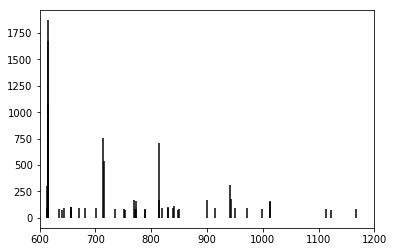

In [11]:
plot_scan(fn = 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela0125ug240k.mzML', scan_index=1,
         scan_range=(600,1200))

170


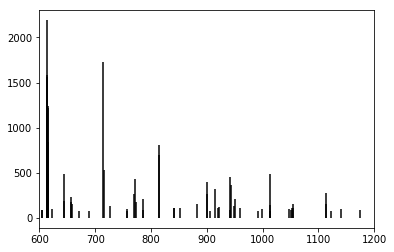

In [12]:
plot_scan(fn = 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela025ug240k.mzML', scan_index=1)

339


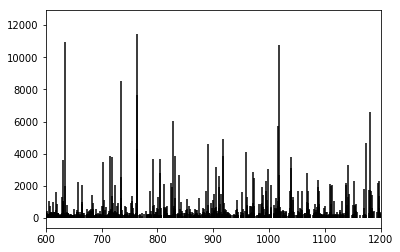

In [13]:
plot_scan(fn = 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela05ug240k2.mzML', scan_index=170)

339


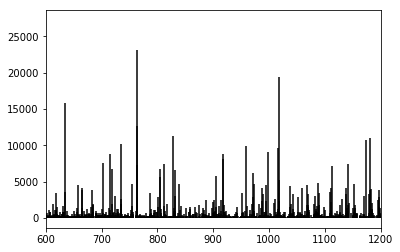

In [14]:
plot_scan(fn = 'D:\\downloads\\quantification\\quantification240k\\mzml-JGM\\hela1ug240k3.mzML', scan_index=170)

## figure out which fragment to use

In [15]:
sequence = 'ITLQDVVSHSK'  ### sequence for scan 170 is this

In [16]:
file.split('\\')[-1]

'hela1ug240k3.mzML'

In [17]:
qtargs = pd.read_csv('D:/downloads/quantification/quantification240k/csodiaq results/CsoDIAq-file12_hela0125ug240k2_corrected_proteinFDR.csv')
qtargs.sort_values('scan', inplace=True)
qtargs.reset_index(inplace=True)

In [18]:
qtargs.head()

index                                           fileName  scan       MzEXP  \
0   2244  D:/yuming/20220304/quantification240k/hela0125...   170  614.280029   
1   3936  D:/yuming/20220304/quantification240k/hela0125...   170  614.280029   
2   3970  D:/yuming/20220304/quantification240k/hela0125...   171  625.280029   
3   1475  D:/yuming/20220304/quantification240k/hela0125...   172  626.280029   
4   2046  D:/yuming/20220304/quantification240k/hela0125...   173  642.280029   

                 peptide                  protein       MzLIB  zLIB    cosine  \
0            ITLQDVVSHSK  1/sp|P46940|IQGA1_HUMAN  613.840602     2  0.986056   
1  (UniMod:5)ADGQVAELLLR   1/sp|Q9Y285|SYFA_HUMAN  614.338227     2  0.995474   
2           EEFTSGGPLGQK   1/sp|P43034|LIS1_HUMAN  625.306592     2  0.984992   
3            ATLYVTAIEDR   1/sp|Q99873|ANM1_HUMAN  626.332610     2  0.993982   
4           VTVLFAGQHIAK   1/sp|P21333|FLNA_HUMAN  642.377155     2  0.993404   

                             name      ...        shared    ionCount  \
0            108311_ITLQDVVSHSK_2      ...             6   92.354531   
1  108063_(UniMod:5)ADGQVAELLLR_2      ...             5  104.147069   
2           115281_EEFTSGGPLGQK_2      ...             6   98.295229   
3            115797_ATLYVTAIEDR_2      ...             8  189.916065   
4           125327_VTVLFAGQHIAK_2      ...             6  121.350607   

   CompensationVoltage  totalWindowWidth  MaCC_Score  peptideFDR  \
0                -30.0               1.0    1.411015         0.0   
1                -30.0               1.0    1.373485         0.0   
2                -30.0               1.0    1.409493         0.0   
3                -30.0               1.0    1.506595         0.0   
4                -30.0               1.0    1.421530         0.0   

            leadingProtein  proteinCosine leadingProteinFDR  uniquePeptide  
0  1/sp|P46940|IQGA1_HUMAN       0.990728               0.0              1  
1   1/sp|Q9Y285|SYFA_HUMAN       0.975890               0.0              1  
2   1/sp|P43034|LIS1_HUMAN       0.975473               0.0              1  
3   1/sp|Q99873|ANM1_HUMAN       0.993982               0.0              1  
4   1/sp|P21333|FLNA_HUMAN       0.991479               0.0              1  

[5 rows x 22 columns]

In [19]:
qtargs.peptide[0]

'ITLQDVVSHSK'

In [20]:
if '(UniMod:4' in qtargs.peptide[0]:
    print('yes')

In [21]:
tmp_pep = qtargs.peptide[0]
re.sub('\(UniMod:4\)', '', tmp_pep)


'ITLQDVVSHSK'

In [22]:

tmp_pep = qtargs.peptide[0]
tmp_pep = re.sub('\(UniMod:4\)', '', tmp_pep)
if 'UniMod:' in tmp_pep:
    print('yes')
# clean sequence to remove mod masses and change oxMet to 'm'
fraglist = []
z=1
for x in range(1, len(tmp_pep)-1):
    fragseq = tmp_pep[x:]
    lightfragmz = mass.calculate_mass(sequence=tmp_pep[x:], ion_type='y', charge=1, aa_comp = customAAcomp)
    ## part to count the number of K and R residues
    fraglist.append([fragseq, lightfragmz])
fl = pd.DataFrame(fraglist)
fl.columns = ['fragseq', 'lightmz']
print(fl)





      fragseq      lightmz
0  TLQDVVSHSK  1113.589864
1   LQDVVSHSK  1012.542185
2    QDVVSHSK   899.458121
3     DVVSHSK   771.399544
4      VVSHSK   656.372601
5       VSHSK   557.304187
6        SHSK   458.235773
7         HSK   371.203744
8          SK   234.144833


In [23]:
qtargs.scan[0]-169

1

In [24]:
tmp_1ug.get_by_index(1)

{'index': 1,
 'id': 'controllerType=0 controllerNumber=1 scan=170',
 'defaultArrayLength': 300,
 'scanList': {'count': 1,
  'scan': [{'scanWindowList': {'count': 1,
     'scanWindow': [{'scan window lower limit': 127.41512298584 m/z,
       'scan window upper limit': 1274.151245117188 m/z}]},
    'scan start time': 0.829277320162 minute,
    'filter string': 'FTMS + c NSI cv=-30.00 Full ms2 614.2800@hcd30.00 [127.4151-1274.1512]',
    'preset scan configuration': 2.0,
    'ion injection time': 503.000020980835 millisecond,
    '[Thermo Trailer Extra]Monoisotopic M/Z:': 0.0}],
  'no combination': ''},
 'precursorList': {'count': 1,
  'precursor': [{'isolationWindow': {'isolation window target m/z': 614.280029296875 m/z,
     'isolation window lower offset': 0.5 m/z,
     'isolation window upper offset': 0.5 m/z,
     'ms level': 1},
    'selectedIonList': {'count': 1,
     'selectedIon': [{'selected ion m/z': 614.280029296875 m/z}]},
    'activation': {'beam-type collision-induced disso

In [25]:
qtargs.scan[0]-167

3

D:\downloads\quantification\quantification240k\mzml-JGM\hela0125ug240k.mzML
1


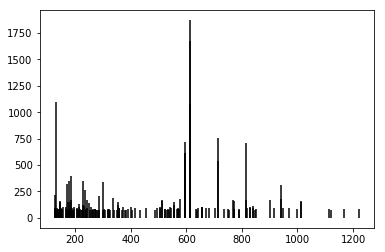

In [26]:
file = fileslist[0]
print(file)
with pyteomics.mzml.read(file, use_index=True) as mzml:

    index = qtargs.scan[0] - 169
    print(index)
    tmpmzarray = mzml.get_by_index(index)['m/z array'].tolist()
    tmpintarray = mzml.get_by_index(index)['intensity array'].tolist()
    plt.vlines(tmpmzarray,
       [0]*len(tmpmzarray),
       tmpintarray)
    


In [27]:
all_results_dict = {}
TOL_TYPE = "ppm"
TOL = 20e-6
results_dict = {}
index = qtargs.scan[0]-169

for file in fileslist:
    print(file.split('\\')[-1])
    with pyteomics.mzml.read(file, use_index=True) as tmpquantfile:
        tmpmzarray = tmpquantfile.get_by_index(index)['m/z array'].tolist()
        tmpintarray = tmpquantfile.get_by_index(index)['intensity array'].tolist()
        ints = [getFragInt(x, tmpmzarray, tmpintarray, TOL, TOL_TYPE) for x in fl['lightmz'] ]
        #print(ints)
    results_dict[file.split('\\')[-1]] = sum(ints)
all_results_dict[tmp_pep] = results_dict

hela0125ug240k.mzML
hela0125ug240k2.mzML
hela0125ug240k3.mzML
hela0125ug240k_20220305180559.mzML
hela025ug240k.mzML
hela025ug240k2.mzML
hela025ug240k3.mzML
hela05ug240k.mzML
hela05ug240k2.mzML
hela05ug240k3.mzML
hela1ug240k.mzML
hela1ug240k2.mzML
hela1ug240k3.mzML


In [28]:
pd.DataFrame.from_dict(all_results_dict)

ITLQDVVSHSK
hela0125ug240k.mzML                   620.035965
hela0125ug240k2.mzML                 1546.859718
hela0125ug240k3.mzML                 1033.949516
hela0125ug240k_20220305180559.mzML   1486.536697
hela025ug240k.mzML                   2401.557518
hela025ug240k2.mzML                  1370.256691
hela025ug240k3.mzML                  5786.422165
hela05ug240k.mzML                    2968.253952
hela05ug240k2.mzML                   3933.471405
hela05ug240k3.mzML                   4575.809387
hela1ug240k.mzML                    15133.129333
hela1ug240k2.mzML                   13966.216553
hela1ug240k3.mzML                   15239.269653

# quant range only to 4520 which is the end of CV=-70

In [104]:
all_results_dict = {}

all_index_dict = {}
### only 
for i in range(0,4520):
    tmp_pep = qtargs.peptide[i]
    tmp_pep = re.sub('\(UniMod:4\)', '', tmp_pep)
    if 'UniMod:' in tmp_pep:
        continue
    # clean sequence to remove mod masses and change oxMet to 'm'
    fraglist = []
    z=1
    for x in range(1, len(tmp_pep)-1):
        fragseq = tmp_pep[x:]
        lightfragmz = mass.calculate_mass(sequence=tmp_pep[x:], ion_type='y', charge=1, aa_comp = customAAcomp)
        ## part to count the number of K and R residues
        fraglist.append([fragseq, lightfragmz])
    fl = pd.DataFrame(fraglist)
    fl.columns = ['fragseq', 'lightmz']
    print(fl)



    TOL_TYPE = "ppm"
    TOL = 20e-6
    results_dict = {}
    index_dict = {}
    #index = qtargs.scan[i]

    for file in fileslist:
        print(file.split('\\')[-1])
        tmp_indexes=[]
        with pyteomics.mzml.read(file, use_index=True) as tmpquantfile:
            #index_diff = 167-int(tmpquantfile.get_by_index(0)['id'][-3:])
            index = qtargs.scan[i] - 169
            print(index)
            tmpmzarray = tmpquantfile.get_by_index(index)['m/z array'].tolist()
            tmpintarray = tmpquantfile.get_by_index(index)['intensity array'].tolist()
            ints = [getFragInt(x, tmpmzarray, tmpintarray, TOL, TOL_TYPE) for x in fl['lightmz'] ]
            #print(ints)
        results_dict[file.split('\\')[-1]] = sum(ints)
        index_dict[file.split('\\')[-1]] = index
        
    all_results_dict[tmp_pep] = results_dict
    all_index_dict[tmp_pep] = index_dict

      fragseq      lightmz
0  TLQDVVSHSK  1113.589864
1   LQDVVSHSK  1012.542185
2    QDVVSHSK   899.458121
3     DVVSHSK   771.399544
4      VVSHSK   656.372601
5       VSHSK   557.304187
6        SHSK   458.235773
7         HSK   371.203744
8          SK   234.144833
hela0125ug240k.mzML
1
hela0125ug240k2.mzML
1
hela0125ug240k3.mzML
1
hela0125ug240k_20220305180559.mzML
1
hela025ug240k.mzML
1
hela025ug240k2.mzML
1
hela025ug240k3.mzML
1
hela05ug240k.mzML
1
hela05ug240k2.mzML
1
hela05ug240k3.mzML
1
hela1ug240k.mzML
1
hela1ug240k2.mzML
1
hela1ug240k3.mzML
1
       fragseq      lightmz
0  EFTSGGPLGQK  1120.563315
1   FTSGGPLGQK   991.520721
2    TSGGPLGQK   844.452308
3     SGGPLGQK   743.404629
4      GGPLGQK   656.372601
5       GPLGQK   599.351137
6        PLGQK   542.329673
7         LGQK   445.276909
8          GQK   332.192845
9           QK   275.171382
hela0125ug240k.mzML
2
hela0125ug240k2.mzML
2
hela0125ug240k3.mzML
2
hela0125ug240k_20220305180559.mzML
2
hela025ug240k.mzML
2
hela0

          fragseq      lightmz
0   VDEVTIVNILTNR  1485.827134
1    DEVTIVNILTNR  1386.758720
2     EVTIVNILTNR  1271.731777
3      VTIVNILTNR  1142.689184
4       TIVNILTNR  1043.620770
5        IVNILTNR   942.573091
6         VNILTNR   829.489027
7          NILTNR   730.420613
8           ILTNR   616.377686
9            LTNR   503.293622
10            TNR   390.209558
11             NR   289.161880
hela0125ug240k.mzML
13
hela0125ug240k2.mzML
13
hela0125ug240k3.mzML
13
hela0125ug240k_20220305180559.mzML
13
hela025ug240k.mzML
13
hela025ug240k2.mzML
13
hela025ug240k3.mzML
13
hela05ug240k.mzML
13
hela05ug240k2.mzML
13
hela05ug240k3.mzML
13
hela1ug240k.mzML
13
hela1ug240k2.mzML
13
hela1ug240k3.mzML
13
          fragseq      lightmz
0   TDVNVFNTILTTR  1493.795834
1    DVNVFNTILTTR  1392.748155
2     VNVFNTILTTR  1277.721212
3      NVFNTILTTR  1178.652798
4       VFNTILTTR  1064.609871
5        FNTILTTR   965.541457
6         NTILTTR   818.473043
7          TILTTR   704.430116
8           IL

hela0125ug240k3.mzML
19
hela0125ug240k_20220305180559.mzML
19
hela025ug240k.mzML
19
hela025ug240k2.mzML
19
hela025ug240k3.mzML
19
hela05ug240k.mzML
19
hela05ug240k2.mzML
19
hela05ug240k3.mzML
19
hela1ug240k.mzML
19
hela1ug240k2.mzML
19
hela1ug240k3.mzML
19
          fragseq      lightmz
0   YALSASFEPFSNK  1460.705622
1    ALSASFEPFSNK  1297.642293
2     LSASFEPFSNK  1226.605179
3      SASFEPFSNK  1113.521115
4       ASFEPFSNK  1026.489087
5        SFEPFSNK   955.451973
6         FEPFSNK   868.419945
7          EPFSNK   721.351531
8           PFSNK   592.308938
9            FSNK   495.256174
10            SNK   348.187760
11             NK   261.155732
hela0125ug240k.mzML
20
hela0125ug240k2.mzML
20
hela0125ug240k3.mzML
20
hela0125ug240k_20220305180559.mzML
20
hela025ug240k.mzML
20
hela025ug240k2.mzML
20
hela025ug240k3.mzML
20
hela05ug240k.mzML
20
hela05ug240k2.mzML
20
hela05ug240k3.mzML
20
hela1ug240k.mzML
20
hela1ug240k2.mzML
20
hela1ug240k3.mzML
20
           fragseq      lightmz
0   

25
hela1ug240k.mzML
25
hela1ug240k2.mzML
25
hela1ug240k3.mzML
25
            fragseq      lightmz
0   NEGAIVEVALEGYYK  1654.832279
1    EGAIVEVALEGYYK  1540.789351
2     GAIVEVALEGYYK  1411.746758
3      AIVEVALEGYYK  1354.725294
4       IVEVALEGYYK  1283.688181
5        VEVALEGYYK  1170.604117
6         EVALEGYYK  1071.535703
7          VALEGYYK   942.493110
8           ALEGYYK   843.424696
9            LEGYYK   772.387582
10            EGYYK   659.303518
11             GYYK   530.260925
12              YYK   473.239461
13               YK   310.176133
hela0125ug240k.mzML
25
hela0125ug240k2.mzML
25
hela0125ug240k3.mzML
25
hela0125ug240k_20220305180559.mzML
25
hela025ug240k.mzML
25
hela025ug240k2.mzML
25
hela025ug240k3.mzML
25
hela05ug240k.mzML
25
hela05ug240k2.mzML
25
hela05ug240k3.mzML
25
hela1ug240k.mzML
25
hela1ug240k2.mzML
25
hela1ug240k3.mzML
25
                    fragseq      lightmz
0   DCGEEILITVLSAMTEEAAVAIK  2463.235705
1    CGEEILITVLSAMTEEAAVAIK  2348.208762
2     GEEILIT

hela0125ug240k2.mzML
31
hela0125ug240k3.mzML
31
hela0125ug240k_20220305180559.mzML
31
hela025ug240k.mzML
31
hela025ug240k2.mzML
31
hela025ug240k3.mzML
31
hela05ug240k.mzML
31
hela05ug240k2.mzML
31
hela05ug240k3.mzML
31
hela1ug240k.mzML
31
hela1ug240k2.mzML
31
hela1ug240k3.mzML
31
              fragseq      lightmz
0   LAIGLINEALDEGDAQK  1769.927970
1    AIGLINEALDEGDAQK  1656.843906
2     IGLINEALDEGDAQK  1585.806792
3      GLINEALDEGDAQK  1472.722728
4       LINEALDEGDAQK  1415.701265
5        INEALDEGDAQK  1302.617201
6         NEALDEGDAQK  1189.533137
7          EALDEGDAQK  1075.490209
8           ALDEGDAQK   946.447616
9            LDEGDAQK   875.410502
10            DEGDAQK   762.326438
11             EGDAQK   647.299495
12              GDAQK   518.256902
13               DAQK   461.235438
14                AQK   346.208495
15                 QK   275.171382
hela0125ug240k.mzML
31
hela0125ug240k2.mzML
31
hela0125ug240k3.mzML
31
hela0125ug240k_20220305180559.mzML
31
hela025ug240k.m

hela0125ug240k3.mzML
33
hela0125ug240k_20220305180559.mzML
33
hela025ug240k.mzML
33
hela025ug240k2.mzML
33
hela025ug240k3.mzML
33
hela05ug240k.mzML
33
hela05ug240k2.mzML
33
hela05ug240k3.mzML
33
hela1ug240k.mzML
33
hela1ug240k2.mzML
33
hela1ug240k3.mzML
33
               fragseq      lightmz
0   TDECAIESIAVAATPIPK  1885.957556
1    DECAIESIAVAATPIPK  1784.909877
2     ECAIESIAVAATPIPK  1669.882934
3      CAIESIAVAATPIPK  1540.840341
4       AIESIAVAATPIPK  1380.809693
5        IESIAVAATPIPK  1309.772579
6         ESIAVAATPIPK  1196.688515
7          SIAVAATPIPK  1067.645922
8           IAVAATPIPK   980.613894
9            AVAATPIPK   867.529830
10            VAATPIPK   796.492716
11             AATPIPK   697.424302
12              ATPIPK   626.387188
13               TPIPK   555.350074
14                PIPK   454.302396
15                 IPK   357.249632
16                  PK   244.165568
hela0125ug240k.mzML
34
hela0125ug240k2.mzML
34
hela0125ug240k3.mzML
34
hela0125ug240k_202203051

hela0125ug240k_20220305180559.mzML
35
hela025ug240k.mzML
35
hela025ug240k2.mzML
35
hela025ug240k3.mzML
35
hela05ug240k.mzML
35
hela05ug240k2.mzML
35
hela05ug240k3.mzML
35
hela1ug240k.mzML
35
hela1ug240k2.mzML
35
hela1ug240k3.mzML
35
             fragseq      lightmz
0   IFLSQPILLELEAPLK  1824.088099
1    FLSQPILLELEAPLK  1711.004036
2     LSQPILLELEAPLK  1563.935622
3      SQPILLELEAPLK  1450.851558
4       QPILLELEAPLK  1363.819529
5        PILLELEAPLK  1235.760952
6         ILLELEAPLK  1138.708188
7          LLELEAPLK  1025.624124
8           LELEAPLK   912.540060
9            ELEAPLK   799.455996
10            LEAPLK   670.413403
11             EAPLK   557.329339
12              APLK   428.286746
13               PLK   357.249632
14                LK   260.196868
hela0125ug240k.mzML
35
hela0125ug240k2.mzML
35
hela0125ug240k3.mzML
35
hela0125ug240k_20220305180559.mzML
35
hela025ug240k.mzML
35
hela025ug240k2.mzML
35
hela025ug240k3.mzML
35
hela05ug240k.mzML
35
hela05ug240k2.mzML
35
hel

37
hela0125ug240k3.mzML
37
hela0125ug240k_20220305180559.mzML
37
hela025ug240k.mzML
37
hela025ug240k2.mzML
37
hela025ug240k3.mzML
37
hela05ug240k.mzML
37
hela05ug240k2.mzML
37
hela05ug240k3.mzML
37
hela1ug240k.mzML
37
hela1ug240k2.mzML
37
hela1ug240k3.mzML
37
            fragseq      lightmz
0   PIEHGIITNWDDMEK  1797.847612
1    IEHGIITNWDDMEK  1700.794848
2     EHGIITNWDDMEK  1587.710784
3      HGIITNWDDMEK  1458.668191
4       GIITNWDDMEK  1321.609279
5        IITNWDDMEK  1264.587815
6         ITNWDDMEK  1151.503751
7          TNWDDMEK  1038.419687
8           NWDDMEK   937.372009
9            WDDMEK   823.329081
10            DDMEK   637.249768
11             DMEK   522.222825
12              MEK   407.195882
13               EK   276.155397
hela0125ug240k.mzML
37
hela0125ug240k2.mzML
37
hela0125ug240k3.mzML
37
hela0125ug240k_20220305180559.mzML
37
hela025ug240k.mzML
37
hela025ug240k2.mzML
37
hela025ug240k3.mzML
37
hela05ug240k.mzML
37
hela05ug240k2.mzML
37
hela05ug240k3.mzML
37
hel

43
hela1ug240k2.mzML
43
hela1ug240k3.mzML
43
    fragseq     lightmz
0  ALTGDEVK  832.441074
1   LTGDEVK  761.403960
2    TGDEVK  648.319896
3     GDEVK  547.272218
4      DEVK  490.250754
5       EVK  375.223811
6        VK  246.181218
hela0125ug240k.mzML
44
hela0125ug240k2.mzML
44
hela0125ug240k3.mzML
44
hela0125ug240k_20220305180559.mzML
44
hela025ug240k.mzML
44
hela025ug240k2.mzML
44
hela025ug240k3.mzML
44
hela05ug240k.mzML
44
hela05ug240k2.mzML
44
hela05ug240k3.mzML
44
hela1ug240k.mzML
44
hela1ug240k2.mzML
44
hela1ug240k3.mzML
44
   fragseq     lightmz
0  GLDYEER  881.399938
1   LDYEER  824.378474
2    DYEER  711.294410
3     YEER  596.267467
4      EER  433.204138
5       ER  304.161545
hela0125ug240k.mzML
44
hela0125ug240k2.mzML
44
hela0125ug240k3.mzML
44
hela0125ug240k_20220305180559.mzML
44
hela025ug240k.mzML
44
hela025ug240k2.mzML
44
hela025ug240k3.mzML
44
hela05ug240k.mzML
44
hela05ug240k2.mzML
44
hela05ug240k3.mzML
44
hela1ug240k.mzML
44
hela1ug240k2.mzML
44
hela1ug240k3.mz

hela025ug240k3.mzML
46
hela05ug240k.mzML
46
hela05ug240k2.mzML
46
hela05ug240k3.mzML
46
hela1ug240k.mzML
46
hela1ug240k2.mzML
46
hela1ug240k3.mzML
46
    fragseq     lightmz
0  LCGLLAER  931.502963
1   CGLLAER  818.418899
2    GLLAER  658.388251
3     LLAER  601.366787
4      LAER  488.282723
5       AER  375.198659
6        ER  304.161545
hela0125ug240k.mzML
46
hela0125ug240k2.mzML
46
hela0125ug240k3.mzML
46
hela0125ug240k_20220305180559.mzML
46
hela025ug240k.mzML
46
hela025ug240k2.mzML
46
hela025ug240k3.mzML
46
hela05ug240k.mzML
46
hela05ug240k2.mzML
46
hela05ug240k3.mzML
46
hela1ug240k.mzML
46
hela1ug240k2.mzML
46
hela1ug240k3.mzML
46
    fragseq      lightmz
0  VQYLNEIK  1006.556773
1   QYLNEIK   907.488359
2    YLNEIK   779.429781
3     LNEIK   616.366453
4      NEIK   503.282389
5       EIK   389.239461
6        IK   260.196868
hela0125ug240k.mzML
47
hela0125ug240k2.mzML
47
hela0125ug240k3.mzML
47
hela0125ug240k_20220305180559.mzML
47
hela025ug240k.mzML
47
hela025ug240k2.mzML
47


hela1ug240k2.mzML
49
hela1ug240k3.mzML
49
    fragseq     lightmz
0  FMGNQVLK  936.497150
1   MGNQVLK  789.428736
2    GNQVLK  658.388251
3     NQVLK  601.366787
4      QVLK  487.323860
5       VLK  359.265282
6        LK  260.196868
hela0125ug240k.mzML
50
hela0125ug240k2.mzML
50
hela0125ug240k3.mzML
50
hela0125ug240k_20220305180559.mzML
50
hela025ug240k.mzML
50
hela025ug240k2.mzML
50
hela025ug240k3.mzML
50
hela05ug240k.mzML
50
hela05ug240k2.mzML
50
hela05ug240k3.mzML
50
hela1ug240k.mzML
50
hela1ug240k2.mzML
50
hela1ug240k3.mzML
50
    fragseq     lightmz
0  QGVNLYVK  920.519993
1   GVNLYVK  792.461416
2    VNLYVK  735.439952
3     NLYVK  636.371538
4      LYVK  522.328611
5       YVK  409.244547
6        VK  246.181218
hela0125ug240k.mzML
50
hela0125ug240k2.mzML
50
hela0125ug240k3.mzML
50
hela0125ug240k_20220305180559.mzML
50
hela025ug240k.mzML
50
hela025ug240k2.mzML
50
hela025ug240k3.mzML
50
hela05ug240k.mzML
50
hela05ug240k2.mzML
50
hela05ug240k3.mzML
50
hela1ug240k.mzML
50
hela1ug2

hela025ug240k2.mzML
51
hela025ug240k3.mzML
51
hela05ug240k.mzML
51
hela05ug240k2.mzML
51
hela05ug240k3.mzML
51
hela1ug240k.mzML
51
hela1ug240k2.mzML
51
hela1ug240k3.mzML
51
      fragseq     lightmz
0  LMVGLDAAGK  974.533929
1   MVGLDAAGK  861.449865
2    VGLDAAGK  730.409380
3     GLDAAGK  631.340966
4      LDAAGK  574.319502
5       DAAGK  461.235438
6        AAGK  346.208495
7         AGK  275.171382
8          GK  204.134268
hela0125ug240k.mzML
51
hela0125ug240k2.mzML
51
hela0125ug240k3.mzML
51
hela0125ug240k_20220305180559.mzML
51
hela025ug240k.mzML
51
hela025ug240k2.mzML
51
hela025ug240k3.mzML
51
hela05ug240k.mzML
51
hela05ug240k2.mzML
51
hela05ug240k3.mzML
51
hela1ug240k.mzML
51
hela1ug240k2.mzML
51
hela1ug240k3.mzML
51
    fragseq     lightmz
0  AILNEPFK  931.524744
1   ILNEPFK  860.487630
2    LNEPFK  747.403566
3     NEPFK  634.319502
4      EPFK  520.276575
5       PFK  391.233982
6        FK  294.181218
hela0125ug240k.mzML
52
hela0125ug240k2.mzML
52
hela0125ug240k3.mzML
52


hela0125ug240k3.mzML
54
hela0125ug240k_20220305180559.mzML
54
hela025ug240k.mzML
54
hela025ug240k2.mzML
54
hela025ug240k3.mzML
54
hela05ug240k.mzML
54
hela05ug240k2.mzML
54
hela05ug240k3.mzML
54
hela1ug240k.mzML
54
hela1ug240k2.mzML
54
hela1ug240k3.mzML
54
    fragseq      lightmz
0  DTSFMFQR  1031.461492
1   TSFMFQR   916.434549
2    SFMFQR   815.386871
3     FMFQR   728.354842
4      MFQR   581.286429
5       FQR   450.245944
6        QR   303.177530
hela0125ug240k.mzML
54
hela0125ug240k2.mzML
54
hela0125ug240k3.mzML
54
hela0125ug240k_20220305180559.mzML
54
hela025ug240k.mzML
54
hela025ug240k2.mzML
54
hela025ug240k3.mzML
54
hela05ug240k.mzML
54
hela05ug240k2.mzML
54
hela05ug240k3.mzML
54
hela1ug240k.mzML
54
hela1ug240k2.mzML
54
hela1ug240k3.mzML
54
     fragseq      lightmz
0  LGLLDAYLK  1005.597909
1   GLLDAYLK   892.513845
2    LLDAYLK   835.492381
3     LDAYLK   722.408317
4      DAYLK   609.324253
5       AYLK   494.297310
6        YLK   423.260197
7         LK   260.196868
hela0

55
hela1ug240k3.mzML
55
    fragseq      lightmz
0  QLIYNLLK  1004.613894
1   LIYNLLK   876.555316
2    IYNLLK   763.471252
3     YNLLK   650.387188
4      NLLK   487.323860
5       LLK   373.280932
6        LK   260.196868
hela0125ug240k.mzML
55
hela0125ug240k2.mzML
55
hela0125ug240k3.mzML
55
hela0125ug240k_20220305180559.mzML
55
hela025ug240k.mzML
55
hela025ug240k2.mzML
55
hela025ug240k3.mzML
55
hela05ug240k.mzML
55
hela05ug240k2.mzML
55
hela05ug240k3.mzML
55
hela1ug240k.mzML
55
hela1ug240k2.mzML
55
hela1ug240k3.mzML
55
     fragseq      lightmz
0  LELDSNNEK  1061.510945
1   ELDSNNEK   948.426881
2    LDSNNEK   819.384288
3     DSNNEK   706.300224
4      SNNEK   591.273281
5       NNEK   504.241252
6        NEK   390.198325
7         EK   276.155397
hela0125ug240k.mzML
56
hela0125ug240k2.mzML
56
hela0125ug240k3.mzML
56
hela0125ug240k_20220305180559.mzML
56
hela025ug240k.mzML
56
hela025ug240k2.mzML
56
hela025ug240k3.mzML
56
hela05ug240k.mzML
56
hela05ug240k2.mzML
56
hela05ug240k3.mzML

58
      fragseq      lightmz
0  VFLGLDNAGK  1033.567672
1   FLGLDNAGK   934.499258
2    LGLDNAGK   787.430844
3     GLDNAGK   674.346780
4      LDNAGK   617.325316
5       DNAGK   504.241252
6        NAGK   389.214309
7         AGK   275.171382
8          GK   204.134268
hela0125ug240k.mzML
59
hela0125ug240k2.mzML
59
hela0125ug240k3.mzML
59
hela0125ug240k_20220305180559.mzML
59
hela025ug240k.mzML
59
hela025ug240k2.mzML
59
hela025ug240k3.mzML
59
hela05ug240k.mzML
59
hela05ug240k2.mzML
59
hela05ug240k3.mzML
59
hela1ug240k.mzML
59
hela1ug240k2.mzML
59
hela1ug240k3.mzML
59
     fragseq      lightmz
0  SEGFSIHTR  1033.506134
1   EGFSIHTR   946.474106
2    GFSIHTR   817.431513
3     FSIHTR   760.410049
4      SIHTR   613.341635
5       IHTR   526.309606
6        HTR   413.225543
7         TR   276.166631
hela0125ug240k.mzML
59
hela0125ug240k2.mzML
59
hela0125ug240k3.mzML
59
hela0125ug240k_20220305180559.mzML
59
hela025ug240k.mzML
59
hela025ug240k2.mzML
59
hela025ug240k3.mzML
59
hela05ug240k

60
hela05ug240k3.mzML
60
hela1ug240k.mzML
60
hela1ug240k2.mzML
60
hela1ug240k3.mzML
60
      fragseq      lightmz
0  TDLLGGLFSK  1050.582987
1   DLLGGLFSK   949.535309
2    LLGGLFSK   834.508366
3     LGGLFSK   721.424302
4      GGLFSK   608.340238
5       GLFSK   551.318774
6        LFSK   494.297310
7         FSK   381.213246
8          SK   234.144833
hela0125ug240k.mzML
60
hela0125ug240k2.mzML
60
hela0125ug240k3.mzML
60
hela0125ug240k_20220305180559.mzML
60
hela025ug240k.mzML
60
hela025ug240k2.mzML
60
hela025ug240k3.mzML
60
hela05ug240k.mzML
60
hela05ug240k2.mzML
60
hela05ug240k3.mzML
60
hela1ug240k.mzML
60
hela1ug240k2.mzML
60
hela1ug240k3.mzML
60
      fragseq      lightmz
0  EAIITPPPAK  1036.603723
1   AIITPPPAK   907.561130
2    IITPPPAK   836.524016
3     ITPPPAK   723.439952
4      TPPPAK   610.355888
5       PPPAK   509.308209
6        PPAK   412.255446
7         PAK   315.202682
8          AK   218.149918
hela0125ug240k.mzML
60
hela0125ug240k2.mzML
60
hela0125ug240k3.mzML
6

hela0125ug240k3.mzML
61
hela0125ug240k_20220305180559.mzML
61
hela025ug240k.mzML
61
hela025ug240k2.mzML
61
hela025ug240k3.mzML
61
hela05ug240k.mzML
61
hela05ug240k2.mzML
61
hela05ug240k3.mzML
61
hela1ug240k.mzML
61
hela1ug240k2.mzML
61
hela1ug240k3.mzML
61
     fragseq      lightmz
0  YTEDSPGLK  1009.483667
1   TEDSPGLK   846.420339
2    EDSPGLK   745.372660
3     DSPGLK   616.330067
4      SPGLK   501.303124
5       PGLK   414.271096
6        GLK   317.218332
7         LK   260.196868
hela0125ug240k.mzML
62
hela0125ug240k2.mzML
62
hela0125ug240k3.mzML
62
hela0125ug240k_20220305180559.mzML
62
hela025ug240k.mzML
62
hela025ug240k2.mzML
62
hela025ug240k3.mzML
62
hela05ug240k.mzML
62
hela05ug240k2.mzML
62
hela05ug240k3.mzML
62
hela1ug240k.mzML
62
hela1ug240k2.mzML
62
hela1ug240k3.mzML
62
      fragseq      lightmz
0  AGTDDHTLIR  1098.553812
1   GTDDHTLIR  1027.516699
2    TDDHTLIR   970.495235
3     DDHTLIR   869.447557
4      DHTLIR   754.420613
5       HTLIR   639.393670
6        TLIR   

hela0125ug240k2.mzML
63
hela0125ug240k3.mzML
63
hela0125ug240k_20220305180559.mzML
63
hela025ug240k.mzML
63
hela025ug240k2.mzML
63
hela025ug240k3.mzML
63
hela05ug240k.mzML
63
hela05ug240k2.mzML
63
hela05ug240k3.mzML
63
hela1ug240k.mzML
63
hela1ug240k2.mzML
63
hela1ug240k3.mzML
63
     fragseq      lightmz
0  YVISLAEPR  1047.583322
1   VISLAEPR   884.519993
2    ISLAEPR   785.451579
3     SLAEPR   672.367515
4      LAEPR   585.335487
5       AEPR   472.251423
6        EPR   401.214309
7         PR   272.171716
hela0125ug240k.mzML
63
hela0125ug240k2.mzML
63
hela0125ug240k3.mzML
63
hela0125ug240k_20220305180559.mzML
63
hela025ug240k.mzML
63
hela025ug240k2.mzML
63
hela025ug240k3.mzML
63
hela05ug240k.mzML
63
hela05ug240k2.mzML
63
hela05ug240k3.mzML
63
hela1ug240k.mzML
63
hela1ug240k2.mzML
63
hela1ug240k3.mzML
63
     fragseq      lightmz
0  IYYITGESK  1073.551353
1   YYITGESK   960.467289
2    YITGESK   797.403960
3     ITGESK   634.340632
4      TGESK   521.256568
5       GESK   420.208889

hela025ug240k.mzML
65
hela025ug240k2.mzML
65
hela025ug240k3.mzML
65
hela05ug240k.mzML
65
hela05ug240k2.mzML
65
hela05ug240k3.mzML
65
hela1ug240k.mzML
65
hela1ug240k2.mzML
65
hela1ug240k3.mzML
65
     fragseq      lightmz
0  DQAVLDLQR  1057.563649
1   QAVLDLQR   942.536706
2    AVLDLQR   814.478128
3     VLDLQR   743.441015
4      LDLQR   644.372601
5       DLQR   531.288537
6        LQR   416.261594
7         QR   303.177530
hela0125ug240k.mzML
65
hela0125ug240k2.mzML
65
hela0125ug240k3.mzML
65
hela0125ug240k_20220305180559.mzML
65
hela025ug240k.mzML
65
hela025ug240k2.mzML
65
hela025ug240k3.mzML
65
hela05ug240k.mzML
65
hela05ug240k2.mzML
65
hela05ug240k3.mzML
65
hela1ug240k.mzML
65
hela1ug240k2.mzML
65
hela1ug240k3.mzML
65
     fragseq      lightmz
0  EAESMYQIK  1098.513587
1   AESMYQIK   969.470994
2    ESMYQIK   898.433881
3     SMYQIK   769.391287
4      MYQIK   682.359259
5       YQIK   551.318774
6        QIK   388.255446
7         IK   260.196868
hela0125ug240k.mzML
65
hela0125ug

hela0125ug240k2.mzML
66
hela0125ug240k3.mzML
66
hela0125ug240k_20220305180559.mzML
66
hela025ug240k.mzML
66
hela025ug240k2.mzML
66
hela025ug240k3.mzML
66
hela05ug240k.mzML
66
hela05ug240k2.mzML
66
hela05ug240k3.mzML
66
hela1ug240k.mzML
66
hela1ug240k2.mzML
66
hela1ug240k3.mzML
66
      fragseq      lightmz
0  ADGILKPLPK  1051.651007
1   DGILKPLPK   980.613894
2    GILKPLPK   865.586951
3     ILKPLPK   808.565487
4      LKPLPK   695.481423
5       KPLPK   582.397359
6        PLPK   454.302396
7         LPK   357.249632
8          PK   244.165568
hela0125ug240k.mzML
67
hela0125ug240k2.mzML
67
hela0125ug240k3.mzML
67
hela0125ug240k_20220305180559.mzML
67
hela025ug240k.mzML
67
hela025ug240k2.mzML
67
hela025ug240k3.mzML
67
hela05ug240k.mzML
67
hela05ug240k2.mzML
67
hela05ug240k3.mzML
67
hela1ug240k.mzML
67
hela1ug240k2.mzML
67
hela1ug240k3.mzML
67
     fragseq      lightmz
0  DSNLYINVK  1065.557501
1   SNLYINVK   950.530558
2    NLYINVK   863.498529
3     LYINVK   749.455602
4      YINVK   

hela0125ug240k3.mzML
68
hela0125ug240k_20220305180559.mzML
68
hela025ug240k.mzML
68
hela025ug240k2.mzML
68
hela025ug240k3.mzML
68
hela05ug240k.mzML
68
hela05ug240k2.mzML
68
hela05ug240k3.mzML
68
hela1ug240k.mzML
68
hela1ug240k2.mzML
68
hela1ug240k3.mzML
68
      fragseq      lightmz
0  LIEGSINSVR  1087.610599
1   IEGSINSVR   974.526535
2    EGSINSVR   861.442471
3     GSINSVR   732.399878
4      SINSVR   675.378414
5       INSVR   588.346386
6        NSVR   475.262322
7         SVR   361.219394
8          VR   274.187366
hela0125ug240k.mzML
68
hela0125ug240k2.mzML
68
hela0125ug240k3.mzML
68
hela0125ug240k_20220305180559.mzML
68
hela025ug240k.mzML
68
hela025ug240k2.mzML
68
hela025ug240k3.mzML
68
hela05ug240k.mzML
68
hela05ug240k2.mzML
68
hela05ug240k3.mzML
68
hela1ug240k.mzML
68
hela1ug240k2.mzML
68
hela1ug240k3.mzML
68
       fragseq      lightmz
0  VPAGMGAGLER  1057.545891
1   PAGMGAGLER   958.477477
2    AGMGAGLER   861.424713
3     GMGAGLER   790.387599
4      MGAGLER   733.366135
5

hela1ug240k2.mzML
70
hela1ug240k3.mzML
70
     fragseq      lightmz
0  STLIMQLLR  1074.633977
1   TLIMQLLR   987.601949
2    LIMQLLR   886.554271
3     IMQLLR   773.470207
4      MQLLR   660.386143
5       QLLR   529.345658
6        LLR   401.287080
7         LR   288.203016
hela0125ug240k.mzML
70
hela0125ug240k2.mzML
70
hela0125ug240k3.mzML
70
hela0125ug240k_20220305180559.mzML
70
hela025ug240k.mzML
70
hela025ug240k2.mzML
70
hela025ug240k3.mzML
70
hela05ug240k.mzML
70
hela05ug240k2.mzML
70
hela05ug240k3.mzML
70
hela1ug240k.mzML
70
hela1ug240k2.mzML
70
hela1ug240k3.mzML
70
     fragseq      lightmz
0  STLIMQLLR  1074.633977
1   TLIMQLLR   987.601949
2    LIMQLLR   886.554271
3     IMQLLR   773.470207
4      MQLLR   660.386143
5       QLLR   529.345658
6        LLR   401.287080
7         LR   288.203016
hela0125ug240k.mzML
70
hela0125ug240k2.mzML
70
hela0125ug240k3.mzML
70
hela0125ug240k_20220305180559.mzML
70
hela025ug240k.mzML
70
hela025ug240k2.mzML
70
hela025ug240k3.mzML
70
hela05ug2

hela05ug240k.mzML
71
hela05ug240k2.mzML
71
hela05ug240k3.mzML
71
hela1ug240k.mzML
71
hela1ug240k2.mzML
71
hela1ug240k3.mzML
71
       fragseq      lightmz
0  GSIAIQGAIEK  1086.615350
1   SIAIQGAIEK  1029.593886
2    IAIQGAIEK   942.561858
3     AIQGAIEK   829.477794
4      IQGAIEK   758.440680
5       QGAIEK   645.356616
6        GAIEK   517.298039
7         AIEK   460.276575
8          IEK   389.239461
9           EK   276.155397
hela0125ug240k.mzML
71
hela0125ug240k2.mzML
71
hela0125ug240k3.mzML
71
hela0125ug240k_20220305180559.mzML
71
hela025ug240k.mzML
71
hela025ug240k2.mzML
71
hela025ug240k3.mzML
71
hela05ug240k.mzML
71
hela05ug240k2.mzML
71
hela05ug240k3.mzML
71
hela1ug240k.mzML
71
hela1ug240k2.mzML
71
hela1ug240k3.mzML
71
      fragseq      lightmz
0  VISLQLTAEK  1101.651401
1   ISLQLTAEK  1002.582987
2    SLQLTAEK   889.498923
3     LQLTAEK   802.466895
4      QLTAEK   689.382831
5       LTAEK   561.324253
6        TAEK   448.240190
7         AEK   347.192511
8          EK   27

hela025ug240k.mzML
73
hela025ug240k2.mzML
73
hela025ug240k3.mzML
73
hela05ug240k.mzML
73
hela05ug240k2.mzML
73
hela05ug240k3.mzML
73
hela1ug240k.mzML
73
hela1ug240k2.mzML
73
hela1ug240k3.mzML
73
      fragseq      lightmz
0  VGDVDFEGVR  1092.532014
1   GDVDFEGVR   993.463600
2    DVDFEGVR   936.442137
3     VDFEGVR   821.415194
4      DFEGVR   722.346780
5       FEGVR   607.319837
6        EGVR   460.251423
7         GVR   331.208830
8          VR   274.187366
hela0125ug240k.mzML
73
hela0125ug240k2.mzML
73
hela0125ug240k3.mzML
73
hela0125ug240k_20220305180559.mzML
73
hela025ug240k.mzML
73
hela025ug240k2.mzML
73
hela025ug240k3.mzML
73
hela05ug240k.mzML
73
hela05ug240k2.mzML
73
hela05ug240k3.mzML
73
hela1ug240k.mzML
73
hela1ug240k2.mzML
73
hela1ug240k3.mzML
73
           fragseq      lightmz
0   SQFIGYPITLYLEK  1671.899236
1    QFIGYPITLYLEK  1584.867208
2     FIGYPITLYLEK  1456.808630
3      IGYPITLYLEK  1309.740216
4       GYPITLYLEK  1196.656152
5        YPITLYLEK  1139.634689
6      

76
hela025ug240k3.mzML
76
hela05ug240k.mzML
76
hela05ug240k2.mzML
76
hela05ug240k3.mzML
76
hela1ug240k.mzML
76
hela1ug240k2.mzML
76
hela1ug240k3.mzML
76
     fragseq      lightmz
0  LLLDYPPDR  1101.593886
1   LLDYPPDR   988.509822
2    LDYPPDR   875.425758
3     DYPPDR   762.341694
4      YPPDR   647.314751
5       PPDR   484.251423
6        PDR   387.198659
7         DR   290.145895
hela0125ug240k.mzML
76
hela0125ug240k2.mzML
76
hela0125ug240k3.mzML
76
hela0125ug240k_20220305180559.mzML
76
hela025ug240k.mzML
76
hela025ug240k2.mzML
76
hela025ug240k3.mzML
76
hela05ug240k.mzML
76
hela05ug240k2.mzML
76
hela05ug240k3.mzML
76
hela1ug240k.mzML
76
hela1ug240k2.mzML
76
hela1ug240k3.mzML
76
     fragseq      lightmz
0  FSIDVGYER  1085.526201
1   SIDVGYER   938.457787
2    IDVGYER   851.425758
3     DVGYER   738.341694
4      VGYER   623.314751
5       GYER   524.246338
6        YER   467.224874
7         ER   304.161545
hela0125ug240k.mzML
76
hela0125ug240k2.mzML
76
hela0125ug240k3.mzML
76
hela

       fragseq      lightmz
0  VQAEGEAEAAK  1102.537494
1   QAEGEAEAAK  1003.469080
2    AEGEAEAAK   875.410502
3     EGEAEAAK   804.373389
4      GEAEAAK   675.330795
5       EAEAAK   618.309332
6        AEAAK   489.266739
7         EAAK   418.229625
8          AAK   289.187032
9           AK   218.149918
hela0125ug240k.mzML
77
hela0125ug240k2.mzML
77
hela0125ug240k3.mzML
77
hela0125ug240k_20220305180559.mzML
77
hela025ug240k.mzML
77
hela025ug240k2.mzML
77
hela025ug240k3.mzML
77
hela05ug240k.mzML
77
hela05ug240k2.mzML
77
hela05ug240k3.mzML
77
hela1ug240k.mzML
77
hela1ug240k2.mzML
77
hela1ug240k3.mzML
77
       fragseq      lightmz
0  LMNLGGLAVAR  1114.640125
1   MNLGGLAVAR  1001.556061
2    NLGGLAVAR   870.515576
3     LGGLAVAR   756.472649
4      GGLAVAR   643.388585
5       GLAVAR   586.367121
6        LAVAR   529.345658
7         AVAR   416.261594
8          VAR   345.224480
9           AR   246.156066
hela0125ug240k.mzML
77
hela0125ug240k2.mzML
77
hela0125ug240k3.mzML
77
hela0125u

hela0125ug240k2.mzML
78
hela0125ug240k3.mzML
78
hela0125ug240k_20220305180559.mzML
78
hela025ug240k.mzML
78
hela025ug240k2.mzML
78
hela025ug240k3.mzML
78
hela05ug240k.mzML
78
hela05ug240k2.mzML
78
hela05ug240k3.mzML
78
hela1ug240k.mzML
78
hela1ug240k2.mzML
78
hela1ug240k3.mzML
78
       fragseq      lightmz
0  FNPGAGLPTDK  1116.568400
1   NPGAGLPTDK   969.499986
2    PGAGLPTDK   855.457059
3     GAGLPTDK   758.404295
4      AGLPTDK   701.382831
5       GLPTDK   630.345717
6        LPTDK   573.324253
7         PTDK   460.240190
8          TDK   363.187426
9           DK   262.139747
hela0125ug240k.mzML
78
hela0125ug240k2.mzML
78
hela0125ug240k3.mzML
78
hela0125ug240k_20220305180559.mzML
78
hela025ug240k.mzML
78
hela025ug240k2.mzML
78
hela025ug240k3.mzML
78
hela05ug240k.mzML
78
hela05ug240k2.mzML
78
hela05ug240k3.mzML
78
hela1ug240k.mzML
78
hela1ug240k2.mzML
78
hela1ug240k3.mzML
78
      fragseq      lightmz
0  YTGFSSNSER  1147.501443
1   TGFSSNSER   984.438114
2    GFSSNSER   883.390436

79
hela05ug240k.mzML
79
hela05ug240k2.mzML
79
hela05ug240k3.mzML
79
hela1ug240k.mzML
79
hela1ug240k2.mzML
79
hela1ug240k3.mzML
79
     fragseq      lightmz
0  LYEALVDCK  1110.549973
1   YEALVDCK   997.465909
2    EALVDCK   834.402580
3     ALVDCK   705.359987
4      LVDCK   634.322874
5       VDCK   521.238810
6        DCK   422.170396
7         CK   307.143453
hela0125ug240k.mzML
80
hela0125ug240k2.mzML
80
hela0125ug240k3.mzML
80
hela0125ug240k_20220305180559.mzML
80
hela025ug240k.mzML
80
hela025ug240k2.mzML
80
hela025ug240k3.mzML
80
hela05ug240k.mzML
80
hela05ug240k2.mzML
80
hela05ug240k3.mzML
80
hela1ug240k.mzML
80
hela1ug240k2.mzML
80
hela1ug240k3.mzML
80
      fragseq      lightmz
0  LLVEPEGLEK  1126.635417
1   LVEPEGLEK  1013.551353
2    VEPEGLEK   900.467289
3     EPEGLEK   801.398875
4      PEGLEK   672.356282
5       EGLEK   575.303518
6        GLEK   446.260925
7         LEK   389.239461
8          EK   276.155397
hela0125ug240k.mzML
80
hela0125ug240k2.mzML
80
hela0125ug240k3

hela0125ug240k_20220305180559.mzML
81
hela025ug240k.mzML
81
hela025ug240k2.mzML
81
hela025ug240k3.mzML
81
hela05ug240k.mzML
81
hela05ug240k2.mzML
81
hela05ug240k3.mzML
81
hela1ug240k.mzML
81
hela1ug240k2.mzML
81
hela1ug240k3.mzML
81
     fragseq      lightmz
0  LTELLEQER  1130.605179
1   TELLEQER  1017.521115
2    ELLEQER   916.473437
3     LLEQER   787.430844
4      LEQER   674.346780
5       EQER   561.262716
6        QER   432.220123
7         ER   304.161545
hela0125ug240k.mzML
81
hela0125ug240k2.mzML
81
hela0125ug240k3.mzML
81
hela0125ug240k_20220305180559.mzML
81
hela025ug240k.mzML
81
hela025ug240k2.mzML
81
hela025ug240k3.mzML
81
hela05ug240k.mzML
81
hela05ug240k2.mzML
81
hela05ug240k3.mzML
81
hela1ug240k.mzML
81
hela1ug240k2.mzML
81
hela1ug240k3.mzML
81
      fragseq      lightmz
0  GPFVADFADK  1066.520387
1   PFVADFADK  1009.498923
2    FVADFADK   912.446160
3     VADFADK   765.377746
4      ADFADK   666.309332
5       DFADK   595.272218
6        FADK   480.245275
7         ADK

hela1ug240k.mzML
82
hela1ug240k2.mzML
82
hela1ug240k3.mzML
82
      fragseq      lightmz
0  IDDMVAQAMK  1121.532943
1   DDMVAQAMK  1008.448879
2    DMVAQAMK   893.421936
3     MVAQAMK   778.394993
4      VAQAMK   647.354508
5       AQAMK   548.286094
6        QAMK   477.248980
7         AMK   349.190403
8          MK   278.153289
hela0125ug240k.mzML
82
hela0125ug240k2.mzML
82
hela0125ug240k3.mzML
82
hela0125ug240k_20220305180559.mzML
82
hela025ug240k.mzML
82
hela025ug240k2.mzML
82
hela025ug240k3.mzML
82
hela05ug240k.mzML
82
hela05ug240k2.mzML
82
hela05ug240k3.mzML
82
hela1ug240k.mzML
82
hela1ug240k2.mzML
82
hela1ug240k3.mzML
82
      fragseq      lightmz
0  VPLIHQEGNR  1162.632732
1   PLIHQEGNR  1063.564318
2    LIHQEGNR   966.511554
3     IHQEGNR   853.427490
4      HQEGNR   740.343426
5       QEGNR   603.284514
6        EGNR   475.225936
7         GNR   346.183343
8          NR   289.161880
hela0125ug240k.mzML
82
hela0125ug240k2.mzML
82
hela0125ug240k3.mzML
82
hela0125ug240k_20220305

hela0125ug240k_20220305180559.mzML
83
hela025ug240k.mzML
83
hela025ug240k2.mzML
83
hela025ug240k3.mzML
83
hela05ug240k.mzML
83
hela05ug240k2.mzML
83
hela05ug240k3.mzML
83
hela1ug240k.mzML
83
hela1ug240k2.mzML
83
hela1ug240k3.mzML
83
      fragseq      lightmz
0  QQTYAALNSK  1123.574214
1   QTYAALNSK   995.515636
2    TYAALNSK   867.457059
3     YAALNSK   766.409380
4      AALNSK   603.346052
5       ALNSK   532.308938
6        LNSK   461.271824
7         NSK   348.187760
8          SK   234.144833
hela0125ug240k.mzML
83
hela0125ug240k2.mzML
83
hela0125ug240k3.mzML
83
hela0125ug240k_20220305180559.mzML
83
hela025ug240k.mzML
83
hela025ug240k2.mzML
83
hela025ug240k3.mzML
83
hela05ug240k.mzML
83
hela05ug240k2.mzML
83
hela05ug240k3.mzML
83
hela1ug240k.mzML
83
hela1ug240k2.mzML
83
hela1ug240k3.mzML
83
             fragseq      lightmz
0   GGVQQDTILAEGLHFR  1740.902758
1    GVQQDTILAEGLHFR  1683.881295
2     VQQDTILAEGLHFR  1626.859831
3      QQDTILAEGLHFR  1527.791417
4       QDTILAEGLHFR  1

hela025ug240k.mzML
85
hela025ug240k2.mzML
85
hela025ug240k3.mzML
85
hela05ug240k.mzML
85
hela05ug240k2.mzML
85
hela05ug240k3.mzML
85
hela1ug240k.mzML
85
hela1ug240k2.mzML
85
hela1ug240k3.mzML
85
       fragseq      lightmz
0  DLINNLGTIAK  1171.668114
1   LINNLGTIAK  1056.641171
2    INNLGTIAK   943.557107
3     NNLGTIAK   830.473043
4      NLGTIAK   716.430116
5       LGTIAK   602.387188
6        GTIAK   489.303124
7         TIAK   432.281660
8          IAK   331.233982
9           AK   218.149918
hela0125ug240k.mzML
85
hela0125ug240k2.mzML
85
hela0125ug240k3.mzML
85
hela0125ug240k_20220305180559.mzML
85
hela025ug240k.mzML
85
hela025ug240k2.mzML
85
hela025ug240k3.mzML
85
hela05ug240k.mzML
85
hela05ug240k2.mzML
85
hela05ug240k3.mzML
85
hela1ug240k.mzML
85
hela1ug240k2.mzML
85
hela1ug240k3.mzML
85
     fragseq      lightmz
0  QMAYSNLLR  1095.561541
1   MAYSNLLR   967.502963
2    AYSNLLR   836.462478
3     YSNLLR   765.425365
4      SNLLR   602.362036
5       NLLR   515.330008
6        LL

86
hela025ug240k.mzML
86
hela025ug240k2.mzML
86
hela025ug240k3.mzML
86
hela05ug240k.mzML
86
hela05ug240k2.mzML
86
hela05ug240k3.mzML
86
hela1ug240k.mzML
86
hela1ug240k2.mzML
86
hela1ug240k3.mzML
86
       fragseq      lightmz
0  AQALGLTEAVK  1100.631000
1   QALGLTEAVK  1029.593886
2    ALGLTEAVK   901.535309
3     LGLTEAVK   830.498195
4      GLTEAVK   717.414131
5       LTEAVK   660.392667
6        TEAVK   547.308603
7         EAVK   446.260925
8          AVK   317.218332
9           VK   246.181218
hela0125ug240k.mzML
86
hela0125ug240k2.mzML
86
hela0125ug240k3.mzML
86
hela0125ug240k_20220305180559.mzML
86
hela025ug240k.mzML
86
hela025ug240k2.mzML
86
hela025ug240k3.mzML
86
hela05ug240k.mzML
86
hela05ug240k2.mzML
86
hela05ug240k3.mzML
86
hela1ug240k.mzML
86
hela1ug240k2.mzML
86
hela1ug240k3.mzML
86
       fragseq      lightmz
0  ILMYGPPGTGK  1133.602343
1   LMYGPPGTGK  1020.518279
2    MYGPPGTGK   907.434215
3     YGPPGTGK   776.393730
4      GPPGTGK   613.330401
5       PPGTGK   556.3

hela05ug240k3.mzML
87
hela1ug240k.mzML
87
hela1ug240k2.mzML
87
hela1ug240k3.mzML
87
       fragseq      lightmz
0  NVGVVLFNFGK  1193.667720
1   VGVVLFNFGK  1079.624793
2    GVVLFNFGK   980.556379
3     VVLFNFGK   923.534915
4      VLFNFGK   824.466501
5       LFNFGK   725.398087
6        FNFGK   612.314023
7         NFGK   465.245609
8          FGK   351.202682
9           GK   204.134268
hela0125ug240k.mzML
87
hela0125ug240k2.mzML
87
hela0125ug240k3.mzML
87
hela0125ug240k_20220305180559.mzML
87
hela025ug240k.mzML
87
hela025ug240k2.mzML
87
hela025ug240k3.mzML
87
hela05ug240k.mzML
87
hela05ug240k2.mzML
87
hela05ug240k3.mzML
87
hela1ug240k.mzML
87
hela1ug240k2.mzML
87
hela1ug240k3.mzML
87
      fragseq      lightmz
0  ENYDIPSADR  1179.527657
1   NYDIPSADR  1050.485064
2    YDIPSADR   936.442137
3     DIPSADR   773.378808
4      IPSADR   658.351865
5       PSADR   545.267801
6        SADR   448.215037
7         ADR   361.183009
8          DR   290.145895
hela0125ug240k.mzML
87
hela0125ug2

hela05ug240k3.mzML
88
hela1ug240k.mzML
88
hela1ug240k2.mzML
88
hela1ug240k3.mzML
88
       fragseq      lightmz
0  LTPSQIGVILR  1196.736134
1   TPSQIGVILR  1083.652070
2    PSQIGVILR   982.604391
3     SQIGVILR   885.551628
4      QIGVILR   798.519599
5       IGVILR   670.461022
6        GVILR   557.376958
7         VILR   500.355494
8          ILR   401.287080
9           LR   288.203016
hela0125ug240k.mzML
89
hela0125ug240k2.mzML
89
hela0125ug240k3.mzML
89
hela0125ug240k_20220305180559.mzML
89
hela025ug240k.mzML
89
hela025ug240k2.mzML
89
hela025ug240k3.mzML
89
hela05ug240k.mzML
89
hela05ug240k2.mzML
89
hela05ug240k3.mzML
89
hela1ug240k.mzML
89
hela1ug240k2.mzML
89
hela1ug240k3.mzML
89
      fragseq      lightmz
0  ALLNVELELK  1141.682701
1   LLNVELELK  1070.645588
2    LNVELELK   957.561524
3     NVELELK   844.477460
4      VELELK   730.434532
5       ELELK   631.366118
6        LELK   502.323525
7         ELK   389.239461
8          LK   260.196868
hela0125ug240k.mzML
89
hela0125ug2

hela05ug240k3.mzML
89
hela1ug240k.mzML
89
hela1ug240k2.mzML
89
hela1ug240k3.mzML
89
       fragseq      lightmz
0  INSVAIAPNDK  1141.621164
1   NSVAIAPNDK  1028.537100
2    SVAIAPNDK   914.494172
3     VAIAPNDK   827.462144
4      AIAPNDK   728.393730
5       IAPNDK   657.356616
6        APNDK   544.272552
7         PNDK   473.235438
8          NDK   376.182675
9           DK   262.139747
hela0125ug240k.mzML
90
hela0125ug240k2.mzML
90
hela0125ug240k3.mzML
90
hela0125ug240k_20220305180559.mzML
90
hela025ug240k.mzML
90
hela025ug240k2.mzML
90
hela025ug240k3.mzML
90
hela05ug240k.mzML
90
hela05ug240k2.mzML
90
hela05ug240k3.mzML
90
hela1ug240k.mzML
90
hela1ug240k2.mzML
90
hela1ug240k3.mzML
90
       fragseq      lightmz
0  TPVTVVLPDTK  1169.677616
1   PVTVVLPDTK  1068.629938
2    VTVVLPDTK   971.577174
3     TVVLPDTK   872.508760
4      VVLPDTK   771.461081
5       VLPDTK   672.392667
6        LPDTK   573.324253
7         PDTK   460.240190
8          DTK   363.187426
9           TK   248.160

hela0125ug240k_20220305180559.mzML
91
hela025ug240k.mzML
91
hela025ug240k2.mzML
91
hela025ug240k3.mzML
91
hela05ug240k.mzML
91
hela05ug240k2.mzML
91
hela05ug240k3.mzML
91
hela1ug240k.mzML
91
hela1ug240k2.mzML
91
hela1ug240k3.mzML
91
      fragseq      lightmz
0  PGQLNADLRK  1111.621832
1   GQLNADLRK  1014.569069
2    QLNADLRK   957.547605
3     LNADLRK   829.489027
4      NADLRK   716.404963
5       ADLRK   602.362036
6        DLRK   531.324922
7         LRK   416.297979
8          RK   303.213915
hela0125ug240k.mzML
91
hela0125ug240k2.mzML
91
hela0125ug240k3.mzML
91
hela0125ug240k_20220305180559.mzML
91
hela025ug240k.mzML
91
hela025ug240k2.mzML
91
hela025ug240k3.mzML
91
hela05ug240k.mzML
91
hela05ug240k2.mzML
91
hela05ug240k3.mzML
91
hela1ug240k.mzML
91
hela1ug240k2.mzML
91
hela1ug240k3.mzML
91
      fragseq      lightmz
0  LEVPPVVYSR  1158.651736
1   EVPPVVYSR  1045.567672
2    VPPVVYSR   916.525079
3     PPVVYSR   817.456665
4      PVVYSR   720.403901
5       VVYSR   623.351137
6   

92
hela025ug240k2.mzML
92
hela025ug240k3.mzML
92
hela05ug240k.mzML
92
hela05ug240k2.mzML
92
hela05ug240k3.mzML
92
hela1ug240k.mzML
92
hela1ug240k2.mzML
92
hela1ug240k3.mzML
92
       fragseq      lightmz
0  AMEALVVEVTK  1189.649687
1   MEALVVEVTK  1118.612573
2    EALVVEVTK   987.572088
3     ALVVEVTK   858.529495
4      LVVEVTK   787.492381
5       VVEVTK   674.408317
6        VEVTK   575.339904
7         EVTK   476.271490
8          VTK   347.228897
9           TK   248.160483
hela0125ug240k.mzML
92
hela0125ug240k2.mzML
92
hela0125ug240k3.mzML
92
hela0125ug240k_20220305180559.mzML
92
hela025ug240k.mzML
92
hela025ug240k2.mzML
92
hela025ug240k3.mzML
92
hela05ug240k.mzML
92
hela05ug240k2.mzML
92
hela05ug240k3.mzML
92
hela1ug240k.mzML
92
hela1ug240k2.mzML
92
hela1ug240k3.mzML
92
     fragseq      lightmz
0  NFNYIEFTR  1203.579299
1   FNYIEFTR  1089.536372
2    NYIEFTR   942.467958
3     YIEFTR   828.425030
4      IEFTR   665.361702
5       EFTR   552.277638
6        FTR   423.235045
7   

93
hela0125ug240k3.mzML
93
hela0125ug240k_20220305180559.mzML
93
hela025ug240k.mzML
93
hela025ug240k2.mzML
93
hela025ug240k3.mzML
93
hela05ug240k.mzML
93
hela05ug240k2.mzML
93
hela05ug240k3.mzML
93
hela1ug240k.mzML
93
hela1ug240k2.mzML
93
hela1ug240k3.mzML
93
       fragseq      lightmz
0  MLGETNPADSK  1162.540865
1   LGETNPADSK  1031.500380
2    GETNPADSK   918.416316
3     ETNPADSK   861.394852
4      TNPADSK   732.352259
5       NPADSK   631.304581
6        PADSK   517.261653
7         ADSK   420.208889
8          DSK   349.171776
9           SK   234.144833
hela0125ug240k.mzML
93
hela0125ug240k2.mzML
93
hela0125ug240k3.mzML
93
hela0125ug240k_20220305180559.mzML
93
hela025ug240k.mzML
93
hela025ug240k2.mzML
93
hela025ug240k3.mzML
93
hela05ug240k.mzML
93
hela05ug240k2.mzML
93
hela05ug240k3.mzML
93
hela1ug240k.mzML
93
hela1ug240k2.mzML
93
hela1ug240k3.mzML
93
     fragseq      lightmz
0  WQELDDAEK  1133.510945
1   QELDDAEK   947.431632
2    ELDDAEK   819.373054
3     LDDAEK   690.33046

hela0125ug240k3.mzML
94
hela0125ug240k_20220305180559.mzML
94
hela025ug240k.mzML
94
hela025ug240k2.mzML
94
hela025ug240k3.mzML
94
hela05ug240k.mzML
94
hela05ug240k2.mzML
94
hela05ug240k3.mzML
94
hela1ug240k.mzML
94
hela1ug240k2.mzML
94
hela1ug240k3.mzML
94
      fragseq      lightmz
0  LSFDIECAGR  1167.546285
1   SFDIECAGR  1054.462221
2    FDIECAGR   967.430192
3     DIECAGR   820.361778
4      IECAGR   705.334835
5       ECAGR   592.250771
6        CAGR   463.208178
7         AGR   303.177530
8          GR   232.140416
hela0125ug240k.mzML
94
hela0125ug240k2.mzML
94
hela0125ug240k3.mzML
94
hela0125ug240k_20220305180559.mzML
94
hela025ug240k.mzML
94
hela025ug240k2.mzML
94
hela025ug240k3.mzML
94
hela05ug240k.mzML
94
hela05ug240k2.mzML
94
hela05ug240k3.mzML
94
hela1ug240k.mzML
94
hela1ug240k2.mzML
94
hela1ug240k3.mzML
94
      fragseq      lightmz
0  IIACGFDINK  1150.592506
1   IACGFDINK  1037.508443
2    ACGFDINK   924.424379
3     CGFDINK   853.387265
4      GFDINK   693.356616
5      

hela05ug240k2.mzML
96
hela05ug240k3.mzML
96
hela1ug240k.mzML
96
hela1ug240k2.mzML
96
hela1ug240k3.mzML
96
         fragseq      lightmz
0   LATGPGIASTVK  1114.646650
1    ATGPGIASTVK  1001.562586
2     TGPGIASTVK   930.525472
3      GPGIASTVK   829.477794
4       PGIASTVK   772.456330
5        GIASTVK   675.403566
6         IASTVK   618.382103
7          ASTVK   505.298039
8           STVK   434.260925
9            TVK   347.228897
10            VK   246.181218
hela0125ug240k.mzML
96
hela0125ug240k2.mzML
96
hela0125ug240k3.mzML
96
hela0125ug240k_20220305180559.mzML
96
hela025ug240k.mzML
96
hela025ug240k2.mzML
96
hela025ug240k3.mzML
96
hela05ug240k.mzML
96
hela05ug240k2.mzML
96
hela05ug240k3.mzML
96
hela1ug240k.mzML
96
hela1ug240k2.mzML
96
hela1ug240k3.mzML
96
      fragseq      lightmz
0  EILTPNSIPK  1111.635751
1   ILTPNSIPK   982.593158
2    LTPNSIPK   869.509094
3     TPNSIPK   756.425030
4      PNSIPK   655.377352
5       NSIPK   558.324588
6        SIPK   444.281660
7         IPK 

hela025ug240k3.mzML
97
hela05ug240k.mzML
97
hela05ug240k2.mzML
97
hela05ug240k3.mzML
97
hela1ug240k.mzML
97
hela1ug240k2.mzML
97
hela1ug240k3.mzML
97
       fragseq      lightmz
0  IPGLTDTTVPR  1169.652464
1   PGLTDTTVPR  1056.568400
2    GLTDTTVPR   959.515636
3     LTDTTVPR   902.494172
4      TDTTVPR   789.410108
5       DTTVPR   688.362430
6        TTVPR   573.335487
7         TVPR   472.287808
8          VPR   371.240130
9           PR   272.171716
hela0125ug240k.mzML
97
hela0125ug240k2.mzML
97
hela0125ug240k3.mzML
97
hela0125ug240k_20220305180559.mzML
97
hela025ug240k.mzML
97
hela025ug240k2.mzML
97
hela025ug240k3.mzML
97
hela05ug240k.mzML
97
hela05ug240k2.mzML
97
hela05ug240k3.mzML
97
hela1ug240k.mzML
97
hela1ug240k2.mzML
97
hela1ug240k3.mzML
97
         fragseq      lightmz
0   LATVTKPVGGDK  1185.683764
1    ATVTKPVGGDK  1072.599700
2     TVTKPVGGDK  1001.562586
3      VTKPVGGDK   900.514908
4       TKPVGGDK   801.446494
5        KPVGGDK   700.398815
6         PVGGDK   572.30385

98
hela0125ug240k2.mzML
98
hela0125ug240k3.mzML
98
hela0125ug240k_20220305180559.mzML
98
hela025ug240k.mzML
98
hela025ug240k2.mzML
98
hela025ug240k3.mzML
98
hela05ug240k.mzML
98
hela05ug240k2.mzML
98
hela05ug240k3.mzML
98
hela1ug240k.mzML
98
hela1ug240k2.mzML
98
hela1ug240k3.mzML
98
       fragseq      lightmz
0  LLSSETPIEGK  1173.636145
1   LSSETPIEGK  1060.552081
2    SSETPIEGK   947.468017
3     SETPIEGK   860.435989
4      ETPIEGK   773.403960
5       TPIEGK   644.361367
6        PIEGK   543.313689
7         IEGK   446.260925
8          EGK   333.176861
9           GK   204.134268
hela0125ug240k.mzML
98
hela0125ug240k2.mzML
98
hela0125ug240k3.mzML
98
hela0125ug240k_20220305180559.mzML
98
hela025ug240k.mzML
98
hela025ug240k2.mzML
98
hela025ug240k3.mzML
98
hela05ug240k.mzML
98
hela05ug240k2.mzML
98
hela05ug240k3.mzML
98
hela1ug240k.mzML
98
hela1ug240k2.mzML
98
hela1ug240k3.mzML
98
      fragseq      lightmz
0  PQLPITNFSR  1172.642234
1   QLPITNFSR  1075.589470
2    LPITNFSR   947.530

100
hela025ug240k2.mzML
100
hela025ug240k3.mzML
100
hela05ug240k.mzML
100
hela05ug240k2.mzML
100
hela05ug240k3.mzML
100
hela1ug240k.mzML
100
hela1ug240k2.mzML
100
hela1ug240k3.mzML
100
       fragseq      lightmz
0  FPTDATLDDIK  1235.615410
1   PTDATLDDIK  1088.546996
2    TDATLDDIK   991.494232
3     DATLDDIK   890.446553
4      ATLDDIK   775.419610
5       TLDDIK   704.382497
6        LDDIK   603.334818
7         DDIK   490.250754
8          DIK   375.223811
9           IK   260.196868
hela0125ug240k.mzML
100
hela0125ug240k2.mzML
100
hela0125ug240k3.mzML
100
hela0125ug240k_20220305180559.mzML
100
hela025ug240k.mzML
100
hela025ug240k2.mzML
100
hela025ug240k3.mzML
100
hela05ug240k.mzML
100
hela05ug240k2.mzML
100
hela05ug240k3.mzML
100
hela1ug240k.mzML
100
hela1ug240k2.mzML
100
hela1ug240k3.mzML
100
       fragseq      lightmz
0  EGISTSDIITR  1191.621558
1   GISTSDIITR  1062.578965
2    ISTSDIITR  1005.557501
3     STSDIITR   892.473437
4      TSDIITR   805.441408
5       SDIITR   704.3

101
hela05ug240k2.mzML
101
hela05ug240k3.mzML
101
hela1ug240k.mzML
101
hela1ug240k2.mzML
101
hela1ug240k3.mzML
101
       fragseq      lightmz
0  AILGIHNEVSK  1180.668448
1   ILGIHNEVSK  1109.631335
2    LGIHNEVSK   996.547271
3     GIHNEVSK   883.463207
4      IHNEVSK   826.441743
5       HNEVSK   713.357679
6        NEVSK   576.298767
7         EVSK   462.255840
8          VSK   333.213246
9           SK   234.144833
hela0125ug240k.mzML
101
hela0125ug240k2.mzML
101
hela0125ug240k3.mzML
101
hela0125ug240k_20220305180559.mzML
101
hela025ug240k.mzML
101
hela025ug240k2.mzML
101
hela025ug240k3.mzML
101
hela05ug240k.mzML
101
hela05ug240k2.mzML
101
hela05ug240k3.mzML
101
hela1ug240k.mzML
101
hela1ug240k2.mzML
101
hela1ug240k3.mzML
101
      fragseq      lightmz
0  LIINTFYSNK  1212.662300
1   IINTFYSNK  1099.578236
2    INTFYSNK   986.494172
3     NTFYSNK   873.410108
4      TFYSNK   759.367181
5       FYSNK   658.319502
6        YSNK   511.251089
7         SNK   348.187760
8          NK   2

hela0125ug240k2.mzML
103
hela0125ug240k3.mzML
103
hela0125ug240k_20220305180559.mzML
103
hela025ug240k.mzML
103
hela025ug240k2.mzML
103
hela025ug240k3.mzML
103
hela05ug240k.mzML
103
hela05ug240k2.mzML
103
hela05ug240k3.mzML
103
hela1ug240k.mzML
103
hela1ug240k2.mzML
103
hela1ug240k3.mzML
103
       fragseq      lightmz
0  LTSEIALLQSR  1230.705228
1   TSEIALLQSR  1117.621164
2    SEIALLQSR  1016.573485
3     EIALLQSR   929.541457
4      IALLQSR   800.498864
5       ALLQSR   687.414800
6        LLQSR   616.377686
7         LQSR   503.293622
8          QSR   390.209558
9           SR   262.150981
hela0125ug240k.mzML
103
hela0125ug240k2.mzML
103
hela0125ug240k3.mzML
103
hela0125ug240k_20220305180559.mzML
103
hela025ug240k.mzML
103
hela025ug240k2.mzML
103
hela025ug240k3.mzML
103
hela05ug240k.mzML
103
hela05ug240k2.mzML
103
hela05ug240k3.mzML
103
hela1ug240k.mzML
103
hela1ug240k2.mzML
103
hela1ug240k3.mzML
103
      fragseq      lightmz
0  ALQEELQLCK  1231.635100
1   LQEELQLCK  1160.597986
2

104
      fragseq      lightmz
0  LTPELYAELR  1204.657215
1   TPELYAELR  1091.573151
2    PELYAELR   990.525472
3     ELYAELR   893.472709
4      LYAELR   764.430116
5       YAELR   651.346052
6        AELR   488.282723
7         ELR   417.245609
8          LR   288.203016
hela0125ug240k.mzML
104
hela0125ug240k2.mzML
104
hela0125ug240k3.mzML
104
hela0125ug240k_20220305180559.mzML
104
hela025ug240k.mzML
104
hela025ug240k2.mzML
104
hela025ug240k3.mzML
104
hela05ug240k.mzML
104
hela05ug240k2.mzML
104
hela05ug240k3.mzML
104
hela1ug240k.mzML
104
hela1ug240k2.mzML
104
hela1ug240k3.mzML
104
      fragseq      lightmz
0  QEAGLLQFLR  1174.657884
1   EAGLLQFLR  1046.599306
2    AGLLQFLR   917.556713
3     GLLQFLR   846.519599
4      LLQFLR   789.498136
5       LQFLR   676.414072
6        QFLR   563.330008
7         FLR   435.271430
8          LR   288.203016
hela0125ug240k.mzML
104
hela0125ug240k2.mzML
104
hela0125ug240k3.mzML
104
hela0125ug240k_20220305180559.mzML
104
hela025ug240k.mzML
104
hel

105
hela1ug240k3.mzML
105
      fragseq      lightmz
0  IESLIAVFQK  1147.672137
1   ESLIAVFQK  1034.588073
2    SLIAVFQK   905.545480
3     LIAVFQK   818.513451
4      IAVFQK   705.429387
5       AVFQK   592.345323
6        VFQK   521.308209
7         FQK   422.239796
8          QK   275.171382
hela0125ug240k.mzML
105
hela0125ug240k2.mzML
105
hela0125ug240k3.mzML
105
hela0125ug240k_20220305180559.mzML
105
hela025ug240k.mzML
105
hela025ug240k2.mzML
105
hela025ug240k3.mzML
105
hela05ug240k.mzML
105
hela05ug240k2.mzML
105
hela05ug240k3.mzML
105
hela1ug240k.mzML
105
hela1ug240k2.mzML
105
hela1ug240k3.mzML
105
     fragseq      lightmz
0  NRPIPQWIR  1179.674537
1   RPIPQWIR  1065.631609
2    PIPQWIR   909.530498
3     IPQWIR   812.477734
4      PQWIR   699.393670
5       QWIR   602.340907
6        WIR   474.282329
7         IR   288.203016
hela0125ug240k.mzML
105
hela0125ug240k2.mzML
105
hela0125ug240k3.mzML
105
hela0125ug240k_20220305180559.mzML
105
hela025ug240k.mzML
105
hela025ug240k2.mz

hela1ug240k2.mzML
106
hela1ug240k3.mzML
106
       fragseq      lightmz
0  SSDNVADLHEK  1214.564771
1   SDNVADLHEK  1127.532743
2    DNVADLHEK  1040.500714
3     NVADLHEK   925.473771
4      VADLHEK   811.430844
5       ADLHEK   712.362430
6        DLHEK   641.325316
7         LHEK   526.298373
8          HEK   413.214309
9           EK   276.155397
hela0125ug240k.mzML
106
hela0125ug240k2.mzML
106
hela0125ug240k3.mzML
106
hela0125ug240k_20220305180559.mzML
106
hela025ug240k.mzML
106
hela025ug240k2.mzML
106
hela025ug240k3.mzML
106
hela05ug240k.mzML
106
hela05ug240k2.mzML
106
hela05ug240k3.mzML
106
hela1ug240k.mzML
106
hela1ug240k2.mzML
106
hela1ug240k3.mzML
106
      fragseq      lightmz
0  LQFPPEGWLR  1242.662969
1   QFPPEGWLR  1129.578905
2    FPPEGWLR  1001.520328
3     PPEGWLR   854.451914
4      PEGWLR   757.399150
5       EGWLR   660.346386
6        GWLR   531.303793
7         WLR   474.282329
8          LR   288.203016
hela0125ug240k.mzML
106
hela0125ug240k2.mzML
106
hela0125ug24

hela0125ug240k3.mzML
107
hela0125ug240k_20220305180559.mzML
107
hela025ug240k.mzML
107
hela025ug240k2.mzML
107
hela025ug240k3.mzML
107
hela05ug240k.mzML
107
hela05ug240k2.mzML
107
hela05ug240k3.mzML
107
hela1ug240k.mzML
107
hela1ug240k2.mzML
107
hela1ug240k3.mzML
107
       fragseq      lightmz
0  YSTALSSFLTK  1217.641230
1   STALSSFLTK  1054.577902
2    TALSSFLTK   967.545874
3     ALSSFLTK   866.498195
4      LSSFLTK   795.461081
5       SSFLTK   682.377017
6        SFLTK   595.344989
7         FLTK   508.312961
8          LTK   361.244547
9           TK   248.160483
hela0125ug240k.mzML
107
hela0125ug240k2.mzML
107
hela0125ug240k3.mzML
107
hela0125ug240k_20220305180559.mzML
107
hela025ug240k.mzML
107
hela025ug240k2.mzML
107
hela025ug240k3.mzML
107
hela05ug240k.mzML
107
hela05ug240k2.mzML
107
hela05ug240k3.mzML
107
hela1ug240k.mzML
107
hela1ug240k2.mzML
107
hela1ug240k3.mzML
107
      fragseq      lightmz
0  YPVLQQSLVR  1202.689184
1   PVLQQSLVR  1039.625855
2    VLQQSLVR   942.573091

hela0125ug240k2.mzML
107
hela0125ug240k3.mzML
107
hela0125ug240k_20220305180559.mzML
107
hela025ug240k.mzML
107
hela025ug240k2.mzML
107
hela025ug240k3.mzML
107
hela05ug240k.mzML
107
hela05ug240k2.mzML
107
hela05ug240k3.mzML
107
hela1ug240k.mzML
107
hela1ug240k2.mzML
107
hela1ug240k3.mzML
107
       fragseq      lightmz
0  EAWVIGSVVAR  1186.657884
1   AWVIGSVVAR  1057.615291
2    WVIGSVVAR   986.578177
3     VIGSVVAR   800.498864
4      IGSVVAR   701.430450
5       GSVVAR   588.346386
6        SVVAR   531.324922
7         VVAR   444.292894
8          VAR   345.224480
9           AR   246.156066
hela0125ug240k.mzML
107
hela0125ug240k2.mzML
107
hela0125ug240k3.mzML
107
hela0125ug240k_20220305180559.mzML
107
hela025ug240k.mzML
107
hela025ug240k2.mzML
107
hela025ug240k3.mzML
107
hela05ug240k.mzML
107
hela05ug240k2.mzML
107
hela05ug240k3.mzML
107
hela1ug240k.mzML
107
hela1ug240k2.mzML
107
hela1ug240k3.mzML
107
       fragseq      lightmz
0  AAQFLLSTNDK  1207.631728
1   AQFLLSTNDK  1136.59461

109
hela1ug240k.mzML
109
hela1ug240k2.mzML
109
hela1ug240k3.mzML
109
      fragseq      lightmz
0  AETVFNFQEK  1212.589529
1   ETVFNFQEK  1141.552415
2    TVFNFQEK  1012.509822
3     VFNFQEK   911.462144
4      FNFQEK   812.393730
5       NFQEK   665.325316
6        FQEK   551.282389
7         QEK   404.213975
8          EK   276.155397
hela0125ug240k.mzML
109
hela0125ug240k2.mzML
109
hela0125ug240k3.mzML
109
hela0125ug240k_20220305180559.mzML
109
hela025ug240k.mzML
109
hela025ug240k2.mzML
109
hela025ug240k3.mzML
109
hela05ug240k.mzML
109
hela05ug240k2.mzML
109
hela05ug240k3.mzML
109
hela1ug240k.mzML
109
hela1ug240k2.mzML
109
hela1ug240k3.mzML
109
       fragseq      lightmz
0  NIQGITKPAIR  1210.726632
1   IQGITKPAIR  1096.683704
2    QGITKPAIR   983.599640
3     GITKPAIR   855.541063
4      ITKPAIR   798.519599
5       TKPAIR   685.435535
6        KPAIR   584.387857
7         PAIR   456.292894
8          AIR   359.240130
9           IR   288.203016
hela0125ug240k.mzML
109
hela0125ug24

110
hela025ug240k2.mzML
110
hela025ug240k3.mzML
110
hela05ug240k.mzML
110
hela05ug240k2.mzML
110
hela05ug240k3.mzML
110
hela1ug240k.mzML
110
hela1ug240k2.mzML
110
hela1ug240k3.mzML
110
     fragseq      lightmz
0  QLYEYLQNR  1226.616413
1   LYEYLQNR  1098.557835
2    YEYLQNR   985.473771
3     EYLQNR   822.410443
4      YLQNR   693.367850
5       LQNR   530.304521
6        QNR   417.220457
7         NR   289.161880
hela0125ug240k.mzML
110
hela0125ug240k2.mzML
110
hela0125ug240k3.mzML
110
hela0125ug240k_20220305180559.mzML
110
hela025ug240k.mzML
110
hela025ug240k2.mzML
110
hela025ug240k3.mzML
110
hela05ug240k.mzML
110
hela05ug240k2.mzML
110
hela05ug240k3.mzML
110
hela1ug240k.mzML
110
hela1ug240k2.mzML
110
hela1ug240k3.mzML
110
      fragseq      lightmz
0  VEDDIQQLLK  1200.647044
1   EDDIQQLLK  1101.578630
2    DDIQQLLK   972.536037
3     DIQQLLK   857.509094
4      IQQLLK   742.482151
5       QQLLK   629.398087
6        QLLK   501.339510
7         LLK   373.280932
8          LK   260.1

111
hela0125ug240k2.mzML
111
hela0125ug240k3.mzML
111
hela0125ug240k_20220305180559.mzML
111
hela025ug240k.mzML
111
hela025ug240k2.mzML
111
hela025ug240k3.mzML
111
hela05ug240k.mzML
111
hela05ug240k2.mzML
111
hela05ug240k3.mzML
111
hela1ug240k.mzML
111
hela1ug240k2.mzML
111
hela1ug240k3.mzML
111
       fragseq      lightmz
0  VSQIISLQTLK  1229.746364
1   SQIISLQTLK  1130.677950
2    QIISLQTLK  1043.645922
3     IISLQTLK   915.587344
4      ISLQTLK   802.503280
5       SLQTLK   689.419216
6        LQTLK   602.387188
7         QTLK   489.303124
8          TLK   361.244547
9           LK   260.196868
hela0125ug240k.mzML
111
hela0125ug240k2.mzML
111
hela0125ug240k3.mzML
111
hela0125ug240k_20220305180559.mzML
111
hela025ug240k.mzML
111
hela025ug240k2.mzML
111
hela025ug240k3.mzML
111
hela05ug240k.mzML
111
hela05ug240k2.mzML
111
hela05ug240k3.mzML
111
hela1ug240k.mzML
111
hela1ug240k2.mzML
111
hela1ug240k3.mzML
111
      fragseq      lightmz
0  ICSHVQNMIK  1229.612925
1   CSHVQNMIK  1116.5288

hela1ug240k3.mzML
112
      fragseq      lightmz
0  ALYDATYETK  1174.562646
1   LYDATYETK  1103.525532
2    YDATYETK   990.441468
3     DATYETK   827.378140
4      ATYETK   712.351197
5       TYETK   641.314083
6        YETK   540.266404
7         ETK   377.203076
8          TK   248.160483
hela0125ug240k.mzML
112
hela0125ug240k2.mzML
112
hela0125ug240k3.mzML
112
hela0125ug240k_20220305180559.mzML
112
hela025ug240k.mzML
112
hela025ug240k2.mzML
112
hela025ug240k3.mzML
112
hela05ug240k.mzML
112
hela05ug240k2.mzML
112
hela05ug240k3.mzML
112
hela1ug240k.mzML
112
hela1ug240k2.mzML
112
hela1ug240k3.mzML
112
                 fragseq      lightmz
0   VLGTPEVLLGALPGAGGTQR  1906.075637
1    LGTPEVLLGALPGAGGTQR  1807.007223
2     GTPEVLLGALPGAGGTQR  1693.923159
3      TPEVLLGALPGAGGTQR  1636.901696
4       PEVLLGALPGAGGTQR  1535.854017
5        EVLLGALPGAGGTQR  1438.801253
6         VLLGALPGAGGTQR  1309.758660
7          LLGALPGAGGTQR  1210.690246
8           LGALPGAGGTQR  1097.606182
9          

hela025ug240k.mzML
112
hela025ug240k2.mzML
112
hela025ug240k3.mzML
112
hela05ug240k.mzML
112
hela05ug240k2.mzML
112
hela05ug240k3.mzML
112
hela1ug240k.mzML
112
hela1ug240k2.mzML
112
hela1ug240k3.mzML
112
          fragseq      lightmz
0   GSGTMNLGGSLTR  1250.615761
1    SGTMNLGGSLTR  1193.594297
2     GTMNLGGSLTR  1106.562269
3      TMNLGGSLTR  1049.540805
4       MNLGGSLTR   948.493127
5        NLGGSLTR   817.452642
6         LGGSLTR   703.409714
7          GGSLTR   590.325650
8           GSLTR   533.304187
9            SLTR   476.282723
10            LTR   389.250695
11             TR   276.166631
hela0125ug240k.mzML
112
hela0125ug240k2.mzML
112
hela0125ug240k3.mzML
112
hela0125ug240k_20220305180559.mzML
112
hela025ug240k.mzML
112
hela025ug240k2.mzML
112
hela025ug240k3.mzML
112
hela05ug240k.mzML
112
hela05ug240k2.mzML
112
hela05ug240k3.mzML
112
hela1ug240k.mzML
112
hela1ug240k2.mzML
112
hela1ug240k3.mzML
112
     fragseq      lightmz
0  WLTNFMEDR  1211.551370
1   LTNFMEDR  1025.47205

hela05ug240k.mzML
113
hela05ug240k2.mzML
113
hela05ug240k3.mzML
113
hela1ug240k.mzML
113
hela1ug240k2.mzML
113
hela1ug240k3.mzML
113
      fragseq      lightmz
0  VICPDEGFYK  1227.571437
1   ICPDEGFYK  1128.503023
2    CPDEGFYK  1015.418959
3     PDEGFYK   855.388310
4      DEGFYK   758.335546
5       EGFYK   643.308603
6        GFYK   514.266010
7         FYK   457.244547
8          YK   310.176133
hela0125ug240k.mzML
113
hela0125ug240k2.mzML
113
hela0125ug240k3.mzML
113
hela0125ug240k_20220305180559.mzML
113
hela025ug240k.mzML
113
hela025ug240k2.mzML
113
hela025ug240k3.mzML
113
hela05ug240k.mzML
113
hela05ug240k2.mzML
113
hela05ug240k3.mzML
113
hela1ug240k.mzML
113
hela1ug240k2.mzML
113
hela1ug240k3.mzML
113
     fragseq      lightmz
0  WLTNFMEDR  1211.551370
1   LTNFMEDR  1025.472057
2    TNFMEDR   912.387993
3     NFMEDR   811.340315
4      FMEDR   697.297387
5       MEDR   550.228973
6        EDR   419.188488
7         DR   290.145895
hela0125ug240k.mzML
113
hela0125ug240k2.mzML
1

114
hela025ug240k.mzML
114
hela025ug240k2.mzML
114
hela025ug240k3.mzML
114
hela05ug240k.mzML
114
hela05ug240k2.mzML
114
hela05ug240k3.mzML
114
hela1ug240k.mzML
114
hela1ug240k2.mzML
114
hela1ug240k3.mzML
114
       fragseq      lightmz
0  TLPAEQDLTTK  1216.641959
1   LPAEQDLTTK  1115.594280
2    PAEQDLTTK  1002.510216
3     AEQDLTTK   905.457452
4      EQDLTTK   834.420339
5       QDLTTK   705.377746
6        DLTTK   577.319168
7         LTTK   462.292225
8          TTK   349.208161
9           TK   248.160483
hela0125ug240k.mzML
114
hela0125ug240k2.mzML
114
hela0125ug240k3.mzML
114
hela0125ug240k_20220305180559.mzML
114
hela025ug240k.mzML
114
hela025ug240k2.mzML
114
hela025ug240k3.mzML
114
hela05ug240k.mzML
114
hela05ug240k2.mzML
114
hela05ug240k3.mzML
114
hela1ug240k.mzML
114
hela1ug240k2.mzML
114
hela1ug240k3.mzML
114
         fragseq      lightmz
0   TIQVITQGTSLK  1288.747093
1    IQVITQGTSLK  1187.699414
2     QVITQGTSLK  1074.615350
3      VITQGTSLK   946.556773
4       ITQGTSLK 

115
hela0125ug240k3.mzML
115
hela0125ug240k_20220305180559.mzML
115
hela025ug240k.mzML
115
hela025ug240k2.mzML
115
hela025ug240k3.mzML
115
hela05ug240k.mzML
115
hela05ug240k2.mzML
115
hela05ug240k3.mzML
115
hela1ug240k.mzML
115
hela1ug240k2.mzML
115
hela1ug240k3.mzML
115
       fragseq      lightmz
0  VTDTDETELAR  1249.590651
1   TDTDETELAR  1150.522238
2    DTDETELAR  1049.474559
3     TDETELAR   934.447616
4      DETELAR   833.399938
5       ETELAR   718.372995
6        TELAR   589.330401
7         ELAR   488.282723
8          LAR   359.240130
9           AR   246.156066
hela0125ug240k.mzML
115
hela0125ug240k2.mzML
115
hela0125ug240k3.mzML
115
hela0125ug240k_20220305180559.mzML
115
hela025ug240k.mzML
115
hela025ug240k2.mzML
115
hela025ug240k3.mzML
115
hela05ug240k.mzML
115
hela05ug240k2.mzML
115
hela05ug240k3.mzML
115
hela1ug240k.mzML
115
hela1ug240k2.mzML
115
hela1ug240k3.mzML
115
      fragseq      lightmz
0  TLMWSATWPK  1220.613242
1   LMWSATWPK  1119.565563
2    MWSATWPK  1006.48

hela0125ug240k2.mzML
117
hela0125ug240k3.mzML
117
hela0125ug240k_20220305180559.mzML
117
hela025ug240k.mzML
117
hela025ug240k2.mzML
117
hela025ug240k3.mzML
117
hela05ug240k.mzML
117
hela05ug240k2.mzML
117
hela05ug240k3.mzML
117
hela1ug240k.mzML
117
hela1ug240k2.mzML
117
hela1ug240k3.mzML
117
       fragseq      lightmz
0  NFYCPGSALGR  1241.573168
1   FYCPGSALGR  1127.530241
2    YCPGSALGR   980.461827
3     CPGSALGR   817.398498
4      PGSALGR   657.367850
5       GSALGR   560.315086
6        SALGR   503.293622
7         ALGR   416.261594
8          LGR   345.224480
9           GR   232.140416
hela0125ug240k.mzML
117
hela0125ug240k2.mzML
117
hela0125ug240k3.mzML
117
hela0125ug240k_20220305180559.mzML
117
hela025ug240k.mzML
117
hela025ug240k2.mzML
117
hela025ug240k3.mzML
117
hela05ug240k.mzML
117
hela05ug240k2.mzML
117
hela05ug240k3.mzML
117
hela1ug240k.mzML
117
hela1ug240k2.mzML
117
hela1ug240k3.mzML
117
         fragseq      lightmz
0   LGQNPTNAEVLK  1283.695391
1    GQNPTNAEVLK  1170

       fragseq      lightmz
0  ADWTGATYQDK  1255.558957
1   DWTGATYQDK  1184.521844
2    WTGATYQDK  1069.494901
3     TGATYQDK   883.415588
4      GATYQDK   782.367909
5       ATYQDK   725.346445
6        TYQDK   654.309332
7         YQDK   553.261653
8          QDK   390.198325
9           DK   262.139747
hela0125ug240k.mzML
117
hela0125ug240k2.mzML
117
hela0125ug240k3.mzML
117
hela0125ug240k_20220305180559.mzML
117
hela025ug240k.mzML
117
hela025ug240k2.mzML
117
hela025ug240k3.mzML
117
hela05ug240k.mzML
117
hela05ug240k2.mzML
117
hela05ug240k3.mzML
117
hela1ug240k.mzML
117
hela1ug240k2.mzML
117
hela1ug240k3.mzML
117
       fragseq      lightmz
0  ATNPPVIQEEK  1225.642293
1   TNPPVIQEEK  1154.605179
2    NPPVIQEEK  1053.557501
3     PPVIQEEK   939.514573
4      PVIQEEK   842.461810
5       VIQEEK   745.409046
6        IQEEK   646.340632
7         QEEK   533.256568
8          EEK   405.197990
9           EK   276.155397
hela0125ug240k.mzML
117
hela0125ug240k2.mzML
117
hela0125ug240k3.mz

hela025ug240k.mzML
118
hela025ug240k2.mzML
118
hela025ug240k3.mzML
118
hela05ug240k.mzML
118
hela05ug240k2.mzML
118
hela05ug240k3.mzML
118
hela1ug240k.mzML
118
hela1ug240k2.mzML
118
hela1ug240k3.mzML
118
      fragseq      lightmz
0  SDQFHDILIR  1243.642962
1   DQFHDILIR  1156.610933
2    QFHDILIR  1041.583990
3     FHDILIR   913.525413
4      HDILIR   766.456999
5       DILIR   629.398087
6        ILIR   514.371144
7         LIR   401.287080
8          IR   288.203016
hela0125ug240k.mzML
118
hela0125ug240k2.mzML
118
hela0125ug240k3.mzML
118
hela0125ug240k_20220305180559.mzML
118
hela025ug240k.mzML
118
hela025ug240k2.mzML
118
hela025ug240k3.mzML
118
hela05ug240k.mzML
118
hela05ug240k2.mzML
118
hela05ug240k3.mzML
118
hela1ug240k.mzML
118
hela1ug240k2.mzML
118
hela1ug240k3.mzML
118
       fragseq      lightmz
0  DINPNIPYPTR  1299.669177
1   INPNIPYPTR  1184.642234
2    NPNIPYPTR  1071.558170
3     PNIPYPTR   957.515242
4      NIPYPTR   860.462478
5       IPYPTR   746.419551
6        PYPT

120
hela0125ug240k_20220305180559.mzML
120
hela025ug240k.mzML
120
hela025ug240k2.mzML
120
hela025ug240k3.mzML
120
hela05ug240k.mzML
120
hela05ug240k2.mzML
120
hela05ug240k3.mzML
120
hela1ug240k.mzML
120
hela1ug240k2.mzML
120
hela1ug240k3.mzML
120
       fragseq      lightmz
0  GDVLTLLESER  1231.652858
1   DVLTLLESER  1174.631394
2    VLTLLESER  1059.604451
3     LTLLESER   960.536037
4      TLLESER   847.451973
5       LLESER   746.404295
6        LESER   633.320231
7         ESER   520.236167
8          SER   391.193574
9           ER   304.161545
hela0125ug240k.mzML
120
hela0125ug240k2.mzML
120
hela0125ug240k3.mzML
120
hela0125ug240k_20220305180559.mzML
120
hela025ug240k.mzML
120
hela025ug240k2.mzML
120
hela025ug240k3.mzML
120
hela05ug240k.mzML
120
hela05ug240k2.mzML
120
hela05ug240k3.mzML
120
hela1ug240k.mzML
120
hela1ug240k2.mzML
120
hela1ug240k3.mzML
120
          fragseq      lightmz
0   GAQASSTPLSPTR  1272.654255
1    AQASSTPLSPTR  1215.632791
2     QASSTPLSPTR  1144.595677
3   

hela0125ug240k3.mzML
122
hela0125ug240k_20220305180559.mzML
122
hela025ug240k.mzML
122
hela025ug240k2.mzML
122
hela025ug240k3.mzML
122
hela05ug240k.mzML
122
hela05ug240k2.mzML
122
hela05ug240k3.mzML
122
hela1ug240k.mzML
122
hela1ug240k2.mzML
122
hela1ug240k3.mzML
122
       fragseq      lightmz
0  TNSLTVLCSEK  1251.624929
1   NSLTVLCSEK  1150.577250
2    SLTVLCSEK  1036.534323
3     LTVLCSEK   949.502294
4      TVLCSEK   836.418231
5       VLCSEK   735.370552
6        LCSEK   636.302138
7         CSEK   523.218074
8          SEK   363.187426
9           EK   276.155397
hela0125ug240k.mzML
122
hela0125ug240k2.mzML
122
hela0125ug240k3.mzML
122
hela0125ug240k_20220305180559.mzML
122
hela025ug240k.mzML
122
hela025ug240k2.mzML
122
hela025ug240k3.mzML
122
hela05ug240k.mzML
122
hela05ug240k2.mzML
122
hela05ug240k3.mzML
122
hela1ug240k.mzML
122
hela1ug240k2.mzML
122
hela1ug240k3.mzML
122
              fragseq      lightmz
0   DAVQDSEMVELVELEIR  1974.968849
1    AVQDSEMVELVELEIR  1859.941906
2 

hela0125ug240k2.mzML
123
hela0125ug240k3.mzML
123
hela0125ug240k_20220305180559.mzML
123
hela025ug240k.mzML
123
hela025ug240k2.mzML
123
hela025ug240k3.mzML
123
hela05ug240k.mzML
123
hela05ug240k2.mzML
123
hela05ug240k3.mzML
123
hela1ug240k.mzML
123
hela1ug240k2.mzML
123
hela1ug240k3.mzML
123
       fragseq      lightmz
0  VPQVVNVQELK  1252.725963
1   PQVVNVQELK  1153.657549
2    QVVNVQELK  1056.604785
3     VVNVQELK   928.546208
4      VNVQELK   829.477794
5       NVQELK   730.409380
6        VQELK   616.366453
7         QELK   517.298039
8          ELK   389.239461
9           LK   260.196868
hela0125ug240k.mzML
123
hela0125ug240k2.mzML
123
hela0125ug240k3.mzML
123
hela0125ug240k_20220305180559.mzML
123
hela025ug240k.mzML
123
hela025ug240k2.mzML
123
hela025ug240k3.mzML
123
hela05ug240k.mzML
123
hela05ug240k2.mzML
123
hela05ug240k3.mzML
123
hela1ug240k.mzML
123
hela1ug240k2.mzML
123
hela1ug240k3.mzML
123
         fragseq      lightmz
0   QNMALYADVGGK  1266.614698
1    NMALYADVGGK  1138

hela0125ug240k3.mzML
124
hela0125ug240k_20220305180559.mzML
124
hela025ug240k.mzML
124
hela025ug240k2.mzML
124
hela025ug240k3.mzML
124
hela05ug240k.mzML
124
hela05ug240k2.mzML
124
hela05ug240k3.mzML
124
hela1ug240k.mzML
124
hela1ug240k2.mzML
124
hela1ug240k3.mzML
124
       fragseq      lightmz
0  DDPGLMLMGFK  1223.579893
1   DPGLMLMGFK  1108.552950
2    PGLMLMGFK   993.526007
3     GLMLMGFK   896.473243
4      LMLMGFK   839.451780
5       MLMGFK   726.367716
6        LMGFK   595.327231
7         MGFK   482.243167
8          GFK   351.202682
9           FK   294.181218
hela0125ug240k.mzML
124
hela0125ug240k2.mzML
124
hela0125ug240k3.mzML
124
hela0125ug240k_20220305180559.mzML
124
hela025ug240k.mzML
124
hela025ug240k2.mzML
124
hela025ug240k3.mzML
124
hela05ug240k.mzML
124
hela05ug240k2.mzML
124
hela05ug240k3.mzML
124
hela1ug240k.mzML
124
hela1ug240k2.mzML
124
hela1ug240k3.mzML
124
       fragseq      lightmz
0  IIPLISQCTPK  1269.723521
1   IPLISQCTPK  1156.639457
2    PLISQCTPK  1043.55

hela0125ug240k3.mzML
125
hela0125ug240k_20220305180559.mzML
125
hela025ug240k.mzML
125
hela025ug240k2.mzML
125
hela025ug240k3.mzML
125
hela05ug240k.mzML
125
hela05ug240k2.mzML
125
hela05ug240k3.mzML
125
hela1ug240k.mzML
125
hela1ug240k2.mzML
125
hela1ug240k3.mzML
125
      fragseq      lightmz
0  PDLLTEMVNR  1187.608885
1   DLLTEMVNR  1090.556121
2    LLTEMVNR   975.529178
3     LTEMVNR   862.445114
4      TEMVNR   749.361050
5       EMVNR   648.313372
6        MVNR   519.270778
7         VNR   388.230294
8          NR   289.161880
hela0125ug240k.mzML
126
hela0125ug240k2.mzML
126
hela0125ug240k3.mzML
126
hela0125ug240k_20220305180559.mzML
126
hela025ug240k.mzML
126
hela025ug240k2.mzML
126
hela025ug240k3.mzML
126
hela05ug240k.mzML
126
hela05ug240k2.mzML
126
hela05ug240k3.mzML
126
hela1ug240k.mzML
126
hela1ug240k2.mzML
126
hela1ug240k3.mzML
126
         fragseq      lightmz
0   IQLDGLVWGASK  1286.710313
1    QLDGLVWGASK  1173.626249
2     LDGLVWGASK  1045.567672
3      DGLVWGASK   932.48

hela05ug240k2.mzML
126
hela05ug240k3.mzML
126
hela1ug240k.mzML
126
hela1ug240k2.mzML
126
hela1ug240k3.mzML
126
      fragseq      lightmz
0  QHEDQVEQYK  1303.591320
1   HEDQVEQYK  1175.532743
2    EDQVEQYK  1038.473831
3     DQVEQYK   909.431238
4      QVEQYK   794.404295
5       VEQYK   666.345717
6        EQYK   567.277303
7         QYK   438.234710
8          YK   310.176133
hela0125ug240k.mzML
126
hela0125ug240k2.mzML
126
hela0125ug240k3.mzML
126
hela0125ug240k_20220305180559.mzML
126
hela025ug240k.mzML
126
hela025ug240k2.mzML
126
hela025ug240k3.mzML
126
hela05ug240k.mzML
126
hela05ug240k2.mzML
126
hela05ug240k3.mzML
126
hela1ug240k.mzML
126
hela1ug240k2.mzML
126
hela1ug240k3.mzML
126
       fragseq      lightmz
0  EDILESINSIK  1260.668174
1   DILESINSIK  1131.625580
2    ILESINSIK  1016.598637
3     LESINSIK   903.514573
4      ESINSIK   790.430509
5       SINSIK   661.387916
6        INSIK   574.355888
7         NSIK   461.271824
8          SIK   347.228897
9           IK   260.1

hela025ug240k2.mzML
127
hela025ug240k3.mzML
127
hela05ug240k.mzML
127
hela05ug240k2.mzML
127
hela05ug240k3.mzML
127
hela1ug240k.mzML
127
hela1ug240k2.mzML
127
hela1ug240k3.mzML
127
       fragseq      lightmz
0  DTESELDLISR  1277.621952
1   TESELDLISR  1162.595009
2    ESELDLISR  1061.547330
3     SELDLISR   932.504737
4      ELDLISR   845.472709
5       LDLISR   716.430116
6        DLISR   603.346052
7         LISR   488.319109
8          ISR   375.235045
9           SR   262.150981
hela0125ug240k.mzML
127
hela0125ug240k2.mzML
127
hela0125ug240k3.mzML
127
hela0125ug240k_20220305180559.mzML
127
hela025ug240k.mzML
127
hela025ug240k2.mzML
127
hela025ug240k3.mzML
127
hela05ug240k.mzML
127
hela05ug240k2.mzML
127
hela05ug240k3.mzML
127
hela1ug240k.mzML
127
hela1ug240k2.mzML
127
hela1ug240k3.mzML
127
         fragseq      lightmz
0   TNFAGILSQGLR  1276.700811
1    NFAGILSQGLR  1175.653133
2     FAGILSQGLR  1061.610205
3      AGILSQGLR   914.541791
4       GILSQGLR   843.504677
5        ILSQG

128
hela0125ug240k3.mzML
128
hela0125ug240k_20220305180559.mzML
128
hela025ug240k.mzML
128
hela025ug240k2.mzML
128
hela025ug240k3.mzML
128
hela05ug240k.mzML
128
hela05ug240k2.mzML
128
hela05ug240k3.mzML
128
hela1ug240k.mzML
128
hela1ug240k2.mzML
128
hela1ug240k3.mzML
128
         fragseq      lightmz
0   LPPVSGSIIWAK  1267.740885
1    PPVSGSIIWAK  1154.656821
2     PVSGSIIWAK  1057.604057
3      VSGSIIWAK   960.551293
4       SGSIIWAK   861.482879
5        GSIIWAK   774.450851
6         SIIWAK   717.429387
7          IIWAK   630.397359
8           IWAK   517.313295
9            WAK   404.229231
10            AK   218.149918
hela0125ug240k.mzML
128
hela0125ug240k2.mzML
128
hela0125ug240k3.mzML
128
hela0125ug240k_20220305180559.mzML
128
hela025ug240k.mzML
128
hela025ug240k2.mzML
128
hela025ug240k3.mzML
128
hela05ug240k.mzML
128
hela05ug240k2.mzML
128
hela05ug240k3.mzML
128
hela1ug240k.mzML
128
hela1ug240k2.mzML
128
hela1ug240k3.mzML
128
         fragseq      lightmz
0   ATQLTGPVMPVR  126

hela0125ug240k_20220305180559.mzML
129
hela025ug240k.mzML
129
hela025ug240k2.mzML
129
hela025ug240k3.mzML
129
hela05ug240k.mzML
129
hela05ug240k2.mzML
129
hela05ug240k3.mzML
129
hela1ug240k.mzML
129
hela1ug240k2.mzML
129
hela1ug240k3.mzML
129
       fragseq      lightmz
0  IEYLQPNPASR  1287.669177
1   EYLQPNPASR  1174.585113
2    YLQPNPASR  1045.542520
3     LQPNPASR   882.479191
4      QPNPASR   769.395127
5       PNPASR   641.336550
6        NPASR   544.283786
7         PASR   430.240858
8          ASR   333.188094
9           SR   262.150981
hela0125ug240k.mzML
129
hela0125ug240k2.mzML
129
hela0125ug240k3.mzML
129
hela0125ug240k_20220305180559.mzML
129
hela025ug240k.mzML
129
hela025ug240k2.mzML
129
hela025ug240k3.mzML
129
hela05ug240k.mzML
129
hela05ug240k2.mzML
129
hela05ug240k3.mzML
129
hela1ug240k.mzML
129
hela1ug240k2.mzML
129
hela1ug240k3.mzML
129
       fragseq      lightmz
0  IISIAEDEDLR  1273.663422
1   ISIAEDEDLR  1160.579359
2    SIAEDEDLR  1047.495295
3     IAEDEDLR   960

hela0125ug240k_20220305180559.mzML
130
hela025ug240k.mzML
130
hela025ug240k2.mzML
130
hela025ug240k3.mzML
130
hela05ug240k.mzML
130
hela05ug240k2.mzML
130
hela05ug240k3.mzML
130
hela1ug240k.mzML
130
hela1ug240k2.mzML
130
hela1ug240k3.mzML
130
               fragseq      lightmz
0   HYTEGAELVDSVLDVVRK  2030.055296
1    YTEGAELVDSVLDVVRK  1892.996384
2     TEGAELVDSVLDVVRK  1729.933055
3      EGAELVDSVLDVVRK  1628.885377
4       GAELVDSVLDVVRK  1499.842784
5        AELVDSVLDVVRK  1442.821320
6         ELVDSVLDVVRK  1371.784206
7          LVDSVLDVVRK  1242.741613
8           VDSVLDVVRK  1129.657549
9            DSVLDVVRK  1030.589135
10            SVLDVVRK   915.562192
11             VLDVVRK   828.530164
12              LDVVRK   729.461750
13               DVVRK   616.377686
14                VVRK   501.350743
15                 VRK   402.282329
16                  RK   303.213915
hela0125ug240k.mzML
130
hela0125ug240k2.mzML
130
hela0125ug240k3.mzML
130
hela0125ug240k_20220305180559.mzML


131
hela0125ug240k2.mzML
131
hela0125ug240k3.mzML
131
hela0125ug240k_20220305180559.mzML
131
hela025ug240k.mzML
131
hela025ug240k2.mzML
131
hela025ug240k3.mzML
131
hela05ug240k.mzML
131
hela05ug240k2.mzML
131
hela05ug240k3.mzML
131
hela1ug240k.mzML
131
hela1ug240k2.mzML
131
hela1ug240k3.mzML
131
       fragseq      lightmz
0  LVVTQLGYDTR  1264.689578
1   VVTQLGYDTR  1151.605514
2    VTQLGYDTR  1052.537100
3     TQLGYDTR   953.468686
4      QLGYDTR   852.421007
5       LGYDTR   724.362430
6        GYDTR   611.278366
7         YDTR   554.256902
8          DTR   391.193574
9           TR   276.166631
hela0125ug240k.mzML
131
hela0125ug240k2.mzML
131
hela0125ug240k3.mzML
131
hela0125ug240k_20220305180559.mzML
131
hela025ug240k.mzML
131
hela025ug240k2.mzML
131
hela025ug240k3.mzML
131
hela05ug240k.mzML
131
hela05ug240k2.mzML
131
hela05ug240k3.mzML
131
hela1ug240k.mzML
131
hela1ug240k2.mzML
131
hela1ug240k3.mzML
131
         fragseq      lightmz
0   ALTYDGALLGDR  1264.653192
1    LTYDGALLGDR  

133
hela05ug240k.mzML
133
hela05ug240k2.mzML
133
hela05ug240k3.mzML
133
hela1ug240k.mzML
133
hela1ug240k2.mzML
133
hela1ug240k3.mzML
133
       fragseq      lightmz
0  VMENFVAFVDK  1298.644936
1   MENFVAFVDK  1199.576522
2    ENFVAFVDK  1068.536037
3     NFVAFVDK   939.493444
4      FVAFVDK   825.450517
5       VAFVDK   678.382103
6        AFVDK   579.313689
7         FVDK   508.276575
8          VDK   361.208161
9           DK   262.139747
hela0125ug240k.mzML
133
hela0125ug240k2.mzML
133
hela0125ug240k3.mzML
133
hela0125ug240k_20220305180559.mzML
133
hela025ug240k.mzML
133
hela025ug240k2.mzML
133
hela025ug240k3.mzML
133
hela05ug240k.mzML
133
hela05ug240k2.mzML
133
hela05ug240k3.mzML
133
hela1ug240k.mzML
133
hela1ug240k2.mzML
133
hela1ug240k3.mzML
133
         fragseq      lightmz
0   NNGVIGLLEPMK  1284.698034
1    NGVIGLLEPMK  1170.655107
2     GVIGLLEPMK  1056.612179
3      VIGLLEPMK   999.590716
4       IGLLEPMK   900.522302
5        GLLEPMK   787.438238
6         LLEPMK   730.41677

133
hela025ug240k2.mzML
133
hela025ug240k3.mzML
133
hela05ug240k.mzML
133
hela05ug240k2.mzML
133
hela05ug240k3.mzML
133
hela1ug240k.mzML
133
hela1ug240k2.mzML
133
hela1ug240k3.mzML
133
                fragseq      lightmz
0   VLEQVVTSIASVADTAEEK  1989.038643
1    LEQVVTSIASVADTAEEK  1889.970229
2     EQVVTSIASVADTAEEK  1776.886165
3      QVVTSIASVADTAEEK  1647.843572
4       VVTSIASVADTAEEK  1519.784994
5        VTSIASVADTAEEK  1420.716580
6         TSIASVADTAEEK  1321.648166
7          SIASVADTAEEK  1220.600488
8           IASVADTAEEK  1133.568459
9            ASVADTAEEK  1020.484396
10            SVADTAEEK   949.447282
11             VADTAEEK   862.415253
12              ADTAEEK   763.346839
13               DTAEEK   692.309726
14                TAEEK   577.282783
15                 AEEK   476.235104
16                  EEK   405.197990
17                   EK   276.155397
hela0125ug240k.mzML
134
hela0125ug240k2.mzML
134
hela0125ug240k3.mzML
134
hela0125ug240k_20220305180559.mzML
134

hela0125ug240k3.mzML
134
hela0125ug240k_20220305180559.mzML
134
hela025ug240k.mzML
134
hela025ug240k2.mzML
134
hela025ug240k3.mzML
134
hela05ug240k.mzML
134
hela05ug240k2.mzML
134
hela05ug240k3.mzML
134
hela1ug240k.mzML
134
hela1ug240k2.mzML
134
hela1ug240k3.mzML
134
      fragseq      lightmz
0  AVEEYVYEMR  1288.587815
1   VEEYVYEMR  1217.550701
2    EEYVYEMR  1118.482287
3     EYVYEMR   989.439694
4      YVYEMR   860.397101
5       VYEMR   697.333773
6        YEMR   598.265359
7         EMR   435.202030
8          MR   306.159437
hela0125ug240k.mzML
134
hela0125ug240k2.mzML
134
hela0125ug240k3.mzML
134
hela0125ug240k_20220305180559.mzML
134
hela025ug240k.mzML
134
hela025ug240k2.mzML
134
hela025ug240k3.mzML
134
hela05ug240k.mzML
134
hela05ug240k2.mzML
134
hela05ug240k3.mzML
134
hela1ug240k.mzML
134
hela1ug240k2.mzML
134
hela1ug240k3.mzML
134
          fragseq      lightmz
0   QEPLVDGCSGGGR  1331.600839
1    EPLVDGCSGGGR  1203.542262
2     PLVDGCSGGGR  1074.499669
3      LVDGCSGGGR   9

hela0125ug240k3.mzML
135
hela0125ug240k_20220305180559.mzML
135
hela025ug240k.mzML
135
hela025ug240k2.mzML
135
hela025ug240k3.mzML
135
hela05ug240k.mzML
135
hela05ug240k2.mzML
135
hela05ug240k3.mzML
135
hela1ug240k.mzML
135
hela1ug240k2.mzML
135
hela1ug240k3.mzML
135
         fragseq      lightmz
0   VLCGTCGQPADK  1305.592583
1    LCGTCGQPADK  1206.524169
2     CGTCGQPADK  1093.440105
3      GTCGQPADK   933.409457
4       TCGQPADK   876.387993
5        CGQPADK   775.340315
6         GQPADK   615.309666
7          QPADK   558.288202
8           PADK   430.229625
9            ADK   333.176861
10            DK   262.139747
hela0125ug240k.mzML
135
hela0125ug240k2.mzML
135
hela0125ug240k3.mzML
135
hela0125ug240k_20220305180559.mzML
135
hela025ug240k.mzML
135
hela025ug240k2.mzML
135
hela025ug240k3.mzML
135
hela05ug240k.mzML
135
hela05ug240k2.mzML
135
hela05ug240k3.mzML
135
hela1ug240k.mzML
135
hela1ug240k2.mzML
135
hela1ug240k3.mzML
135
       fragseq      lightmz
0  LFTALVTQCQK  1308.698034

137
hela025ug240k2.mzML
137
hela025ug240k3.mzML
137
hela05ug240k.mzML
137
hela05ug240k2.mzML
137
hela05ug240k3.mzML
137
hela1ug240k.mzML
137
hela1ug240k2.mzML
137
hela1ug240k3.mzML
137
       fragseq      lightmz
0  EVDYSATVDQR  1282.590986
1   VDYSATVDQR  1153.548393
2    DYSATVDQR  1054.479979
3     YSATVDQR   939.453036
4      SATVDQR   776.389707
5       ATVDQR   689.357679
6        TVDQR   618.320565
7         VDQR   517.272887
8          DQR   418.204473
9           QR   303.177530
hela0125ug240k.mzML
137
hela0125ug240k2.mzML
137
hela0125ug240k3.mzML
137
hela0125ug240k_20220305180559.mzML
137
hela025ug240k.mzML
137
hela025ug240k2.mzML
137
hela025ug240k3.mzML
137
hela05ug240k.mzML
137
hela05ug240k2.mzML
137
hela05ug240k3.mzML
137
hela1ug240k.mzML
137
hela1ug240k2.mzML
137
hela1ug240k3.mzML
137
       fragseq      lightmz
0  LTDIMWPIIAK  1300.733357
1   TDIMWPIIAK  1187.649293
2    DIMWPIIAK  1086.601615
3     IMWPIIAK   971.574672
4      MWPIIAK   858.490608
5       WPIIAK   727.4

hela0125ug240k2.mzML
137
hela0125ug240k3.mzML
137
hela0125ug240k_20220305180559.mzML
137
hela025ug240k.mzML
137
hela025ug240k2.mzML
137
hela025ug240k3.mzML
137
hela05ug240k.mzML
137
hela05ug240k2.mzML
137
hela05ug240k3.mzML
137
hela1ug240k.mzML
137
hela1ug240k2.mzML
137
hela1ug240k3.mzML
137
                 fragseq      lightmz
0   EFVVVGPEAPLAAGIVGNLR  2008.122588
1    FVVVGPEAPLAAGIVGNLR  1879.079994
2     VVVGPEAPLAAGIVGNLR  1732.011581
3      VVGPEAPLAAGIVGNLR  1632.943167
4       VGPEAPLAAGIVGNLR  1533.874753
5        GPEAPLAAGIVGNLR  1434.806339
6         PEAPLAAGIVGNLR  1377.784875
7          EAPLAAGIVGNLR  1280.732111
8           APLAAGIVGNLR  1151.689518
9            PLAAGIVGNLR  1080.652404
10            LAAGIVGNLR   983.599640
11             AAGIVGNLR   870.515576
12              AGIVGNLR   799.478463
13               GIVGNLR   728.441349
14                IVGNLR   671.419885
15                 VGNLR   558.335821
16                  GNLR   459.267407
17                   NL

hela05ug240k.mzML
138
hela05ug240k2.mzML
138
hela05ug240k3.mzML
138
hela1ug240k.mzML
138
hela1ug240k2.mzML
138
hela1ug240k3.mzML
138
       fragseq      lightmz
0  EMSEVLTEILR  1319.687529
1   MSEVLTEILR  1190.644936
2    SEVLTEILR  1059.604451
3     EVLTEILR   972.572423
4      VLTEILR   843.529830
5       LTEILR   744.461416
6        TEILR   631.377352
7         EILR   530.329673
8          ILR   401.287080
9           LR   288.203016
hela0125ug240k.mzML
138
hela0125ug240k2.mzML
138
hela0125ug240k3.mzML
138
hela0125ug240k_20220305180559.mzML
138
hela025ug240k.mzML
138
hela025ug240k2.mzML
138
hela025ug240k3.mzML
138
hela05ug240k.mzML
138
hela05ug240k2.mzML
138
hela05ug240k3.mzML
138
hela1ug240k.mzML
138
hela1ug240k2.mzML
138
hela1ug240k3.mzML
138
       fragseq      lightmz
0  PFPTIYVDSQK  1294.667780
1   FPTIYVDSQK  1197.615016
2    PTIYVDSQK  1050.546602
3     TIYVDSQK   953.493838
4      IYVDSQK   852.446160
5       YVDSQK   739.362096
6        VDSQK   576.298767
7         DSQK   4

hela1ug240k3.mzML
140
          fragseq      lightmz
0   GQAPGYSYTAANK  1327.627706
1    QAPGYSYTAANK  1270.606242
2     APGYSYTAANK  1142.547664
3      PGYSYTAANK  1071.510551
4       GYSYTAANK   974.457787
5        YSYTAANK   917.436323
6         SYTAANK   754.372995
7          YTAANK   667.340966
8           TAANK   504.277638
9            AANK   403.229959
10            ANK   332.192845
11             NK   261.155732
hela0125ug240k.mzML
140
hela0125ug240k2.mzML
140
hela0125ug240k3.mzML
140
hela0125ug240k_20220305180559.mzML
140
hela025ug240k.mzML
140
hela025ug240k2.mzML
140
hela025ug240k3.mzML
140
hela05ug240k.mzML
140
hela05ug240k2.mzML
140
hela05ug240k3.mzML
140
hela1ug240k.mzML
140
hela1ug240k2.mzML
140
hela1ug240k3.mzML
140
         fragseq      lightmz
0   FSPSGIFGAFQR  1313.663697
1    SPSGIFGAFQR  1166.595283
2     PSGIFGAFQR  1079.563255
3      SGIFGAFQR   982.510491
4       GIFGAFQR   895.478463
5        IFGAFQR   838.456999
6         FGAFQR   725.372935
7          GAFQR  

hela025ug240k.mzML
141
hela025ug240k2.mzML
141
hela025ug240k3.mzML
141
hela05ug240k.mzML
141
hela05ug240k2.mzML
141
hela05ug240k3.mzML
141
hela1ug240k.mzML
141
hela1ug240k2.mzML
141
hela1ug240k3.mzML
141
         fragseq      lightmz
0   NLNSLDEQEGVK  1345.659400
1    LNSLDEQEGVK  1231.616472
2     NSLDEQEGVK  1118.532408
3      SLDEQEGVK  1004.489481
4       LDEQEGVK   917.457452
5        DEQEGVK   804.373389
6         EQEGVK   689.346445
7          QEGVK   560.303852
8           EGVK   432.245275
9            GVK   303.202682
10            VK   246.181218
hela0125ug240k.mzML
141
hela0125ug240k2.mzML
141
hela0125ug240k3.mzML
141
hela0125ug240k_20220305180559.mzML
141
hela025ug240k.mzML
141
hela025ug240k2.mzML
141
hela025ug240k3.mzML
141
hela05ug240k.mzML
141
hela05ug240k2.mzML
141
hela05ug240k3.mzML
141
hela1ug240k.mzML
141
hela1ug240k2.mzML
141
hela1ug240k3.mzML
141
       fragseq      lightmz
0  MPEDIIINCSK  1319.633385
1   PEDIIINCSK  1188.592900
2    EDIIINCSK  1091.540137
3     D

hela0125ug240k3.mzML
142
hela0125ug240k_20220305180559.mzML
142
hela025ug240k.mzML
142
hela025ug240k2.mzML
142
hela025ug240k3.mzML
142
hela05ug240k.mzML
142
hela05ug240k2.mzML
142
hela05ug240k3.mzML
142
hela1ug240k.mzML
142
hela1ug240k2.mzML
142
hela1ug240k3.mzML
142
           fragseq      lightmz
0   FGFGQGAGALVHSE  1376.659340
1    GFGQGAGALVHSE  1229.590926
2     FGQGAGALVHSE  1172.569463
3      GQGAGALVHSE  1025.501049
4       QGAGALVHSE   968.479585
5        GAGALVHSE   840.421007
6         AGALVHSE   783.399544
7          GALVHSE   712.362430
8           ALVHSE   655.340966
9            LVHSE   584.303852
10            VHSE   471.219788
11             HSE   372.151375
12              SE   235.092463
hela0125ug240k.mzML
142
hela0125ug240k2.mzML
142
hela0125ug240k3.mzML
142
hela0125ug240k_20220305180559.mzML
142
hela025ug240k.mzML
142
hela025ug240k2.mzML
142
hela025ug240k3.mzML
142
hela05ug240k.mzML
142
hela05ug240k2.mzML
142
hela05ug240k3.mzML
142
hela1ug240k.mzML
142
hela1ug240k

hela05ug240k.mzML
143
hela05ug240k2.mzML
143
hela05ug240k3.mzML
143
hela1ug240k.mzML
143
hela1ug240k2.mzML
143
hela1ug240k3.mzML
143
       fragseq      lightmz
0  MPQNPCIIATK  1272.643890
1   PQNPCIIATK  1141.603406
2    QNPCIIATK  1044.550642
3     NPCIIATK   916.492064
4      PCIIATK   802.449137
5       CIIATK   705.396373
6        IIATK   545.365724
7         IATK   432.281660
8          ATK   319.197596
9           TK   248.160483
hela0125ug240k.mzML
143
hela0125ug240k2.mzML
143
hela0125ug240k3.mzML
143
hela0125ug240k_20220305180559.mzML
143
hela025ug240k.mzML
143
hela025ug240k2.mzML
143
hela025ug240k3.mzML
143
hela05ug240k.mzML
143
hela05ug240k2.mzML
143
hela05ug240k3.mzML
143
hela1ug240k.mzML
143
hela1ug240k2.mzML
143
hela1ug240k3.mzML
143
       fragseq      lightmz
0  VFAEHISDECK  1334.604528
1   FAEHISDECK  1235.536114
2    AEHISDECK  1088.467700
3     EHISDECK  1017.430586
4      HISDECK   888.387993
5       ISDECK   751.329081
6        SDECK   638.245017
7         DECK   5

145
hela025ug240k.mzML
145
hela025ug240k2.mzML
145
hela025ug240k3.mzML
145
hela05ug240k.mzML
145
hela05ug240k2.mzML
145
hela05ug240k3.mzML
145
hela1ug240k.mzML
145
hela1ug240k2.mzML
145
hela1ug240k3.mzML
145
             fragseq      lightmz
0   GQSAAGAAPGGGVDTR  1371.661131
1    QSAAGAAPGGGVDTR  1314.639667
2     SAAGAAPGGGVDTR  1186.581090
3      AAGAAPGGGVDTR  1099.549061
4       AGAAPGGGVDTR  1028.511948
5        GAAPGGGVDTR   957.474834
6         AAPGGGVDTR   900.453370
7          APGGGVDTR   829.416256
8           PGGGVDTR   758.379143
9            GGGVDTR   661.326379
10            GGVDTR   604.304915
11             GVDTR   547.283451
12              VDTR   490.261988
13               DTR   391.193574
14                TR   276.166631
hela0125ug240k.mzML
145
hela0125ug240k2.mzML
145
hela0125ug240k3.mzML
145
hela0125ug240k_20220305180559.mzML
145
hela025ug240k.mzML
145
hela025ug240k2.mzML
145
hela025ug240k3.mzML
145
hela05ug240k.mzML
145
hela05ug240k2.mzML
145
hela05ug240k3.mzML


146
hela0125ug240k2.mzML
146
hela0125ug240k3.mzML
146
hela0125ug240k_20220305180559.mzML
146
hela025ug240k.mzML
146
hela025ug240k2.mzML
146
hela025ug240k3.mzML
146
hela05ug240k.mzML
146
hela05ug240k2.mzML
146
hela05ug240k3.mzML
146
hela1ug240k.mzML
146
hela1ug240k2.mzML
146
hela1ug240k3.mzML
146
          fragseq      lightmz
0   LQDMGLPTGAEGR  1344.657626
1    QDMGLPTGAEGR  1231.573562
2     DMGLPTGAEGR  1103.514984
3      MGLPTGAEGR   988.488041
4       GLPTGAEGR   857.447557
5        LPTGAEGR   800.426093
6         PTGAEGR   687.342029
7          TGAEGR   590.289265
8           GAEGR   489.241586
9            AEGR   432.220123
10            EGR   361.183009
11             GR   232.140416
hela0125ug240k.mzML
146
hela0125ug240k2.mzML
146
hela0125ug240k3.mzML
146
hela0125ug240k_20220305180559.mzML
146
hela025ug240k.mzML
146
hela025ug240k2.mzML
146
hela025ug240k3.mzML
146
hela05ug240k.mzML
146
hela05ug240k2.mzML
146
hela05ug240k3.mzML
146
hela1ug240k.mzML
146
hela1ug240k2.mzML
146
hela1

hela1ug240k2.mzML
147
hela1ug240k3.mzML
147
          fragseq      lightmz
0   SGCDVNLPGVNVK  1358.673276
1    GCDVNLPGVNVK  1271.641248
2     CDVNLPGVNVK  1214.619784
3      DVNLPGVNVK  1054.589135
4       VNLPGVNVK   939.562192
5        NLPGVNVK   840.493778
6         LPGVNVK   726.450851
7          PGVNVK   613.366787
8           GVNVK   516.314023
9            VNVK   459.292559
10            NVK   360.224146
11             VK   246.181218
hela0125ug240k.mzML
147
hela0125ug240k2.mzML
147
hela0125ug240k3.mzML
147
hela0125ug240k_20220305180559.mzML
147
hela025ug240k.mzML
147
hela025ug240k2.mzML
147
hela025ug240k3.mzML
147
hela05ug240k.mzML
147
hela05ug240k2.mzML
147
hela05ug240k3.mzML
147
hela1ug240k.mzML
147
hela1ug240k2.mzML
147
hela1ug240k3.mzML
147
         fragseq      lightmz
0   IEINPDSAQPYK  1374.689972
1    EINPDSAQPYK  1261.605908
2     INPDSAQPYK  1132.563315
3      NPDSAQPYK  1019.479251
4       PDSAQPYK   905.436323
5        DSAQPYK   808.383559
6         SAQPYK   693.356

hela0125ug240k_20220305180559.mzML
147
hela025ug240k.mzML
147
hela025ug240k2.mzML
147
hela025ug240k3.mzML
147
hela05ug240k.mzML
147
hela05ug240k2.mzML
147
hela05ug240k3.mzML
147
hela1ug240k.mzML
147
hela1ug240k2.mzML
147
hela1ug240k3.mzML
147
         fragseq      lightmz
0   NEILTAIIQGMR  1358.746047
1    EILTAIIQGMR  1244.703120
2     ILTAIIQGMR  1115.660526
3      LTAIIQGMR  1002.576462
4       TAIIQGMR   889.492399
5        AIIQGMR   788.444720
6         IIQGMR   717.407606
7          IQGMR   604.323542
8           QGMR   491.239478
9            GMR   363.180901
10            MR   306.159437
hela0125ug240k.mzML
147
hela0125ug240k2.mzML
147
hela0125ug240k3.mzML
147
hela0125ug240k_20220305180559.mzML
147
hela025ug240k.mzML
147
hela025ug240k2.mzML
147
hela025ug240k3.mzML
147
hela05ug240k.mzML
147
hela05ug240k2.mzML
147
hela05ug240k3.mzML
147
hela1ug240k.mzML
147
hela1ug240k2.mzML
147
hela1ug240k3.mzML
147
       fragseq      lightmz
0  QNVQIALDYLR  1332.727026
1   NVQIALDYLR  1204.668

148
hela025ug240k2.mzML
148
hela025ug240k3.mzML
148
hela05ug240k.mzML
148
hela05ug240k2.mzML
148
hela05ug240k3.mzML
148
hela1ug240k.mzML
148
hela1ug240k2.mzML
148
hela1ug240k3.mzML
148
         fragseq      lightmz
0   AGMDVELTVEER  1348.641307
1    GMDVELTVEER  1277.604193
2     MDVELTVEER  1220.582730
3      DVELTVEER  1089.542245
4       VELTVEER   974.515302
5        ELTVEER   875.446888
6         LTVEER   746.404295
7          TVEER   633.320231
8           VEER   532.272552
9            EER   433.204138
10            ER   304.161545
hela0125ug240k.mzML
148
hela0125ug240k2.mzML
148
hela0125ug240k3.mzML
148
hela0125ug240k_20220305180559.mzML
148
hela025ug240k.mzML
148
hela025ug240k2.mzML
148
hela025ug240k3.mzML
148
hela05ug240k.mzML
148
hela05ug240k2.mzML
148
hela05ug240k3.mzML
148
hela1ug240k.mzML
148
hela1ug240k2.mzML
148
hela1ug240k3.mzML
148
          fragseq      lightmz
0   VDPTSGQLYGLAR  1376.716855
1    DPTSGQLYGLAR  1277.648441
2     PTSGQLYGLAR  1162.621498
3      TSGQLYG

hela0125ug240k2.mzML
149
hela0125ug240k3.mzML
149
hela0125ug240k_20220305180559.mzML
149
hela025ug240k.mzML
149
hela025ug240k2.mzML
149
hela025ug240k3.mzML
149
hela05ug240k.mzML
149
hela05ug240k2.mzML
149
hela05ug240k3.mzML
149
hela1ug240k.mzML
149
hela1ug240k2.mzML
149
hela1ug240k3.mzML
149
       fragseq      lightmz
0  TGSEFDFEEMK  1319.546010
1   GSEFDFEEMK  1218.498331
2    SEFDFEEMK  1161.476868
3     EFDFEEMK  1074.444839
4      FDFEEMK   945.402246
5       DFEEMK   798.333832
6        FEEMK   683.306889
7         EEMK   536.238475
8          EMK   407.195882
9           MK   278.153289
hela0125ug240k.mzML
149
hela0125ug240k2.mzML
149
hela0125ug240k3.mzML
149
hela0125ug240k_20220305180559.mzML
149
hela025ug240k.mzML
149
hela025ug240k2.mzML
149
hela025ug240k3.mzML
149
hela05ug240k.mzML
149
hela05ug240k2.mzML
149
hela05ug240k3.mzML
149
hela1ug240k.mzML
149
hela1ug240k2.mzML
149
hela1ug240k3.mzML
149
       fragseq      lightmz
0  AEISDVWEEMK  1336.608944
1   EISDVWEEMK  1265.57183

hela025ug240k2.mzML
150
hela025ug240k3.mzML
150
hela05ug240k.mzML
150
hela05ug240k2.mzML
150
hela05ug240k3.mzML
150
hela1ug240k.mzML
150
hela1ug240k2.mzML
150
hela1ug240k3.mzML
150
       fragseq      lightmz
0  DSSAQFGYYFR  1340.590592
1   SSAQFGYYFR  1225.563649
2    SAQFGYYFR  1138.531620
3     AQFGYYFR  1051.499592
4      QFGYYFR   980.462478
5       FGYYFR   852.403901
6        GYYFR   705.335487
7         YYFR   648.314023
8          YFR   485.250695
9           FR   322.187366
hela0125ug240k.mzML
150
hela0125ug240k2.mzML
150
hela0125ug240k3.mzML
150
hela0125ug240k_20220305180559.mzML
150
hela025ug240k.mzML
150
hela025ug240k2.mzML
150
hela025ug240k3.mzML
150
hela05ug240k.mzML
150
hela05ug240k2.mzML
150
hela05ug240k3.mzML
150
hela1ug240k.mzML
150
hela1ug240k2.mzML
150
hela1ug240k3.mzML
150
      fragseq      lightmz
0  EIVYLPCIYR  1325.692221
1   IVYLPCIYR  1196.649627
2    VYLPCIYR  1083.565563
3     YLPCIYR   984.497150
4      LPCIYR   821.433821
5       PCIYR   708.349757
6    

151
hela05ug240k.mzML
151
hela05ug240k2.mzML
151
hela05ug240k3.mzML
151
hela1ug240k.mzML
151
hela1ug240k2.mzML
151
hela1ug240k3.mzML
151
       fragseq      lightmz
0  ELSQSDMFDQR  1355.589606
1   LSQSDMFDQR  1226.547013
2    SQSDMFDQR  1113.462949
3     QSDMFDQR  1026.430920
4      SDMFDQR   898.372343
5       DMFDQR   811.340315
6        MFDQR   696.313372
7         FDQR   565.272887
8          DQR   418.204473
9           QR   303.177530
hela0125ug240k.mzML
151
hela0125ug240k2.mzML
151
hela0125ug240k3.mzML
151
hela0125ug240k_20220305180559.mzML
151
hela025ug240k.mzML
151
hela025ug240k2.mzML
151
hela025ug240k3.mzML
151
hela05ug240k.mzML
151
hela05ug240k2.mzML
151
hela05ug240k3.mzML
151
hela1ug240k.mzML
151
hela1ug240k2.mzML
151
hela1ug240k3.mzML
151
         fragseq      lightmz
0   LTTAGAVTQCYR  1340.662711
1    TTAGAVTQCYR  1227.578647
2     TAGAVTQCYR  1126.530969
3      AGAVTQCYR  1025.483290
4       GAVTQCYR   954.446177
5        AVTQCYR   897.424713
6         VTQCYR   826.38759

152
hela0125ug240k2.mzML
152
hela0125ug240k3.mzML
152
hela0125ug240k_20220305180559.mzML
152
hela025ug240k.mzML
152
hela025ug240k2.mzML
152
hela025ug240k3.mzML
152
hela05ug240k.mzML
152
hela05ug240k2.mzML
152
hela05ug240k3.mzML
152
hela1ug240k.mzML
152
hela1ug240k2.mzML
152
hela1ug240k3.mzML
152
               fragseq      lightmz
0   MEENFAVEAANYQDTIGR  2057.923296
1    EENFAVEAANYQDTIGR  1926.882811
2     ENFAVEAANYQDTIGR  1797.840218
3      NFAVEAANYQDTIGR  1668.797625
4       FAVEAANYQDTIGR  1554.754697
5        AVEAANYQDTIGR  1407.686283
6         VEAANYQDTIGR  1336.649169
7          EAANYQDTIGR  1237.580756
8           AANYQDTIGR  1108.538162
9            ANYQDTIGR  1037.501049
10            NYQDTIGR   966.463935
11             YQDTIGR   852.421007
12              QDTIGR   689.357679
13               DTIGR   561.299101
14                TIGR   446.272158
15                 IGR   345.224480
16                  GR   232.140416
hela0125ug240k.mzML
152
hela0125ug240k2.mzML
152
hela01

152
hela0125ug240k2.mzML
152
hela0125ug240k3.mzML
152
hela0125ug240k_20220305180559.mzML
152
hela025ug240k.mzML
152
hela025ug240k2.mzML
152
hela025ug240k3.mzML
152
hela05ug240k.mzML
152
hela05ug240k2.mzML
152
hela05ug240k3.mzML
152
hela1ug240k.mzML
152
hela1ug240k2.mzML
152
hela1ug240k3.mzML
152
         fragseq      lightmz
0   LATTVTEEILEK  1346.741338
1    ATTVTEEILEK  1233.657274
2     TTVTEEILEK  1162.620161
3      TVTEEILEK  1061.572482
4       VTEEILEK   960.524804
5        TEEILEK   861.456390
6         EEILEK   760.408711
7          EILEK   631.366118
8           ILEK   502.323525
9            LEK   389.239461
10            EK   276.155397
hela0125ug240k.mzML
153
hela0125ug240k2.mzML
153
hela0125ug240k3.mzML
153
hela0125ug240k_20220305180559.mzML
153
hela025ug240k.mzML
153
hela025ug240k2.mzML
153
hela025ug240k3.mzML
153
hela05ug240k.mzML
153
hela05ug240k2.mzML
153
hela05ug240k3.mzML
153
hela1ug240k.mzML
153
hela1ug240k2.mzML
153
hela1ug240k3.mzML
153
          fragseq      lig

154
hela0125ug240k_20220305180559.mzML
154
hela025ug240k.mzML
154
hela025ug240k2.mzML
154
hela025ug240k3.mzML
154
hela05ug240k.mzML
154
hela05ug240k2.mzML
154
hela05ug240k3.mzML
154
hela1ug240k.mzML
154
hela1ug240k2.mzML
154
hela1ug240k3.mzML
154
          fragseq      lightmz
0   YGVLLEGSGLALR  1347.763077
1    GVLLEGSGLALR  1184.699748
2     VLLEGSGLALR  1127.678285
3      LLEGSGLALR  1028.609871
4       LEGSGLALR   915.525807
5        EGSGLALR   802.441743
6         GSGLALR   673.399150
7          SGLALR   616.377686
8           GLALR   529.345658
9            LALR   472.324194
10            ALR   359.240130
11             LR   288.203016
hela0125ug240k.mzML
154
hela0125ug240k2.mzML
154
hela0125ug240k3.mzML
154
hela0125ug240k_20220305180559.mzML
154
hela025ug240k.mzML
154
hela025ug240k2.mzML
154
hela025ug240k3.mzML
154
hela05ug240k.mzML
154
hela05ug240k2.mzML
154
hela05ug240k3.mzML
154
hela1ug240k.mzML
154
hela1ug240k2.mzML
154
hela1ug240k3.mzML
154
         fragseq      lightmz
0  

hela0125ug240k2.mzML
155
hela0125ug240k3.mzML
155
hela0125ug240k_20220305180559.mzML
155
hela025ug240k.mzML
155
hela025ug240k2.mzML
155
hela025ug240k3.mzML
155
hela05ug240k.mzML
155
hela05ug240k2.mzML
155
hela05ug240k3.mzML
155
hela1ug240k.mzML
155
hela1ug240k2.mzML
155
hela1ug240k3.mzML
155
          fragseq      lightmz
0   ATNVAAAFEEAVR  1348.685555
1    TNVAAAFEEAVR  1277.648441
2     NVAAAFEEAVR  1176.600763
3      VAAAFEEAVR  1062.557835
4       AAAFEEAVR   963.489421
5        AAFEEAVR   892.452308
6         AFEEAVR   821.415194
7          FEEAVR   750.378080
8           EEAVR   603.309666
9            EAVR   474.267073
10            AVR   345.224480
11             VR   274.187366
hela0125ug240k.mzML
155
hela0125ug240k2.mzML
155
hela0125ug240k3.mzML
155
hela0125ug240k_20220305180559.mzML
155
hela025ug240k.mzML
155
hela025ug240k2.mzML
155
hela025ug240k3.mzML
155
hela05ug240k.mzML
155
hela05ug240k2.mzML
155
hela05ug240k3.mzML
155
hela1ug240k.mzML
155
hela1ug240k2.mzML
155
hela1ug24

156
hela0125ug240k_20220305180559.mzML
156
hela025ug240k.mzML
156
hela025ug240k2.mzML
156
hela025ug240k3.mzML
156
hela05ug240k.mzML
156
hela05ug240k2.mzML
156
hela05ug240k3.mzML
156
hela1ug240k.mzML
156
hela1ug240k2.mzML
156
hela1ug240k3.mzML
156
         fragseq      lightmz
0   ITEYLNAQESAK  1366.684886
1    TEYLNAQESAK  1253.600822
2     EYLNAQESAK  1152.553144
3      YLNAQESAK  1023.510551
4       LNAQESAK   860.447222
5        NAQESAK   747.363158
6         AQESAK   633.320231
7          QESAK   562.283117
8           ESAK   434.224539
9            SAK   305.181946
10            AK   218.149918
hela0125ug240k.mzML
156
hela0125ug240k2.mzML
156
hela0125ug240k3.mzML
156
hela0125ug240k_20220305180559.mzML
156
hela025ug240k.mzML
156
hela025ug240k2.mzML
156
hela025ug240k3.mzML
156
hela05ug240k.mzML
156
hela05ug240k2.mzML
156
hela05ug240k3.mzML
156
hela1ug240k.mzML
156
hela1ug240k2.mzML
156
hela1ug240k3.mzML
156
         fragseq      lightmz
0   FPDFPTPGVVFR  1378.715398
1    PDFPTPGVVFR

hela025ug240k2.mzML
157
hela025ug240k3.mzML
157
hela05ug240k.mzML
157
hela05ug240k2.mzML
157
hela05ug240k3.mzML
157
hela1ug240k.mzML
157
hela1ug240k2.mzML
157
hela1ug240k3.mzML
157
         fragseq      lightmz
0   NLAIWDTAGQER  1373.680804
1    LAIWDTAGQER  1259.637876
2     AIWDTAGQER  1146.553812
3      IWDTAGQER  1075.516699
4       WDTAGQER   962.432635
5        DTAGQER   776.353322
6         TAGQER   661.326379
7          AGQER   560.278700
8           GQER   489.241586
9            QER   432.220123
10            ER   304.161545
hela0125ug240k.mzML
157
hela0125ug240k2.mzML
157
hela0125ug240k3.mzML
157
hela0125ug240k_20220305180559.mzML
157
hela025ug240k.mzML
157
hela025ug240k2.mzML
157
hela025ug240k3.mzML
157
hela05ug240k.mzML
157
hela05ug240k2.mzML
157
hela05ug240k3.mzML
157
hela1ug240k.mzML
157
hela1ug240k2.mzML
157
hela1ug240k3.mzML
157
         fragseq      lightmz
0   PSSDVLVFDYTK  1370.683824
1    SSDVLVFDYTK  1273.631060
2     SDVLVFDYTK  1186.599031
3      DVLVFDYTK  1099

158
hela0125ug240k3.mzML
158
hela0125ug240k_20220305180559.mzML
158
hela025ug240k.mzML
158
hela025ug240k2.mzML
158
hela025ug240k3.mzML
158
hela05ug240k.mzML
158
hela05ug240k2.mzML
158
hela05ug240k3.mzML
158
hela1ug240k.mzML
158
hela1ug240k2.mzML
158
hela1ug240k3.mzML
158
         fragseq      lightmz
0   LNNSNLFSPVNR  1374.712438
1    NNSNLFSPVNR  1261.628374
2     NSNLFSPVNR  1147.585447
3      SNLFSPVNR  1033.542520
4       NLFSPVNR   946.510491
5        LFSPVNR   832.467564
6         FSPVNR   719.383500
7          SPVNR   572.315086
8           PVNR   485.283057
9            VNR   388.230294
10            NR   289.161880
hela0125ug240k.mzML
159
hela0125ug240k2.mzML
159
hela0125ug240k3.mzML
159
hela0125ug240k_20220305180559.mzML
159
hela025ug240k.mzML
159
hela025ug240k2.mzML
159
hela025ug240k3.mzML
159
hela05ug240k.mzML
159
hela05ug240k2.mzML
159
hela05ug240k3.mzML
159
hela1ug240k.mzML
159
hela1ug240k2.mzML
159
hela1ug240k3.mzML
159
          fragseq      lightmz
0   ISQIVSSITASLR  1

hela0125ug240k3.mzML
159
hela0125ug240k_20220305180559.mzML
159
hela025ug240k.mzML
159
hela025ug240k2.mzML
159
hela025ug240k3.mzML
159
hela05ug240k.mzML
159
hela05ug240k2.mzML
159
hela05ug240k3.mzML
159
hela1ug240k.mzML
159
hela1ug240k2.mzML
159
hela1ug240k3.mzML
159
           fragseq      lightmz
0   AAVVAPITTGYTVK  1390.794043
1    AVVAPITTGYTVK  1319.756929
2     VVAPITTGYTVK  1248.719815
3      VAPITTGYTVK  1149.651401
4       APITTGYTVK  1050.582987
5        PITTGYTVK   979.545874
6         ITTGYTVK   882.493110
7          TTGYTVK   769.409046
8           TGYTVK   668.361367
9            GYTVK   567.313689
10            YTVK   510.292225
11             TVK   347.228897
12              VK   246.181218
hela0125ug240k.mzML
159
hela0125ug240k2.mzML
159
hela0125ug240k3.mzML
159
hela0125ug240k_20220305180559.mzML
159
hela025ug240k.mzML
159
hela025ug240k2.mzML
159
hela025ug240k3.mzML
159
hela05ug240k.mzML
159
hela05ug240k2.mzML
159
hela05ug240k3.mzML
159
hela1ug240k.mzML
159
hela1ug240k

160
hela025ug240k.mzML
160
hela025ug240k2.mzML
160
hela025ug240k3.mzML
160
hela05ug240k.mzML
160
hela05ug240k2.mzML
160
hela05ug240k3.mzML
160
hela1ug240k.mzML
160
hela1ug240k2.mzML
160
hela1ug240k3.mzML
160
       fragseq      lightmz
0  NDYYTPTGEFR  1362.596071
1   DYYTPTGEFR  1248.553144
2    YYTPTGEFR  1133.526201
3     YTPTGEFR   970.462872
4      TPTGEFR   807.399544
5       PTGEFR   706.351865
6        TGEFR   609.299101
7         GEFR   508.251423
8          EFR   451.229959
9           FR   322.187366
hela0125ug240k.mzML
160
hela0125ug240k2.mzML
160
hela0125ug240k3.mzML
160
hela0125ug240k_20220305180559.mzML
160
hela025ug240k.mzML
160
hela025ug240k2.mzML
160
hela025ug240k3.mzML
160
hela05ug240k.mzML
160
hela05ug240k2.mzML
160
hela05ug240k3.mzML
160
hela1ug240k.mzML
160
hela1ug240k2.mzML
160
hela1ug240k3.mzML
160
       fragseq      lightmz
0  LLPCEMACNEK  1364.600705
1   LPCEMACNEK  1251.516641
2    PCEMACNEK  1138.432577
3     CEMACNEK  1041.379813
4      EMACNEK   881.349165

hela025ug240k.mzML
161
hela025ug240k2.mzML
161
hela025ug240k3.mzML
161
hela05ug240k.mzML
161
hela05ug240k2.mzML
161
hela05ug240k3.mzML
161
hela1ug240k.mzML
161
hela1ug240k2.mzML
161
hela1ug240k3.mzML
161
          fragseq      lightmz
0   ASNVEEAFINTAK  1393.695785
1    SNVEEAFINTAK  1322.658671
2     NVEEAFINTAK  1235.626643
3      VEEAFINTAK  1121.583716
4       EEAFINTAK  1022.515302
5        EAFINTAK   893.472709
6         AFINTAK   764.430116
7          FINTAK   693.393002
8           INTAK   546.324588
9            NTAK   433.240524
10            TAK   319.197596
11             AK   218.149918
hela0125ug240k.mzML
161
hela0125ug240k2.mzML
161
hela0125ug240k3.mzML
161
hela0125ug240k_20220305180559.mzML
161
hela025ug240k.mzML
161
hela025ug240k2.mzML
161
hela025ug240k3.mzML
161
hela05ug240k.mzML
161
hela05ug240k2.mzML
161
hela05ug240k3.mzML
161
hela1ug240k.mzML
161
hela1ug240k2.mzML
161
hela1ug240k3.mzML
161
       fragseq      lightmz
0  EELEEESFPER  1393.611781
1   ELEEESFPER  1264

hela025ug240k2.mzML
162
hela025ug240k3.mzML
162
hela05ug240k.mzML
162
hela05ug240k2.mzML
162
hela05ug240k3.mzML
162
hela1ug240k.mzML
162
hela1ug240k2.mzML
162
hela1ug240k3.mzML
162
          fragseq      lightmz
0   SAPNVDFNLEGPK  1387.685221
1    APNVDFNLEGPK  1300.653192
2     PNVDFNLEGPK  1229.616078
3      NVDFNLEGPK  1132.563315
4       VDFNLEGPK  1018.520387
5        DFNLEGPK   919.451973
6         FNLEGPK   804.425030
7          NLEGPK   657.356616
8           LEGPK   543.313689
9            EGPK   430.229625
10            GPK   301.187032
11             PK   244.165568
hela0125ug240k.mzML
162
hela0125ug240k2.mzML
162
hela0125ug240k3.mzML
162
hela0125ug240k_20220305180559.mzML
162
hela025ug240k.mzML
162
hela025ug240k2.mzML
162
hela025ug240k3.mzML
162
hela05ug240k.mzML
162
hela05ug240k2.mzML
162
hela05ug240k3.mzML
162
hela1ug240k.mzML
162
hela1ug240k2.mzML
162
hela1ug240k3.mzML
162
         fragseq      lightmz
0   VYQQQQYGSGGR  1370.644753
1    YQQQQYGSGGR  1271.576339
2     QQQ

hela0125ug240k3.mzML
163
hela0125ug240k_20220305180559.mzML
163
hela025ug240k.mzML
163
hela025ug240k2.mzML
163
hela025ug240k3.mzML
163
hela05ug240k.mzML
163
hela05ug240k2.mzML
163
hela05ug240k3.mzML
163
hela1ug240k.mzML
163
hela1ug240k2.mzML
163
hela1ug240k3.mzML
163
         fragseq      lightmz
0   NQAIWLLCTGAR  1402.725980
1    QAIWLLCTGAR  1288.683053
2     AIWLLCTGAR  1160.624475
3      IWLLCTGAR  1089.587362
4       WLLCTGAR   976.503298
5        LLCTGAR   790.423985
6         LCTGAR   677.339921
7          CTGAR   564.255857
8           TGAR   404.225208
9            GAR   303.177530
10            AR   246.156066
hela0125ug240k.mzML
163
hela0125ug240k2.mzML
163
hela0125ug240k3.mzML
163
hela0125ug240k_20220305180559.mzML
163
hela025ug240k.mzML
163
hela025ug240k2.mzML
163
hela025ug240k3.mzML
163
hela05ug240k.mzML
163
hela05ug240k2.mzML
163
hela05ug240k3.mzML
163
hela1ug240k.mzML
163
hela1ug240k2.mzML
163
hela1ug240k3.mzML
163
         fragseq      lightmz
0   LNQVMEQLGDAR  1373.68

hela05ug240k2.mzML
164
hela05ug240k3.mzML
164
hela1ug240k.mzML
164
hela1ug240k2.mzML
164
hela1ug240k3.mzML
164
         fragseq      lightmz
0   QFKPDDGTTPER  1390.659734
1    FKPDDGTTPER  1262.601157
2     KPDDGTTPER  1115.532743
3      PDDGTTPER   987.437780
4       DDGTTPER   890.385016
5        DGTTPER   775.358073
6         GTTPER   660.331130
7          TTPER   603.309666
8           TPER   502.261988
9            PER   401.214309
10            ER   304.161545
hela0125ug240k.mzML
164
hela0125ug240k2.mzML
164
hela0125ug240k3.mzML
164
hela0125ug240k_20220305180559.mzML
164
hela025ug240k.mzML
164
hela025ug240k2.mzML
164
hela025ug240k3.mzML
164
hela05ug240k.mzML
164
hela05ug240k2.mzML
164
hela05ug240k3.mzML
164
hela1ug240k.mzML
164
hela1ug240k2.mzML
164
hela1ug240k3.mzML
164
                fragseq      lightmz
0   NDDEQYAWESSAGGSFTVR  2118.899917
1    DDEQYAWESSAGGSFTVR  2004.856990
2     DEQYAWESSAGGSFTVR  1889.830047
3      EQYAWESSAGGSFTVR  1774.803104
4       QYAWESSAGGSFTVR  16

165
hela0125ug240k2.mzML
165
hela0125ug240k3.mzML
165
hela0125ug240k_20220305180559.mzML
165
hela025ug240k.mzML
165
hela025ug240k2.mzML
165
hela025ug240k3.mzML
165
hela05ug240k.mzML
165
hela05ug240k2.mzML
165
hela05ug240k3.mzML
165
hela1ug240k.mzML
165
hela1ug240k2.mzML
165
hela1ug240k3.mzML
165
                fragseq      lightmz
0   MNESLMLVTALNPHIGYDK  2146.067123
1    NESLMLVTALNPHIGYDK  2015.026639
2     ESLMLVTALNPHIGYDK  1900.983711
3      SLMLVTALNPHIGYDK  1771.941118
4       LMLVTALNPHIGYDK  1684.909090
5        MLVTALNPHIGYDK  1571.825026
6         LVTALNPHIGYDK  1440.784541
7          VTALNPHIGYDK  1327.700477
8           TALNPHIGYDK  1228.632063
9            ALNPHIGYDK  1127.584384
10            LNPHIGYDK  1056.547271
11             NPHIGYDK   943.463207
12              PHIGYDK   829.420279
13               HIGYDK   732.367515
14                IGYDK   595.308603
15                 GYDK   482.224539
16                  YDK   425.203076
17                   DK   262.139747


hela1ug240k3.mzML
166
          fragseq      lightmz
0   VVDSEDLPLNISR  1456.764199
1    VDSEDLPLNISR  1357.695785
2     DSEDLPLNISR  1258.627371
3      SEDLPLNISR  1143.600428
4       EDLPLNISR  1056.568400
5        DLPLNISR   927.525807
6         LPLNISR   812.498864
7          PLNISR   699.414800
8           LNISR   602.362036
9            NISR   489.277972
10            ISR   375.235045
11             SR   262.150981
hela0125ug240k.mzML
166
hela0125ug240k2.mzML
166
hela0125ug240k3.mzML
166
hela0125ug240k_20220305180559.mzML
166
hela025ug240k.mzML
166
hela025ug240k2.mzML
166
hela025ug240k3.mzML
166
hela05ug240k.mzML
166
hela05ug240k2.mzML
166
hela05ug240k3.mzML
166
hela1ug240k.mzML
166
hela1ug240k2.mzML
166
hela1ug240k3.mzML
166
                   fragseq      lightmz
0   LGGVTIAQGGVLPNIQAVLLPK  2158.295801
1    GGVTIAQGGVLPNIQAVLLPK  2045.211737
2     GVTIAQGGVLPNIQAVLLPK  1988.190273
3      VTIAQGGVLPNIQAVLLPK  1931.168809
4       TIAQGGVLPNIQAVLLPK  1832.100396
5        IAQGGVLPN

hela1ug240k.mzML
167
hela1ug240k2.mzML
167
hela1ug240k3.mzML
167
          fragseq      lightmz
0   ESEEEGVPSTAIR  1403.664879
1    SEEEGVPSTAIR  1274.622286
2     EEEGVPSTAIR  1187.590258
3      EEGVPSTAIR  1058.547664
4       EGVPSTAIR   929.505071
5        GVPSTAIR   800.462478
6         VPSTAIR   743.441015
7          PSTAIR   644.372601
8           STAIR   547.319837
9            TAIR   460.287808
10            AIR   359.240130
11             IR   288.203016
hela0125ug240k.mzML
167
hela0125ug240k2.mzML
167
hela0125ug240k3.mzML
167
hela0125ug240k_20220305180559.mzML
167
hela025ug240k.mzML
167
hela025ug240k2.mzML
167
hela025ug240k3.mzML
167
hela05ug240k.mzML
167
hela05ug240k2.mzML
167
hela05ug240k3.mzML
167
hela1ug240k.mzML
167
hela1ug240k2.mzML
167
hela1ug240k3.mzML
167
           fragseq      lightmz
0   GQMVLSGVDTVLGK  1403.756277
1    QMVLSGVDTVLGK  1346.734814
2     MVLSGVDTVLGK  1218.676236
3      VLSGVDTVLGK  1087.635751
4       LSGVDTVLGK   988.567337
5        SGVDTVLGK   87

hela0125ug240k_20220305180559.mzML
167
hela025ug240k.mzML
167
hela025ug240k2.mzML
167
hela025ug240k3.mzML
167
hela05ug240k.mzML
167
hela05ug240k2.mzML
167
hela05ug240k3.mzML
167
hela1ug240k.mzML
167
hela1ug240k2.mzML
167
hela1ug240k3.mzML
167
         fragseq      lightmz
0   CENIPIVLCGNK  1416.697383
1    ENIPIVLCGNK  1256.666734
2     NIPIVLCGNK  1127.624141
3      IPIVLCGNK  1013.581214
4       PIVLCGNK   900.497150
5        IVLCGNK   803.444386
6         VLCGNK   690.360322
7          LCGNK   591.291908
8           CGNK   478.207844
9            GNK   318.177195
10            NK   261.155732
hela0125ug240k.mzML
167
hela0125ug240k2.mzML
167
hela0125ug240k3.mzML
167
hela0125ug240k_20220305180559.mzML
167
hela025ug240k.mzML
167
hela025ug240k2.mzML
167
hela025ug240k3.mzML
167
hela05ug240k.mzML
167
hela05ug240k2.mzML
167
hela05ug240k3.mzML
167
hela1ug240k.mzML
167
hela1ug240k2.mzML
167
hela1ug240k3.mzML
167
      fragseq      lightmz
0  WHHTFYNELR  1402.665094
1   HHTFYNELR  1216.585781

hela0125ug240k_20220305180559.mzML
168
hela025ug240k.mzML
168
hela025ug240k2.mzML
168
hela025ug240k3.mzML
168
hela05ug240k.mzML
168
hela05ug240k2.mzML
168
hela05ug240k3.mzML
168
hela1ug240k.mzML
168
hela1ug240k2.mzML
168
hela1ug240k3.mzML
168
         fragseq      lightmz
0   SACGLFSVCYPR  1416.639868
1    ACGLFSVCYPR  1329.607839
2     CGLFSVCYPR  1258.570725
3      GLFSVCYPR  1098.540077
4       LFSVCYPR  1041.518613
5        FSVCYPR   928.434549
6         SVCYPR   781.366135
7          VCYPR   694.334107
8           CYPR   595.265693
9            YPR   435.235045
10            PR   272.171716
hela0125ug240k.mzML
168
hela0125ug240k2.mzML
168
hela0125ug240k3.mzML
168
hela0125ug240k_20220305180559.mzML
168
hela025ug240k.mzML
168
hela025ug240k2.mzML
168
hela025ug240k3.mzML
168
hela05ug240k.mzML
168
hela05ug240k2.mzML
168
hela05ug240k3.mzML
168
hela1ug240k.mzML
168
hela1ug240k2.mzML
168
hela1ug240k3.mzML
168
         fragseq      lightmz
0   TENDDLTNVIQK  1389.685614
1    ENDDLTNVIQK  12

hela05ug240k3.mzML
170
hela1ug240k.mzML
170
hela1ug240k2.mzML
170
hela1ug240k3.mzML
170
          fragseq      lightmz
0   YEQMNGPVAGASR  1379.637225
1    EQMNGPVAGASR  1216.573896
2     QMNGPVAGASR  1087.531303
3      MNGPVAGASR   959.472726
4       NGPVAGASR   828.432241
5        GPVAGASR   714.389313
6         PVAGASR   657.367850
7          VAGASR   560.315086
8           AGASR   461.246672
9            GASR   390.209558
10            ASR   333.188094
11             SR   262.150981
hela0125ug240k.mzML
170
hela0125ug240k2.mzML
170
hela0125ug240k3.mzML
170
hela0125ug240k_20220305180559.mzML
170
hela025ug240k.mzML
170
hela025ug240k2.mzML
170
hela025ug240k3.mzML
170
hela05ug240k.mzML
170
hela05ug240k2.mzML
170
hela05ug240k3.mzML
170
hela1ug240k.mzML
170
hela1ug240k2.mzML
170
hela1ug240k3.mzML
170
          fragseq      lightmz
0   FPPDDSPLPVSSR  1413.700871
1    PPDDSPLPVSSR  1266.632457
2     PDDSPLPVSSR  1169.579693
3      DDSPLPVSSR  1072.526929
4       DSPLPVSSR   957.499986
5     

hela025ug240k.mzML
171
hela025ug240k2.mzML
171
hela025ug240k3.mzML
171
hela05ug240k.mzML
171
hela05ug240k2.mzML
171
hela05ug240k3.mzML
171
hela1ug240k.mzML
171
hela1ug240k2.mzML
171
hela1ug240k3.mzML
171
         fragseq      lightmz
0   YFGAHTYELLAK  1412.720878
1    FGAHTYELLAK  1249.657549
2     GAHTYELLAK  1102.589135
3      AHTYELLAK  1045.567672
4       HTYELLAK   974.530558
5        TYELLAK   837.471646
6         YELLAK   736.423968
7          ELLAK   573.360639
8           LLAK   444.318046
9            LAK   331.233982
10            AK   218.149918
hela0125ug240k.mzML
171
hela0125ug240k2.mzML
171
hela0125ug240k3.mzML
171
hela0125ug240k_20220305180559.mzML
171
hela025ug240k.mzML
171
hela025ug240k2.mzML
171
hela025ug240k3.mzML
171
hela05ug240k.mzML
171
hela05ug240k2.mzML
171
hela05ug240k3.mzML
171
hela1ug240k.mzML
171
hela1ug240k2.mzML
171
hela1ug240k3.mzML
171
         fragseq      lightmz
0   PVQLNLLYVQAR  1413.821261
1    VQLNLLYVQAR  1316.768497
2     QLNLLYVQAR  1217.700083

172
hela025ug240k2.mzML
172
hela025ug240k3.mzML
172
hela05ug240k.mzML
172
hela05ug240k2.mzML
172
hela05ug240k3.mzML
172
hela1ug240k.mzML
172
hela1ug240k2.mzML
172
hela1ug240k3.mzML
172
          fragseq      lightmz
0   ADEHVPGSPFTVK  1383.690306
1    DEHVPGSPFTVK  1312.653192
2     EHVPGSPFTVK  1197.626249
3      HVPGSPFTVK  1068.583656
4       VPGSPFTVK   931.524744
5        PGSPFTVK   832.456330
6         GSPFTVK   735.403566
7          SPFTVK   678.382103
8           PFTVK   591.350074
9            FTVK   494.297310
10            TVK   347.228897
11             VK   246.181218
hela0125ug240k.mzML
172
hela0125ug240k2.mzML
172
hela0125ug240k3.mzML
172
hela0125ug240k_20220305180559.mzML
172
hela025ug240k.mzML
172
hela025ug240k2.mzML
172
hela025ug240k3.mzML
172
hela05ug240k.mzML
172
hela05ug240k2.mzML
172
hela05ug240k3.mzML
172
hela1ug240k.mzML
172
hela1ug240k2.mzML
172
hela1ug240k3.mzML
172
          fragseq      lightmz
0   SPDLVPMGEWTAR  1458.704576
1    PDLVPMGEWTAR  1371.672548
2 

173
hela025ug240k.mzML
173
hela025ug240k2.mzML
173
hela025ug240k3.mzML
173
hela05ug240k.mzML
173
hela05ug240k2.mzML
173
hela05ug240k3.mzML
173
hela1ug240k.mzML
173
hela1ug240k2.mzML
173
hela1ug240k3.mzML
173
          fragseq      lightmz
0   MGNLQIDFADPSR  1463.694740
1    GNLQIDFADPSR  1332.654255
2     NLQIDFADPSR  1275.632791
3      LQIDFADPSR  1161.589864
4       QIDFADPSR  1048.505800
5        IDFADPSR   920.447222
6         DFADPSR   807.363158
7          FADPSR   692.336215
8           ADPSR   545.267801
9            DPSR   474.230687
10            PSR   359.203744
11             SR   262.150981
hela0125ug240k.mzML
173
hela0125ug240k2.mzML
173
hela0125ug240k3.mzML
173
hela0125ug240k_20220305180559.mzML
173
hela025ug240k.mzML
173
hela025ug240k2.mzML
173
hela025ug240k3.mzML
173
hela05ug240k.mzML
173
hela05ug240k2.mzML
173
hela05ug240k3.mzML
173
hela1ug240k.mzML
173
hela1ug240k2.mzML
173
hela1ug240k3.mzML
173
         fragseq      lightmz
0   VIDYYDGGEVNK  1371.642687
1    IDYYDGG

175
hela025ug240k2.mzML
175
hela025ug240k3.mzML
175
hela05ug240k.mzML
175
hela05ug240k2.mzML
175
hela05ug240k3.mzML
175
hela1ug240k.mzML
175
hela1ug240k2.mzML
175
hela1ug240k3.mzML
175
           fragseq      lightmz
0   NDTTFGLAAGVFTR  1469.738319
1    DTTFGLAAGVFTR  1355.695391
2     TTFGLAAGVFTR  1240.668448
3      TFGLAAGVFTR  1139.620770
4       FGLAAGVFTR  1038.573091
5        GLAAGVFTR   891.504677
6         LAAGVFTR   834.483214
7          AAGVFTR   721.399150
8           AGVFTR   650.362036
9            GVFTR   579.324922
10            VFTR   522.303458
11             FTR   423.235045
12              TR   276.166631
hela0125ug240k.mzML
175
hela0125ug240k2.mzML
175
hela0125ug240k3.mzML
175
hela0125ug240k_20220305180559.mzML
175
hela025ug240k.mzML
175
hela025ug240k2.mzML
175
hela025ug240k3.mzML
175
hela05ug240k.mzML
175
hela05ug240k2.mzML
175
hela05ug240k3.mzML
175
hela1ug240k.mzML
175
hela1ug240k2.mzML
175
hela1ug240k3.mzML
175
           fragseq      lightmz
0   IVPGDIVEIAVGDK

hela0125ug240k3.mzML
176
hela0125ug240k_20220305180559.mzML
176
hela025ug240k.mzML
176
hela025ug240k2.mzML
176
hela025ug240k3.mzML
176
hela05ug240k.mzML
176
hela05ug240k2.mzML
176
hela05ug240k3.mzML
176
hela1ug240k.mzML
176
hela1ug240k2.mzML
176
hela1ug240k3.mzML
176
         fragseq      lightmz
0   MATNDLMTELQK  1394.665414
1    ATNDLMTELQK  1263.624929
2     TNDLMTELQK  1192.587815
3      NDLMTELQK  1091.540137
4       DLMTELQK   977.497209
5        LMTELQK   862.470266
6         MTELQK   749.386202
7          TELQK   618.345717
8           ELQK   517.298039
9            LQK   388.255446
10            QK   275.171382
hela0125ug240k.mzML
176
hela0125ug240k2.mzML
176
hela0125ug240k3.mzML
176
hela0125ug240k_20220305180559.mzML
176
hela025ug240k.mzML
176
hela025ug240k2.mzML
176
hela025ug240k3.mzML
176
hela05ug240k.mzML
176
hela05ug240k2.mzML
176
hela05ug240k3.mzML
176
hela1ug240k.mzML
176
hela1ug240k2.mzML
176
hela1ug240k3.mzML
176
          fragseq      lightmz
0   LDAVDTYIPVPAR  1429.

hela0125ug240k2.mzML
177
hela0125ug240k3.mzML
177
hela0125ug240k_20220305180559.mzML
177
hela025ug240k.mzML
177
hela025ug240k2.mzML
177
hela025ug240k3.mzML
177
hela05ug240k.mzML
177
hela05ug240k2.mzML
177
hela05ug240k3.mzML
177
hela1ug240k.mzML
177
hela1ug240k2.mzML
177
hela1ug240k3.mzML
177
           fragseq      lightmz
0   LGASELPIVTPALR  1436.847141
1    GASELPIVTPALR  1323.763077
2     ASELPIVTPALR  1266.741613
3      SELPIVTPALR  1195.704499
4       ELPIVTPALR  1108.672471
5        LPIVTPALR   979.629878
6         PIVTPALR   866.545814
7          IVTPALR   769.493050
8           VTPALR   656.408986
9            TPALR   557.340572
10            PALR   456.292894
11             ALR   359.240130
12              LR   288.203016
hela0125ug240k.mzML
177
hela0125ug240k2.mzML
177
hela0125ug240k3.mzML
177
hela0125ug240k_20220305180559.mzML
177
hela025ug240k.mzML
177
hela025ug240k2.mzML
177
hela025ug240k3.mzML
177
hela05ug240k.mzML
177
hela05ug240k2.mzML
177
hela05ug240k3.mzML
177
hela1ug

hela0125ug240k_20220305180559.mzML
179
hela025ug240k.mzML
179
hela025ug240k2.mzML
179
hela025ug240k3.mzML
179
hela05ug240k.mzML
179
hela05ug240k2.mzML
179
hela05ug240k3.mzML
179
hela1ug240k.mzML
179
hela1ug240k2.mzML
179
hela1ug240k3.mzML
179
                   fragseq      lightmz
0   MMACGGSIQTSVNALSADVLGR  2238.067534
1    MACGGSIQTSVNALSADVLGR  2107.027050
2     ACGGSIQTSVNALSADVLGR  1975.986565
3      CGGSIQTSVNALSADVLGR  1904.949451
4       GGSIQTSVNALSADVLGR  1744.918802
5        GSIQTSVNALSADVLGR  1687.897339
6         SIQTSVNALSADVLGR  1630.875875
7          IQTSVNALSADVLGR  1543.843846
8           QTSVNALSADVLGR  1430.759782
9            TSVNALSADVLGR  1302.701205
10            SVNALSADVLGR  1201.653527
11             VNALSADVLGR  1114.621498
12              NALSADVLGR  1015.553084
13               ALSADVLGR   901.510157
14                LSADVLGR   830.473043
15                 SADVLGR   717.388979
16                  ADVLGR   630.356951
17                   DVLGR   559.3198

180
hela025ug240k3.mzML
180
hela05ug240k.mzML
180
hela05ug240k2.mzML
180
hela05ug240k3.mzML
180
hela1ug240k.mzML
180
hela1ug240k2.mzML
180
hela1ug240k3.mzML
180
          fragseq      lightmz
0   LFASQEIPASPFR  1462.768891
1    FASQEIPASPFR  1349.684827
2     ASQEIPASPFR  1202.616413
3      SQEIPASPFR  1131.579299
4       QEIPASPFR  1044.547271
5        EIPASPFR   916.488693
6         IPASPFR   787.446100
7          PASPFR   674.362036
8           ASPFR   577.309272
9            SPFR   506.272158
10            PFR   419.240130
11             FR   322.187366
hela0125ug240k.mzML
180
hela0125ug240k2.mzML
180
hela0125ug240k3.mzML
180
hela0125ug240k_20220305180559.mzML
180
hela025ug240k.mzML
180
hela025ug240k2.mzML
180
hela025ug240k3.mzML
180
hela05ug240k.mzML
180
hela05ug240k2.mzML
180
hela05ug240k3.mzML
180
hela1ug240k.mzML
180
hela1ug240k2.mzML
180
hela1ug240k3.mzML
180
           fragseq      lightmz
0   VGVPAALDMMLTGR  1430.749418
1    GVPAALDMMLTGR  1331.681004
2     VPAALDMMLTGR  127

hela0125ug240k2.mzML
181
hela0125ug240k3.mzML
181
hela0125ug240k_20220305180559.mzML
181
hela025ug240k.mzML
181
hela025ug240k2.mzML
181
hela025ug240k3.mzML
181
hela05ug240k.mzML
181
hela05ug240k2.mzML
181
hela05ug240k3.mzML
181
hela1ug240k.mzML
181
hela1ug240k2.mzML
181
hela1ug240k3.mzML
181
          fragseq      lightmz
0   TFVLSNLAEVVER  1476.805670
1    FVLSNLAEVVER  1375.757992
2     VLSNLAEVVER  1228.689578
3      LSNLAEVVER  1129.621164
4       SNLAEVVER  1016.537100
5        NLAEVVER   929.505071
6         LAEVVER   815.462144
7          AEVVER   702.378080
8           EVVER   631.340966
9            VVER   502.298373
10            VER   403.229959
11             ER   304.161545
hela0125ug240k.mzML
181
hela0125ug240k2.mzML
181
hela0125ug240k3.mzML
181
hela0125ug240k_20220305180559.mzML
181
hela025ug240k.mzML
181
hela025ug240k2.mzML
181
hela025ug240k3.mzML
181
hela05ug240k.mzML
181
hela05ug240k2.mzML
181
hela05ug240k3.mzML
181
hela1ug240k.mzML
181
hela1ug240k2.mzML
181
hela1ug24

hela0125ug240k3.mzML
182
hela0125ug240k_20220305180559.mzML
182
hela025ug240k.mzML
182
hela025ug240k2.mzML
182
hela025ug240k3.mzML
182
hela05ug240k.mzML
182
hela05ug240k2.mzML
182
hela05ug240k3.mzML
182
hela1ug240k.mzML
182
hela1ug240k2.mzML
182
hela1ug240k3.mzML
182
         fragseq      lightmz
0   ALANPLYCPDYR  1452.694011
1    LANPLYCPDYR  1381.656898
2     ANPLYCPDYR  1268.572834
3      NPLYCPDYR  1197.535720
4       PLYCPDYR  1083.492792
5        LYCPDYR   986.440029
6         YCPDYR   873.355965
7          CPDYR   710.292636
8           PDYR   550.261988
9            DYR   453.209224
10            YR   338.182281
hela0125ug240k.mzML
182
hela0125ug240k2.mzML
182
hela0125ug240k3.mzML
182
hela0125ug240k_20220305180559.mzML
182
hela025ug240k.mzML
182
hela025ug240k2.mzML
182
hela025ug240k3.mzML
182
hela05ug240k.mzML
182
hela05ug240k2.mzML
182
hela05ug240k3.mzML
182
hela1ug240k.mzML
182
hela1ug240k2.mzML
182
hela1ug240k3.mzML
182
         fragseq      lightmz
0   LPQLTYLDGYDR  1453.73

              fragseq      lightmz
0   AGTGGLGLAVEGPSEAK  1513.785663
1    GTGGLGLAVEGPSEAK  1442.748549
2     TGGLGLAVEGPSEAK  1385.727085
3      GGLGLAVEGPSEAK  1284.679407
4       GLGLAVEGPSEAK  1227.657943
5        LGLAVEGPSEAK  1170.636479
6         GLAVEGPSEAK  1057.552415
7          LAVEGPSEAK  1000.530952
8           AVEGPSEAK   887.446888
9            VEGPSEAK   816.409774
10            EGPSEAK   717.341360
11             GPSEAK   588.298767
12              PSEAK   531.277303
13               SEAK   434.224539
14                EAK   347.192511
15                 AK   218.149918
hela0125ug240k.mzML
183
hela0125ug240k2.mzML
183
hela0125ug240k3.mzML
183
hela0125ug240k_20220305180559.mzML
183
hela025ug240k.mzML
183
hela025ug240k2.mzML
183
hela025ug240k3.mzML
183
hela05ug240k.mzML
183
hela05ug240k2.mzML
183
hela05ug240k3.mzML
183
hela1ug240k.mzML
183
hela1ug240k2.mzML
183
hela1ug240k3.mzML
183
          fragseq      lightmz
0   LCDVPCSGDGTMR  1467.602496
1    CDVPCSGDGTMR  1354.51

hela025ug240k.mzML
185
hela025ug240k2.mzML
185
hela025ug240k3.mzML
185
hela05ug240k.mzML
185
hela05ug240k2.mzML
185
hela05ug240k3.mzML
185
hela1ug240k.mzML
185
hela1ug240k2.mzML
185
hela1ug240k3.mzML
185
                 fragseq      lightmz
0   LALESMCTLASSEFSHEAVK  2210.046782
1    ALESMCTLASSEFSHEAVK  2096.962718
2     LESMCTLASSEFSHEAVK  2025.925604
3      ESMCTLASSEFSHEAVK  1912.841540
4       SMCTLASSEFSHEAVK  1783.798947
5        MCTLASSEFSHEAVK  1696.766919
6         CTLASSEFSHEAVK  1565.726434
7          TLASSEFSHEAVK  1405.695785
8           LASSEFSHEAVK  1304.648107
9            ASSEFSHEAVK  1191.564043
10            SSEFSHEAVK  1120.526929
11             SEFSHEAVK  1033.494901
12              EFSHEAVK   946.462872
13               FSHEAVK   817.420279
14                SHEAVK   670.351865
15                 HEAVK   583.319837
16                  EAVK   446.260925
17                   AVK   317.218332
18                    VK   246.181218
hela0125ug240k.mzML
185
hela0125ug24

186
hela0125ug240k2.mzML
186
hela0125ug240k3.mzML
186
hela0125ug240k_20220305180559.mzML
186
hela025ug240k.mzML
186
hela025ug240k2.mzML
186
hela025ug240k3.mzML
186
hela05ug240k.mzML
186
hela05ug240k2.mzML
186
hela05ug240k3.mzML
186
hela1ug240k.mzML
186
hela1ug240k2.mzML
186
hela1ug240k3.mzML
186
          fragseq      lightmz
0   VLCGNIPPDLFAR  1471.772596
1    LCGNIPPDLFAR  1372.704182
2     CGNIPPDLFAR  1259.620118
3      GNIPPDLFAR  1099.589470
4       NIPPDLFAR  1042.568006
5        IPPDLFAR   928.525079
6         PPDLFAR   815.441015
7          PDLFAR   718.388251
8           DLFAR   621.335487
9            LFAR   506.308544
10            FAR   393.224480
11             AR   246.156066
hela0125ug240k.mzML
186
hela0125ug240k2.mzML
186
hela0125ug240k3.mzML
186
hela0125ug240k_20220305180559.mzML
186
hela025ug240k.mzML
186
hela025ug240k2.mzML
186
hela025ug240k3.mzML
186
hela05ug240k.mzML
186
hela05ug240k2.mzML
186
hela05ug240k3.mzML
186
hela1ug240k.mzML
186
hela1ug240k2.mzML
186
hela1

187
hela0125ug240k2.mzML
187
hela0125ug240k3.mzML
187
hela0125ug240k_20220305180559.mzML
187
hela025ug240k.mzML
187
hela025ug240k2.mzML
187
hela025ug240k3.mzML
187
hela05ug240k.mzML
187
hela05ug240k2.mzML
187
hela05ug240k3.mzML
187
hela1ug240k.mzML
187
hela1ug240k2.mzML
187
hela1ug240k3.mzML
187
           fragseq      lightmz
0   FLDALQNQAEASSK  1521.754363
1    LDALQNQAEASSK  1374.685949
2     DALQNQAEASSK  1261.601885
3      ALQNQAEASSK  1146.574942
4       LQNQAEASSK  1075.537828
5        QNQAEASSK   962.453764
6         NQAEASSK   834.395187
7          QAEASSK   720.352259
8           AEASSK   592.293682
9            EASSK   521.256568
10            ASSK   392.213975
11             SSK   321.176861
12              SK   234.144833
hela0125ug240k.mzML
188
hela0125ug240k2.mzML
188
hela0125ug240k3.mzML
188
hela0125ug240k_20220305180559.mzML
188
hela025ug240k.mzML
188
hela025ug240k2.mzML
188
hela025ug240k3.mzML
188
hela05ug240k.mzML
188
hela05ug240k2.mzML
188
hela05ug240k3.mzML
188
hel

hela0125ug240k3.mzML
189
hela0125ug240k_20220305180559.mzML
189
hela025ug240k.mzML
189
hela025ug240k2.mzML
189
hela025ug240k3.mzML
189
hela05ug240k.mzML
189
hela05ug240k2.mzML
189
hela05ug240k3.mzML
189
hela1ug240k.mzML
189
hela1ug240k2.mzML
189
hela1ug240k3.mzML
189
         fragseq      lightmz
0   LFEDELVPLFEK  1478.777724
1    FEDELVPLFEK  1365.693660
2     EDELVPLFEK  1218.625246
3      DELVPLFEK  1089.582653
4       ELVPLFEK   974.555710
5        LVPLFEK   845.513117
6         VPLFEK   732.429053
7          PLFEK   633.360639
8           LFEK   536.307875
9            FEK   423.223811
10            EK   276.155397
hela0125ug240k.mzML
189
hela0125ug240k2.mzML
189
hela0125ug240k3.mzML
189
hela0125ug240k_20220305180559.mzML
189
hela025ug240k.mzML
189
hela025ug240k2.mzML
189
hela025ug240k3.mzML
189
hela05ug240k.mzML
189
hela05ug240k2.mzML
189
hela05ug240k3.mzML
189
hela1ug240k.mzML
189
hela1ug240k2.mzML
189
hela1ug240k3.mzML
189
           fragseq      lightmz
0   NTAAQMAQILSFNK  153

hela1ug240k3.mzML
190
                 fragseq      lightmz
0   EQLFQVMNGILAQDSACSQR  2295.085627
1    QLFQVMNGILAQDSACSQR  2166.043034
2     LFQVMNGILAQDSACSQR  2037.984456
3      FQVMNGILAQDSACSQR  1924.900392
4       QVMNGILAQDSACSQR  1777.831979
5        VMNGILAQDSACSQR  1649.773401
6         MNGILAQDSACSQR  1550.704987
7          NGILAQDSACSQR  1419.664502
8           GILAQDSACSQR  1305.621575
9            ILAQDSACSQR  1248.600111
10            LAQDSACSQR  1135.516047
11             AQDSACSQR  1022.431983
12              QDSACSQR   951.394869
13               DSACSQR   823.336292
14                SACSQR   708.309349
15                 ACSQR   621.277320
16                  CSQR   550.240207
17                   SQR   390.209558
18                    QR   303.177530
hela0125ug240k.mzML
190
hela0125ug240k2.mzML
190
hela0125ug240k3.mzML
190
hela0125ug240k_20220305180559.mzML
190
hela025ug240k.mzML
190
hela025ug240k2.mzML
190
hela025ug240k3.mzML
190
hela05ug240k.mzML
190
hela05ug240k

          fragseq      lightmz
0   PVDTYNNILTVLK  1489.826071
1    VDTYNNILTVLK  1392.773307
2     DTYNNILTVLK  1293.704893
3      TYNNILTVLK  1178.677950
4       YNNILTVLK  1077.630272
5        NNILTVLK   914.566943
6         NILTVLK   800.524016
7          ILTVLK   686.481088
8           LTVLK   573.397025
9            TVLK   460.312961
10            VLK   359.265282
11             LK   260.196868
hela0125ug240k.mzML
192
hela0125ug240k2.mzML
192
hela0125ug240k3.mzML
192
hela0125ug240k_20220305180559.mzML
192
hela025ug240k.mzML
192
hela025ug240k2.mzML
192
hela025ug240k3.mzML
192
hela05ug240k.mzML
192
hela05ug240k2.mzML
192
hela05ug240k3.mzML
192
hela1ug240k.mzML
192
hela1ug240k2.mzML
192
hela1ug240k3.mzML
192
           fragseq      lightmz
0   LGVFIPAPMAQGMR  1487.786138
1    GVFIPAPMAQGMR  1374.702074
2     VFIPAPMAQGMR  1317.680610
3      FIPAPMAQGMR  1218.612196
4       IPAPMAQGMR  1071.543782
5        PAPMAQGMR   958.459718
6         APMAQGMR   861.406955
7          PMAQGMR   790

194
          fragseq      lightmz
0   PCIIYNEDNGIIK  1548.772656
1    CIIYNEDNGIIK  1451.719892
2     IIYNEDNGIIK  1291.689243
3      IYNEDNGIIK  1178.605179
4       YNEDNGIIK  1065.521115
5        NEDNGIIK   902.457787
6         EDNGIIK   788.414859
7          DNGIIK   659.372266
8           NGIIK   544.345323
9            GIIK   430.302396
10            IIK   373.280932
11             IK   260.196868
hela0125ug240k.mzML
194
hela0125ug240k2.mzML
194
hela0125ug240k3.mzML
194
hela0125ug240k_20220305180559.mzML
194
hela025ug240k.mzML
194
hela025ug240k2.mzML
194
hela025ug240k3.mzML
194
hela05ug240k.mzML
194
hela05ug240k2.mzML
194
hela05ug240k3.mzML
194
hela1ug240k.mzML
194
hela1ug240k2.mzML
194
hela1ug240k3.mzML
194
           fragseq      lightmz
0   NVNATENCISAVGK  1476.711118
1    VNATENCISAVGK  1362.668191
2     NATENCISAVGK  1263.599777
3      ATENCISAVGK  1149.556849
4       TENCISAVGK  1078.519735
5        ENCISAVGK   977.472057
6         NCISAVGK   848.429464
7          CISAVGK  

hela025ug240k.mzML
195
hela025ug240k2.mzML
195
hela025ug240k3.mzML
195
hela05ug240k.mzML
195
hela05ug240k2.mzML
195
hela05ug240k3.mzML
195
hela1ug240k.mzML
195
hela1ug240k2.mzML
195
hela1ug240k3.mzML
195
            fragseq      lightmz
0   VGAALDILCPSGPIK  1510.829777
1    GAALDILCPSGPIK  1411.761363
2     AALDILCPSGPIK  1354.739899
3      ALDILCPSGPIK  1283.702785
4       LDILCPSGPIK  1212.665671
5        DILCPSGPIK  1099.581607
6         ILCPSGPIK   984.554664
7          LCPSGPIK   871.470600
8           CPSGPIK   758.386536
9            PSGPIK   598.355888
10            SGPIK   501.303124
11             GPIK   414.271096
12              PIK   357.249632
13               IK   260.196868
hela0125ug240k.mzML
195
hela0125ug240k2.mzML
195
hela0125ug240k3.mzML
195
hela0125ug240k_20220305180559.mzML
195
hela025ug240k.mzML
195
hela025ug240k2.mzML
195
hela025ug240k3.mzML
195
hela05ug240k.mzML
195
hela05ug240k2.mzML
195
hela05ug240k3.mzML
195
hela1ug240k.mzML
195
hela1ug240k2.mzML
195
hela1u

hela0125ug240k2.mzML
197
hela0125ug240k3.mzML
197
hela0125ug240k_20220305180559.mzML
197
hela025ug240k.mzML
197
hela025ug240k2.mzML
197
hela025ug240k3.mzML
197
hela05ug240k.mzML
197
hela05ug240k2.mzML
197
hela05ug240k3.mzML
197
hela1ug240k.mzML
197
hela1ug240k2.mzML
197
hela1ug240k3.mzML
197
           fragseq      lightmz
0   VSAVLNGMLDQSFR  1536.783889
1    SAVLNGMLDQSFR  1437.715475
2     AVLNGMLDQSFR  1350.683447
3      VLNGMLDQSFR  1279.646333
4       LNGMLDQSFR  1180.577919
5        NGMLDQSFR  1067.493855
6         GMLDQSFR   953.450928
7          MLDQSFR   896.429464
8           LDQSFR   765.388979
9            DQSFR   652.304915
10            QSFR   537.277972
11             SFR   409.219394
12              FR   322.187366
hela0125ug240k.mzML
197
hela0125ug240k2.mzML
197
hela0125ug240k3.mzML
197
hela0125ug240k_20220305180559.mzML
197
hela025ug240k.mzML
197
hela025ug240k2.mzML
197
hela025ug240k3.mzML
197
hela05ug240k.mzML
197
hela05ug240k2.mzML
197
hela05ug240k3.mzML
197
hela1ug

hela1ug240k3.mzML
198
           fragseq      lightmz
0   ILIQDGSQNTNVDK  1544.791477
1    LIQDGSQNTNVDK  1431.707413
2     IQDGSQNTNVDK  1318.623349
3      QDGSQNTNVDK  1205.539285
4       DGSQNTNVDK  1077.480707
5        GSQNTNVDK   962.453764
6         SQNTNVDK   905.432300
7          QNTNVDK   818.400272
8           NTNVDK   690.341694
9            TNVDK   576.298767
10            NVDK   475.251089
11             VDK   361.208161
12              DK   262.139747
hela0125ug240k.mzML
198
hela0125ug240k2.mzML
198
hela0125ug240k3.mzML
198
hela0125ug240k_20220305180559.mzML
198
hela025ug240k.mzML
198
hela025ug240k2.mzML
198
hela025ug240k3.mzML
198
hela05ug240k.mzML
198
hela05ug240k2.mzML
198
hela05ug240k3.mzML
198
hela1ug240k.mzML
198
hela1ug240k2.mzML
198
hela1ug240k3.mzML
198
            fragseq      lightmz
0   TAGDTHLGGEDFDNR  1604.693553
1    AGDTHLGGEDFDNR  1503.645875
2     GDTHLGGEDFDNR  1432.608761
3      DTHLGGEDFDNR  1375.587297
4       THLGGEDFDNR  1260.560354
5        HLGGED

200
hela0125ug240k2.mzML
200
hela0125ug240k3.mzML
200
hela0125ug240k_20220305180559.mzML
200
hela025ug240k.mzML
200
hela025ug240k2.mzML
200
hela025ug240k3.mzML
200
hela05ug240k.mzML
200
hela05ug240k2.mzML
200
hela05ug240k3.mzML
200
hela1ug240k.mzML
200
hela1ug240k2.mzML
200
hela1ug240k3.mzML
200
          fragseq      lightmz
0   TDIMYTGTLDCWR  1631.719240
1    DIMYTGTLDCWR  1530.671562
2     IMYTGTLDCWR  1415.644619
3      MYTGTLDCWR  1302.560555
4       YTGTLDCWR  1171.520070
5        TGTLDCWR  1008.456741
6         GTLDCWR   907.409063
7          TLDCWR   850.387599
8           LDCWR   749.339921
9            DCWR   636.255857
10            CWR   521.228914
11             WR   361.198265
hela0125ug240k.mzML
200
hela0125ug240k2.mzML
200
hela0125ug240k3.mzML
200
hela0125ug240k_20220305180559.mzML
200
hela025ug240k.mzML
200
hela025ug240k2.mzML
200
hela025ug240k3.mzML
200
hela05ug240k.mzML
200
hela05ug240k2.mzML
200
hela05ug240k3.mzML
200
hela1ug240k.mzML
200
hela1ug240k2.mzML
200
hela1

201
hela05ug240k2.mzML
201
hela05ug240k3.mzML
201
hela1ug240k.mzML
201
hela1ug240k2.mzML
201
hela1ug240k3.mzML
201
          fragseq      lightmz
0   MCPQEIVDYIADK  1581.728742
1    CPQEIVDYIADK  1450.688257
2     PQEIVDYIADK  1290.657609
3      QEIVDYIADK  1193.604845
4       EIVDYIADK  1065.546267
5        IVDYIADK   936.503674
6         VDYIADK   823.419610
7          DYIADK   724.351197
8           YIADK   609.324253
9            IADK   446.260925
10            ADK   333.176861
11             DK   262.139747
hela0125ug240k.mzML
202
hela0125ug240k2.mzML
202
hela0125ug240k3.mzML
202
hela0125ug240k_20220305180559.mzML
202
hela025ug240k.mzML
202
hela025ug240k2.mzML
202
hela025ug240k3.mzML
202
hela05ug240k.mzML
202
hela05ug240k2.mzML
202
hela05ug240k3.mzML
202
hela1ug240k.mzML
202
hela1ug240k2.mzML
202
hela1ug240k3.mzML
202
              fragseq      lightmz
0   QGGYGGSSSSSSYGSGR  1580.657168
1    GGYGGSSSSSSYGSGR  1452.598590
2     GYGGSSSSSSYGSGR  1395.577127
3      YGGSSSSSSYGSGR  13

hela0125ug240k3.mzML
203
hela0125ug240k_20220305180559.mzML
203
hela025ug240k.mzML
203
hela025ug240k2.mzML
203
hela025ug240k3.mzML
203
hela05ug240k.mzML
203
hela05ug240k2.mzML
203
hela05ug240k3.mzML
203
hela1ug240k.mzML
203
hela1ug240k2.mzML
203
hela1ug240k3.mzML
203
            fragseq      lightmz
0   LGTDEDTLIEILASR  1645.864307
1    GTDEDTLIEILASR  1532.780243
2     TDEDTLIEILASR  1475.758779
3      DEDTLIEILASR  1374.711101
4       EDTLIEILASR  1259.684158
5        DTLIEILASR  1130.641565
6         TLIEILASR  1015.614622
7          LIEILASR   914.566943
8           IEILASR   801.482879
9            EILASR   688.398815
10            ILASR   559.356222
11             LASR   446.272158
12              ASR   333.188094
13               SR   262.150981
hela0125ug240k.mzML
204
hela0125ug240k2.mzML
204
hela0125ug240k3.mzML
204
hela0125ug240k_20220305180559.mzML
204
hela025ug240k.mzML
204
hela025ug240k2.mzML
204
hela025ug240k3.mzML
204
hela05ug240k.mzML
204
hela05ug240k2.mzML
204
hela05ug

hela025ug240k.mzML
205
hela025ug240k2.mzML
205
hela025ug240k3.mzML
205
hela05ug240k.mzML
205
hela05ug240k2.mzML
205
hela05ug240k3.mzML
205
hela1ug240k.mzML
205
hela1ug240k2.mzML
205
hela1ug240k3.mzML
205
            fragseq      lightmz
0   LGTDEESILTLLTSR  1647.879957
1    GTDEESILTLLTSR  1534.795893
2     TDEESILTLLTSR  1477.774429
3      DEESILTLLTSR  1376.726751
4       EESILTLLTSR  1261.699808
5        ESILTLLTSR  1132.657215
6         SILTLLTSR  1003.614622
7          ILTLLTSR   916.582593
8           LTLLTSR   803.498529
9            TLLTSR   690.414465
10            LLTSR   589.366787
11             LTSR   476.282723
12              TSR   363.198659
13               SR   262.150981
hela0125ug240k.mzML
205
hela0125ug240k2.mzML
205
hela0125ug240k3.mzML
205
hela0125ug240k_20220305180559.mzML
205
hela025ug240k.mzML
205
hela025ug240k2.mzML
205
hela025ug240k3.mzML
205
hela05ug240k.mzML
205
hela05ug240k2.mzML
205
hela05ug240k3.mzML
205
hela1ug240k.mzML
205
hela1ug240k2.mzML
205
hela1u

207
hela025ug240k2.mzML
207
hela025ug240k3.mzML
207
hela05ug240k.mzML
207
hela05ug240k2.mzML
207
hela05ug240k3.mzML
207
hela1ug240k.mzML
207
hela1ug240k2.mzML
207
hela1ug240k3.mzML
207
            fragseq      lightmz
0   DIETPNLEGTLTGPR  1612.817691
1    IETPNLEGTLTGPR  1497.790748
2     ETPNLEGTLTGPR  1384.706684
3      TPNLEGTLTGPR  1255.664091
4       PNLEGTLTGPR  1154.616413
5        NLEGTLTGPR  1057.563649
6         LEGTLTGPR   943.520721
7          EGTLTGPR   830.436657
8           GTLTGPR   701.394064
9            TLTGPR   644.372601
10            LTGPR   543.324922
11             TGPR   430.240858
12              GPR   329.193180
13               PR   272.171716
hela0125ug240k.mzML
207
hela0125ug240k2.mzML
207
hela0125ug240k3.mzML
207
hela0125ug240k_20220305180559.mzML
207
hela025ug240k.mzML
207
hela025ug240k2.mzML
207
hela025ug240k3.mzML
207
hela05ug240k.mzML
207
hela05ug240k2.mzML
207
hela05ug240k3.mzML
207
hela1ug240k.mzML
207
hela1ug240k2.mzML
207
hela1ug240k3.mzML
207
   

hela0125ug240k2.mzML
210
hela0125ug240k3.mzML
210
hela0125ug240k_20220305180559.mzML
210
hela025ug240k.mzML
210
hela025ug240k2.mzML
210
hela025ug240k3.mzML
210
hela05ug240k.mzML
210
hela05ug240k2.mzML
210
hela05ug240k3.mzML
210
hela1ug240k.mzML
210
hela1ug240k2.mzML
210
hela1ug240k3.mzML
210
            fragseq      lightmz
0   FADSLGIPFLETSAK  1595.831550
1    ADSLGIPFLETSAK  1448.763137
2     DSLGIPFLETSAK  1377.726023
3      SLGIPFLETSAK  1262.699080
4       LGIPFLETSAK  1175.667051
5        GIPFLETSAK  1062.582987
6         IPFLETSAK  1005.561524
7          PFLETSAK   892.477460
8           FLETSAK   795.424696
9            LETSAK   648.356282
10            ETSAK   535.272218
11             TSAK   406.229625
12              SAK   305.181946
13               AK   218.149918
hela0125ug240k.mzML
210
hela0125ug240k2.mzML
210
hela0125ug240k3.mzML
210
hela0125ug240k_20220305180559.mzML
210
hela025ug240k.mzML
210
hela025ug240k2.mzML
210
hela025ug240k3.mzML
210
hela05ug240k.mzML
210
hela05

hela0125ug240k2.mzML
214
hela0125ug240k3.mzML
214
hela0125ug240k_20220305180559.mzML
214
hela025ug240k.mzML
214
hela025ug240k2.mzML
214
hela025ug240k3.mzML
214
hela05ug240k.mzML
214
hela05ug240k2.mzML
214
hela05ug240k3.mzML
214
hela1ug240k.mzML
214
hela1ug240k2.mzML
214
hela1ug240k3.mzML
214
                     fragseq      lightmz
0   GNASGTTLLEALDCILPPTRPTDK  2540.302479
1    NASGTTLLEALDCILPPTRPTDK  2483.281015
2     ASGTTLLEALDCILPPTRPTDK  2369.238088
3      SGTTLLEALDCILPPTRPTDK  2298.200974
4       GTTLLEALDCILPPTRPTDK  2211.168946
5        TTLLEALDCILPPTRPTDK  2154.147482
6         TLLEALDCILPPTRPTDK  2053.099803
7          LLEALDCILPPTRPTDK  1952.052125
8           LEALDCILPPTRPTDK  1838.968061
9            EALDCILPPTRPTDK  1725.883997
10            ALDCILPPTRPTDK  1596.841404
11             LDCILPPTRPTDK  1525.804290
12              DCILPPTRPTDK  1412.720226
13               CILPPTRPTDK  1297.693283
14                ILPPTRPTDK  1137.662635
15                 LPPTRPTDK  1024.

hela05ug240k3.mzML
217
hela1ug240k.mzML
217
hela1ug240k2.mzML
217
hela1ug240k3.mzML
217
                            fragseq      lightmz
0   IVDCGFEHPSEVQHECIPQAILGMDVLCQAK  3580.669143
1    VDCGFEHPSEVQHECIPQAILGMDVLCQAK  3467.585079
2     DCGFEHPSEVQHECIPQAILGMDVLCQAK  3368.516665
3      CGFEHPSEVQHECIPQAILGMDVLCQAK  3253.489722
4       GFEHPSEVQHECIPQAILGMDVLCQAK  3093.459073
5        FEHPSEVQHECIPQAILGMDVLCQAK  3036.437610
6         EHPSEVQHECIPQAILGMDVLCQAK  2889.369196
7          HPSEVQHECIPQAILGMDVLCQAK  2760.326603
8           PSEVQHECIPQAILGMDVLCQAK  2623.267691
9            SEVQHECIPQAILGMDVLCQAK  2526.214927
10            EVQHECIPQAILGMDVLCQAK  2439.182899
11             VQHECIPQAILGMDVLCQAK  2310.140305
12              QHECIPQAILGMDVLCQAK  2211.071892
13               HECIPQAILGMDVLCQAK  2083.013314
14                ECIPQAILGMDVLCQAK  1945.954402
15                 CIPQAILGMDVLCQAK  1816.911809
16                  IPQAILGMDVLCQAK  1656.881161
17                   PQAILGMDV

hela0125ug240k3.mzML
220
hela0125ug240k_20220305180559.mzML
220
hela025ug240k.mzML
220
hela025ug240k2.mzML
220
hela025ug240k3.mzML
220
hela05ug240k.mzML
220
hela05ug240k2.mzML
220
hela05ug240k3.mzML
220
hela1ug240k.mzML
220
hela1ug240k2.mzML
220
hela1ug240k3.mzML
220
                     fragseq      lightmz
0   VYEEEYGSSLEDDVVGDTSGYYQR  2760.179506
1    YEEEYGSSLEDDVVGDTSGYYQR  2661.111092
2     EEEYGSSLEDDVVGDTSGYYQR  2498.047763
3      EEYGSSLEDDVVGDTSGYYQR  2369.005170
4       EYGSSLEDDVVGDTSGYYQR  2239.962577
5        YGSSLEDDVVGDTSGYYQR  2110.919984
6         GSSLEDDVVGDTSGYYQR  1947.856656
7          SSLEDDVVGDTSGYYQR  1890.835192
8           SLEDDVVGDTSGYYQR  1803.803163
9            LEDDVVGDTSGYYQR  1716.771135
10            EDDVVGDTSGYYQR  1603.687071
11             DDVVGDTSGYYQR  1474.644478
12              DVVGDTSGYYQR  1359.617535
13               VVGDTSGYYQR  1244.590592
14                VGDTSGYYQR  1145.522178
15                 GDTSGYYQR  1046.453764
16                

225
hela05ug240k.mzML
225
hela05ug240k2.mzML
225
hela05ug240k3.mzML
225
hela1ug240k.mzML
225
hela1ug240k2.mzML
225
hela1ug240k3.mzML
225
      fragseq      lightmz
0  QDPPVTHDLR  1177.596012
1   DPPVTHDLR  1049.537434
2    PPVTHDLR   934.510491
3     PVTHDLR   837.457727
4      VTHDLR   740.404963
5       THDLR   641.336550
6        HDLR   540.288871
7         DLR   403.229959
8          LR   288.203016
hela0125ug240k.mzML
225
hela0125ug240k2.mzML
225
hela0125ug240k3.mzML
225
hela0125ug240k_20220305180559.mzML
225
hela025ug240k.mzML
225
hela025ug240k2.mzML
225
hela025ug240k3.mzML
225
hela05ug240k.mzML
225
hela05ug240k2.mzML
225
hela05ug240k3.mzML
225
hela1ug240k.mzML
225
hela1ug240k2.mzML
225
hela1ug240k3.mzML
225
    fragseq     lightmz
0  LIIGSGGR  772.467564
1   IIGSGGR  659.383500
2    IGSGGR  546.299436
3     GSGGR  433.215372
4      SGGR  376.193908
5       GGR  289.161880
6        GR  232.140416
hela0125ug240k.mzML
225
hela0125ug240k2.mzML
225
hela0125ug240k3.mzML
225
hela0125ug

228
hela025ug240k3.mzML
228
hela05ug240k.mzML
228
hela05ug240k2.mzML
228
hela05ug240k3.mzML
228
hela1ug240k.mzML
228
hela1ug240k2.mzML
228
hela1ug240k3.mzML
228
         fragseq      lightmz
0   PNLTHLNLSGNK  1307.706625
1    NLTHLNLSGNK  1210.653861
2     LTHLNLSGNK  1096.610933
3      THLNLSGNK   983.526869
4       HLNLSGNK   882.479191
5        LNLSGNK   745.420279
6         NLSGNK   632.336215
7          LSGNK   518.293288
8           SGNK   405.209224
9            GNK   318.177195
10            NK   261.155732
hela0125ug240k.mzML
228
hela0125ug240k2.mzML
228
hela0125ug240k3.mzML
228
hela0125ug240k_20220305180559.mzML
228
hela025ug240k.mzML
228
hela025ug240k2.mzML
228
hela025ug240k3.mzML
228
hela05ug240k.mzML
228
hela05ug240k2.mzML
228
hela05ug240k3.mzML
228
hela1ug240k.mzML
228
hela1ug240k2.mzML
228
hela1ug240k3.mzML
228
   fragseq     lightmz
0  AILQIMK  816.501172
1   ILQIMK  745.464059
2    LQIMK  632.379995
3     QIMK  519.295931
4      IMK  391.237353
5       MK  278.153289
h

230
hela025ug240k.mzML
230
hela025ug240k2.mzML
230
hela025ug240k3.mzML
230
hela05ug240k.mzML
230
hela05ug240k2.mzML
230
hela05ug240k3.mzML
230
hela1ug240k.mzML
230
hela1ug240k2.mzML
230
hela1ug240k3.mzML
230
      fragseq     lightmz
0  VVLGSGGVGK  872.519993
1   VLGSGGVGK  773.451579
2    LGSGGVGK  674.383165
3     GSGGVGK  561.299101
4      SGGVGK  504.277638
5       GGVGK  417.245609
6        GVGK  360.224146
7         VGK  303.202682
8          GK  204.134268
hela0125ug240k.mzML
230
hela0125ug240k2.mzML
230
hela0125ug240k3.mzML
230
hela0125ug240k_20220305180559.mzML
230
hela025ug240k.mzML
230
hela025ug240k2.mzML
230
hela025ug240k3.mzML
230
hela05ug240k.mzML
230
hela05ug240k2.mzML
230
hela05ug240k3.mzML
230
hela1ug240k.mzML
230
hela1ug240k2.mzML
230
hela1ug240k3.mzML
230
   fragseq     lightmz
0  DFGSFDK  815.357010
1   FGSFDK  700.330067
2    GSFDK  553.261653
3     SFDK  496.240190
4      FDK  409.208161
5       DK  262.139747
hela0125ug240k.mzML
230
hela0125ug240k2.mzML
230
hela0

231
hela025ug240k3.mzML
231
hela05ug240k.mzML
231
hela05ug240k2.mzML
231
hela05ug240k3.mzML
231
hela1ug240k.mzML
231
hela1ug240k2.mzML
231
hela1ug240k3.mzML
231
   fragseq     lightmz
0  TFSTNYR  888.421007
1   FSTNYR  787.373329
2    STNYR  640.304915
3     TNYR  553.272887
4      NYR  452.225208
5       YR  338.182281
hela0125ug240k.mzML
231
hela0125ug240k2.mzML
231
hela0125ug240k3.mzML
231
hela0125ug240k_20220305180559.mzML
231
hela025ug240k.mzML
231
hela025ug240k2.mzML
231
hela025ug240k3.mzML
231
hela05ug240k.mzML
231
hela05ug240k2.mzML
231
hela05ug240k3.mzML
231
hela1ug240k.mzML
231
hela1ug240k2.mzML
231
hela1ug240k3.mzML
231
   fragseq     lightmz
0  MVVDIQR  860.465849
1   VVDIQR  729.425365
2    VDIQR  630.356951
3     DIQR  531.288537
4      IQR  416.261594
5       QR  303.177530
hela0125ug240k.mzML
231
hela0125ug240k2.mzML
231
hela0125ug240k3.mzML
231
hela0125ug240k_20220305180559.mzML
231
hela025ug240k.mzML
231
hela025ug240k2.mzML
231
hela025ug240k3.mzML
231
hela05ug240k.mzM

hela1ug240k.mzML
233
hela1ug240k2.mzML
233
hela1ug240k3.mzML
233
    fragseq     lightmz
0  AISNPPQR  882.479191
1   ISNPPQR  811.442077
2    SNPPQR  698.358013
3     NPPQR  611.325985
4      PPQR  497.283057
5       PQR  400.230294
6        QR  303.177530
hela0125ug240k.mzML
233
hela0125ug240k2.mzML
233
hela0125ug240k3.mzML
233
hela0125ug240k_20220305180559.mzML
233
hela025ug240k.mzML
233
hela025ug240k2.mzML
233
hela025ug240k3.mzML
233
hela05ug240k.mzML
233
hela05ug240k2.mzML
233
hela05ug240k3.mzML
233
hela1ug240k.mzML
233
hela1ug240k2.mzML
233
hela1ug240k3.mzML
233
   fragseq     lightmz
0  AWVFDDK  880.419945
1   WVFDDK  809.382831
2    VFDDK  623.303518
3     FDDK  524.235104
4      DDK  377.166690
5       DK  262.139747
hela0125ug240k.mzML
233
hela0125ug240k2.mzML
233
hela0125ug240k3.mzML
233
hela0125ug240k_20220305180559.mzML
233
hela025ug240k.mzML
233
hela025ug240k2.mzML
233
hela025ug240k3.mzML
233
hela05ug240k.mzML
233
hela05ug240k2.mzML
233
hela05ug240k3.mzML
233
hela1ug240k.m

hela05ug240k3.mzML
234
hela1ug240k.mzML
234
hela1ug240k2.mzML
234
hela1ug240k3.mzML
234
   fragseq     lightmz
0  YVLNALK  820.492716
1   VLNALK  657.429387
2    LNALK  558.360973
3     NALK  445.276909
4      ALK  331.233982
5       LK  260.196868
hela0125ug240k.mzML
234
hela0125ug240k2.mzML
234
hela0125ug240k3.mzML
234
hela0125ug240k_20220305180559.mzML
234
hela025ug240k.mzML
234
hela025ug240k2.mzML
234
hela025ug240k3.mzML
234
hela05ug240k.mzML
234
hela05ug240k2.mzML
234
hela05ug240k3.mzML
234
hela1ug240k.mzML
234
hela1ug240k2.mzML
234
hela1ug240k3.mzML
234
    fragseq     lightmz
0  MSTEGLMK  896.421602
1   STEGLMK  765.381117
2    TEGLMK  678.349088
3     EGLMK  577.301410
4      GLMK  448.258817
5       LMK  391.237353
6        MK  278.153289
hela0125ug240k.mzML
234
hela0125ug240k2.mzML
234
hela0125ug240k3.mzML
234
hela0125ug240k_20220305180559.mzML
234
hela025ug240k.mzML
234
hela025ug240k2.mzML
234
hela025ug240k3.mzML
234
hela05ug240k.mzML
234
hela05ug240k2.mzML
234
hela05ug240k3

235
hela0125ug240k3.mzML
235
hela0125ug240k_20220305180559.mzML
235
hela025ug240k.mzML
235
hela025ug240k2.mzML
235
hela025ug240k3.mzML
235
hela05ug240k.mzML
235
hela05ug240k2.mzML
235
hela05ug240k3.mzML
235
hela1ug240k.mzML
235
hela1ug240k2.mzML
235
hela1ug240k3.mzML
235
    fragseq     lightmz
0  DVGEAEPR  872.410837
1   VGEAEPR  757.383894
2    GEAEPR  658.315480
3     EAEPR  601.294016
4      AEPR  472.251423
5       EPR  401.214309
6        PR  272.171716
hela0125ug240k.mzML
235
hela0125ug240k2.mzML
235
hela0125ug240k3.mzML
235
hela0125ug240k_20220305180559.mzML
235
hela025ug240k.mzML
235
hela025ug240k2.mzML
235
hela025ug240k3.mzML
235
hela05ug240k.mzML
235
hela05ug240k2.mzML
235
hela05ug240k3.mzML
235
hela1ug240k.mzML
235
hela1ug240k2.mzML
235
hela1ug240k3.mzML
235
     fragseq     lightmz
0  PEVDVSGPK  927.478188
1   EVDVSGPK  830.425424
2    VDVSGPK  701.382831
3     DVSGPK  602.314417
4      VSGPK  487.287474
5       SGPK  388.219060
6        GPK  301.187032
7         PK  244.1

hela025ug240k2.mzML
237
hela025ug240k3.mzML
237
hela05ug240k.mzML
237
hela05ug240k2.mzML
237
hela05ug240k3.mzML
237
hela1ug240k.mzML
237
hela1ug240k2.mzML
237
hela1ug240k3.mzML
237
       fragseq      lightmz
0  QYEQLAEQNRK  1406.702268
1   YEQLAEQNRK  1278.643690
2    EQLAEQNRK  1115.580362
3     QLAEQNRK   986.537768
4      LAEQNRK   858.479191
5       AEQNRK   745.395127
6        EQNRK   674.358013
7         QNRK   545.315420
8          NRK   417.256843
9           RK   303.213915
hela0125ug240k.mzML
237
hela0125ug240k2.mzML
237
hela0125ug240k3.mzML
237
hela0125ug240k_20220305180559.mzML
237
hela025ug240k.mzML
237
hela025ug240k2.mzML
237
hela025ug240k3.mzML
237
hela05ug240k.mzML
237
hela05ug240k2.mzML
237
hela05ug240k3.mzML
237
hela1ug240k.mzML
237
hela1ug240k2.mzML
237
hela1ug240k3.mzML
237
   fragseq     lightmz
0  LDVMYSR  883.434215
1   DVMYSR  770.350151
2    VMYSR  655.323208
3     MYSR  556.254794
4      YSR  425.214309
5       SR  262.150981
hela0125ug240k.mzML
237
hela0125u

hela1ug240k.mzML
238
hela1ug240k2.mzML
238
hela1ug240k3.mzML
238
   fragseq     lightmz
0  EQFINLR  919.499592
1   QFINLR  790.456999
2    FINLR  662.398421
3     INLR  515.330008
4      NLR  402.245944
5       LR  288.203016
hela0125ug240k.mzML
238
hela0125ug240k2.mzML
238
hela0125ug240k3.mzML
238
hela0125ug240k_20220305180559.mzML
238
hela025ug240k.mzML
238
hela025ug240k2.mzML
238
hela025ug240k3.mzML
238
hela05ug240k.mzML
238
hela05ug240k2.mzML
238
hela05ug240k3.mzML
238
hela1ug240k.mzML
238
hela1ug240k2.mzML
238
hela1ug240k3.mzML
238
   fragseq     lightmz
0  QQNTFTR  894.442805
1   QNTFTR  766.384228
2    NTFTR  638.325650
3     TFTR  524.282723
4      FTR  423.235045
5       TR  276.166631
hela0125ug240k.mzML
238
hela0125ug240k2.mzML
238
hela0125ug240k3.mzML
238
hela0125ug240k_20220305180559.mzML
238
hela025ug240k.mzML
238
hela025ug240k2.mzML
238
hela025ug240k3.mzML
238
hela05ug240k.mzML
238
hela05ug240k2.mzML
238
hela05ug240k3.mzML
238
hela1ug240k.mzML
238
hela1ug240k2.mzML
238
h

hela0125ug240k3.mzML
240
hela0125ug240k_20220305180559.mzML
240
hela025ug240k.mzML
240
hela025ug240k2.mzML
240
hela025ug240k3.mzML
240
hela05ug240k.mzML
240
hela05ug240k2.mzML
240
hela05ug240k3.mzML
240
hela1ug240k.mzML
240
hela1ug240k2.mzML
240
hela1ug240k3.mzML
240
     fragseq     lightmz
0  MGSLDAMDK  967.422330
1   GSLDAMDK  836.381845
2    SLDAMDK  779.360381
3     LDAMDK  692.328353
4      DAMDK  579.244289
5       AMDK  464.217346
6        MDK  393.180232
7         DK  262.139747
hela0125ug240k.mzML
240
hela0125ug240k2.mzML
240
hela0125ug240k3.mzML
240
hela0125ug240k_20220305180559.mzML
240
hela025ug240k.mzML
240
hela025ug240k2.mzML
240
hela025ug240k3.mzML
240
hela05ug240k.mzML
240
hela05ug240k2.mzML
240
hela05ug240k3.mzML
240
hela1ug240k.mzML
240
hela1ug240k2.mzML
240
hela1ug240k3.mzML
240
   fragseq     lightmz
0  EEAFNCR  925.383242
1   EAFNCR  796.340649
2    AFNCR  667.298056
3     FNCR  596.260942
4      NCR  449.192528
5       CR  335.149601
hela0125ug240k.mzML
240
hela0

241
hela025ug240k.mzML
241
hela025ug240k2.mzML
241
hela025ug240k3.mzML
241
hela05ug240k.mzML
241
hela05ug240k2.mzML
241
hela05ug240k3.mzML
241
hela1ug240k.mzML
241
hela1ug240k2.mzML
241
hela1ug240k3.mzML
241
          fragseq      lightmz
0   IAEQPPHLTPGIR  1428.795774
1    AEQPPHLTPGIR  1315.711710
2     EQPPHLTPGIR  1244.674596
3      QPPHLTPGIR  1115.632003
4       PPHLTPGIR   987.573426
5        PHLTPGIR   890.520662
6         HLTPGIR   793.467898
7          LTPGIR   656.408986
8           TPGIR   543.324922
9            PGIR   442.277244
10            GIR   345.224480
11             IR   288.203016
hela0125ug240k.mzML
241
hela0125ug240k2.mzML
241
hela0125ug240k3.mzML
241
hela0125ug240k_20220305180559.mzML
241
hela025ug240k.mzML
241
hela025ug240k2.mzML
241
hela025ug240k3.mzML
241
hela05ug240k.mzML
241
hela05ug240k2.mzML
241
hela05ug240k3.mzML
241
hela1ug240k.mzML
241
hela1ug240k2.mzML
241
hela1ug240k3.mzML
241
      fragseq     lightmz
0  VSAVVVGADR  972.547271
1   SAVVVGADR  873.4

242
hela025ug240k2.mzML
242
hela025ug240k3.mzML
242
hela05ug240k.mzML
242
hela05ug240k2.mzML
242
hela05ug240k3.mzML
242
hela1ug240k.mzML
242
hela1ug240k2.mzML
242
hela1ug240k3.mzML
242
     fragseq     lightmz
0  TLSALLDGK  917.530223
1   LSALLDGK  816.482545
2    SALLDGK  703.398481
3     ALLDGK  616.366453
4      LLDGK  545.329339
5       LDGK  432.245275
6        DGK  319.161211
7         GK  204.134268
hela0125ug240k.mzML
242
hela0125ug240k2.mzML
242
hela0125ug240k3.mzML
242
hela0125ug240k_20220305180559.mzML
242
hela025ug240k.mzML
242
hela025ug240k2.mzML
242
hela025ug240k3.mzML
242
hela05ug240k.mzML
242
hela05ug240k2.mzML
242
hela05ug240k3.mzML
242
hela1ug240k.mzML
242
hela1ug240k2.mzML
242
hela1ug240k3.mzML
242
    fragseq     lightmz
0  ENQVLAMR  960.493127
1   NQVLAMR  831.450534
2    QVLAMR  717.407606
3     VLAMR  589.349029
4      LAMR  490.280615
5       AMR  377.196551
6        MR  306.159437
hela0125ug240k.mzML
242
hela0125ug240k2.mzML
242
hela0125ug240k3.mzML
242
hela012

242
hela0125ug240k3.mzML
242
hela0125ug240k_20220305180559.mzML
242
hela025ug240k.mzML
242
hela025ug240k2.mzML
242
hela025ug240k3.mzML
242
hela05ug240k.mzML
242
hela05ug240k2.mzML
242
hela05ug240k3.mzML
242
hela1ug240k.mzML
242
hela1ug240k2.mzML
242
hela1ug240k3.mzML
242
    fragseq     lightmz
0  FEGNALLR  919.499592
1   EGNALLR  772.431178
2    GNALLR  643.388585
3     NALLR  586.367121
4      ALLR  472.324194
5       LLR  401.287080
6        LR  288.203016
hela0125ug240k.mzML
243
hela0125ug240k2.mzML
243
hela0125ug240k3.mzML
243
hela0125ug240k_20220305180559.mzML
243
hela025ug240k.mzML
243
hela025ug240k2.mzML
243
hela025ug240k3.mzML
243
hela05ug240k.mzML
243
hela05ug240k2.mzML
243
hela05ug240k3.mzML
243
hela1ug240k.mzML
243
hela1ug240k2.mzML
243
hela1ug240k3.mzML
243
    fragseq     lightmz
0  FGFVSYEK  976.477460
1   GFVSYEK  829.409046
2    FVSYEK  772.387582
3     VSYEK  625.319168
4      SYEK  526.250754
5       YEK  439.218726
6        EK  276.155397
hela0125ug240k.mzML
243
hel

244
hela05ug240k.mzML
244
hela05ug240k2.mzML
244
hela05ug240k3.mzML
244
hela1ug240k.mzML
244
hela1ug240k2.mzML
244
hela1ug240k3.mzML
244
     fragseq     lightmz
0  TIGADFLTK  965.530223
1   IGADFLTK  864.482545
2    GADFLTK  751.398481
3     ADFLTK  694.377017
4      DFLTK  623.339904
5       FLTK  508.312961
6        LTK  361.244547
7         TK  248.160483
hela0125ug240k.mzML
244
hela0125ug240k2.mzML
244
hela0125ug240k3.mzML
244
hela0125ug240k_20220305180559.mzML
244
hela025ug240k.mzML
244
hela025ug240k2.mzML
244
hela025ug240k3.mzML
244
hela05ug240k.mzML
244
hela05ug240k2.mzML
244
hela05ug240k3.mzML
244
hela1ug240k.mzML
244
hela1ug240k2.mzML
244
hela1ug240k3.mzML
244
    fragseq     lightmz
0  VLAESYER  966.489087
1   LAESYER  867.420673
2    AESYER  754.336609
3     ESYER  683.299495
4      SYER  554.256902
5       YER  467.224874
6        ER  304.161545
hela0125ug240k.mzML
244
hela0125ug240k2.mzML
244
hela0125ug240k3.mzML
244
hela0125ug240k_20220305180559.mzML
244
hela025ug240k.mz

hela05ug240k2.mzML
245
hela05ug240k3.mzML
245
hela1ug240k.mzML
245
hela1ug240k2.mzML
245
hela1ug240k3.mzML
245
              fragseq      lightmz
0   GLLVPNNTTDQELQHIR  1948.024664
1    LLVPNNTTDQELQHIR  1891.003201
2     LVPNNTTDQELQHIR  1777.919137
3      VPNNTTDQELQHIR  1664.835073
4       PNNTTDQELQHIR  1565.766659
5        NNTTDQELQHIR  1468.713895
6         NTTDQELQHIR  1354.670967
7          TTDQELQHIR  1240.628040
8           TDQELQHIR  1139.580362
9            DQELQHIR  1038.532683
10            QELQHIR   923.505740
11             ELQHIR   795.447163
12              LQHIR   666.404569
13               QHIR   553.320506
14                HIR   425.261928
15                 IR   288.203016
hela0125ug240k.mzML
245
hela0125ug240k2.mzML
245
hela0125ug240k3.mzML
245
hela0125ug240k_20220305180559.mzML
245
hela025ug240k.mzML
245
hela025ug240k2.mzML
245
hela025ug240k3.mzML
245
hela05ug240k.mzML
245
hela05ug240k2.mzML
245
hela05ug240k3.mzML
245
hela1ug240k.mzML
245
hela1ug240k2.mzML
245

hela1ug240k.mzML
246
hela1ug240k2.mzML
246
hela1ug240k3.mzML
246
    fragseq     lightmz
0  QDQISNIK  945.499986
1   DQISNIK  817.441408
2    QISNIK  702.414465
3     ISNIK  574.355888
4      SNIK  461.271824
5       NIK  374.239796
6        IK  260.196868
hela0125ug240k.mzML
246
hela0125ug240k2.mzML
246
hela0125ug240k3.mzML
246
hela0125ug240k_20220305180559.mzML
246
hela025ug240k.mzML
246
hela025ug240k2.mzML
246
hela025ug240k3.mzML
246
hela05ug240k.mzML
246
hela05ug240k2.mzML
246
hela05ug240k3.mzML
246
hela1ug240k.mzML
246
hela1ug240k2.mzML
246
hela1ug240k3.mzML
246
     fragseq     lightmz
0  SVLESLVGR  959.552022
1   VLESLVGR  872.519993
2    LESLVGR  773.451579
3     ESLVGR  660.367515
4      SLVGR  531.324922
5       LVGR  444.292894
6        VGR  331.208830
7         GR  232.140416
hela0125ug240k.mzML
246
hela0125ug240k2.mzML
246
hela0125ug240k3.mzML
246
hela0125ug240k_20220305180559.mzML
246
hela025ug240k.mzML
246
hela025ug240k2.mzML
246
hela025ug240k3.mzML
246
hela05ug240k.mzML

248
hela025ug240k.mzML
248
hela025ug240k2.mzML
248
hela025ug240k3.mzML
248
hela05ug240k.mzML
248
hela05ug240k2.mzML
248
hela05ug240k3.mzML
248
hela1ug240k.mzML
248
hela1ug240k2.mzML
248
hela1ug240k3.mzML
248
     fragseq     lightmz
0  VMLVGIGDK  931.528115
1   MLVGIGDK  832.459701
2    LVGIGDK  701.419216
3     VGIGDK  588.335153
4      GIGDK  489.266739
5       IGDK  432.245275
6        GDK  319.161211
7         DK  262.139747
hela0125ug240k.mzML
248
hela0125ug240k2.mzML
248
hela0125ug240k3.mzML
248
hela0125ug240k_20220305180559.mzML
248
hela025ug240k.mzML
248
hela025ug240k2.mzML
248
hela025ug240k3.mzML
248
hela05ug240k.mzML
248
hela05ug240k2.mzML
248
hela05ug240k3.mzML
248
hela1ug240k.mzML
248
hela1ug240k2.mzML
248
hela1ug240k3.mzML
248
   fragseq     lightmz
0  PDWFLNR  947.473377
1   DWFLNR  850.420613
2    WFLNR  735.393670
3     FLNR  549.314358
4      LNR  402.245944
5       NR  289.161880
hela0125ug240k.mzML
248
hela0125ug240k2.mzML
248
hela0125ug240k3.mzML
248
hela0125ug240k_

hela0125ug240k2.mzML
249
hela0125ug240k3.mzML
249
hela0125ug240k_20220305180559.mzML
249
hela025ug240k.mzML
249
hela025ug240k2.mzML
249
hela025ug240k3.mzML
249
hela05ug240k.mzML
249
hela05ug240k2.mzML
249
hela05ug240k3.mzML
249
hela1ug240k.mzML
249
hela1ug240k2.mzML
249
hela1ug240k3.mzML
249
   fragseq     lightmz
0  FYINVER  940.488693
1   YINVER  793.420279
2    INVER  630.356951
3     NVER  517.272887
4      VER  403.229959
5       ER  304.161545
hela0125ug240k.mzML
249
hela0125ug240k2.mzML
249
hela0125ug240k3.mzML
249
hela0125ug240k_20220305180559.mzML
249
hela025ug240k.mzML
249
hela025ug240k2.mzML
249
hela025ug240k3.mzML
249
hela05ug240k.mzML
249
hela05ug240k2.mzML
249
hela05ug240k3.mzML
249
hela1ug240k.mzML
249
hela1ug240k2.mzML
249
hela1ug240k3.mzML
249
     fragseq     lightmz
0  TAAHGLELR  967.531955
1   AAHGLELR  866.484276
2    AHGLELR  795.447163
3     HGLELR  724.410049
4      GLELR  587.351137
5       LELR  530.329673
6        ELR  417.245609
7         LR  288.203016
hela

250
hela025ug240k2.mzML
250
hela025ug240k3.mzML
250
hela05ug240k.mzML
250
hela05ug240k2.mzML
250
hela05ug240k3.mzML
250
hela1ug240k.mzML
250
hela1ug240k2.mzML
250
hela1ug240k3.mzML
250
    fragseq     lightmz
0  NNLVLFDK  962.530558
1   NLVLFDK  848.487630
2    LVLFDK  734.444703
3     VLFDK  621.360639
4      LFDK  522.292225
5       FDK  409.208161
6        DK  262.139747
hela0125ug240k.mzML
250
hela0125ug240k2.mzML
250
hela0125ug240k3.mzML
250
hela0125ug240k_20220305180559.mzML
250
hela025ug240k.mzML
250
hela025ug240k2.mzML
250
hela025ug240k3.mzML
250
hela05ug240k.mzML
250
hela05ug240k2.mzML
250
hela05ug240k3.mzML
250
hela1ug240k.mzML
250
hela1ug240k2.mzML
250
hela1ug240k3.mzML
250
      fragseq      lightmz
0  IVSSGTLGDR  1004.537100
1   VSSGTLGDR   891.453036
2    SSGTLGDR   792.384622
3     SGTLGDR   705.352593
4      GTLGDR   618.320565
5       TLGDR   561.299101
6        LGDR   460.251423
7         GDR   347.167359
8          DR   290.145895
hela0125ug240k.mzML
250
hela0125ug24

251
hela025ug240k2.mzML
251
hela025ug240k3.mzML
251
hela05ug240k.mzML
251
hela05ug240k2.mzML
251
hela05ug240k3.mzML
251
hela1ug240k.mzML
251
hela1ug240k2.mzML
251
hela1ug240k3.mzML
251
          fragseq      lightmz
0   HFFMPGFAPLTSR  1507.751467
1    FFMPGFAPLTSR  1370.692555
2     FMPGFAPLTSR  1223.624141
3      MPGFAPLTSR  1076.555727
4       PGFAPLTSR   945.515242
5        GFAPLTSR   848.462478
6         FAPLTSR   791.441015
7          APLTSR   644.372601
8           PLTSR   573.335487
9            LTSR   476.282723
10            TSR   363.198659
11             SR   262.150981
hela0125ug240k.mzML
251
hela0125ug240k2.mzML
251
hela0125ug240k3.mzML
251
hela0125ug240k_20220305180559.mzML
251
hela025ug240k.mzML
251
hela025ug240k2.mzML
251
hela025ug240k3.mzML
251
hela05ug240k.mzML
251
hela05ug240k2.mzML
251
hela05ug240k3.mzML
251
hela1ug240k.mzML
251
hela1ug240k2.mzML
251
hela1ug240k3.mzML
251
          fragseq      lightmz
0   LVVDMDGFEEERK  1566.746835
1    VVDMDGFEEERK  1453.662771
2 

252
hela0125ug240k_20220305180559.mzML
252
hela025ug240k.mzML
252
hela025ug240k2.mzML
252
hela025ug240k3.mzML
252
hela05ug240k.mzML
252
hela05ug240k2.mzML
252
hela05ug240k3.mzML
252
hela1ug240k.mzML
252
hela1ug240k2.mzML
252
hela1ug240k3.mzML
252
   fragseq     lightmz
0  CQYVTEK  927.424044
1   QYVTEK  767.393396
2    YVTEK  639.334818
3     VTEK  476.271490
4      TEK  377.203076
5       EK  276.155397
hela0125ug240k.mzML
252
hela0125ug240k2.mzML
252
hela0125ug240k3.mzML
252
hela0125ug240k_20220305180559.mzML
252
hela025ug240k.mzML
252
hela025ug240k2.mzML
252
hela025ug240k3.mzML
252
hela05ug240k.mzML
252
hela05ug240k2.mzML
252
hela05ug240k3.mzML
252
hela1ug240k.mzML
252
hela1ug240k2.mzML
252
hela1ug240k3.mzML
252
   fragseq     lightmz
0  CQYVTEK  927.424044
1   QYVTEK  767.393396
2    YVTEK  639.334818
3     VTEK  476.271490
4      TEK  377.203076
5       EK  276.155397
hela0125ug240k.mzML
252
hela0125ug240k2.mzML
252
hela0125ug240k3.mzML
252
hela0125ug240k_20220305180559.mzML
252
h

hela0125ug240k2.mzML
254
hela0125ug240k3.mzML
254
hela0125ug240k_20220305180559.mzML
254
hela025ug240k.mzML
254
hela025ug240k2.mzML
254
hela025ug240k3.mzML
254
hela05ug240k.mzML
254
hela05ug240k2.mzML
254
hela05ug240k3.mzML
254
hela1ug240k.mzML
254
hela1ug240k2.mzML
254
hela1ug240k3.mzML
254
     fragseq      lightmz
0  VPQQIEVAR  1039.589470
1   PQQIEVAR   940.521056
2    QQIEVAR   843.468292
3     QIEVAR   715.409714
4      IEVAR   587.351137
5       EVAR   474.267073
6        VAR   345.224480
7         AR   246.156066
hela0125ug240k.mzML
254
hela0125ug240k2.mzML
254
hela0125ug240k3.mzML
254
hela0125ug240k_20220305180559.mzML
254
hela025ug240k.mzML
254
hela025ug240k2.mzML
254
hela025ug240k3.mzML
254
hela05ug240k.mzML
254
hela05ug240k2.mzML
254
hela05ug240k3.mzML
254
hela1ug240k.mzML
254
hela1ug240k2.mzML
254
hela1ug240k3.mzML
254
    fragseq     lightmz
0  NAMLEYLK  981.507380
1   AMLEYLK  867.464452
2    MLEYLK  796.427339
3     LEYLK  665.386854
4      EYLK  552.302790
5       YLK 

hela0125ug240k3.mzML
254
hela0125ug240k_20220305180559.mzML
254
hela025ug240k.mzML
254
hela025ug240k2.mzML
254
hela025ug240k3.mzML
254
hela05ug240k.mzML
254
hela05ug240k2.mzML
254
hela05ug240k3.mzML
254
hela1ug240k.mzML
254
hela1ug240k2.mzML
254
hela1ug240k3.mzML
254
            fragseq      lightmz
0   ALSGHLETVILGLLK  1563.946855
1    LSGHLETVILGLLK  1492.909741
2     SGHLETVILGLLK  1379.825677
3      GHLETVILGLLK  1292.793649
4       HLETVILGLLK  1235.772185
5        LETVILGLLK  1098.713273
6         ETVILGLLK   985.629209
7          TVILGLLK   856.586616
8           VILGLLK   755.538938
9            ILGLLK   656.470524
10            LGLLK   543.386460
11             GLLK   430.302396
12              LLK   373.280932
13               LK   260.196868
hela0125ug240k.mzML
255
hela0125ug240k2.mzML
255
hela0125ug240k3.mzML
255
hela0125ug240k_20220305180559.mzML
255
hela025ug240k.mzML
255
hela025ug240k2.mzML
255
hela025ug240k3.mzML
255
hela05ug240k.mzML
255
hela05ug240k2.mzML
255
hela05ug

hela0125ug240k3.mzML
256
hela0125ug240k_20220305180559.mzML
256
hela025ug240k.mzML
256
hela025ug240k2.mzML
256
hela025ug240k3.mzML
256
hela05ug240k.mzML
256
hela05ug240k2.mzML
256
hela05ug240k3.mzML
256
hela1ug240k.mzML
256
hela1ug240k2.mzML
256
hela1ug240k3.mzML
256
    fragseq     lightmz
0  DDMAACMK  941.352536
1   DMAACMK  826.325593
2    MAACMK  711.298650
3     AACMK  580.258165
4      ACMK  509.221051
5       CMK  438.183938
6        MK  278.153289
hela0125ug240k.mzML
256
hela0125ug240k2.mzML
256
hela0125ug240k3.mzML
256
hela0125ug240k_20220305180559.mzML
256
hela025ug240k.mzML
256
hela025ug240k2.mzML
256
hela025ug240k3.mzML
256
hela05ug240k.mzML
256
hela05ug240k2.mzML
256
hela05ug240k3.mzML
256
hela1ug240k.mzML
256
hela1ug240k2.mzML
256
hela1ug240k3.mzML
256
    fragseq     lightmz
0  TMQNLNDR  991.462555
1   MQNLNDR  890.414876
2    QNLNDR  759.374392
3     NLNDR  631.315814
4      LNDR  517.272887
5       NDR  404.188823
6        DR  290.145895
hela0125ug240k.mzML
256
hela012

hela0125ug240k_20220305180559.mzML
256
hela025ug240k.mzML
256
hela025ug240k2.mzML
256
hela025ug240k3.mzML
256
hela05ug240k.mzML
256
hela05ug240k2.mzML
256
hela05ug240k3.mzML
256
hela1ug240k.mzML
256
hela1ug240k2.mzML
256
hela1ug240k3.mzML
256
           fragseq      lightmz
0   SHLVLPVQPENALK  1544.879504
1    HLVLPVQPENALK  1457.847475
2     LVLPVQPENALK  1320.788563
3      VLPVQPENALK  1207.704499
4       LPVQPENALK  1108.636086
5        PVQPENALK   995.552022
6         VQPENALK   898.499258
7          QPENALK   799.430844
8           PENALK   671.372266
9            ENALK   574.319502
10            NALK   445.276909
11             ALK   331.233982
12              LK   260.196868
hela0125ug240k.mzML
256
hela0125ug240k2.mzML
256
hela0125ug240k3.mzML
256
hela0125ug240k_20220305180559.mzML
256
hela025ug240k.mzML
256
hela025ug240k2.mzML
256
hela025ug240k3.mzML
256
hela05ug240k.mzML
256
hela05ug240k2.mzML
256
hela05ug240k3.mzML
256
hela1ug240k.mzML
256
hela1ug240k2.mzML
256
hela1ug240k3.m

hela0125ug240k2.mzML
257
hela0125ug240k3.mzML
257
hela0125ug240k_20220305180559.mzML
257
hela025ug240k.mzML
257
hela025ug240k2.mzML
257
hela025ug240k3.mzML
257
hela05ug240k.mzML
257
hela05ug240k2.mzML
257
hela05ug240k3.mzML
257
hela1ug240k.mzML
257
hela1ug240k2.mzML
257
hela1ug240k3.mzML
257
          fragseq      lightmz
0   CGDIHGQYTDLLR  1547.727102
1    GDIHGQYTDLLR  1387.696454
2     DIHGQYTDLLR  1330.674990
3      IHGQYTDLLR  1215.648047
4       HGQYTDLLR  1102.563983
5        GQYTDLLR   965.505071
6         QYTDLLR   908.483608
7          YTDLLR   780.425030
8           TDLLR   617.361702
9            DLLR   516.314023
10            LLR   401.287080
11             LR   288.203016
hela0125ug240k.mzML
257
hela0125ug240k2.mzML
257
hela0125ug240k3.mzML
257
hela0125ug240k_20220305180559.mzML
257
hela025ug240k.mzML
257
hela025ug240k2.mzML
257
hela025ug240k3.mzML
257
hela05ug240k.mzML
257
hela05ug240k2.mzML
257
hela05ug240k3.mzML
257
hela1ug240k.mzML
257
hela1ug240k2.mzML
257
hela1ug24

258
hela05ug240k2.mzML
258
hela05ug240k3.mzML
258
hela1ug240k.mzML
258
hela1ug240k2.mzML
258
hela1ug240k3.mzML
258
    fragseq     lightmz
0  DQSTFLGR  923.458121
1   QSTFLGR  808.431178
2    STFLGR  680.372601
3     TFLGR  593.340572
4      FLGR  492.292894
5       LGR  345.224480
6        GR  232.140416
hela0125ug240k.mzML
258
hela0125ug240k2.mzML
258
hela0125ug240k3.mzML
258
hela0125ug240k_20220305180559.mzML
258
hela025ug240k.mzML
258
hela025ug240k2.mzML
258
hela025ug240k3.mzML
258
hela05ug240k.mzML
258
hela05ug240k2.mzML
258
hela05ug240k3.mzML
258
hela1ug240k.mzML
258
hela1ug240k2.mzML
258
hela1ug240k3.mzML
258
      fragseq      lightmz
0  LVGNPLPSVR  1051.625855
1   VGNPLPSVR   938.541791
2    GNPLPSVR   839.473377
3     NPLPSVR   782.451914
4      PLPSVR   668.408986
5       LPSVR   571.356222
6        PSVR   458.272158
7         SVR   361.219394
8          VR   274.187366
hela0125ug240k.mzML
258
hela0125ug240k2.mzML
258
hela0125ug240k3.mzML
258
hela0125ug240k_20220305180559.mz

259
hela0125ug240k3.mzML
259
hela0125ug240k_20220305180559.mzML
259
hela025ug240k.mzML
259
hela025ug240k2.mzML
259
hela025ug240k3.mzML
259
hela05ug240k.mzML
259
hela05ug240k2.mzML
259
hela05ug240k3.mzML
259
hela1ug240k.mzML
259
hela1ug240k2.mzML
259
hela1ug240k3.mzML
259
      fragseq      lightmz
0  GAAPIIDVVR  1010.599306
1   AAPIIDVVR   953.577842
2    APIIDVVR   882.540729
3     PIIDVVR   811.503615
4      IIDVVR   714.450851
5       IDVVR   601.366787
6        DVVR   488.282723
7         VVR   373.255780
8          VR   274.187366
hela0125ug240k.mzML
259
hela0125ug240k2.mzML
259
hela0125ug240k3.mzML
259
hela0125ug240k_20220305180559.mzML
259
hela025ug240k.mzML
259
hela025ug240k2.mzML
259
hela025ug240k3.mzML
259
hela05ug240k.mzML
259
hela05ug240k2.mzML
259
hela05ug240k3.mzML
259
hela1ug240k.mzML
259
hela1ug240k2.mzML
259
hela1ug240k3.mzML
259
          fragseq      lightmz
0   VSISEGDDKIEYR  1510.738378
1    SISEGDDKIEYR  1411.669964
2     ISEGDDKIEYR  1324.637936
3      SEGDDKIEYR

260
hela1ug240k3.mzML
260
      fragseq      lightmz
0  LLESGTLGTK  1018.577902
1   LESGTLGTK   905.493838
2    ESGTLGTK   792.409774
3     SGTLGTK   663.367181
4      GTLGTK   576.335153
5       TLGTK   519.313689
6        LGTK   418.266010
7         GTK   305.181946
8          TK   248.160483
hela0125ug240k.mzML
260
hela0125ug240k2.mzML
260
hela0125ug240k3.mzML
260
hela0125ug240k_20220305180559.mzML
260
hela025ug240k.mzML
260
hela025ug240k2.mzML
260
hela025ug240k3.mzML
260
hela05ug240k.mzML
260
hela05ug240k2.mzML
260
hela05ug240k3.mzML
260
hela1ug240k.mzML
260
hela1ug240k2.mzML
260
hela1ug240k3.mzML
260
     fragseq      lightmz
0  NLNNTVLSK  1002.557835
1   LNNTVLSK   888.514908
2    NNTVLSK   775.430844
3     NTVLSK   661.387916
4      TVLSK   547.344989
5       VLSK   446.297310
6        LSK   347.228897
7         SK   234.144833
hela0125ug240k.mzML
260
hela0125ug240k2.mzML
260
hela0125ug240k3.mzML
260
hela0125ug240k_20220305180559.mzML
260
hela025ug240k.mzML
260
hela025ug240k2.mz

hela025ug240k.mzML
260
hela025ug240k2.mzML
260
hela025ug240k3.mzML
260
hela05ug240k.mzML
260
hela05ug240k2.mzML
260
hela05ug240k3.mzML
260
hela1ug240k.mzML
260
hela1ug240k2.mzML
260
hela1ug240k3.mzML
260
            fragseq      lightmz
0   LKPENILVTSGGTVK  1555.905384
1    KPENILVTSGGTVK  1442.821320
2     PENILVTSGGTVK  1314.726357
3      ENILVTSGGTVK  1217.673593
4       NILVTSGGTVK  1088.631000
5        ILVTSGGTVK   974.588073
6         LVTSGGTVK   861.504009
7          VTSGGTVK   748.419945
8           TSGGTVK   649.351531
9            SGGTVK   548.303852
10            GGTVK   461.271824
11             GTVK   404.250360
12              TVK   347.228897
13               VK   246.181218
hela0125ug240k.mzML
260
hela0125ug240k2.mzML
260
hela0125ug240k3.mzML
260
hela0125ug240k_20220305180559.mzML
260
hela025ug240k.mzML
260
hela025ug240k2.mzML
260
hela025ug240k3.mzML
260
hela05ug240k.mzML
260
hela05ug240k2.mzML
260
hela05ug240k3.mzML
260
hela1ug240k.mzML
260
hela1ug240k2.mzML
260
hela1u

hela0125ug240k2.mzML
261
hela0125ug240k3.mzML
261
hela0125ug240k_20220305180559.mzML
261
hela025ug240k.mzML
261
hela025ug240k2.mzML
261
hela025ug240k3.mzML
261
hela05ug240k.mzML
261
hela05ug240k2.mzML
261
hela05ug240k3.mzML
261
hela1ug240k.mzML
261
hela1ug240k2.mzML
261
hela1ug240k3.mzML
261
          fragseq     lightmz
0   APGPAGGGGGGSR  997.480982
1    PGPAGGGGGGSR  926.443868
2     GPAGGGGGGSR  829.391104
3      PAGGGGGGSR  772.369641
4       AGGGGGGSR  675.316877
5        GGGGGGSR  604.279763
6         GGGGGSR  547.258299
7          GGGGSR  490.236835
8           GGGSR  433.215372
9            GGSR  376.193908
10            GSR  319.172444
11             SR  262.150981
hela0125ug240k.mzML
261
hela0125ug240k2.mzML
261
hela0125ug240k3.mzML
261
hela0125ug240k_20220305180559.mzML
261
hela025ug240k.mzML
261
hela025ug240k2.mzML
261
hela025ug240k3.mzML
261
hela05ug240k.mzML
261
hela05ug240k2.mzML
261
hela05ug240k3.mzML
261
hela1ug240k.mzML
261
hela1ug240k2.mzML
261
hela1ug240k3.mzML
261


hela05ug240k.mzML
261
hela05ug240k2.mzML
261
hela05ug240k3.mzML
261
hela1ug240k.mzML
261
hela1ug240k2.mzML
261
hela1ug240k3.mzML
261
     fragseq     lightmz
0  DVSGYPTIK  979.509488
1   VSGYPTIK  864.482545
2    SGYPTIK  765.414131
3     GYPTIK  678.382103
4      YPTIK  621.360639
5       PTIK  458.297310
6        TIK  361.244547
7         IK  260.196868
hela0125ug240k.mzML
261
hela0125ug240k2.mzML
261
hela0125ug240k3.mzML
261
hela0125ug240k_20220305180559.mzML
261
hela025ug240k.mzML
261
hela025ug240k2.mzML
261
hela025ug240k3.mzML
261
hela05ug240k.mzML
261
hela05ug240k2.mzML
261
hela05ug240k3.mzML
261
hela1ug240k.mzML
261
hela1ug240k2.mzML
261
hela1ug240k3.mzML
261
    fragseq     lightmz
0  EQISDLER  989.489815
1   QISDLER  860.447222
2    ISDLER  732.388645
3     SDLER  619.304581
4      DLER  532.272552
5       LER  417.245609
6        ER  304.161545
hela0125ug240k.mzML
261
hela0125ug240k2.mzML
261
hela0125ug240k3.mzML
261
hela0125ug240k_20220305180559.mzML
261
hela025ug240k.mzML
2

262
hela0125ug240k2.mzML
262
hela0125ug240k3.mzML
262
hela0125ug240k_20220305180559.mzML
262
hela025ug240k.mzML
262
hela025ug240k2.mzML
262
hela025ug240k3.mzML
262
hela05ug240k.mzML
262
hela05ug240k2.mzML
262
hela05ug240k3.mzML
262
hela1ug240k.mzML
262
hela1ug240k2.mzML
262
hela1ug240k3.mzML
262
    fragseq     lightmz
0  MWDSQSGR  966.409791
1   WDSQSGR  835.369306
2    DSQSGR  649.289993
3     SQSGR  534.263050
4      QSGR  447.231022
5       SGR  319.172444
6        GR  232.140416
hela0125ug240k.mzML
262
hela0125ug240k2.mzML
262
hela0125ug240k3.mzML
262
hela0125ug240k_20220305180559.mzML
262
hela025ug240k.mzML
262
hela025ug240k2.mzML
262
hela025ug240k3.mzML
262
hela05ug240k.mzML
262
hela05ug240k2.mzML
262
hela05ug240k3.mzML
262
hela1ug240k.mzML
262
hela1ug240k2.mzML
262
hela1ug240k3.mzML
262
     fragseq      lightmz
0  GDPLLEDTR  1015.505465
1   DPLLEDTR   958.484002
2    PLLEDTR   843.457059
3     LLEDTR   746.404295
4      LEDTR   633.320231
5       EDTR   520.236167
6        DTR

hela05ug240k3.mzML
263
hela1ug240k.mzML
263
hela1ug240k2.mzML
263
hela1ug240k3.mzML
263
       fragseq      lightmz
0  GGSAVISLEGK  1017.557501
1   GSAVISLEGK   960.536037
2    SAVISLEGK   903.514573
3     AVISLEGK   816.482545
4      VISLEGK   745.445431
5       ISLEGK   646.377017
6        SLEGK   533.292953
7         LEGK   446.260925
8          EGK   333.176861
9           GK   204.134268
hela0125ug240k.mzML
263
hela0125ug240k2.mzML
263
hela0125ug240k3.mzML
263
hela0125ug240k_20220305180559.mzML
263
hela025ug240k.mzML
263
hela025ug240k2.mzML
263
hela025ug240k3.mzML
263
hela05ug240k.mzML
263
hela05ug240k2.mzML
263
hela05ug240k3.mzML
263
hela1ug240k.mzML
263
hela1ug240k2.mzML
263
hela1ug240k3.mzML
263
     fragseq      lightmz
0  VQSLEQTAR  1031.547999
1   QSLEQTAR   932.479585
2    SLEQTAR   804.421007
3     LEQTAR   717.388979
4      EQTAR   604.304915
5       QTAR   475.262322
6        TAR   347.203744
7         AR   246.156066
hela0125ug240k.mzML
263
hela0125ug240k2.mzML
263
hela

hela0125ug240k_20220305180559.mzML
264
hela025ug240k.mzML
264
hela025ug240k2.mzML
264
hela025ug240k3.mzML
264
hela05ug240k.mzML
264
hela05ug240k2.mzML
264
hela05ug240k3.mzML
264
hela1ug240k.mzML
264
hela1ug240k2.mzML
264
hela1ug240k3.mzML
264
           fragseq      lightmz
0   HVADFAPEVAWVTR  1597.812152
1    VADFAPEVAWVTR  1460.753241
2     ADFAPEVAWVTR  1361.684827
3      DFAPEVAWVTR  1290.647713
4       FAPEVAWVTR  1175.620770
5        APEVAWVTR  1028.552356
6         PEVAWVTR   957.515242
7          EVAWVTR   860.462478
8           VAWVTR   731.419885
9            AWVTR   632.351471
10            WVTR   561.314358
11             VTR   375.235045
12              TR   276.166631
hela0125ug240k.mzML
264
hela0125ug240k2.mzML
264
hela0125ug240k3.mzML
264
hela0125ug240k_20220305180559.mzML
264
hela025ug240k.mzML
264
hela025ug240k2.mzML
264
hela025ug240k3.mzML
264
hela05ug240k.mzML
264
hela05ug240k2.mzML
264
hela05ug240k3.mzML
264
hela1ug240k.mzML
264
hela1ug240k2.mzML
264
hela1ug240k3.m

hela0125ug240k2.mzML
265
hela0125ug240k3.mzML
265
hela0125ug240k_20220305180559.mzML
265
hela025ug240k.mzML
265
hela025ug240k2.mzML
265
hela025ug240k3.mzML
265
hela05ug240k.mzML
265
hela05ug240k2.mzML
265
hela05ug240k3.mzML
265
hela1ug240k.mzML
265
hela1ug240k2.mzML
265
hela1ug240k3.mzML
265
     fragseq      lightmz
0  ITVSMEDVK  1021.523424
1   TVSMEDVK   908.439360
2    VSMEDVK   807.391681
3     SMEDVK   708.323268
4      MEDVK   621.291239
5       EDVK   490.250754
6        DVK   361.208161
7         VK   246.181218
hela0125ug240k.mzML
265
hela0125ug240k2.mzML
265
hela0125ug240k3.mzML
265
hela0125ug240k_20220305180559.mzML
265
hela025ug240k.mzML
265
hela025ug240k2.mzML
265
hela025ug240k3.mzML
265
hela05ug240k.mzML
265
hela05ug240k2.mzML
265
hela05ug240k3.mzML
265
hela1ug240k.mzML
265
hela1ug240k2.mzML
265
hela1ug240k3.mzML
265
       fragseq      lightmz
0  AVVAGYGDVGK  1035.546936
1   VVAGYGDVGK   964.509822
2    VAGYGDVGK   865.441408
3     AGYGDVGK   766.372995
4      GYGDVGK  

266
hela0125ug240k2.mzML
266
hela0125ug240k3.mzML
266
hela0125ug240k_20220305180559.mzML
266
hela025ug240k.mzML
266
hela025ug240k2.mzML
266
hela025ug240k3.mzML
266
hela05ug240k.mzML
266
hela05ug240k2.mzML
266
hela05ug240k3.mzML
266
hela1ug240k.mzML
266
hela1ug240k2.mzML
266
hela1ug240k3.mzML
266
           fragseq      lightmz
0   EEPSEEEIDAPKPK  1597.759173
1    EPSEEEIDAPKPK  1468.716580
2     PSEEEIDAPKPK  1339.673987
3      SEEEIDAPKPK  1242.621223
4       EEEIDAPKPK  1155.589195
5        EEIDAPKPK  1026.546602
6         EIDAPKPK   897.504009
7          IDAPKPK   768.461416
8           DAPKPK   655.377352
9            APKPK   540.350409
10            PKPK   469.313295
11             KPK   372.260531
12              PK   244.165568
hela0125ug240k.mzML
266
hela0125ug240k2.mzML
266
hela0125ug240k3.mzML
266
hela0125ug240k_20220305180559.mzML
266
hela025ug240k.mzML
266
hela025ug240k2.mzML
266
hela025ug240k3.mzML
266
hela05ug240k.mzML
266
hela05ug240k2.mzML
266
hela05ug240k3.mzML
266
hel

hela0125ug240k2.mzML
267
hela0125ug240k3.mzML
267
hela0125ug240k_20220305180559.mzML
267
hela025ug240k.mzML
267
hela025ug240k2.mzML
267
hela025ug240k3.mzML
267
hela05ug240k.mzML
267
hela05ug240k2.mzML
267
hela05ug240k3.mzML
267
hela1ug240k.mzML
267
hela1ug240k2.mzML
267
hela1ug240k3.mzML
267
      fragseq      lightmz
0  SFCAPGPPGR  1045.488376
1   FCAPGPPGR   958.456347
2    CAPGPPGR   811.387933
3     APGPPGR   651.357285
4      PGPPGR   580.320171
5       GPPGR   483.267407
6        PPGR   426.245944
7         PGR   329.193180
8          GR   232.140416
hela0125ug240k.mzML
267
hela0125ug240k2.mzML
267
hela0125ug240k3.mzML
267
hela0125ug240k_20220305180559.mzML
267
hela025ug240k.mzML
267
hela025ug240k2.mzML
267
hela025ug240k3.mzML
267
hela05ug240k.mzML
267
hela05ug240k2.mzML
267
hela05ug240k3.mzML
267
hela1ug240k.mzML
267
hela1ug240k2.mzML
267
hela1ug240k3.mzML
267
      fragseq      lightmz
0  QAAVDGPMDK  1031.482622
1   AAVDGPMDK   903.424044
2    AVDGPMDK   832.386930
3     VDGPMD

hela05ug240k2.mzML
268
hela05ug240k3.mzML
268
hela1ug240k.mzML
268
hela1ug240k2.mzML
268
hela1ug240k3.mzML
268
     fragseq      lightmz
0  NGVYLIDVK  1020.572423
1   GVYLIDVK   906.529495
2    VYLIDVK   849.508032
3     YLIDVK   750.439618
4      LIDVK   587.376289
5       IDVK   474.292225
6        DVK   361.208161
7         VK   246.181218
hela0125ug240k.mzML
268
hela0125ug240k2.mzML
268
hela0125ug240k3.mzML
268
hela0125ug240k_20220305180559.mzML
268
hela025ug240k.mzML
268
hela025ug240k2.mzML
268
hela025ug240k3.mzML
268
hela05ug240k.mzML
268
hela05ug240k2.mzML
268
hela05ug240k3.mzML
268
hela1ug240k.mzML
268
hela1ug240k2.mzML
268
hela1ug240k3.mzML
268
      fragseq      lightmz
0  ALSALESFLK  1078.614287
1   LSALESFLK  1007.577174
2    SALESFLK   894.493110
3     ALESFLK   807.461081
4      LESFLK   736.423968
5       ESFLK   623.339904
6        SFLK   494.297310
7         FLK   407.265282
8          LK   260.196868
hela0125ug240k.mzML
268
hela0125ug240k2.mzML
268
hela0125ug240k3.mzM

hela025ug240k.mzML
268
hela025ug240k2.mzML
268
hela025ug240k3.mzML
268
hela05ug240k.mzML
268
hela05ug240k2.mzML
268
hela05ug240k3.mzML
268
hela1ug240k.mzML
268
hela1ug240k2.mzML
268
hela1ug240k3.mzML
268
      fragseq      lightmz
0  GSTIDDTISK  1036.515696
1   STIDDTISK   979.494232
2    TIDDTISK   892.462204
3     IDDTISK   791.414525
4      DDTISK   678.330461
5       DTISK   563.303518
6        TISK   448.276575
7         ISK   347.228897
8          SK   234.144833
hela0125ug240k.mzML
268
hela0125ug240k2.mzML
268
hela0125ug240k3.mzML
268
hela0125ug240k_20220305180559.mzML
268
hela025ug240k.mzML
268
hela025ug240k2.mzML
268
hela025ug240k3.mzML
268
hela05ug240k.mzML
268
hela05ug240k2.mzML
268
hela05ug240k3.mzML
268
hela1ug240k.mzML
268
hela1ug240k2.mzML
268
hela1ug240k3.mzML
268
          fragseq      lightmz
0   CGDIHGQYYDLLR  1609.742753
1    GDIHGQYYDLLR  1449.712104
2     DIHGQYYDLLR  1392.690640
3      IHGQYYDLLR  1277.663697
4       HGQYYDLLR  1164.579633
5        GQYYDLLR  1027

hela05ug240k2.mzML
269
hela05ug240k3.mzML
269
hela1ug240k.mzML
269
hela1ug240k2.mzML
269
hela1ug240k3.mzML
269
    fragseq     lightmz
0  IDQEELNK  988.494566
1   DQEELNK  875.410502
2    QEELNK  760.383559
3     EELNK  632.324982
4      ELNK  503.282389
5       LNK  374.239796
6        NK  261.155732
hela0125ug240k.mzML
269
hela0125ug240k2.mzML
269
hela0125ug240k3.mzML
269
hela0125ug240k_20220305180559.mzML
269
hela025ug240k.mzML
269
hela025ug240k2.mzML
269
hela025ug240k3.mzML
269
hela05ug240k.mzML
269
hela05ug240k2.mzML
269
hela05ug240k3.mzML
269
hela1ug240k.mzML
269
hela1ug240k2.mzML
269
hela1ug240k3.mzML
269
      fragseq      lightmz
0  FSPTTVNTGR  1079.547999
1   SPTTVNTGR   932.479585
2    PTTVNTGR   845.447557
3     TTVNTGR   748.394793
4      TVNTGR   647.347114
5       VNTGR   546.299436
6        NTGR   447.231022
7         TGR   333.188094
8          GR   232.140416
hela0125ug240k.mzML
269
hela0125ug240k2.mzML
269
hela0125ug240k3.mzML
269
hela0125ug240k_20220305180559.mzML
2

270
hela025ug240k.mzML
270
hela025ug240k2.mzML
270
hela025ug240k3.mzML
270
hela05ug240k.mzML
270
hela05ug240k2.mzML
270
hela05ug240k3.mzML
270
hela1ug240k.mzML
270
hela1ug240k2.mzML
270
hela1ug240k3.mzML
270
      fragseq      lightmz
0  SPAGPILSIR  1010.599306
1   PAGPILSIR   923.567278
2    AGPILSIR   826.514514
3     GPILSIR   755.477400
4      PILSIR   698.455936
5       ILSIR   601.403173
6        LSIR   488.319109
7         SIR   375.235045
8          IR   288.203016
hela0125ug240k.mzML
270
hela0125ug240k2.mzML
270
hela0125ug240k3.mzML
270
hela0125ug240k_20220305180559.mzML
270
hela025ug240k.mzML
270
hela025ug240k2.mzML
270
hela025ug240k3.mzML
270
hela05ug240k.mzML
270
hela05ug240k2.mzML
270
hela05ug240k3.mzML
270
hela1ug240k.mzML
270
hela1ug240k2.mzML
270
hela1ug240k3.mzML
270
      fragseq      lightmz
0  SAVDPEPQVK  1069.552415
1   AVDPEPQVK   982.520387
2    VDPEPQVK   911.483273
3     DPEPQVK   812.414859
4      PEPQVK   697.387916
5       EPQVK   600.335153
6        PQVK   

hela05ug240k3.mzML
271
hela1ug240k.mzML
271
hela1ug240k2.mzML
271
hela1ug240k3.mzML
271
     fragseq      lightmz
0  DSLLENLEK  1060.552081
1   SLLENLEK   945.525138
2    LLENLEK   858.493110
3     LENLEK   745.409046
4      ENLEK   632.324982
5       NLEK   503.282389
6        LEK   389.239461
7         EK   276.155397
hela0125ug240k.mzML
271
hela0125ug240k2.mzML
271
hela0125ug240k3.mzML
271
hela0125ug240k_20220305180559.mzML
271
hela025ug240k.mzML
271
hela025ug240k2.mzML
271
hela025ug240k3.mzML
271
hela05ug240k.mzML
271
hela05ug240k2.mzML
271
hela05ug240k3.mzML
271
hela1ug240k.mzML
271
hela1ug240k2.mzML
271
hela1ug240k3.mzML
271
     fragseq      lightmz
0  IPQLQGYLR  1087.625855
1   PQLQGYLR   974.541791
2    QLQGYLR   877.489027
3     LQGYLR   749.430450
4      QGYLR   636.346386
5       GYLR   508.287808
6        YLR   451.266345
7         LR   288.203016
hela0125ug240k.mzML
271
hela0125ug240k2.mzML
271
hela0125ug240k3.mzML
271
hela0125ug240k_20220305180559.mzML
271
hela025ug240k.

272
hela025ug240k.mzML
272
hela025ug240k2.mzML
272
hela025ug240k3.mzML
272
hela05ug240k.mzML
272
hela05ug240k2.mzML
272
hela05ug240k3.mzML
272
hela1ug240k.mzML
272
hela1ug240k2.mzML
272
hela1ug240k3.mzML
272
     fragseq      lightmz
0  SLDPENPTK  1000.494566
1   LDPENPTK   913.462538
2    DPENPTK   800.378474
3     PENPTK   685.351531
4      ENPTK   588.298767
5       NPTK   459.256174
6        PTK   345.213246
7         TK   248.160483
hela0125ug240k.mzML
272
hela0125ug240k2.mzML
272
hela0125ug240k3.mzML
272
hela0125ug240k_20220305180559.mzML
272
hela025ug240k.mzML
272
hela025ug240k2.mzML
272
hela025ug240k3.mzML
272
hela05ug240k.mzML
272
hela05ug240k2.mzML
272
hela05ug240k3.mzML
272
hela1ug240k.mzML
272
hela1ug240k2.mzML
272
hela1ug240k3.mzML
272
     fragseq      lightmz
0  DEMSQDIVK  1064.492852
1   EMSQDIVK   949.465909
2    MSQDIVK   820.423316
3     SQDIVK   689.382831
4      QDIVK   602.350803
5       DIVK   474.292225
6        IVK   359.265282
7         VK   246.181218
hela012

hela1ug240k3.mzML
273
      fragseq      lightmz
0  AYEAELGDAR  1094.511279
1   YEAELGDAR  1023.474165
2    EAELGDAR   860.410837
3     AELGDAR   731.368244
4      ELGDAR   660.331130
5       LGDAR   531.288537
6        GDAR   418.204473
7         DAR   361.183009
8          AR   246.156066
hela0125ug240k.mzML
273
hela0125ug240k2.mzML
273
hela0125ug240k3.mzML
273
hela0125ug240k_20220305180559.mzML
273
hela025ug240k.mzML
273
hela025ug240k2.mzML
273
hela025ug240k3.mzML
273
hela05ug240k.mzML
273
hela05ug240k2.mzML
273
hela05ug240k3.mzML
273
hela1ug240k.mzML
273
hela1ug240k2.mzML
273
hela1ug240k3.mzML
273
    fragseq      lightmz
0  NPQYPMFR  1052.498212
1   PQYPMFR   938.455285
2    QYPMFR   841.402521
3     YPMFR   713.343943
4      PMFR   550.280615
5       MFR   453.227851
6        FR   322.187366
hela0125ug240k.mzML
273
hela0125ug240k2.mzML
273
hela0125ug240k3.mzML
273
hela0125ug240k_20220305180559.mzML
273
hela025ug240k.mzML
273
hela025ug240k2.mzML
273
hela025ug240k3.mzML
273
hela05u

hela0125ug240k_20220305180559.mzML
274
hela025ug240k.mzML
274
hela025ug240k2.mzML
274
hela025ug240k3.mzML
274
hela05ug240k.mzML
274
hela05ug240k2.mzML
274
hela05ug240k3.mzML
274
hela1ug240k.mzML
274
hela1ug240k2.mzML
274
hela1ug240k3.mzML
274
       fragseq      lightmz
0  VDALGNAIDGK  1072.563315
1   DALGNAIDGK   973.494901
2    ALGNAIDGK   858.467958
3     LGNAIDGK   787.430844
4      GNAIDGK   674.346780
5       NAIDGK   617.325316
6        AIDGK   503.282389
7         IDGK   432.245275
8          DGK   319.161211
9           GK   204.134268
hela0125ug240k.mzML
274
hela0125ug240k2.mzML
274
hela0125ug240k3.mzML
274
hela0125ug240k_20220305180559.mzML
274
hela025ug240k.mzML
274
hela025ug240k2.mzML
274
hela025ug240k3.mzML
274
hela05ug240k.mzML
274
hela05ug240k2.mzML
274
hela05ug240k3.mzML
274
hela1ug240k.mzML
274
hela1ug240k2.mzML
274
hela1ug240k3.mzML
274
      fragseq      lightmz
0  TQVDGNSPVR  1072.538162
1   QVDGNSPVR   971.490484
2    VDGNSPVR   843.431906
3     DGNSPVR   744.3634

274
hela05ug240k.mzML
274
hela05ug240k2.mzML
274
hela05ug240k3.mzML
274
hela1ug240k.mzML
274
hela1ug240k2.mzML
274
hela1ug240k3.mzML
274
     fragseq      lightmz
0  EMEDLMSSK  1069.454024
1   MEDLMSSK   940.411431
2    EDLMSSK   809.370946
3     DLMSSK   680.328353
4      LMSSK   565.301410
5       MSSK   452.217346
6        SSK   321.176861
7         SK   234.144833
hela0125ug240k.mzML
274
hela0125ug240k2.mzML
274
hela0125ug240k3.mzML
274
hela0125ug240k_20220305180559.mzML
274
hela025ug240k.mzML
274
hela025ug240k2.mzML
274
hela025ug240k3.mzML
274
hela05ug240k.mzML
274
hela05ug240k2.mzML
274
hela05ug240k3.mzML
274
hela1ug240k.mzML
274
hela1ug240k2.mzML
274
hela1ug240k3.mzML
274
     fragseq      lightmz
0  DSLVINLNR  1043.584384
1   SLVINLNR   928.557441
2    LVINLNR   841.525413
3     VINLNR   728.441349
4      INLNR   629.372935
5       NLNR   516.288871
6        LNR   402.245944
7         NR   289.161880
hela0125ug240k.mzML
274
hela0125ug240k2.mzML
274
hela0125ug240k3.mzML
274
hela

hela025ug240k3.mzML
275
hela05ug240k.mzML
275
hela05ug240k2.mzML
275
hela05ug240k3.mzML
275
hela1ug240k.mzML
275
hela1ug240k2.mzML
275
hela1ug240k3.mzML
275
     fragseq      lightmz
0  IQLNPSYIR  1103.620770
1   QLNPSYIR   990.536706
2    LNPSYIR   862.478128
3     NPSYIR   749.394064
4      PSYIR   635.351137
5       SYIR   538.298373
6        YIR   451.266345
7         IR   288.203016
hela0125ug240k.mzML
275
hela0125ug240k2.mzML
275
hela0125ug240k3.mzML
275
hela0125ug240k_20220305180559.mzML
275
hela025ug240k.mzML
275
hela025ug240k2.mzML
275
hela025ug240k3.mzML
275
hela05ug240k.mzML
275
hela05ug240k2.mzML
275
hela05ug240k3.mzML
275
hela1ug240k.mzML
275
hela1ug240k2.mzML
275
hela1ug240k3.mzML
275
    fragseq      lightmz
0  RIDELEPR  1027.553084
1   IDELEPR   871.451973
2    DELEPR   758.367909
3     ELEPR   643.340966
4      LEPR   514.298373
5       EPR   401.214309
6        PR   272.171716
hela0125ug240k.mzML
275
hela0125ug240k2.mzML
275
hela0125ug240k3.mzML
275
hela0125ug240k_202

hela05ug240k3.mzML
276
hela1ug240k.mzML
276
hela1ug240k2.mzML
276
hela1ug240k3.mzML
276
      fragseq      lightmz
0  LFGPGYTGIR  1080.583656
1   FGPGYTGIR   967.499592
2    GPGYTGIR   820.431178
3     PGYTGIR   763.409714
4      GYTGIR   666.356951
5       YTGIR   609.335487
6        TGIR   446.272158
7         GIR   345.224480
8          IR   288.203016
hela0125ug240k.mzML
276
hela0125ug240k2.mzML
276
hela0125ug240k3.mzML
276
hela0125ug240k_20220305180559.mzML
276
hela025ug240k.mzML
276
hela025ug240k2.mzML
276
hela025ug240k3.mzML
276
hela05ug240k.mzML
276
hela05ug240k2.mzML
276
hela05ug240k3.mzML
276
hela1ug240k.mzML
276
hela1ug240k2.mzML
276
hela1ug240k3.mzML
276
    fragseq      lightmz
0  ECVEPNCR  1063.429541
1   CVEPNCR   934.386947
2    VEPNCR   774.356299
3     EPNCR   675.287885
4      PNCR   546.245292
5       NCR   449.192528
6        CR   335.149601
hela0125ug240k.mzML
276
hela0125ug240k2.mzML
276
hela0125ug240k3.mzML
276
hela0125ug240k_20220305180559.mzML
276
hela025ug240

hela05ug240k2.mzML
277
hela05ug240k3.mzML
277
hela1ug240k.mzML
277
hela1ug240k2.mzML
277
hela1ug240k3.mzML
277
     fragseq      lightmz
0  YEAAVEQLK  1050.546602
1   EAAVEQLK   887.483273
2    AAVEQLK   758.440680
3     AVEQLK   687.403566
4      VEQLK   616.366453
5       EQLK   517.298039
6        QLK   388.255446
7         LK   260.196868
hela0125ug240k.mzML
277
hela0125ug240k2.mzML
277
hela0125ug240k3.mzML
277
hela0125ug240k_20220305180559.mzML
277
hela025ug240k.mzML
277
hela025ug240k2.mzML
277
hela025ug240k3.mzML
277
hela05ug240k.mzML
277
hela05ug240k2.mzML
277
hela05ug240k3.mzML
277
hela1ug240k.mzML
277
hela1ug240k2.mzML
277
hela1ug240k3.mzML
277
     fragseq      lightmz
0  QDMLDGFIK  1066.523758
1   DMLDGFIK   938.465181
2    MLDGFIK   823.438238
3     LDGFIK   692.397753
4      DGFIK   579.313689
5       GFIK   464.286746
6        FIK   407.265282
7         IK   260.196868
hela0125ug240k.mzML
277
hela0125ug240k2.mzML
277
hela0125ug240k3.mzML
277
hela0125ug240k_20220305180559.

hela0125ug240k2.mzML
278
hela0125ug240k3.mzML
278
hela0125ug240k_20220305180559.mzML
278
hela025ug240k.mzML
278
hela025ug240k2.mzML
278
hela025ug240k3.mzML
278
hela05ug240k.mzML
278
hela05ug240k2.mzML
278
hela05ug240k3.mzML
278
hela1ug240k.mzML
278
hela1ug240k2.mzML
278
hela1ug240k3.mzML
278
                  fragseq      lightmz
0   TLYDIAHTPGVAADLSHIETK  2252.155738
1    LYDIAHTPGVAADLSHIETK  2151.108060
2     YDIAHTPGVAADLSHIETK  2038.023996
3      DIAHTPGVAADLSHIETK  1874.960667
4       IAHTPGVAADLSHIETK  1759.933724
5        AHTPGVAADLSHIETK  1646.849660
6         HTPGVAADLSHIETK  1575.812546
7          TPGVAADLSHIETK  1438.753634
8           PGVAADLSHIETK  1337.705956
9            GVAADLSHIETK  1240.653192
10            VAADLSHIETK  1183.631728
11             AADLSHIETK  1084.563315
12              ADLSHIETK  1013.526201
13               DLSHIETK   942.489087
14                LSHIETK   827.462144
15                 SHIETK   714.378080
16                  HIETK   627.346052
17   

hela025ug240k.mzML
279
hela025ug240k2.mzML
279
hela025ug240k3.mzML
279
hela05ug240k.mzML
279
hela05ug240k2.mzML
279
hela05ug240k3.mzML
279
hela1ug240k.mzML
279
hela1ug240k2.mzML
279
hela1ug240k3.mzML
279
           fragseq      lightmz
0   KPYEEALLQAEAPR  1614.848597
1    PYEEALLQAEAPR  1486.753634
2     YEEALLQAEAPR  1389.700871
3      EEALLQAEAPR  1226.637542
4       EALLQAEAPR  1097.594949
5        ALLQAEAPR   968.552356
6         LLQAEAPR   897.515242
7          LQAEAPR   784.431178
8           QAEAPR   671.347114
9            AEAPR   543.288537
10            EAPR   472.251423
11             APR   343.208830
12              PR   272.171716
hela0125ug240k.mzML
279
hela0125ug240k2.mzML
279
hela0125ug240k3.mzML
279
hela0125ug240k_20220305180559.mzML
279
hela025ug240k.mzML
279
hela025ug240k2.mzML
279
hela025ug240k3.mzML
279
hela05ug240k.mzML
279
hela05ug240k2.mzML
279
hela05ug240k3.mzML
279
hela1ug240k.mzML
279
hela1ug240k2.mzML
279
hela1ug240k3.mzML
279
      fragseq      lightmz
0  T

hela025ug240k3.mzML
280
hela05ug240k.mzML
280
hela05ug240k2.mzML
280
hela05ug240k3.mzML
280
hela1ug240k.mzML
280
hela1ug240k2.mzML
280
hela1ug240k3.mzML
280
     fragseq      lightmz
0  FNETPINPR  1087.553084
1   NETPINPR   940.484670
2    ETPINPR   826.441743
3     TPINPR   697.399150
4      PINPR   596.351471
5       INPR   499.298707
6        NPR   386.214643
7         PR   272.171716
hela0125ug240k.mzML
280
hela0125ug240k2.mzML
280
hela0125ug240k3.mzML
280
hela0125ug240k_20220305180559.mzML
280
hela025ug240k.mzML
280
hela025ug240k2.mzML
280
hela025ug240k3.mzML
280
hela05ug240k.mzML
280
hela05ug240k2.mzML
280
hela05ug240k3.mzML
280
hela1ug240k.mzML
280
hela1ug240k2.mzML
280
hela1ug240k3.mzML
280
             fragseq      lightmz
0   TGAIVDVPVGEELLGR  1624.890462
1    GAIVDVPVGEELLGR  1523.842784
2     AIVDVPVGEELLGR  1466.821320
3      IVDVPVGEELLGR  1395.784206
4       VDVPVGEELLGR  1282.700142
5        DVPVGEELLGR  1183.631728
6         VPVGEELLGR  1068.604785
7          PVGEELLGR

hela025ug240k.mzML
280
hela025ug240k2.mzML
280
hela025ug240k3.mzML
280
hela05ug240k.mzML
280
hela05ug240k2.mzML
280
hela05ug240k3.mzML
280
hela1ug240k.mzML
280
hela1ug240k2.mzML
280
hela1ug240k3.mzML
280
      fragseq      lightmz
0  PLQSVQVFGR  1130.631669
1   LQSVQVFGR  1033.578905
2    QSVQVFGR   920.494841
3     SVQVFGR   792.436264
4      VQVFGR   705.404235
5       QVFGR   606.335821
6        VFGR   478.277244
7         FGR   379.208830
8          GR   232.140416
hela0125ug240k.mzML
280
hela0125ug240k2.mzML
280
hela0125ug240k3.mzML
280
hela0125ug240k_20220305180559.mzML
280
hela025ug240k.mzML
280
hela025ug240k2.mzML
280
hela025ug240k3.mzML
280
hela05ug240k.mzML
280
hela05ug240k2.mzML
280
hela05ug240k3.mzML
280
hela1ug240k.mzML
280
hela1ug240k2.mzML
280
hela1ug240k3.mzML
280
     fragseq      lightmz
0  QSLGVAFYR  1040.552356
1   SLGVAFYR   912.493778
2    LGVAFYR   825.461750
3     GVAFYR   712.377686
4      VAFYR   655.356222
5       AFYR   556.287808
6        FYR   485.250695
7

281
hela025ug240k.mzML
281
hela025ug240k2.mzML
281
hela025ug240k3.mzML
281
hela05ug240k.mzML
281
hela05ug240k2.mzML
281
hela05ug240k3.mzML
281
hela1ug240k.mzML
281
hela1ug240k2.mzML
281
hela1ug240k3.mzML
281
     fragseq      lightmz
0  EMTPEELQK  1104.524152
1   MTPEELQK   975.481559
2    TPEELQK   844.441074
3     PEELQK   743.393396
4      EELQK   646.340632
5       ELQK   517.298039
6        LQK   388.255446
7         QK   275.171382
hela0125ug240k.mzML
281
hela0125ug240k2.mzML
281
hela0125ug240k3.mzML
281
hela0125ug240k_20220305180559.mzML
281
hela025ug240k.mzML
281
hela025ug240k2.mzML
281
hela025ug240k3.mzML
281
hela05ug240k.mzML
281
hela05ug240k2.mzML
281
hela05ug240k3.mzML
281
hela1ug240k.mzML
281
hela1ug240k2.mzML
281
hela1ug240k3.mzML
281
       fragseq      lightmz
0  DATSASVLASR  1077.553478
1   ATSASVLASR   962.526535
2    TSASVLASR   891.489421
3     SASVLASR   790.441743
4      ASVLASR   703.409714
5       SVLASR   632.372601
6        VLASR   545.340572
7         LASR   

hela1ug240k2.mzML
282
hela1ug240k3.mzML
282
               fragseq      lightmz
0   LQAAYGASAPSVTSAALR  1733.918074
1    QAAYGASAPSVTSAALR  1620.834010
2     AAYGASAPSVTSAALR  1492.775433
3      AYGASAPSVTSAALR  1421.738319
4       YGASAPSVTSAALR  1350.701205
5        GASAPSVTSAALR  1187.637876
6         ASAPSVTSAALR  1130.616413
7          SAPSVTSAALR  1059.579299
8           APSVTSAALR   972.547271
9            PSVTSAALR   901.510157
10            SVTSAALR   804.457393
11             VTSAALR   717.425365
12              TSAALR   618.356951
13               SAALR   517.309272
14                AALR   430.277244
15                 ALR   359.240130
16                  LR   288.203016
hela0125ug240k.mzML
282
hela0125ug240k2.mzML
282
hela0125ug240k3.mzML
282
hela0125ug240k_20220305180559.mzML
282
hela025ug240k.mzML
282
hela025ug240k2.mzML
282
hela025ug240k3.mzML
282
hela05ug240k.mzML
282
hela05ug240k2.mzML
282
hela05ug240k3.mzML
282
hela1ug240k.mzML
282
hela1ug240k2.mzML
282
hela1ug240k3.

         fragseq      lightmz
0   AAATGATPIAGR  1056.579633
1    AATGATPIAGR   985.542520
2     ATGATPIAGR   914.505406
3      TGATPIAGR   843.468292
4       GATPIAGR   742.420613
5        ATPIAGR   685.399150
6         TPIAGR   614.362036
7          PIAGR   513.314358
8           IAGR   416.261594
9            AGR   303.177530
10            GR   232.140416
hela0125ug240k.mzML
282
hela0125ug240k2.mzML
282
hela0125ug240k3.mzML
282
hela0125ug240k_20220305180559.mzML
282
hela025ug240k.mzML
282
hela025ug240k2.mzML
282
hela025ug240k3.mzML
282
hela05ug240k.mzML
282
hela05ug240k2.mzML
282
hela05ug240k3.mzML
282
hela1ug240k.mzML
282
hela1ug240k2.mzML
282
hela1ug240k3.mzML
282
     fragseq      lightmz
0  YTAYVDLEK  1101.546267
1   TAYVDLEK   938.482939
2    AYVDLEK   837.435260
3     YVDLEK   766.398147
4      VDLEK   603.334818
5       DLEK   504.266404
6        LEK   389.239461
7         EK   276.155397
hela0125ug240k.mzML
282
hela0125ug240k2.mzML
282
hela0125ug240k3.mzML
282
hela0125ug240k_

hela0125ug240k_20220305180559.mzML
283
hela025ug240k.mzML
283
hela025ug240k2.mzML
283
hela025ug240k3.mzML
283
hela05ug240k.mzML
283
hela05ug240k2.mzML
283
hela05ug240k3.mzML
283
hela1ug240k.mzML
283
hela1ug240k2.mzML
283
hela1ug240k3.mzML
283
            fragseq      lightmz
0   LIRPMYSNPPLNGAR  1698.910821
1    IRPMYSNPPLNGAR  1585.826757
2     RPMYSNPPLNGAR  1472.742693
3      PMYSNPPLNGAR  1316.641582
4       MYSNPPLNGAR  1219.588818
5        YSNPPLNGAR  1088.548333
6         SNPPLNGAR   925.485005
7          NPPLNGAR   838.452976
8           PPLNGAR   724.410049
9            PLNGAR   627.357285
10            LNGAR   530.304521
11             NGAR   417.220457
12              GAR   303.177530
13               AR   246.156066
hela0125ug240k.mzML
284
hela0125ug240k2.mzML
284
hela0125ug240k3.mzML
284
hela0125ug240k_20220305180559.mzML
284
hela025ug240k.mzML
284
hela025ug240k2.mzML
284
hela025ug240k3.mzML
284
hela05ug240k.mzML
284
hela05ug240k2.mzML
284
hela05ug240k3.mzML
284
hela1ug240

hela0125ug240k2.mzML
285
hela0125ug240k3.mzML
285
hela0125ug240k_20220305180559.mzML
285
hela025ug240k.mzML
285
hela025ug240k2.mzML
285
hela025ug240k3.mzML
285
hela05ug240k.mzML
285
hela05ug240k2.mzML
285
hela05ug240k3.mzML
285
hela1ug240k.mzML
285
hela1ug240k2.mzML
285
hela1ug240k3.mzML
285
      fragseq      lightmz
0  PFLLSGTSYK  1112.598637
1   FLLSGTSYK  1015.545874
2    LLSGTSYK   868.477460
3     LSGTSYK   755.393396
4      SGTSYK   642.309332
5       GTSYK   555.277303
6        TSYK   498.255840
7         SYK   397.208161
8          YK   310.176133
hela0125ug240k.mzML
285
hela0125ug240k2.mzML
285
hela0125ug240k3.mzML
285
hela0125ug240k_20220305180559.mzML
285
hela025ug240k.mzML
285
hela025ug240k2.mzML
285
hela025ug240k3.mzML
285
hela05ug240k.mzML
285
hela05ug240k2.mzML
285
hela05ug240k3.mzML
285
hela1ug240k.mzML
285
hela1ug240k2.mzML
285
hela1ug240k3.mzML
285
       fragseq      lightmz
0  TGPPVSELITK  1141.646316
1   GPPVSELITK  1040.598637
2    PPVSELITK   983.577174
3     PV

hela025ug240k.mzML
285
hela025ug240k2.mzML
285
hela025ug240k3.mzML
285
hela05ug240k.mzML
285
hela05ug240k2.mzML
285
hela05ug240k3.mzML
285
hela1ug240k.mzML
285
hela1ug240k2.mzML
285
hela1ug240k3.mzML
285
     fragseq      lightmz
0  FEDVAFDEK  1099.494232
1   EDVAFDEK   952.425818
2    DVAFDEK   823.383225
3     VAFDEK   708.356282
4      AFDEK   609.287868
5       FDEK   538.250754
6        DEK   391.182340
7         EK   276.155397
hela0125ug240k.mzML
285
hela0125ug240k2.mzML
285
hela0125ug240k3.mzML
285
hela0125ug240k_20220305180559.mzML
285
hela025ug240k.mzML
285
hela025ug240k2.mzML
285
hela025ug240k3.mzML
285
hela05ug240k.mzML
285
hela05ug240k2.mzML
285
hela05ug240k3.mzML
285
hela1ug240k.mzML
285
hela1ug240k2.mzML
285
hela1ug240k3.mzML
285
          fragseq      lightmz
0   TDQEAIQDLWQWR  1688.802710
1    DQEAIQDLWQWR  1587.755031
2     QEAIQDLWQWR  1472.728088
3      EAIQDLWQWR  1344.669511
4       AIQDLWQWR  1215.626918
5        IQDLWQWR  1144.589804
6         QDLWQWR  1031.5057

hela025ug240k.mzML
286
hela025ug240k2.mzML
286
hela025ug240k3.mzML
286
hela05ug240k.mzML
286
hela05ug240k2.mzML
286
hela05ug240k3.mzML
286
hela1ug240k.mzML
286
hela1ug240k2.mzML
286
hela1ug240k3.mzML
286
      fragseq      lightmz
0  SIHEAWTDGK  1143.542913
1   IHEAWTDGK  1056.510885
2    HEAWTDGK   943.426821
3     EAWTDGK   806.367909
4      AWTDGK   677.325316
5       WTDGK   606.288202
6        TDGK   420.208889
7         DGK   319.161211
8          GK   204.134268
hela0125ug240k.mzML
286
hela0125ug240k2.mzML
286
hela0125ug240k3.mzML
286
hela0125ug240k_20220305180559.mzML
286
hela025ug240k.mzML
286
hela025ug240k2.mzML
286
hela025ug240k3.mzML
286
hela05ug240k.mzML
286
hela05ug240k2.mzML
286
hela05ug240k3.mzML
286
hela1ug240k.mzML
286
hela1ug240k2.mzML
286
hela1ug240k3.mzML
286
     fragseq      lightmz
0  VQLTENEIR  1101.589864
1   QLTENEIR  1002.521450
2    LTENEIR   874.462872
3     TENEIR   761.378808
4      ENEIR   660.331130
5       NEIR   531.288537
6        EIR   417.245609
7

hela025ug240k.mzML
287
hela025ug240k2.mzML
287
hela025ug240k3.mzML
287
hela05ug240k.mzML
287
hela05ug240k2.mzML
287
hela05ug240k3.mzML
287
hela1ug240k.mzML
287
hela1ug240k2.mzML
287
hela1ug240k3.mzML
287
      fragseq      lightmz
0  QWSPALTISK  1130.620435
1   WSPALTISK  1002.561858
2    SPALTISK   816.482545
3     PALTISK   729.450517
4      ALTISK   632.397753
5       LTISK   561.360639
6        TISK   448.276575
7         ISK   347.228897
8          SK   234.144833
hela0125ug240k.mzML
287
hela0125ug240k2.mzML
287
hela0125ug240k3.mzML
287
hela0125ug240k_20220305180559.mzML
287
hela025ug240k.mzML
287
hela025ug240k2.mzML
287
hela025ug240k3.mzML
287
hela05ug240k.mzML
287
hela05ug240k2.mzML
287
hela05ug240k3.mzML
287
hela1ug240k.mzML
287
hela1ug240k2.mzML
287
hela1ug240k3.mzML
287
       fragseq      lightmz
0  VENSSTAIGIR  1146.611327
1   ENSSTAIGIR  1047.542913
2    NSSTAIGIR   918.500320
3     SSTAIGIR   804.457393
4      STAIGIR   717.425365
5       TAIGIR   630.393336
6        AIGI

288
hela05ug240k.mzML
288
hela05ug240k2.mzML
288
hela05ug240k3.mzML
288
hela1ug240k.mzML
288
hela1ug240k2.mzML
288
hela1ug240k3.mzML
288
     fragseq      lightmz
0  AQLEQVYIR  1119.615684
1   QLEQVYIR  1048.578571
2    LEQVYIR   920.519993
3     EQVYIR   807.435929
4      QVYIR   678.393336
5       VYIR   550.334759
6        YIR   451.266345
7         IR   288.203016
hela0125ug240k.mzML
288
hela0125ug240k2.mzML
288
hela0125ug240k3.mzML
288
hela0125ug240k_20220305180559.mzML
288
hela025ug240k.mzML
288
hela025ug240k2.mzML
288
hela025ug240k3.mzML
288
hela05ug240k.mzML
288
hela05ug240k2.mzML
288
hela05ug240k3.mzML
288
hela1ug240k.mzML
288
hela1ug240k2.mzML
288
hela1ug240k3.mzML
288
     fragseq      lightmz
0  WDLFPEADK  1120.530952
1   DLFPEADK   934.451639
2    LFPEADK   819.424696
3     FPEADK   706.340632
4      PEADK   559.272218
5       EADK   462.219454
6        ADK   333.176861
7         DK   262.139747
hela0125ug240k.mzML
288
hela0125ug240k2.mzML
288
hela0125ug240k3.mzML
288
hela

hela0125ug240k2.mzML
289
hela0125ug240k3.mzML
289
hela0125ug240k_20220305180559.mzML
289
hela025ug240k.mzML
289
hela025ug240k2.mzML
289
hela025ug240k3.mzML
289
hela05ug240k.mzML
289
hela05ug240k2.mzML
289
hela05ug240k3.mzML
289
hela1ug240k.mzML
289
hela1ug240k2.mzML
289
hela1ug240k3.mzML
289
     fragseq      lightmz
0  HEEEISTLR  1113.553478
1   EEEISTLR   976.494566
2    EEISTLR   847.451973
3     EISTLR   718.409380
4      ISTLR   589.366787
5       STLR   476.282723
6        TLR   389.250695
7         LR   288.203016
hela0125ug240k.mzML
290
hela0125ug240k2.mzML
290
hela0125ug240k3.mzML
290
hela0125ug240k_20220305180559.mzML
290
hela025ug240k.mzML
290
hela025ug240k2.mzML
290
hela025ug240k3.mzML
290
hela05ug240k.mzML
290
hela05ug240k2.mzML
290
hela05ug240k3.mzML
290
hela1ug240k.mzML
290
hela1ug240k2.mzML
290
hela1ug240k3.mzML
290
       fragseq      lightmz
0  QAPATVGLAFR  1130.631669
1   APATVGLAFR  1002.573091
2    PATVGLAFR   931.535978
3     ATVGLAFR   834.483214
4      TVGLAFR  

hela0125ug240k3.mzML
291
hela0125ug240k_20220305180559.mzML
291
hela025ug240k.mzML
291
hela025ug240k2.mzML
291
hela025ug240k3.mzML
291
hela05ug240k.mzML
291
hela05ug240k2.mzML
291
hela05ug240k3.mzML
291
hela1ug240k.mzML
291
hela1ug240k2.mzML
291
hela1ug240k3.mzML
291
      fragseq      lightmz
0  GAYLIPLLER  1144.672471
1   AYLIPLLER  1087.651007
2    YLIPLLER  1016.613894
3     LIPLLER   853.550565
4      IPLLER   740.466501
5       PLLER   627.382437
6        LLER   530.329673
7         LER   417.245609
8          ER   304.161545
hela0125ug240k.mzML
291
hela0125ug240k2.mzML
291
hela0125ug240k3.mzML
291
hela0125ug240k_20220305180559.mzML
291
hela025ug240k.mzML
291
hela025ug240k2.mzML
291
hela025ug240k3.mzML
291
hela05ug240k.mzML
291
hela05ug240k2.mzML
291
hela05ug240k3.mzML
291
hela1ug240k.mzML
291
hela1ug240k2.mzML
291
hela1ug240k3.mzML
291
     fragseq      lightmz
0  IEEQLTLEK  1102.599031
1   EEQLTLEK   989.514967
2    EQLTLEK   860.472374
3     QLTLEK   731.429781
4      LTLEK   

hela0125ug240k_20220305180559.mzML
291
hela025ug240k.mzML
291
hela025ug240k2.mzML
291
hela025ug240k3.mzML
291
hela05ug240k.mzML
291
hela05ug240k2.mzML
291
hela05ug240k3.mzML
291
hela1ug240k.mzML
291
hela1ug240k2.mzML
291
hela1ug240k3.mzML
291
           fragseq      lightmz
0   MQDPMEIFVDDETK  1697.739701
1    QDPMEIFVDDETK  1566.699216
2     DPMEIFVDDETK  1438.640638
3      PMEIFVDDETK  1323.613695
4       MEIFVDDETK  1226.560932
5        EIFVDDETK  1095.520447
6         IFVDDETK   966.477854
7          FVDDETK   853.393790
8           VDDETK   706.325376
9            DDETK   607.256962
10            DETK   492.230019
11             ETK   377.203076
12              TK   248.160483
hela0125ug240k.mzML
291
hela0125ug240k2.mzML
291
hela0125ug240k3.mzML
291
hela0125ug240k_20220305180559.mzML
291
hela025ug240k.mzML
291
hela025ug240k2.mzML
291
hela025ug240k3.mzML
291
hela05ug240k.mzML
291
hela05ug240k2.mzML
291
hela05ug240k3.mzML
291
hela1ug240k.mzML
291
hela1ug240k2.mzML
291
hela1ug240k3.m

hela0125ug240k_20220305180559.mzML
292
hela025ug240k.mzML
292
hela025ug240k2.mzML
292
hela025ug240k3.mzML
292
hela05ug240k.mzML
292
hela05ug240k2.mzML
292
hela05ug240k3.mzML
292
hela1ug240k.mzML
292
hela1ug240k2.mzML
292
hela1ug240k3.mzML
292
     fragseq      lightmz
0  MVQNLMVLR  1103.606383
1   VQNLMVLR   972.565898
2    QNLMVLR   873.497484
3     NLMVLR   745.438906
4      LMVLR   631.395979
5       MVLR   518.311915
6        VLR   387.271430
7         LR   288.203016
hela0125ug240k.mzML
292
hela0125ug240k2.mzML
292
hela0125ug240k3.mzML
292
hela0125ug240k_20220305180559.mzML
292
hela025ug240k.mzML
292
hela025ug240k2.mzML
292
hela025ug240k3.mzML
292
hela05ug240k.mzML
292
hela05ug240k2.mzML
292
hela05ug240k3.mzML
292
hela1ug240k.mzML
292
hela1ug240k2.mzML
292
hela1ug240k3.mzML
292
      fragseq      lightmz
0  EENLMDAQVK  1176.556515
1   ENLMDAQVK  1047.513922
2    NLMDAQVK   918.471329
3     LMDAQVK   804.428401
4      MDAQVK   691.344337
5       DAQVK   560.303852
6        AQVK   4

hela05ug240k.mzML
293
hela05ug240k2.mzML
293
hela05ug240k3.mzML
293
hela1ug240k.mzML
293
hela1ug240k2.mzML
293
hela1ug240k3.mzML
293
     fragseq      lightmz
0  VAEQFLNMR  1107.561541
1   AEQFLNMR  1008.493127
2    EQFLNMR   937.456013
3     QFLNMR   808.413420
4      FLNMR   680.354842
5       LNMR   533.286429
6        NMR   420.202365
7         MR   306.159437
hela0125ug240k.mzML
293
hela0125ug240k2.mzML
293
hela0125ug240k3.mzML
293
hela0125ug240k_20220305180559.mzML
293
hela025ug240k.mzML
293
hela025ug240k2.mzML
293
hela025ug240k3.mzML
293
hela05ug240k.mzML
293
hela05ug240k2.mzML
293
hela05ug240k3.mzML
293
hela1ug240k.mzML
293
hela1ug240k2.mzML
293
hela1ug240k3.mzML
293
          fragseq      lightmz
0   MNLILCDCDEFRK  1713.775710
1    NLILCDCDEFRK  1582.735225
2     LILCDCDEFRK  1468.692297
3      ILCDCDEFRK  1355.608233
4       LCDCDEFRK  1242.524169
5        CDCDEFRK  1129.440105
6         DCDEFRK   969.409457
7          CDEFRK   854.382514
8           DEFRK   694.351865
9     

hela0125ug240k_20220305180559.mzML
294
hela025ug240k.mzML
294
hela025ug240k2.mzML
294
hela025ug240k3.mzML
294
hela05ug240k.mzML
294
hela05ug240k2.mzML
294
hela05ug240k3.mzML
294
hela1ug240k.mzML
294
hela1ug240k2.mzML
294
hela1ug240k3.mzML
294
     fragseq      lightmz
0  NFDDNAEFR  1127.475228
1   FDDNAEFR  1013.432300
2    DDNAEFR   866.363886
3     DNAEFR   751.336943
4      NAEFR   636.310000
5       AEFR   522.267073
6        EFR   451.229959
7         FR   322.187366
hela0125ug240k.mzML
294
hela0125ug240k2.mzML
294
hela0125ug240k3.mzML
294
hela0125ug240k_20220305180559.mzML
294
hela025ug240k.mzML
294
hela025ug240k2.mzML
294
hela025ug240k3.mzML
294
hela05ug240k.mzML
294
hela05ug240k2.mzML
294
hela05ug240k3.mzML
294
hela1ug240k.mzML
294
hela1ug240k2.mzML
294
hela1ug240k3.mzML
294
      fragseq      lightmz
0  NTLIRPDGEK  1142.616413
1   TLIRPDGEK  1028.573485
2    LIRPDGEK   927.525807
3     IRPDGEK   814.441743
4      RPDGEK   701.357679
5       PDGEK   545.256568
6        DGEK   4

hela025ug240k.mzML
295
hela025ug240k2.mzML
295
hela025ug240k3.mzML
295
hela05ug240k.mzML
295
hela05ug240k2.mzML
295
hela05ug240k3.mzML
295
hela1ug240k.mzML
295
hela1ug240k2.mzML
295
hela1ug240k3.mzML
295
      fragseq      lightmz
0  LLEVADVLEK  1128.651067
1   LEVADVLEK  1015.567003
2    EVADVLEK   902.482939
3     VADVLEK   773.440346
4      ADVLEK   674.371932
5       DVLEK   603.334818
6        VLEK   488.307875
7         LEK   389.239461
8          EK   276.155397
hela0125ug240k.mzML
295
hela0125ug240k2.mzML
295
hela0125ug240k3.mzML
295
hela0125ug240k_20220305180559.mzML
295
hela025ug240k.mzML
295
hela025ug240k2.mzML
295
hela025ug240k3.mzML
295
hela05ug240k.mzML
295
hela05ug240k2.mzML
295
hela05ug240k3.mzML
295
hela1ug240k.mzML
295
hela1ug240k2.mzML
295
hela1ug240k3.mzML
295
      fragseq      lightmz
0  LTPEEQLADK  1143.589195
1   TPEEQLADK  1030.505131
2    PEEQLADK   929.457452
3     EEQLADK   832.404689
4      EQLADK   703.362096
5       QLADK   574.319502
6        LADK   446.

295
     fragseq      lightmz
0  EDYLNAESR  1096.490544
1   DYLNAESR   967.447950
2    YLNAESR   852.421007
3     LNAESR   689.357679
4      NAESR   576.273615
5       AESR   462.230687
6        ESR   391.193574
7         SR   262.150981
hela0125ug240k.mzML
295
hela0125ug240k2.mzML
295
hela0125ug240k3.mzML
295
hela0125ug240k_20220305180559.mzML
295
hela025ug240k.mzML
295
hela025ug240k2.mzML
295
hela025ug240k3.mzML
295
hela05ug240k.mzML
295
hela05ug240k2.mzML
295
hela05ug240k3.mzML
295
hela1ug240k.mzML
295
hela1ug240k2.mzML
295
hela1ug240k3.mzML
295
            fragseq      lightmz
0   LKPENILLDEEGHIK  1747.958876
1    KPENILLDEEGHIK  1634.874812
2     PENILLDEEGHIK  1506.779849
3      ENILLDEEGHIK  1409.727085
4       NILLDEEGHIK  1280.684492
5        ILLDEEGHIK  1166.641565
6         LLDEEGHIK  1053.557501
7          LDEEGHIK   940.473437
8           DEEGHIK   827.389373
9            EEGHIK   712.362430
10            EGHIK   583.319837
11             GHIK   454.277244
12              

296
             fragseq      lightmz
0   DLPATSVVITFHNEAR  1769.918074
1    LPATSVVITFHNEAR  1654.891131
2     PATSVVITFHNEAR  1541.807067
3      ATSVVITFHNEAR  1444.754303
4       TSVVITFHNEAR  1373.717189
5        SVVITFHNEAR  1272.669511
6         VVITFHNEAR  1185.637483
7          VITFHNEAR  1086.569069
8           ITFHNEAR   987.500655
9            TFHNEAR   874.416591
10            FHNEAR   773.368912
11             HNEAR   626.300498
12              NEAR   489.241586
13               EAR   375.198659
14                AR   246.156066
hela0125ug240k.mzML
296
hela0125ug240k2.mzML
296
hela0125ug240k3.mzML
296
hela0125ug240k_20220305180559.mzML
296
hela025ug240k.mzML
296
hela025ug240k2.mzML
296
hela025ug240k3.mzML
296
hela05ug240k.mzML
296
hela05ug240k2.mzML
296
hela05ug240k3.mzML
296
hela1ug240k.mzML
296
hela1ug240k2.mzML
296
hela1ug240k3.mzML
296
     fragseq      lightmz
0  DTQYPYGEK  1100.489481
1   TQYPYGEK   985.462538
2    QYPYGEK   884.414859
3     YPYGEK   756.356282
4    

298
hela05ug240k3.mzML
298
hela1ug240k.mzML
298
hela1ug240k2.mzML
298
hela1ug240k3.mzML
298
         fragseq      lightmz
0   ATAGNPGGQTVR  1128.575611
1    TAGNPGGQTVR  1057.538497
2     AGNPGGQTVR   956.490818
3      GNPGGQTVR   885.453705
4       NPGGQTVR   828.432241
5        PGGQTVR   714.389313
6         GGQTVR   617.336550
7          GQTVR   560.315086
8           QTVR   503.293622
9            TVR   375.235045
10            VR   274.187366
hela0125ug240k.mzML
298
hela0125ug240k2.mzML
298
hela0125ug240k3.mzML
298
hela0125ug240k_20220305180559.mzML
298
hela025ug240k.mzML
298
hela025ug240k2.mzML
298
hela025ug240k3.mzML
298
hela05ug240k.mzML
298
hela05ug240k2.mzML
298
hela05ug240k3.mzML
298
hela1ug240k.mzML
298
hela1ug240k2.mzML
298
hela1ug240k3.mzML
298
      fragseq      lightmz
0  VVEQLALSNR  1128.637148
1   VEQLALSNR  1029.568734
2    EQLALSNR   930.500320
3     QLALSNR   801.457727
4      LALSNR   673.399150
5       ALSNR   560.315086
6        LSNR   489.277972
7         SNR  

299
hela025ug240k2.mzML
299
hela025ug240k3.mzML
299
hela05ug240k.mzML
299
hela05ug240k2.mzML
299
hela05ug240k3.mzML
299
hela1ug240k.mzML
299
hela1ug240k2.mzML
299
hela1ug240k3.mzML
299
      fragseq      lightmz
0  GEMWSEQSAK  1152.499000
1   EMWSEQSAK  1095.477536
2    MWSEQSAK   966.434943
3     WSEQSAK   835.394458
4      SEQSAK   649.315145
5       EQSAK   562.283117
6        QSAK   433.240524
7         SAK   305.181946
8          AK   218.149918
hela0125ug240k.mzML
299
hela0125ug240k2.mzML
299
hela0125ug240k3.mzML
299
hela0125ug240k_20220305180559.mzML
299
hela025ug240k.mzML
299
hela025ug240k2.mzML
299
hela025ug240k3.mzML
299
hela05ug240k.mzML
299
hela05ug240k2.mzML
299
hela05ug240k3.mzML
299
hela1ug240k.mzML
299
hela1ug240k2.mzML
299
hela1ug240k3.mzML
299
             fragseq      lightmz
0   LALSVETDYTFPLAEK  1796.931658
1    ALSVETDYTFPLAEK  1683.847594
2     LSVETDYTFPLAEK  1612.810481
3      SVETDYTFPLAEK  1499.726417
4       VETDYTFPLAEK  1412.694388
5        ETDYTFPLAEK  13

hela025ug240k3.mzML
300
hela05ug240k.mzML
300
hela05ug240k2.mzML
300
hela05ug240k3.mzML
300
hela1ug240k.mzML
300
hela1ug240k2.mzML
300
hela1ug240k3.mzML
300
      fragseq      lightmz
0  VPAYSQDTFK  1155.568066
1   PAYSQDTFK  1056.499652
2    AYSQDTFK   959.446888
3     YSQDTFK   888.409774
4      SQDTFK   725.346445
5       QDTFK   638.314417
6        DTFK   510.255840
7         TFK   395.228897
8          FK   294.181218
hela0125ug240k.mzML
301
hela0125ug240k2.mzML
301
hela0125ug240k3.mzML
301
hela0125ug240k_20220305180559.mzML
301
hela025ug240k.mzML
301
hela025ug240k2.mzML
301
hela025ug240k3.mzML
301
hela05ug240k.mzML
301
hela05ug240k2.mzML
301
hela05ug240k3.mzML
301
hela1ug240k.mzML
301
hela1ug240k2.mzML
301
hela1ug240k3.mzML
301
      fragseq      lightmz
0  TVEITELPVR  1156.657215
1   VEITELPVR  1055.609536
2    EITELPVR   956.541123
3     ITELPVR   827.498529
4      TELPVR   714.414465
5       ELPVR   613.366787
6        LPVR   484.324194
7         PVR   371.240130
8          VR

hela0125ug240k_20220305180559.mzML
302
hela025ug240k.mzML
302
hela025ug240k2.mzML
302
hela025ug240k3.mzML
302
hela05ug240k.mzML
302
hela05ug240k2.mzML
302
hela05ug240k3.mzML
302
hela1ug240k.mzML
302
hela1ug240k2.mzML
302
hela1ug240k3.mzML
302
      fragseq      lightmz
0  DLGEELEALK  1116.578296
1   LGEELEALK  1001.551353
2    GEELEALK   888.467289
3     EELEALK   831.445825
4      ELEALK   702.403232
5       LEALK   573.360639
6        EALK   460.276575
7         ALK   331.233982
8          LK   260.196868
hela0125ug240k.mzML
302
hela0125ug240k2.mzML
302
hela0125ug240k3.mzML
302
hela0125ug240k_20220305180559.mzML
302
hela025ug240k.mzML
302
hela025ug240k2.mzML
302
hela025ug240k3.mzML
302
hela05ug240k.mzML
302
hela05ug240k2.mzML
302
hela05ug240k3.mzML
302
hela1ug240k.mzML
302
hela1ug240k2.mzML
302
hela1ug240k3.mzML
302
      fragseq      lightmz
0  NEQASEEILK  1160.579359
1   EQASEEILK  1046.536431
2    QASEEILK   917.493838
3     ASEEILK   789.435260
4      SEEILK   718.398147
5       

       fragseq      lightmz
0  ITVDGNICTGK  1177.588149
1   TVDGNICTGK  1064.504085
2    VDGNICTGK   963.456407
3     DGNICTGK   864.387993
4      GNICTGK   749.361050
5       NICTGK   692.339586
6        ICTGK   578.296659
7         CTGK   465.212595
8          TGK   305.181946
9           GK   204.134268
hela0125ug240k.mzML
303
hela0125ug240k2.mzML
303
hela0125ug240k3.mzML
303
hela0125ug240k_20220305180559.mzML
303
hela025ug240k.mzML
303
hela025ug240k2.mzML
303
hela025ug240k3.mzML
303
hela05ug240k.mzML
303
hela05ug240k2.mzML
303
hela05ug240k3.mzML
303
hela1ug240k.mzML
303
hela1ug240k2.mzML
303
hela1ug240k3.mzML
303
       fragseq      lightmz
0  SSTWEGIQAGK  1163.569128
1   STWEGIQAGK  1076.537100
2    TWEGIQAGK   989.505071
3     WEGIQAGK   888.457393
4      EGIQAGK   702.378080
5       GIQAGK   573.335487
6        IQAGK   516.314023
7         QAGK   403.229959
8          AGK   275.171382
9           GK   204.134268
hela0125ug240k.mzML
303
hela0125ug240k2.mzML
303
hela0125ug240k3.mz

hela1ug240k2.mzML
304
hela1ug240k3.mzML
304
              fragseq      lightmz
0   LTGTAALTVQSQEDNLR  1816.939932
1    TGTAALTVQSQEDNLR  1703.855868
2     GTAALTVQSQEDNLR  1602.808189
3      TAALTVQSQEDNLR  1545.786726
4       AALTVQSQEDNLR  1444.739047
5        ALTVQSQEDNLR  1373.701933
6         LTVQSQEDNLR  1302.664819
7          TVQSQEDNLR  1189.580756
8           VQSQEDNLR  1088.533077
9            QSQEDNLR   989.464663
10            SQEDNLR   861.406086
11             QEDNLR   774.374057
12              EDNLR   646.315480
13               DNLR   517.272887
14                NLR   402.245944
15                 LR   288.203016
hela0125ug240k.mzML
304
hela0125ug240k2.mzML
304
hela0125ug240k3.mzML
304
hela0125ug240k_20220305180559.mzML
304
hela025ug240k.mzML
304
hela025ug240k2.mzML
304
hela025ug240k3.mzML
304
hela05ug240k.mzML
304
hela05ug240k2.mzML
304
hela05ug240k3.mzML
304
hela1ug240k.mzML
304
hela1ug240k2.mzML
304
hela1ug240k3.mzML
304
       fragseq      lightmz
0  LPPPAGYVPIR  

hela025ug240k.mzML
305
hela025ug240k2.mzML
305
hela025ug240k3.mzML
305
hela05ug240k.mzML
305
hela05ug240k2.mzML
305
hela05ug240k3.mzML
305
hela1ug240k.mzML
305
hela1ug240k2.mzML
305
hela1ug240k3.mzML
305
                     fragseq      lightmz
0   VQDVANNTNEEAGDGTTTATVLAR  2447.164465
1    QDVANNTNEEAGDGTTTATVLAR  2348.096051
2     DVANNTNEEAGDGTTTATVLAR  2220.037473
3      VANNTNEEAGDGTTTATVLAR  2105.010530
4       ANNTNEEAGDGTTTATVLAR  2005.942117
5        NNTNEEAGDGTTTATVLAR  1934.905003
6         NTNEEAGDGTTTATVLAR  1820.862075
7          TNEEAGDGTTTATVLAR  1706.819148
8           NEEAGDGTTTATVLAR  1605.771469
9            EEAGDGTTTATVLAR  1491.728542
10            EAGDGTTTATVLAR  1362.685949
11             AGDGTTTATVLAR  1233.643356
12              GDGTTTATVLAR  1162.606242
13               DGTTTATVLAR  1105.584778
14                GTTTATVLAR   990.557835
15                 TTTATVLAR   933.536372
16                  TTATVLAR   832.488693
17                   TATVLAR   731.44101

hela025ug240k.mzML
307
hela025ug240k2.mzML
307
hela025ug240k3.mzML
307
hela05ug240k.mzML
307
hela05ug240k2.mzML
307
hela05ug240k3.mzML
307
hela1ug240k.mzML
307
hela1ug240k2.mzML
307
hela1ug240k3.mzML
307
      fragseq      lightmz
0  FDLRPGVIVR  1171.694603
1   DLRPGVIVR  1024.626190
2    LRPGVIVR   909.599247
3     RPGVIVR   796.515183
4      PGVIVR   640.414072
5       GVIVR   543.361308
6        VIVR   486.339844
7         IVR   387.271430
8          VR   274.187366
hela0125ug240k.mzML
307
hela0125ug240k2.mzML
307
hela0125ug240k3.mzML
307
hela0125ug240k_20220305180559.mzML
307
hela025ug240k.mzML
307
hela025ug240k2.mzML
307
hela025ug240k3.mzML
307
hela05ug240k.mzML
307
hela05ug240k2.mzML
307
hela05ug240k3.mzML
307
hela1ug240k.mzML
307
hela1ug240k2.mzML
307
hela1ug240k3.mzML
307
      fragseq      lightmz
0  DMSSNNGCMR  1171.428889
1   MSSNNGCMR  1056.401946
2    SSNNGCMR   925.361461
3     SNNGCMR   838.329433
4      NNGCMR   751.297404
5       NGCMR   637.254477
6        GCMR   523.

308
hela05ug240k2.mzML
308
hela05ug240k3.mzML
308
hela1ug240k.mzML
308
hela1ug240k2.mzML
308
hela1ug240k3.mzML
308
      fragseq      lightmz
0  DVFVHQTAIK  1157.631335
1   VFVHQTAIK  1042.604391
2    FVHQTAIK   943.535978
3     VHQTAIK   796.467564
4      HQTAIK   697.399150
5       QTAIK   560.340238
6        TAIK   432.281660
7         AIK   331.233982
8          IK   260.196868
hela0125ug240k.mzML
308
hela0125ug240k2.mzML
308
hela0125ug240k3.mzML
308
hela0125ug240k_20220305180559.mzML
308
hela025ug240k.mzML
308
hela025ug240k2.mzML
308
hela025ug240k3.mzML
308
hela05ug240k.mzML
308
hela05ug240k2.mzML
308
hela05ug240k3.mzML
308
hela1ug240k.mzML
308
hela1ug240k2.mzML
308
hela1ug240k3.mzML
308
      fragseq      lightmz
0  NDEEAFTFAR  1199.532743
1   DEEAFTFAR  1085.489815
2    EEAFTFAR   970.462872
3     EAFTFAR   841.420279
4      AFTFAR   712.377686
5       FTFAR   641.340572
6        TFAR   494.272158
7         FAR   393.224480
8          AR   246.156066
hela0125ug240k.mzML
308
hela

hela025ug240k.mzML
309
hela025ug240k2.mzML
309
hela025ug240k3.mzML
309
hela05ug240k.mzML
309
hela05ug240k2.mzML
309
hela05ug240k3.mzML
309
hela1ug240k.mzML
309
hela1ug240k2.mzML
309
hela1ug240k3.mzML
309
       fragseq      lightmz
0  FIGNLNTAIVK  1189.693935
1   IGNLNTAIVK  1042.625521
2    GNLNTAIVK   929.541457
3     NLNTAIVK   872.519993
4      LNTAIVK   758.477066
5       NTAIVK   645.393002
6        TAIVK   531.350074
7         AIVK   430.302396
8          IVK   359.265282
9           VK   246.181218
hela0125ug240k.mzML
309
hela0125ug240k2.mzML
309
hela0125ug240k3.mzML
309
hela0125ug240k_20220305180559.mzML
309
hela025ug240k.mzML
309
hela025ug240k2.mzML
309
hela025ug240k3.mzML
309
hela05ug240k.mzML
309
hela05ug240k2.mzML
309
hela05ug240k3.mzML
309
hela1ug240k.mzML
309
hela1ug240k2.mzML
309
hela1ug240k3.mzML
309
                    fragseq      lightmz
0   FSHELSDFGLESTAGEIPVVAIR  2474.256180
1    SHELSDFGLESTAGEIPVVAIR  2327.187767
2     HELSDFGLESTAGEIPVVAIR  2240.155738
3      

hela0125ug240k2.mzML
310
hela0125ug240k3.mzML
310
hela0125ug240k_20220305180559.mzML
310
hela025ug240k.mzML
310
hela025ug240k2.mzML
310
hela025ug240k3.mzML
310
hela05ug240k.mzML
310
hela05ug240k2.mzML
310
hela05ug240k3.mzML
310
hela1ug240k.mzML
310
hela1ug240k2.mzML
310
hela1ug240k3.mzML
310
      fragseq      lightmz
0  GPLNFVTCMR  1194.575811
1   PLNFVTCMR  1137.554347
2    LNFVTCMR  1040.501583
3     NFVTCMR   927.417519
4      FVTCMR   813.374592
5       VTCMR   666.306178
6        TCMR   567.237764
7         CMR   466.190086
8          MR   306.159437
hela0125ug240k.mzML
310
hela0125ug240k2.mzML
310
hela0125ug240k3.mzML
310
hela0125ug240k_20220305180559.mzML
310
hela025ug240k.mzML
310
hela025ug240k2.mzML
310
hela025ug240k3.mzML
310
hela05ug240k.mzML
310
hela05ug240k2.mzML
310
hela05ug240k3.mzML
310
hela1ug240k.mzML
310
hela1ug240k2.mzML
310
hela1ug240k3.mzML
310
             fragseq      lightmz
0   FTPCQLLADHANSPNK  1812.869744
1    TPCQLLADHANSPNK  1665.801330
2     PCQLLADHANSP

hela0125ug240k3.mzML
310
hela0125ug240k_20220305180559.mzML
310
hela025ug240k.mzML
310
hela025ug240k2.mzML
310
hela025ug240k3.mzML
310
hela05ug240k.mzML
310
hela05ug240k2.mzML
310
hela05ug240k3.mzML
310
hela1ug240k.mzML
310
hela1ug240k2.mzML
310
hela1ug240k3.mzML
310
      fragseq      lightmz
0  QELLASPAYR  1147.610599
1   ELLASPAYR  1019.552022
2    LLASPAYR   890.509428
3     LASPAYR   777.425365
4      ASPAYR   664.341301
5       SPAYR   593.304187
6        PAYR   506.272158
7         AYR   409.219394
8          YR   338.182281
hela0125ug240k.mzML
310
hela0125ug240k2.mzML
310
hela0125ug240k3.mzML
310
hela0125ug240k_20220305180559.mzML
310
hela025ug240k.mzML
310
hela025ug240k2.mzML
310
hela025ug240k3.mzML
310
hela05ug240k.mzML
310
hela05ug240k2.mzML
310
hela05ug240k3.mzML
310
hela1ug240k.mzML
310
hela1ug240k2.mzML
310
hela1ug240k3.mzML
310
              fragseq      lightmz
0   PAPPIDAVEQILPTLVR  1829.053111
1    APPIDAVEQILPTLVR  1732.000347
2     PPIDAVEQILPTLVR  1660.963233
3    

hela0125ug240k2.mzML
311
hela0125ug240k3.mzML
311
hela0125ug240k_20220305180559.mzML
311
hela025ug240k.mzML
311
hela025ug240k2.mzML
311
hela025ug240k3.mzML
311
hela05ug240k.mzML
311
hela05ug240k2.mzML
311
hela05ug240k3.mzML
311
hela1ug240k.mzML
311
hela1ug240k2.mzML
311
hela1ug240k3.mzML
311
       fragseq      lightmz
0  LTAPDENIPAK  1168.620829
1   TAPDENIPAK  1055.536765
2    APDENIPAK   954.489087
3     PDENIPAK   883.451973
4      DENIPAK   786.399209
5       ENIPAK   671.372266
6        NIPAK   542.329673
7         IPAK   428.286746
8          PAK   315.202682
9           AK   218.149918
hela0125ug240k.mzML
311
hela0125ug240k2.mzML
311
hela0125ug240k3.mzML
311
hela0125ug240k_20220305180559.mzML
311
hela025ug240k.mzML
311
hela025ug240k2.mzML
311
hela025ug240k3.mzML
311
hela05ug240k.mzML
311
hela05ug240k2.mzML
311
hela05ug240k3.mzML
311
hela1ug240k.mzML
311
hela1ug240k2.mzML
311
hela1ug240k3.mzML
311
      fragseq      lightmz
0  LSGMESYCVR  1201.534006
1   SGMESYCVR  1088.449942
2

hela0125ug240k_20220305180559.mzML
314
hela025ug240k.mzML
314
hela025ug240k2.mzML
314
hela025ug240k3.mzML
314
hela05ug240k.mzML
314
hela05ug240k2.mzML
314
hela05ug240k3.mzML
314
hela1ug240k.mzML
314
hela1ug240k2.mzML
314
hela1ug240k3.mzML
314
             fragseq      lightmz
0   SVNNVLPVFDNLMQQK  1845.952745
1    VNNVLPVFDNLMQQK  1758.920717
2     NNVLPVFDNLMQQK  1659.852303
3      NVLPVFDNLMQQK  1545.809376
4       VLPVFDNLMQQK  1431.766448
5        LPVFDNLMQQK  1332.698034
6         PVFDNLMQQK  1219.613970
7          VFDNLMQQK  1122.561206
8           FDNLMQQK  1023.492792
9            DNLMQQK   876.424379
10            NLMQQK   761.397436
11             LMQQK   647.354508
12              MQQK   534.270444
13               QQK   403.229959
14                QK   275.171382
hela0125ug240k.mzML
314
hela0125ug240k2.mzML
314
hela0125ug240k3.mzML
314
hela0125ug240k_20220305180559.mzML
314
hela025ug240k.mzML
314
hela025ug240k2.mzML
314
hela025ug240k3.mzML
314
hela05ug240k.mzML
314
hela05u

hela0125ug240k2.mzML
315
hela0125ug240k3.mzML
315
hela0125ug240k_20220305180559.mzML
315
hela025ug240k.mzML
315
hela025ug240k2.mzML
315
hela025ug240k3.mzML
315
hela05ug240k.mzML
315
hela05ug240k2.mzML
315
hela05ug240k3.mzML
315
hela1ug240k.mzML
315
hela1ug240k2.mzML
315
hela1ug240k3.mzML
315
                fragseq      lightmz
0   TVVGVGQVGMACAISILGK  1860.008152
1    VVGVGQVGMACAISILGK  1758.960474
2     VGVGQVGMACAISILGK  1659.892060
3      GVGQVGMACAISILGK  1560.823646
4       VGQVGMACAISILGK  1503.802182
5        GQVGMACAISILGK  1404.733768
6         QVGMACAISILGK  1347.712304
7          VGMACAISILGK  1219.653727
8           GMACAISILGK  1120.585313
9            MACAISILGK  1063.563849
10            ACAISILGK   932.523364
11             CAISILGK   861.486251
12              AISILGK   701.455602
13               ISILGK   630.418488
14                SILGK   517.334424
15                 ILGK   430.302396
16                  LGK   317.218332
17                   GK   204.134268
hela

316
hela0125ug240k2.mzML
316
hela0125ug240k3.mzML
316
hela0125ug240k_20220305180559.mzML
316
hela025ug240k.mzML
316
hela025ug240k2.mzML
316
hela025ug240k3.mzML
316
hela05ug240k.mzML
316
hela05ug240k2.mzML
316
hela05ug240k3.mzML
316
hela1ug240k.mzML
316
hela1ug240k2.mzML
316
hela1ug240k3.mzML
316
       fragseq      lightmz
0  IQVDNTDAEGR  1217.575670
1   QVDNTDAEGR  1104.491606
2    VDNTDAEGR   976.433029
3     DNTDAEGR   877.364615
4      NTDAEGR   762.337672
5       TDAEGR   648.294744
6        DAEGR   547.247066
7         AEGR   432.220123
8          EGR   361.183009
9           GR   232.140416
hela0125ug240k.mzML
316
hela0125ug240k2.mzML
316
hela0125ug240k3.mzML
316
hela0125ug240k_20220305180559.mzML
316
hela025ug240k.mzML
316
hela025ug240k2.mzML
316
hela025ug240k3.mzML
316
hela05ug240k.mzML
316
hela05ug240k2.mzML
316
hela05ug240k3.mzML
316
hela1ug240k.mzML
316
hela1ug240k2.mzML
316
hela1ug240k3.mzML
316
     fragseq      lightmz
0  DPTIEDFYR  1155.531680
1   PTIEDFYR  1040.504737


317
hela025ug240k.mzML
317
hela025ug240k2.mzML
317
hela025ug240k3.mzML
317
hela05ug240k.mzML
317
hela05ug240k2.mzML
317
hela05ug240k3.mzML
317
hela1ug240k.mzML
317
hela1ug240k2.mzML
317
hela1ug240k3.mzML
317
      fragseq      lightmz
0  LNEMIAPVMR  1173.611862
1   NEMIAPVMR  1060.527798
2    EMIAPVMR   946.484871
3     MIAPVMR   817.442278
4      IAPVMR   686.401793
5       APVMR   573.317729
6        PVMR   502.280615
7         VMR   405.227851
8          MR   306.159437
hela0125ug240k.mzML
317
hela0125ug240k2.mzML
317
hela0125ug240k3.mzML
317
hela0125ug240k_20220305180559.mzML
317
hela025ug240k.mzML
317
hela025ug240k2.mzML
317
hela025ug240k3.mzML
317
hela05ug240k.mzML
317
hela05ug240k2.mzML
317
hela05ug240k3.mzML
317
hela1ug240k.mzML
317
hela1ug240k2.mzML
317
hela1ug240k3.mzML
317
         fragseq      lightmz
0   LATAFDTTLGGR  1222.642627
1    ATAFDTTLGGR  1109.558564
2     TAFDTTLGGR  1038.521450
3      AFDTTLGGR   937.473771
4       FDTTLGGR   866.436657
5        DTTLGGR   719.36

318
hela0125ug240k3.mzML
318
hela0125ug240k_20220305180559.mzML
318
hela025ug240k.mzML
318
hela025ug240k2.mzML
318
hela025ug240k3.mzML
318
hela05ug240k.mzML
318
hela05ug240k2.mzML
318
hela05ug240k3.mzML
318
hela1ug240k.mzML
318
hela1ug240k2.mzML
318
hela1ug240k3.mzML
318
       fragseq      lightmz
0  MDHVGTEPSIK  1213.588149
1   DHVGTEPSIK  1082.547664
2    HVGTEPSIK   967.520721
3     VGTEPSIK   830.461810
4      GTEPSIK   731.393396
5       TEPSIK   674.371932
6        EPSIK   573.324253
7         PSIK   444.281660
8          SIK   347.228897
9           IK   260.196868
hela0125ug240k.mzML
319
hela0125ug240k2.mzML
319
hela0125ug240k3.mzML
319
hela0125ug240k_20220305180559.mzML
319
hela025ug240k.mzML
319
hela025ug240k2.mzML
319
hela025ug240k3.mzML
319
hela05ug240k.mzML
319
hela05ug240k2.mzML
319
hela05ug240k3.mzML
319
hela1ug240k.mzML
319
hela1ug240k2.mzML
319
hela1ug240k3.mzML
319
      fragseq      lightmz
0  EVADLQPQLK  1140.625915
1   VADLQPQLK  1011.583322
2    ADLQPQLK   912.51

320
hela025ug240k.mzML
320
hela025ug240k2.mzML
320
hela025ug240k3.mzML
320
hela05ug240k.mzML
320
hela05ug240k2.mzML
320
hela05ug240k3.mzML
320
hela1ug240k.mzML
320
hela1ug240k2.mzML
320
hela1ug240k3.mzML
320
       fragseq      lightmz
0  EPPQAMNALMR  1257.607839
1   PPQAMNALMR  1128.565246
2    PQAMNALMR  1031.512482
3     QAMNALMR   934.459718
4      AMNALMR   806.401141
5       MNALMR   735.364027
6        NALMR   604.323542
7         ALMR   490.280615
8          LMR   419.243501
9           MR   306.159437
hela0125ug240k.mzML
320
hela0125ug240k2.mzML
320
hela0125ug240k3.mzML
320
hela0125ug240k_20220305180559.mzML
320
hela025ug240k.mzML
320
hela025ug240k2.mzML
320
hela025ug240k3.mzML
320
hela05ug240k.mzML
320
hela05ug240k2.mzML
320
hela05ug240k3.mzML
320
hela1ug240k.mzML
320
hela1ug240k2.mzML
320
hela1ug240k3.mzML
320
      fragseq      lightmz
0  PTDYFAEMAK  1172.529238
1   TDYFAEMAK  1075.476474
2    DYFAEMAK   974.428795
3     YFAEMAK   859.401852
4      FAEMAK   696.338524
5    

hela025ug240k.mzML
321
hela025ug240k2.mzML
321
hela025ug240k3.mzML
321
hela05ug240k.mzML
321
hela05ug240k2.mzML
321
hela05ug240k3.mzML
321
hela1ug240k.mzML
321
hela1ug240k2.mzML
321
hela1ug240k3.mzML
321
      fragseq      lightmz
0  EFPMPNEEAR  1219.541199
1   FPMPNEEAR  1090.498606
2    PMPNEEAR   943.430192
3     MPNEEAR   846.377428
4      PNEEAR   715.336943
5       NEEAR   618.284180
6        EEAR   504.241252
7         EAR   375.198659
8          AR   246.156066
hela0125ug240k.mzML
321
hela0125ug240k2.mzML
321
hela0125ug240k3.mzML
321
hela0125ug240k_20220305180559.mzML
321
hela025ug240k.mzML
321
hela025ug240k2.mzML
321
hela025ug240k3.mzML
321
hela05ug240k.mzML
321
hela05ug240k2.mzML
321
hela05ug240k3.mzML
321
hela1ug240k.mzML
321
hela1ug240k2.mzML
321
hela1ug240k3.mzML
321
      fragseq      lightmz
0  QEGEIFDTEK  1195.547724
1   EGEIFDTEK  1067.489147
2    GEIFDTEK   938.446553
3     EIFDTEK   881.425090
4      IFDTEK   752.382497
5       FDTEK   639.298433
6        DTEK   492.

hela0125ug240k_20220305180559.mzML
322
hela025ug240k.mzML
322
hela025ug240k2.mzML
322
hela025ug240k3.mzML
322
hela05ug240k.mzML
322
hela05ug240k2.mzML
322
hela05ug240k3.mzML
322
hela1ug240k.mzML
322
hela1ug240k2.mzML
322
hela1ug240k3.mzML
322
      fragseq      lightmz
0  NNVEMDWVLK  1247.608885
1   NVEMDWVLK  1133.565957
2    VEMDWVLK  1019.523030
3     EMDWVLK   920.454616
4      MDWVLK   791.412023
5       DWVLK   660.371538
6        WVLK   545.344595
7         VLK   359.265282
8          LK   260.196868
hela0125ug240k.mzML
322
hela0125ug240k2.mzML
322
hela0125ug240k3.mzML
322
hela0125ug240k_20220305180559.mzML
322
hela025ug240k.mzML
322
hela025ug240k2.mzML
322
hela025ug240k3.mzML
322
hela05ug240k.mzML
322
hela05ug240k2.mzML
322
hela05ug240k3.mzML
322
hela1ug240k.mzML
322
hela1ug240k2.mzML
322
hela1ug240k3.mzML
322
                    fragseq      lightmz
0   AFTVSLDPGPLEQFPHSMEPQLR  2596.286435
1    FTVSLDPGPLEQFPHSMEPQLR  2525.249321
2     TVSLDPGPLEQFPHSMEPQLR  2378.180907
3     

hela1ug240k3.mzML
323
         fragseq      lightmz
0   AAPGVEDEPLLR  1266.668842
1    APGVEDEPLLR  1195.631728
2     PGVEDEPLLR  1124.594615
3      GVEDEPLLR  1027.541851
4       VEDEPLLR   970.520387
5        EDEPLLR   871.451973
6         DEPLLR   742.409380
7          EPLLR   627.382437
8           PLLR   498.339844
9            LLR   401.287080
10            LR   288.203016
hela0125ug240k.mzML
323
hela0125ug240k2.mzML
323
hela0125ug240k3.mzML
323
hela0125ug240k_20220305180559.mzML
323
hela025ug240k.mzML
323
hela025ug240k2.mzML
323
hela025ug240k3.mzML
323
hela05ug240k.mzML
323
hela05ug240k2.mzML
323
hela05ug240k3.mzML
323
hela1ug240k.mzML
323
hela1ug240k2.mzML
323
hela1ug240k3.mzML
323
         fragseq      lightmz
0   AFQEALDAAGDK  1235.590258
1    FQEALDAAGDK  1164.553144
2     QEALDAAGDK  1017.484730
3      EALDAAGDK   889.426152
4       ALDAAGDK   760.383559
5        LDAAGDK   689.346445
6         DAAGDK   576.262382
7          AAGDK   461.235438
8           AGDK   390.198325
9

hela0125ug240k_20220305180559.mzML
324
hela025ug240k.mzML
324
hela025ug240k2.mzML
324
hela025ug240k3.mzML
324
hela05ug240k.mzML
324
hela05ug240k2.mzML
324
hela05ug240k3.mzML
324
hela1ug240k.mzML
324
hela1ug240k2.mzML
324
hela1ug240k3.mzML
324
      fragseq      lightmz
0  VPLDQEAYSR  1177.584778
1   PLDQEAYSR  1078.516364
2    LDQEAYSR   981.463600
3     DQEAYSR   868.379537
4      QEAYSR   753.352593
5       EAYSR   625.294016
6        AYSR   496.251423
7         YSR   425.214309
8          SR   262.150981
hela0125ug240k.mzML
324
hela0125ug240k2.mzML
324
hela0125ug240k3.mzML
324
hela0125ug240k_20220305180559.mzML
324
hela025ug240k.mzML
324
hela025ug240k2.mzML
324
hela025ug240k3.mzML
324
hela05ug240k.mzML
324
hela05ug240k2.mzML
324
hela05ug240k3.mzML
324
hela1ug240k.mzML
324
hela1ug240k2.mzML
324
hela1ug240k3.mzML
324
      fragseq      lightmz
0  LRLPLQDVYK  1244.736134
1   RLPLQDVYK  1131.652070
2    LPLQDVYK   975.550959
3     PLQDVYK   862.466895
4      LQDVYK   765.414131
5       

326
hela025ug240k2.mzML
326
hela025ug240k3.mzML
326
hela05ug240k.mzML
326
hela05ug240k2.mzML
326
hela05ug240k3.mzML
326
hela1ug240k.mzML
326
hela1ug240k2.mzML
326
hela1ug240k3.mzML
326
         fragseq      lightmz
0   PSIPLVPVSAQK  1235.735800
1    SIPLVPVSAQK  1138.683036
2     IPLVPVSAQK  1051.651007
3      PLVPVSAQK   938.566943
4       LVPVSAQK   841.514180
5        VPVSAQK   728.430116
6         PVSAQK   629.361702
7          VSAQK   532.308938
8           SAQK   433.240524
9            AQK   346.208495
10            QK   275.171382
hela0125ug240k.mzML
326
hela0125ug240k2.mzML
326
hela0125ug240k3.mzML
326
hela0125ug240k_20220305180559.mzML
326
hela025ug240k.mzML
326
hela025ug240k2.mzML
326
hela025ug240k3.mzML
326
hela05ug240k.mzML
326
hela05ug240k2.mzML
326
hela05ug240k3.mzML
326
hela1ug240k.mzML
326
hela1ug240k2.mzML
326
hela1ug240k3.mzML
326
              fragseq      lightmz
0   LSQPFQVAEVFTGHMGK  1875.942181
1    SQPFQVAEVFTGHMGK  1762.858117
2     QPFQVAEVFTGHMGK  1675.82608

hela0125ug240k_20220305180559.mzML
328
hela025ug240k.mzML
328
hela025ug240k2.mzML
328
hela025ug240k3.mzML
328
hela05ug240k.mzML
328
hela05ug240k2.mzML
328
hela05ug240k3.mzML
328
hela1ug240k.mzML
328
hela1ug240k2.mzML
328
hela1ug240k3.mzML
328
         fragseq      lightmz
0   TIDAVPNAIPGR  1223.674262
1    IDAVPNAIPGR  1122.626583
2     DAVPNAIPGR  1009.542520
3      AVPNAIPGR   894.515576
4       VPNAIPGR   823.478463
5        PNAIPGR   724.410049
6         NAIPGR   627.357285
7          AIPGR   513.314358
8           IPGR   442.277244
9            PGR   329.193180
10            GR   232.140416
hela0125ug240k.mzML
328
hela0125ug240k2.mzML
328
hela0125ug240k3.mzML
328
hela0125ug240k_20220305180559.mzML
328
hela025ug240k.mzML
328
hela025ug240k2.mzML
328
hela025ug240k3.mzML
328
hela05ug240k.mzML
328
hela05ug240k2.mzML
328
hela05ug240k3.mzML
328
hela1ug240k.mzML
328
hela1ug240k2.mzML
328
hela1ug240k3.mzML
328
       fragseq      lightmz
0  IVTDVFQGSMR  1252.635434
1   VTDVFQGSMR  1139.551

hela025ug240k.mzML
330
hela025ug240k2.mzML
330
hela025ug240k3.mzML
330
hela05ug240k.mzML
330
hela05ug240k2.mzML
330
hela05ug240k3.mzML
330
hela1ug240k.mzML
330
hela1ug240k2.mzML
330
hela1ug240k3.mzML
330
       fragseq      lightmz
0  DYDEDASAMLK  1257.530360
1   YDEDASAMLK  1142.503417
2    DEDASAMLK   979.440088
3     EDASAMLK   864.413145
4      DASAMLK   735.370552
5       ASAMLK   620.343609
6        SAMLK   549.306495
7         AMLK   462.274467
8          MLK   391.237353
9           LK   260.196868
hela0125ug240k.mzML
330
hela0125ug240k2.mzML
330
hela0125ug240k3.mzML
330
hela0125ug240k_20220305180559.mzML
330
hela025ug240k.mzML
330
hela025ug240k2.mzML
330
hela025ug240k3.mzML
330
hela05ug240k.mzML
330
hela05ug240k2.mzML
330
hela05ug240k3.mzML
330
hela1ug240k.mzML
330
hela1ug240k2.mzML
330
hela1ug240k3.mzML
330
       fragseq      lightmz
0  LEEVVQILGDK  1242.693994
1   EEVVQILGDK  1129.609930
2    EVVQILGDK  1000.567337
3     VVQILGDK   871.524744
4      VQILGDK   772.456330
5  

331
hela05ug240k.mzML
331
hela05ug240k2.mzML
331
hela05ug240k3.mzML
331
hela1ug240k.mzML
331
hela1ug240k2.mzML
331
hela1ug240k3.mzML
331
       fragseq      lightmz
0  NFLPEIITLSK  1274.735465
1   FLPEIITLSK  1160.692538
2    LPEIITLSK  1013.624124
3     PEIITLSK   900.540060
4      EIITLSK   803.487296
5       IITLSK   674.444703
6        ITLSK   561.360639
7         TLSK   448.276575
8          LSK   347.228897
9           SK   234.144833
hela0125ug240k.mzML
331
hela0125ug240k2.mzML
331
hela0125ug240k3.mzML
331
hela0125ug240k_20220305180559.mzML
331
hela025ug240k.mzML
331
hela025ug240k2.mzML
331
hela025ug240k3.mzML
331
hela05ug240k.mzML
331
hela05ug240k2.mzML
331
hela05ug240k3.mzML
331
hela1ug240k.mzML
331
hela1ug240k2.mzML
331
hela1ug240k3.mzML
331
      fragseq      lightmz
0  SEPNEEELIK  1187.579024
1   EPNEEELIK  1100.546996
2    PNEEELIK   971.504403
3     NEEELIK   874.451639
4      EEELIK   760.408711
5       EELIK   631.366118
6        ELIK   502.323525
7         LIK   373.28

332
hela025ug240k2.mzML
332
hela025ug240k3.mzML
332
hela05ug240k.mzML
332
hela05ug240k2.mzML
332
hela05ug240k3.mzML
332
hela1ug240k.mzML
332
hela1ug240k2.mzML
332
hela1ug240k3.mzML
332
               fragseq      lightmz
0   TTMDAELEFAIQPNTTGK  1966.942634
1    TMDAELEFAIQPNTTGK  1865.894956
2     MDAELEFAIQPNTTGK  1764.847277
3      DAELEFAIQPNTTGK  1633.806792
4       AELEFAIQPNTTGK  1518.779849
5        ELEFAIQPNTTGK  1447.742735
6         LEFAIQPNTTGK  1318.700142
7          EFAIQPNTTGK  1205.616078
8           FAIQPNTTGK  1076.573485
9            AIQPNTTGK   929.505071
10            IQPNTTGK   858.467958
11             QPNTTGK   745.383894
12              PNTTGK   617.325316
13               NTTGK   520.272552
14                TTGK   406.229625
15                 TGK   305.181946
16                  GK   204.134268
hela0125ug240k.mzML
332
hela0125ug240k2.mzML
332
hela0125ug240k3.mzML
332
hela0125ug240k_20220305180559.mzML
332
hela025ug240k.mzML
332
hela025ug240k2.mzML
332
hela025

hela1ug240k.mzML
333
hela1ug240k2.mzML
333
hela1ug240k3.mzML
333
              fragseq      lightmz
0   DDSNFHMDFIVAASNLR  1951.896687
1    DSNFHMDFIVAASNLR  1836.869744
2     SNFHMDFIVAASNLR  1721.842801
3      NFHMDFIVAASNLR  1634.810773
4       FHMDFIVAASNLR  1520.767845
5        HMDFIVAASNLR  1373.699431
6         MDFIVAASNLR  1236.640519
7          DFIVAASNLR  1105.600034
8           FIVAASNLR   990.573091
9            IVAASNLR   843.504677
10            VAASNLR   730.420613
11             AASNLR   631.352200
12              ASNLR   560.315086
13               SNLR   489.277972
14                NLR   402.245944
15                 LR   288.203016
hela0125ug240k.mzML
333
hela0125ug240k2.mzML
333
hela0125ug240k3.mzML
333
hela0125ug240k_20220305180559.mzML
333
hela025ug240k.mzML
333
hela025ug240k2.mzML
333
hela025ug240k3.mzML
333
hela05ug240k.mzML
333
hela05ug240k2.mzML
333
hela05ug240k3.mzML
333
hela1ug240k.mzML
333
hela1ug240k2.mzML
333
hela1ug240k3.mzML
333
             fragseq   

hela0125ug240k_20220305180559.mzML
334
hela025ug240k.mzML
334
hela025ug240k2.mzML
334
hela025ug240k3.mzML
334
hela05ug240k.mzML
334
hela05ug240k2.mzML
334
hela05ug240k3.mzML
334
hela1ug240k.mzML
334
hela1ug240k2.mzML
334
hela1ug240k3.mzML
334
             fragseq      lightmz
0   YPEDVSEELIQDITQR  1934.934178
1    PEDVSEELIQDITQR  1771.870849
2     EDVSEELIQDITQR  1674.818085
3      DVSEELIQDITQR  1545.775492
4       VSEELIQDITQR  1430.748549
5        SEELIQDITQR  1331.680135
6         EELIQDITQR  1244.648107
7          ELIQDITQR  1115.605514
8           LIQDITQR   986.562921
9            IQDITQR   873.478857
10            QDITQR   760.394793
11             DITQR   632.336215
12              ITQR   517.309272
13               TQR   404.225208
14                QR   303.177530
hela0125ug240k.mzML
335
hela0125ug240k2.mzML
335
hela0125ug240k3.mzML
335
hela0125ug240k_20220305180559.mzML
335
hela025ug240k.mzML
335
hela025ug240k2.mzML
335
hela025ug240k3.mzML
335
hela05ug240k.mzML
335
hela05u

hela05ug240k3.mzML
336
hela1ug240k.mzML
336
hela1ug240k2.mzML
336
hela1ug240k3.mzML
336
      fragseq      lightmz
0  MYEEEINETR  1313.567808
1   YEEEINETR  1182.527323
2    EEEINETR  1019.463994
3     EEINETR   890.421401
4      EINETR   761.378808
5       INETR   632.336215
6        NETR   519.252151
7         ETR   405.209224
8          TR   276.166631
hela0125ug240k.mzML
336
hela0125ug240k2.mzML
336
hela0125ug240k3.mzML
336
hela0125ug240k_20220305180559.mzML
336
hela025ug240k.mzML
336
hela025ug240k2.mzML
336
hela025ug240k3.mzML
336
hela05ug240k.mzML
336
hela05ug240k2.mzML
336
hela05ug240k3.mzML
336
hela1ug240k.mzML
336
hela1ug240k2.mzML
336
hela1ug240k3.mzML
336
         fragseq      lightmz
0   PQGAVPAYLLDR  1299.705562
1    QGAVPAYLLDR  1202.652798
2     GAVPAYLLDR  1074.594221
3      AVPAYLLDR  1017.572757
4       VPAYLLDR   946.535643
5        PAYLLDR   847.467229
6         AYLLDR   750.414465
7          YLLDR   679.377352
8           LLDR   516.314023
9            LDR   403.22

hela05ug240k3.mzML
338
hela1ug240k.mzML
338
hela1ug240k2.mzML
338
hela1ug240k3.mzML
338
      fragseq      lightmz
0  LMEEDEDAYK  1242.519461
1   MEEDEDAYK  1129.435397
2    EEDEDAYK   998.394912
3     EDEDAYK   869.352319
4      DEDAYK   740.309726
5       EDAYK   625.282783
6        DAYK   496.240190
7         AYK   381.213246
8          YK   310.176133
hela0125ug240k.mzML
338
hela0125ug240k2.mzML
338
hela0125ug240k3.mzML
338
hela0125ug240k_20220305180559.mzML
338
hela025ug240k.mzML
338
hela025ug240k2.mzML
338
hela025ug240k3.mzML
338
hela05ug240k.mzML
338
hela05ug240k2.mzML
338
hela05ug240k3.mzML
338
hela1ug240k.mzML
338
hela1ug240k2.mzML
338
hela1ug240k3.mzML
338
       fragseq      lightmz
0  VANNQVETLEK  1244.648107
1   ANNQVETLEK  1145.579693
2    NNQVETLEK  1074.542579
3     NQVETLEK   960.499652
4      QVETLEK   846.456724
5       VETLEK   718.398147
6        ETLEK   619.329733
7         TLEK   490.287140
8          LEK   389.239461
9           EK   276.155397
hela0125ug240k.mz

hela0125ug240k3.mzML
340
hela0125ug240k_20220305180559.mzML
340
hela025ug240k.mzML
340
hela025ug240k2.mzML
340
hela025ug240k3.mzML
340
hela05ug240k.mzML
340
hela05ug240k2.mzML
340
hela05ug240k3.mzML
340
hela1ug240k.mzML
340
hela1ug240k2.mzML
340
hela1ug240k3.mzML
340
       fragseq      lightmz
0  QIDPDACFSAK  1251.567414
1   IDPDACFSAK  1123.508836
2    DPDACFSAK  1010.424772
3     PDACFSAK   895.397829
4      DACFSAK   798.345066
5       ACFSAK   683.318123
6        CFSAK   612.281009
7         FSAK   452.250360
8          SAK   305.181946
9           AK   218.149918
hela0125ug240k.mzML
340
hela0125ug240k2.mzML
340
hela0125ug240k3.mzML
340
hela0125ug240k_20220305180559.mzML
340
hela025ug240k.mzML
340
hela025ug240k2.mzML
340
hela025ug240k3.mzML
340
hela05ug240k.mzML
340
hela05ug240k2.mzML
340
hela05ug240k3.mzML
340
hela1ug240k.mzML
340
hela1ug240k2.mzML
340
hela1ug240k3.mzML
340
           fragseq      lightmz
0   PAASAAAMNLASAR  1301.663046
1    AASAAAMNLASAR  1204.610282
2     ASAAA

hela0125ug240k3.mzML
342
hela0125ug240k_20220305180559.mzML
342
hela025ug240k.mzML
342
hela025ug240k2.mzML
342
hela025ug240k3.mzML
342
hela05ug240k.mzML
342
hela05ug240k2.mzML
342
hela05ug240k3.mzML
342
hela1ug240k.mzML
342
hela1ug240k2.mzML
342
hela1ug240k3.mzML
342
              fragseq      lightmz
0   YPNMTAVLLHNTQLDQR  2014.017471
1    PNMTAVLLHNTQLDQR  1850.954142
2     NMTAVLLHNTQLDQR  1753.901378
3      MTAVLLHNTQLDQR  1639.858451
4       TAVLLHNTQLDQR  1508.817966
5        AVLLHNTQLDQR  1407.770288
6         VLLHNTQLDQR  1336.733174
7          LLHNTQLDQR  1237.664760
8           LHNTQLDQR  1124.580696
9            HNTQLDQR  1011.496632
10            NTQLDQR   874.437720
11             TQLDQR   760.394793
12              QLDQR   659.347114
13               LDQR   531.288537
14                DQR   418.204473
15                 QR   303.177530
hela0125ug240k.mzML
342
hela0125ug240k2.mzML
342
hela0125ug240k3.mzML
342
hela0125ug240k_20220305180559.mzML
342
hela025ug240k.mzML
342
h

hela1ug240k3.mzML
343
                fragseq      lightmz
0   LEESESSQLISPPLAQAIR  2068.092075
1    EESESSQLISPPLAQAIR  1955.008011
2     ESESSQLISPPLAQAIR  1825.965418
3      SESSQLISPPLAQAIR  1696.922825
4       ESSQLISPPLAQAIR  1609.890797
5        SSQLISPPLAQAIR  1480.848204
6         SQLISPPLAQAIR  1393.816175
7          QLISPPLAQAIR  1306.784147
8           LISPPLAQAIR  1178.725569
9            ISPPLAQAIR  1065.641505
10            SPPLAQAIR   952.557441
11             PPLAQAIR   865.525413
12              PLAQAIR   768.472649
13               LAQAIR   671.419885
14                AQAIR   558.335821
15                 QAIR   487.298707
16                  AIR   359.240130
17                   IR   288.203016
hela0125ug240k.mzML
344
hela0125ug240k2.mzML
344
hela0125ug240k3.mzML
344
hela0125ug240k_20220305180559.mzML
344
hela025ug240k.mzML
344
hela025ug240k2.mzML
344
hela025ug240k3.mzML
344
hela05ug240k.mzML
344
hela05ug240k2.mzML
344
hela05ug240k3.mzML
344
hela1ug240k.mzML
344
he

hela025ug240k.mzML
344
hela025ug240k2.mzML
344
hela025ug240k3.mzML
344
hela05ug240k.mzML
344
hela05ug240k2.mzML
344
hela05ug240k3.mzML
344
hela1ug240k.mzML
344
hela1ug240k2.mzML
344
hela1ug240k3.mzML
344
              fragseq      lightmz
0   STVDLPIENQLLWQIDR  2040.076031
1    TVDLPIENQLLWQIDR  1953.044003
2     VDLPIENQLLWQIDR  1851.996324
3      DLPIENQLLWQIDR  1752.927910
4       LPIENQLLWQIDR  1637.900967
5        PIENQLLWQIDR  1524.816903
6         IENQLLWQIDR  1427.764140
7          ENQLLWQIDR  1314.680076
8           NQLLWQIDR  1185.637483
9            QLLWQIDR  1071.594555
10            LLWQIDR   943.535978
11             LWQIDR   830.451914
12              WQIDR   717.367850
13               QIDR   531.288537
14                IDR   403.229959
15                 DR   290.145895
hela0125ug240k.mzML
344
hela0125ug240k2.mzML
344
hela0125ug240k3.mzML
344
hela0125ug240k_20220305180559.mzML
344
hela025ug240k.mzML
344
hela025ug240k2.mzML
344
hela025ug240k3.mzML
344
hela05ug240k.mzML

hela0125ug240k2.mzML
346
hela0125ug240k3.mzML
346
hela0125ug240k_20220305180559.mzML
346
hela025ug240k.mzML
346
hela025ug240k2.mzML
346
hela025ug240k3.mzML
346
hela05ug240k.mzML
346
hela05ug240k2.mzML
346
hela05ug240k3.mzML
346
hela1ug240k.mzML
346
hela1ug240k2.mzML
346
hela1ug240k3.mzML
346
       fragseq      lightmz
0  LAQQIEEETIK  1301.694723
1   AQQIEEETIK  1188.610659
2    QQIEEETIK  1117.573545
3     QIEEETIK   989.514967
4      IEEETIK   861.456390
5       EEETIK   748.372326
6        EETIK   619.329733
7         ETIK   490.287140
8          TIK   361.244547
9           IK   260.196868
hela0125ug240k.mzML
346
hela0125ug240k2.mzML
346
hela0125ug240k3.mzML
346
hela0125ug240k_20220305180559.mzML
346
hela025ug240k.mzML
346
hela025ug240k2.mzML
346
hela025ug240k3.mzML
346
hela05ug240k.mzML
346
hela05ug240k2.mzML
346
hela05ug240k3.mzML
346
hela1ug240k.mzML
346
hela1ug240k2.mzML
346
hela1ug240k3.mzML
346
          fragseq      lightmz
0   QAELVGTADEATR  1360.670299
1    AELVGTADEATR  1

hela0125ug240k2.mzML
349
hela0125ug240k3.mzML
349
hela0125ug240k_20220305180559.mzML
349
hela025ug240k.mzML
349
hela025ug240k2.mzML
349
hela025ug240k3.mzML
349
hela05ug240k.mzML
349
hela05ug240k2.mzML
349
hela05ug240k3.mzML
349
hela1ug240k.mzML
349
hela1ug240k2.mzML
349
hela1ug240k3.mzML
349
           fragseq      lightmz
0   PEVPTAPATDAAPK  1364.705622
1    EVPTAPATDAAPK  1267.652858
2     VPTAPATDAAPK  1138.610265
3      PTAPATDAAPK  1039.541851
4       TAPATDAAPK   942.489087
5        APATDAAPK   841.441408
6         PATDAAPK   770.404295
7          ATDAAPK   673.351531
8           TDAAPK   602.314417
9            DAAPK   501.266739
10            AAPK   386.239796
11             APK   315.202682
12              PK   244.165568
hela0125ug240k.mzML
349
hela0125ug240k2.mzML
349
hela0125ug240k3.mzML
349
hela0125ug240k_20220305180559.mzML
349
hela025ug240k.mzML
349
hela025ug240k2.mzML
349
hela025ug240k3.mzML
349
hela05ug240k.mzML
349
hela05ug240k2.mzML
349
hela05ug240k3.mzML
349
hela1ug

351
hela05ug240k.mzML
351
hela05ug240k2.mzML
351
hela05ug240k3.mzML
351
hela1ug240k.mzML
351
hela1ug240k2.mzML
351
hela1ug240k3.mzML
351
               fragseq      lightmz
0   TAISLFYELSENDLNFIK  2117.080114
1    AISLFYELSENDLNFIK  2016.032435
2     ISLFYELSENDLNFIK  1944.995321
3      SLFYELSENDLNFIK  1831.911257
4       LFYELSENDLNFIK  1744.879229
5        FYELSENDLNFIK  1631.795165
6         YELSENDLNFIK  1484.726751
7          ELSENDLNFIK  1321.663422
8           LSENDLNFIK  1192.620829
9            SENDLNFIK  1079.536765
10            ENDLNFIK   992.504737
11             NDLNFIK   863.462144
12              DLNFIK   749.419216
13               LNFIK   634.392273
14                NFIK   521.308209
15                 FIK   407.265282
16                  IK   260.196868
hela0125ug240k.mzML
351
hela0125ug240k2.mzML
351
hela0125ug240k3.mzML
351
hela0125ug240k_20220305180559.mzML
351
hela025ug240k.mzML
351
hela025ug240k2.mzML
351
hela025ug240k3.mzML
351
hela05ug240k.mzML
351
hela05ug2

hela025ug240k.mzML
356
hela025ug240k2.mzML
356
hela025ug240k3.mzML
356
hela05ug240k.mzML
356
hela05ug240k2.mzML
356
hela05ug240k3.mzML
356
hela1ug240k.mzML
356
hela1ug240k2.mzML
356
hela1ug240k3.mzML
356
               fragseq      lightmz
0   NIAFNYDMPEDSDTYLHR  2200.960409
1    IAFNYDMPEDSDTYLHR  2086.917482
2     AFNYDMPEDSDTYLHR  1973.833418
3      FNYDMPEDSDTYLHR  1902.796304
4       NYDMPEDSDTYLHR  1755.727890
5        YDMPEDSDTYLHR  1641.684963
6         DMPEDSDTYLHR  1478.621634
7          MPEDSDTYLHR  1363.594691
8           PEDSDTYLHR  1232.554206
9            EDSDTYLHR  1135.501443
10            DSDTYLHR  1006.458849
11             SDTYLHR   891.431906
12              DTYLHR   804.399878
13               TYLHR   689.372935
14                YLHR   588.325257
15                 LHR   425.261928
16                  HR   312.177864
hela0125ug240k.mzML
356
hela0125ug240k2.mzML
356
hela0125ug240k3.mzML
356
hela0125ug240k_20220305180559.mzML
356
hela025ug240k.mzML
356
hela025ug240

hela025ug240k.mzML
358
hela025ug240k2.mzML
358
hela025ug240k3.mzML
358
hela05ug240k.mzML
358
hela05ug240k2.mzML
358
hela05ug240k3.mzML
358
hela1ug240k.mzML
358
hela1ug240k2.mzML
358
hela1ug240k3.mzML
358
                       fragseq      lightmz
0   WEVISDEHGIDPTGTYHGDSDLQLDR  2955.339135
1    EVISDEHGIDPTGTYHGDSDLQLDR  2769.259822
2     VISDEHGIDPTGTYHGDSDLQLDR  2640.217229
3      ISDEHGIDPTGTYHGDSDLQLDR  2541.148815
4       SDEHGIDPTGTYHGDSDLQLDR  2428.064751
5        DEHGIDPTGTYHGDSDLQLDR  2341.032722
6         EHGIDPTGTYHGDSDLQLDR  2226.005779
7          HGIDPTGTYHGDSDLQLDR  2096.963186
8           GIDPTGTYHGDSDLQLDR  1959.904274
9            IDPTGTYHGDSDLQLDR  1902.882811
10            DPTGTYHGDSDLQLDR  1789.798747
11             PTGTYHGDSDLQLDR  1674.771804
12              TGTYHGDSDLQLDR  1577.719040
13               GTYHGDSDLQLDR  1476.671361
14                TYHGDSDLQLDR  1419.649898
15                 YHGDSDLQLDR  1318.602219
16                  HGDSDLQLDR  1155.538891
17  

361
hela0125ug240k2.mzML
361
hela0125ug240k3.mzML
361
hela0125ug240k_20220305180559.mzML
361
hela025ug240k.mzML
361
hela025ug240k2.mzML
361
hela025ug240k3.mzML
361
hela05ug240k.mzML
361
hela05ug240k2.mzML
361
hela05ug240k3.mzML
361
hela1ug240k.mzML
361
hela1ug240k2.mzML
361
hela1ug240k3.mzML
361
                  fragseq      lightmz
0   LSQPMPPTAGEAEQAADQQER  2254.040451
1    SQPMPPTAGEAEQAADQQER  2140.956387
2     QPMPPTAGEAEQAADQQER  2053.924358
3      PMPPTAGEAEQAADQQER  1925.865781
4       MPPTAGEAEQAADQQER  1828.813017
5        PPTAGEAEQAADQQER  1697.772532
6         PTAGEAEQAADQQER  1600.719768
7          TAGEAEQAADQQER  1503.667004
8           AGEAEQAADQQER  1402.619326
9            GEAEQAADQQER  1331.582212
10            EAEQAADQQER  1274.560748
11             AEQAADQQER  1145.518155
12              EQAADQQER  1074.481041
13               QAADQQER   945.438448
14                AADQQER   817.379871
15                 ADQQER   746.342757
16                  DQQER   675.305643
1

hela0125ug240k2.mzML
363
hela0125ug240k3.mzML
363
hela0125ug240k_20220305180559.mzML
363
hela025ug240k.mzML
363
hela025ug240k2.mzML
363
hela025ug240k3.mzML
363
hela05ug240k.mzML
363
hela05ug240k2.mzML
363
hela05ug240k3.mzML
363
hela1ug240k.mzML
363
hela1ug240k2.mzML
363
hela1ug240k3.mzML
363
                 fragseq      lightmz
0   HYADVDPENQNFLLESNLGK  2303.093866
1    YADVDPENQNFLLESNLGK  2166.034954
2     ADVDPENQNFLLESNLGK  2002.971626
3      DVDPENQNFLLESNLGK  1931.934512
4       VDPENQNFLLESNLGK  1816.907569
5        DPENQNFLLESNLGK  1717.839155
6         PENQNFLLESNLGK  1602.812212
7          ENQNFLLESNLGK  1505.759448
8           NQNFLLESNLGK  1376.716855
9            QNFLLESNLGK  1262.673928
10            NFLLESNLGK  1134.615350
11             FLLESNLGK  1020.572423
12              LLESNLGK   873.504009
13               LESNLGK   760.419945
14                ESNLGK   647.335881
15                 SNLGK   518.293288
16                  NLGK   431.261259
17                   LG

hela025ug240k.mzML
366
hela025ug240k2.mzML
366
hela025ug240k3.mzML
366
hela05ug240k.mzML
366
hela05ug240k2.mzML
366
hela05ug240k3.mzML
366
hela1ug240k.mzML
366
hela1ug240k2.mzML
366
hela1ug240k3.mzML
366
                 fragseq      lightmz
0   DGALNVDLTEFQTNLVPYPR  2262.140088
1    GALNVDLTEFQTNLVPYPR  2147.113145
2     ALNVDLTEFQTNLVPYPR  2090.091681
3      LNVDLTEFQTNLVPYPR  2019.054568
4       NVDLTEFQTNLVPYPR  1905.970504
5        VDLTEFQTNLVPYPR  1791.927576
6         DLTEFQTNLVPYPR  1692.859162
7          LTEFQTNLVPYPR  1577.832219
8           TEFQTNLVPYPR  1464.748155
9            EFQTNLVPYPR  1363.700477
10            FQTNLVPYPR  1234.657884
11             QTNLVPYPR  1087.589470
12              TNLVPYPR   959.530892
13               NLVPYPR   858.483214
14                LVPYPR   744.440286
15                 VPYPR   631.356222
16                  PYPR   532.287808
17                   YPR   435.235045
18                    PR   272.171716
hela0125ug240k.mzML
366
hela0125ug24

hela1ug240k3.mzML
369
                 fragseq      lightmz
0   AQLEEELEEEQGNTELINDR  2359.089569
1    QLEEELEEEQGNTELINDR  2288.052455
2     LEEELEEEQGNTELINDR  2159.993877
3      EEELEEEQGNTELINDR  2046.909813
4       EELEEEQGNTELINDR  1917.867220
5        ELEEEQGNTELINDR  1788.824627
6         LEEEQGNTELINDR  1659.782034
7          EEEQGNTELINDR  1546.697970
8           EEQGNTELINDR  1417.655377
9            EQGNTELINDR  1288.612784
10            QGNTELINDR  1159.570191
11             GNTELINDR  1031.511613
12              NTELINDR   974.490150
13               TELINDR   860.447222
14                ELINDR   759.399544
15                 LINDR   630.356951
16                  INDR   517.272887
17                   NDR   404.188823
18                    DR   290.145895
hela0125ug240k.mzML
370
hela0125ug240k2.mzML
370
hela0125ug240k3.mzML
370
hela0125ug240k_20220305180559.mzML
370
hela025ug240k.mzML
370
hela025ug240k2.mzML
370
hela025ug240k3.mzML
370
hela05ug240k.mzML
370
hela05ug240k

hela0125ug240k3.mzML
372
hela0125ug240k_20220305180559.mzML
372
hela025ug240k.mzML
372
hela025ug240k2.mzML
372
hela025ug240k3.mzML
372
hela05ug240k.mzML
372
hela05ug240k2.mzML
372
hela05ug240k3.mzML
372
hela1ug240k.mzML
372
hela1ug240k2.mzML
372
hela1ug240k3.mzML
372
                      fragseq      lightmz
0   QEALDAEMLEDEAGGGGAGPGGACK  2390.023480
1    EALDAEMLEDEAGGGGAGPGGACK  2261.964903
2     ALDAEMLEDEAGGGGAGPGGACK  2132.922310
3      LDAEMLEDEAGGGGAGPGGACK  2061.885196
4       DAEMLEDEAGGGGAGPGGACK  1948.801132
5        AEMLEDEAGGGGAGPGGACK  1833.774189
6         EMLEDEAGGGGAGPGGACK  1762.737075
7          MLEDEAGGGGAGPGGACK  1633.694482
8           LEDEAGGGGAGPGGACK  1502.653997
9            EDEAGGGGAGPGGACK  1389.569933
10            DEAGGGGAGPGGACK  1260.527340
11             EAGGGGAGPGGACK  1145.500397
12              AGGGGAGPGGACK  1016.457804
13               GGGGAGPGGACK   945.420690
14                GGGAGPGGACK   888.399226
15                 GGAGPGGACK   831.377763
1

374
hela025ug240k3.mzML
374
hela05ug240k.mzML
374
hela05ug240k2.mzML
374
hela05ug240k3.mzML
374
hela1ug240k.mzML
374
hela1ug240k2.mzML
374
hela1ug240k3.mzML
374
                   fragseq      lightmz
0   GPPFAFVEFEDPRDAEDAVYGR  2484.146630
1    PPFAFVEFEDPRDAEDAVYGR  2427.125166
2     PFAFVEFEDPRDAEDAVYGR  2330.072402
3      FAFVEFEDPRDAEDAVYGR  2233.019639
4       AFVEFEDPRDAEDAVYGR  2085.951225
5        FVEFEDPRDAEDAVYGR  2014.914111
6         VEFEDPRDAEDAVYGR  1867.845697
7          EFEDPRDAEDAVYGR  1768.777283
8           FEDPRDAEDAVYGR  1639.734690
9            EDPRDAEDAVYGR  1492.666276
10            DPRDAEDAVYGR  1363.623683
11             PRDAEDAVYGR  1248.596740
12              RDAEDAVYGR  1151.543976
13               DAEDAVYGR   995.442865
14                AEDAVYGR   880.415922
15                 EDAVYGR   809.378808
16                  DAVYGR   680.336215
17                   AVYGR   565.309272
18                    VYGR   494.272158
19                     YGR   395.203744

hela0125ug240k_20220305180559.mzML
381
hela025ug240k.mzML
381
hela025ug240k2.mzML
381
hela025ug240k3.mzML
381
hela05ug240k.mzML
381
hela05ug240k2.mzML
381
hela05ug240k3.mzML
381
hela1ug240k.mzML
381
hela1ug240k2.mzML
381
hela1ug240k3.mzML
381
                  fragseq      lightmz
0   NFWEMGDTGPCGPCSEIHYDR  2528.006391
1    FWEMGDTGPCGPCSEIHYDR  2413.963463
2     WEMGDTGPCGPCSEIHYDR  2266.895049
3      EMGDTGPCGPCSEIHYDR  2080.815736
4       MGDTGPCGPCSEIHYDR  1951.773143
5        GDTGPCGPCSEIHYDR  1820.732658
6         DTGPCGPCSEIHYDR  1763.711195
7          TGPCGPCSEIHYDR  1648.684252
8           GPCGPCSEIHYDR  1547.636573
9            PCGPCSEIHYDR  1490.615109
10            CGPCSEIHYDR  1393.562346
11             GPCSEIHYDR  1233.531697
12              PCSEIHYDR  1176.510233
13               CSEIHYDR  1079.457470
14                SEIHYDR   919.426821
15                 EIHYDR   832.394793
16                  IHYDR   703.352200
17                   HYDR   590.268136
18              

hela0125ug240k3.mzML
386
hela0125ug240k_20220305180559.mzML
386
hela025ug240k.mzML
386
hela025ug240k2.mzML
386
hela025ug240k3.mzML
386
hela05ug240k.mzML
386
hela05ug240k2.mzML
386
hela05ug240k3.mzML
386
hela1ug240k.mzML
386
hela1ug240k2.mzML
386
hela1ug240k3.mzML
386
                    fragseq      lightmz
0   YHEQLSVAEITNACFEPANQMVK  2679.254149
1    HEQLSVAEITNACFEPANQMVK  2516.190820
2     EQLSVAEITNACFEPANQMVK  2379.131909
3      QLSVAEITNACFEPANQMVK  2250.089315
4       LSVAEITNACFEPANQMVK  2122.030738
5        SVAEITNACFEPANQMVK  2008.946674
6         VAEITNACFEPANQMVK  1921.914646
7          AEITNACFEPANQMVK  1822.846232
8           EITNACFEPANQMVK  1751.809118
9            ITNACFEPANQMVK  1622.766525
10            TNACFEPANQMVK  1509.682461
11             NACFEPANQMVK  1408.634782
12              ACFEPANQMVK  1294.591855
13               CFEPANQMVK  1223.554741
14                FEPANQMVK  1063.524093
15                 EPANQMVK   916.455679
16                  PANQMVK   787.4

391
hela0125ug240k_20220305180559.mzML
391
hela025ug240k.mzML
391
hela025ug240k2.mzML
391
hela025ug240k3.mzML
391
hela05ug240k.mzML
391
hela05ug240k2.mzML
391
hela05ug240k3.mzML
391
hela1ug240k.mzML
391
hela1ug240k2.mzML
391
hela1ug240k3.mzML
391
   fragseq     lightmz
0  VSLIGSK  703.434867
1   SLIGSK  604.366453
2    LIGSK  517.334424
3     IGSK  404.250360
4      GSK  291.166296
5       SK  234.144833
hela0125ug240k.mzML
391
hela0125ug240k2.mzML
391
hela0125ug240k3.mzML
391
hela0125ug240k_20220305180559.mzML
391
hela025ug240k.mzML
391
hela025ug240k2.mzML
391
hela025ug240k3.mzML
391
hela05ug240k.mzML
391
hela05ug240k2.mzML
391
hela05ug240k3.mzML
391
hela1ug240k.mzML
391
hela1ug240k2.mzML
391
hela1ug240k3.mzML
391
  fragseq     lightmz
0  GLVMDR  690.360322
1   LVMDR  633.338858
2    VMDR  520.254794
3     MDR  421.186380
4      DR  290.145895
hela0125ug240k.mzML
392
hela0125ug240k2.mzML
392
hela0125ug240k3.mzML
392
hela0125ug240k_20220305180559.mzML
392
hela025ug240k.mzML
392
hela025

hela1ug240k2.mzML
397
hela1ug240k3.mzML
397
       fragseq      lightmz
0  VGHPFVIQLGR  1222.705503
1   GHPFVIQLGR  1123.637089
2    HPFVIQLGR  1066.615625
3     PFVIQLGR   929.556713
4      FVIQLGR   832.503949
5       VIQLGR   685.435535
6        IQLGR   586.367121
7         QLGR   473.283057
8          LGR   345.224480
9           GR   232.140416
hela0125ug240k.mzML
397
hela0125ug240k2.mzML
397
hela0125ug240k3.mzML
397
hela0125ug240k_20220305180559.mzML
397
hela025ug240k.mzML
397
hela025ug240k2.mzML
397
hela025ug240k3.mzML
397
hela05ug240k.mzML
397
hela05ug240k2.mzML
397
hela05ug240k3.mzML
397
hela1ug240k.mzML
397
hela1ug240k2.mzML
397
hela1ug240k3.mzML
397
  fragseq     lightmz
0  MDDLDR  764.324330
1   DDLDR  633.283845
2    DLDR  518.256902
3     LDR  403.229959
4      DR  290.145895
hela0125ug240k.mzML
397
hela0125ug240k2.mzML
397
hela0125ug240k3.mzML
397
hela0125ug240k_20220305180559.mzML
397
hela025ug240k.mzML
397
hela025ug240k2.mzML
397
hela025ug240k3.mzML
397
hela05ug240k.mz

hela1ug240k3.mzML
400
   fragseq     lightmz
0  VVIVDDR  815.462144
1   VIVDDR  716.393730
2    IVDDR  617.325316
3     VDDR  504.241252
4      DDR  405.172838
5       DR  290.145895
hela0125ug240k.mzML
400
hela0125ug240k2.mzML
400
hela0125ug240k3.mzML
400
hela0125ug240k_20220305180559.mzML
400
hela025ug240k.mzML
400
hela025ug240k2.mzML
400
hela025ug240k3.mzML
400
hela05ug240k.mzML
400
hela05ug240k2.mzML
400
hela05ug240k3.mzML
400
hela1ug240k.mzML
400
hela1ug240k2.mzML
400
hela1ug240k3.mzML
400
      fragseq      lightmz
0  STDHIPILYR  1214.652798
1   TDHIPILYR  1127.620770
2    DHIPILYR  1026.573091
3     HIPILYR   911.546148
4      IPILYR   774.487236
5       PILYR   661.403173
6        ILYR   564.350409
7         LYR   451.266345
8          YR   338.182281
hela0125ug240k.mzML
400
hela0125ug240k2.mzML
400
hela0125ug240k3.mzML
400
hela0125ug240k_20220305180559.mzML
400
hela025ug240k.mzML
400
hela025ug240k2.mzML
400
hela025ug240k3.mzML
400
hela05ug240k.mzML
400
hela05ug240k2.mzML
400
h

hela0125ug240k2.mzML
402
hela0125ug240k3.mzML
402
hela0125ug240k_20220305180559.mzML
402
hela025ug240k.mzML
402
hela025ug240k2.mzML
402
hela025ug240k3.mzML
402
hela05ug240k.mzML
402
hela05ug240k2.mzML
402
hela05ug240k3.mzML
402
hela1ug240k.mzML
402
hela1ug240k2.mzML
402
hela1ug240k3.mzML
402
    fragseq     lightmz
0  DIDVSGPK  830.425424
1   IDVSGPK  715.398481
2    DVSGPK  602.314417
3     VSGPK  487.287474
4      SGPK  388.219060
5       GPK  301.187032
6        PK  244.165568
hela0125ug240k.mzML
402
hela0125ug240k2.mzML
402
hela0125ug240k3.mzML
402
hela0125ug240k_20220305180559.mzML
402
hela025ug240k.mzML
402
hela025ug240k2.mzML
402
hela025ug240k3.mzML
402
hela05ug240k.mzML
402
hela05ug240k2.mzML
402
hela05ug240k3.mzML
402
hela1ug240k.mzML
402
hela1ug240k2.mzML
402
hela1ug240k3.mzML
402
  fragseq     lightmz
0  MEYINR  825.392350
1   EYINR  694.351865
2    YINR  565.309272
3     INR  402.245944
4      NR  289.161880
hela0125ug240k.mzML
403
hela0125ug240k2.mzML
403
hela0125ug240k3.m

404
hela05ug240k.mzML
404
hela05ug240k2.mzML
404
hela05ug240k3.mzML
404
hela1ug240k.mzML
404
hela1ug240k2.mzML
404
hela1ug240k3.mzML
404
         fragseq      lightmz
0   PLKPYPVSPSDK  1327.725629
1    LKPYPVSPSDK  1230.672865
2     KPYPVSPSDK  1117.588801
3      PYPVSPSDK   989.493838
4       YPVSPSDK   892.441074
5        PVSPSDK   729.377746
6         VSPSDK   632.324982
7          SPSDK   533.256568
8           PSDK   446.224539
9            SDK   349.171776
10            DK   262.139747
hela0125ug240k.mzML
404
hela0125ug240k2.mzML
404
hela0125ug240k3.mzML
404
hela0125ug240k_20220305180559.mzML
404
hela025ug240k.mzML
404
hela025ug240k2.mzML
404
hela025ug240k3.mzML
404
hela05ug240k.mzML
404
hela05ug240k2.mzML
404
hela05ug240k3.mzML
404
hela1ug240k.mzML
404
hela1ug240k2.mzML
404
hela1ug240k3.mzML
404
      fragseq     lightmz
0  VVGVVAGGGR  870.515576
1   VGVVAGGGR  771.447163
2    GVVAGGGR  672.378749
3     VVAGGGR  615.357285
4      VAGGGR  516.288871
5       AGGGR  417.220457
6   

hela0125ug240k3.mzML
406
hela0125ug240k_20220305180559.mzML
406
hela025ug240k.mzML
406
hela025ug240k2.mzML
406
hela025ug240k3.mzML
406
hela05ug240k.mzML
406
hela05ug240k2.mzML
406
hela05ug240k3.mzML
406
hela1ug240k.mzML
406
hela1ug240k2.mzML
406
hela1ug240k3.mzML
406
   fragseq     lightmz
0  IIPEIQK  840.518931
1   IPEIQK  727.434867
2    PEIQK  614.350803
3     EIQK  517.298039
4      IQK  388.255446
5       QK  275.171382
hela0125ug240k.mzML
407
hela0125ug240k2.mzML
407
hela0125ug240k3.mzML
407
hela0125ug240k_20220305180559.mzML
407
hela025ug240k.mzML
407
hela025ug240k2.mzML
407
hela025ug240k3.mzML
407
hela05ug240k.mzML
407
hela05ug240k2.mzML
407
hela05ug240k3.mzML
407
hela1ug240k.mzML
407
hela1ug240k2.mzML
407
hela1ug240k3.mzML
407
    fragseq     lightmz
0  LLPGELAK  840.518931
1   LPGELAK  727.434867
2    PGELAK  614.350803
3     GELAK  517.298039
4      ELAK  460.276575
5       LAK  331.233982
6        AK  218.149918
hela0125ug240k.mzML
407
hela0125ug240k2.mzML
407
hela0125ug240

hela05ug240k3.mzML
409
hela1ug240k.mzML
409
hela1ug240k2.mzML
409
hela1ug240k3.mzML
409
    fragseq     lightmz
0  TPMASSPR  846.413814
1   PMASSPR  745.366135
2    MASSPR  648.313372
3     ASSPR  517.272887
4      SSPR  446.235773
5       SPR  359.203744
6        PR  272.171716
hela0125ug240k.mzML
409
hela0125ug240k2.mzML
409
hela0125ug240k3.mzML
409
hela0125ug240k_20220305180559.mzML
409
hela025ug240k.mzML
409
hela025ug240k2.mzML
409
hela025ug240k3.mzML
409
hela05ug240k.mzML
409
hela05ug240k2.mzML
409
hela05ug240k3.mzML
409
hela1ug240k.mzML
409
hela1ug240k2.mzML
409
hela1ug240k3.mzML
409
         fragseq      lightmz
0   PLPDHVSIVEPK  1330.736528
1    LPDHVSIVEPK  1233.683764
2     PDHVSIVEPK  1120.599700
3      DHVSIVEPK  1023.546936
4       HVSIVEPK   908.519993
5        VSIVEPK   771.461081
6         SIVEPK   672.392667
7          IVEPK   585.360639
8           VEPK   472.276575
9            EPK   373.208161
10            PK   244.165568
hela0125ug240k.mzML
409
hela0125ug240k2.mzM

hela0125ug240k3.mzML
410
hela0125ug240k_20220305180559.mzML
410
hela025ug240k.mzML
410
hela025ug240k2.mzML
410
hela025ug240k3.mzML
410
hela05ug240k.mzML
410
hela05ug240k2.mzML
410
hela05ug240k3.mzML
410
hela1ug240k.mzML
410
hela1ug240k2.mzML
410
hela1ug240k3.mzML
410
    fragseq     lightmz
0  NFAMNVGK  880.434549
1   FAMNVGK  766.391622
2    AMNVGK  619.323208
3     MNVGK  548.286094
4      NVGK  417.245609
5       VGK  303.202682
6        GK  204.134268
hela0125ug240k.mzML
410
hela0125ug240k2.mzML
410
hela0125ug240k3.mzML
410
hela0125ug240k_20220305180559.mzML
410
hela025ug240k.mzML
410
hela025ug240k2.mzML
410
hela025ug240k3.mzML
410
hela05ug240k.mzML
410
hela05ug240k2.mzML
410
hela05ug240k3.mzML
410
hela1ug240k.mzML
410
hela1ug240k2.mzML
410
hela1ug240k3.mzML
410
         fragseq      lightmz
0   PNLTHLNLSGNK  1307.706625
1    NLTHLNLSGNK  1210.653861
2     LTHLNLSGNK  1096.610933
3      THLNLSGNK   983.526869
4       HLNLSGNK   882.479191
5        LNLSGNK   745.420279
6         NLS

hela1ug240k.mzML
411
hela1ug240k2.mzML
411
hela1ug240k3.mzML
411
          fragseq      lightmz
0   GVNTVTTLVENKK  1402.790020
1    VNTVTTLVENKK  1345.768556
2     NTVTTLVENKK  1246.700142
3      TVTTLVENKK  1132.657215
4       VTTLVENKK  1031.609536
5        TTLVENKK   932.541123
6         TLVENKK   831.493444
7          LVENKK   730.445766
8           VENKK   617.361702
9            ENKK   518.293288
10            NKK   389.250695
11             KK   275.207767
hela0125ug240k.mzML
411
hela0125ug240k2.mzML
411
hela0125ug240k3.mzML
411
hela0125ug240k_20220305180559.mzML
411
hela025ug240k.mzML
411
hela025ug240k2.mzML
411
hela025ug240k3.mzML
411
hela05ug240k.mzML
411
hela05ug240k2.mzML
411
hela05ug240k3.mzML
411
hela1ug240k.mzML
411
hela1ug240k2.mzML
411
hela1ug240k3.mzML
411
   fragseq     lightmz
0  EFEGLFK  869.440346
1   FEGLFK  740.397753
2    EGLFK  593.329339
3     GLFK  464.286746
4      LFK  407.265282
5       FK  294.181218
hela0125ug240k.mzML
411
hela0125ug240k2.mzML
411
hela0

413
hela05ug240k.mzML
413
hela05ug240k2.mzML
413
hela05ug240k3.mzML
413
hela1ug240k.mzML
413
hela1ug240k2.mzML
413
hela1ug240k3.mzML
413
    fragseq     lightmz
0  STVAQLVK  845.509094
1   TVAQLVK  758.477066
2    VAQLVK  657.429387
3     AQLVK  558.360973
4      QLVK  487.323860
5       LVK  359.265282
6        VK  246.181218
hela0125ug240k.mzML
413
hela0125ug240k2.mzML
413
hela0125ug240k3.mzML
413
hela0125ug240k_20220305180559.mzML
413
hela025ug240k.mzML
413
hela025ug240k2.mzML
413
hela025ug240k3.mzML
413
hela05ug240k.mzML
413
hela05ug240k2.mzML
413
hela05ug240k3.mzML
413
hela1ug240k.mzML
413
hela1ug240k2.mzML
413
hela1ug240k3.mzML
413
     fragseq     lightmz
0  QAEVEGLGK  930.489087
1   AEVEGLGK  802.430509
2    EVEGLGK  731.393396
3     VEGLGK  602.350803
4      EGLGK  503.282389
5       GLGK  374.239796
6        LGK  317.218332
7         GK  204.134268
hela0125ug240k.mzML
413
hela0125ug240k2.mzML
413
hela0125ug240k3.mzML
413
hela0125ug240k_20220305180559.mzML
413
hela025ug240k.mz

414
hela025ug240k2.mzML
414
hela025ug240k3.mzML
414
hela05ug240k.mzML
414
hela05ug240k2.mzML
414
hela05ug240k3.mzML
414
hela1ug240k.mzML
414
hela1ug240k2.mzML
414
hela1ug240k3.mzML
414
    fragseq     lightmz
0  VGVYEALK  878.498195
1   GVYEALK  779.429781
2    VYEALK  722.408317
3     YEALK  623.339904
4      EALK  460.276575
5       ALK  331.233982
6        LK  260.196868
hela0125ug240k.mzML
414
hela0125ug240k2.mzML
414
hela0125ug240k3.mzML
414
hela0125ug240k_20220305180559.mzML
414
hela025ug240k.mzML
414
hela025ug240k2.mzML
414
hela025ug240k3.mzML
414
hela05ug240k.mzML
414
hela05ug240k2.mzML
414
hela05ug240k3.mzML
414
hela1ug240k.mzML
414
hela1ug240k2.mzML
414
hela1ug240k3.mzML
414
    fragseq     lightmz
0  TEGGEPYR  908.410837
1   EGGEPYR  807.363158
2    GGEPYR  678.320565
3     GEPYR  621.299101
4      EPYR  564.277638
5       PYR  435.235045
6        YR  338.182281
hela0125ug240k.mzML
414
hela0125ug240k2.mzML
414
hela0125ug240k3.mzML
414
hela0125ug240k_20220305180559.mzML
414
h

hela0125ug240k_20220305180559.mzML
416
hela025ug240k.mzML
416
hela025ug240k2.mzML
416
hela025ug240k3.mzML
416
hela05ug240k.mzML
416
hela05ug240k2.mzML
416
hela05ug240k3.mzML
416
hela1ug240k.mzML
416
hela1ug240k2.mzML
416
hela1ug240k3.mzML
416
    fragseq     lightmz
0  PTIDPNTR  913.473771
1   TIDPNTR  816.421007
2    IDPNTR  715.373329
3     DPNTR  602.289265
4      PNTR  487.262322
5       NTR  390.209558
6        TR  276.166631
hela0125ug240k.mzML
416
hela0125ug240k2.mzML
416
hela0125ug240k3.mzML
416
hela0125ug240k_20220305180559.mzML
416
hela025ug240k.mzML
416
hela025ug240k2.mzML
416
hela025ug240k3.mzML
416
hela05ug240k.mzML
416
hela05ug240k2.mzML
416
hela05ug240k3.mzML
416
hela1ug240k.mzML
416
hela1ug240k2.mzML
416
hela1ug240k3.mzML
416
   fragseq     lightmz
0  IEDVFYK  913.466561
1   EDVFYK  800.382497
2    DVFYK  671.339904
3     VFYK  556.312961
4      FYK  457.244547
5       YK  310.176133
hela0125ug240k.mzML
416
hela0125ug240k2.mzML
416
hela0125ug240k3.mzML
416
hela0125ug240

417
hela025ug240k3.mzML
417
hela05ug240k.mzML
417
hela05ug240k2.mzML
417
hela05ug240k3.mzML
417
hela1ug240k.mzML
417
hela1ug240k2.mzML
417
hela1ug240k3.mzML
417
              fragseq      lightmz
0   DINTPDVDVHGPDWHLK  1957.940266
1    INTPDVDVHGPDWHLK  1842.913323
2     NTPDVDVHGPDWHLK  1729.829259
3      TPDVDVHGPDWHLK  1615.786332
4       PDVDVHGPDWHLK  1514.738653
5        DVDVHGPDWHLK  1417.685889
6         VDVHGPDWHLK  1302.658946
7          DVHGPDWHLK  1203.590532
8           VHGPDWHLK  1088.563589
9            HGPDWHLK   989.495175
10            GPDWHLK   852.436264
11             PDWHLK   795.414800
12              DWHLK   698.362036
13               WHLK   583.335093
14                HLK   397.255780
15                 LK   260.196868
hela0125ug240k.mzML
417
hela0125ug240k2.mzML
417
hela0125ug240k3.mzML
417
hela0125ug240k_20220305180559.mzML
417
hela025ug240k.mzML
417
hela025ug240k2.mzML
417
hela025ug240k3.mzML
417
hela05ug240k.mzML
417
hela05ug240k2.mzML
417
hela05ug240k3.m

hela0125ug240k3.mzML
419
hela0125ug240k_20220305180559.mzML
419
hela025ug240k.mzML
419
hela025ug240k2.mzML
419
hela025ug240k3.mzML
419
hela05ug240k.mzML
419
hela05ug240k2.mzML
419
hela05ug240k3.mzML
419
hela1ug240k.mzML
419
hela1ug240k2.mzML
419
hela1ug240k3.mzML
419
   fragseq     lightmz
0  YEEAWTK  926.425424
1   EEAWTK  763.362096
2    EAWTK  634.319502
3     AWTK  505.276909
4      WTK  434.239796
5       TK  248.160483
hela0125ug240k.mzML
419
hela0125ug240k2.mzML
419
hela0125ug240k3.mzML
419
hela0125ug240k_20220305180559.mzML
419
hela025ug240k.mzML
419
hela025ug240k2.mzML
419
hela025ug240k3.mzML
419
hela05ug240k.mzML
419
hela05ug240k2.mzML
419
hela05ug240k3.mzML
419
hela1ug240k.mzML
419
hela1ug240k2.mzML
419
hela1ug240k3.mzML
419
    fragseq     lightmz
0  HENIVIAK  923.530892
1   ENIVIAK  786.471980
2    NIVIAK  657.429387
3     IVIAK  543.386460
4      VIAK  430.302396
5       IAK  331.233982
6        AK  218.149918
hela0125ug240k.mzML
419
hela0125ug240k2.mzML
419
hela0125ug240

hela0125ug240k_20220305180559.mzML
421
hela025ug240k.mzML
421
hela025ug240k2.mzML
421
hela025ug240k3.mzML
421
hela05ug240k.mzML
421
hela05ug240k2.mzML
421
hela05ug240k3.mzML
421
hela1ug240k.mzML
421
hela1ug240k2.mzML
421
hela1ug240k3.mzML
421
               fragseq      lightmz
0   GDGGSTFQSTTGHCVHMR  1934.823205
1    DGGSTFQSTTGHCVHMR  1877.801741
2     GGSTFQSTTGHCVHMR  1762.774798
3      GSTFQSTTGHCVHMR  1705.753334
4       STFQSTTGHCVHMR  1648.731871
5        TFQSTTGHCVHMR  1561.699842
6         FQSTTGHCVHMR  1460.652164
7          QSTTGHCVHMR  1313.583750
8           STTGHCVHMR  1185.525172
9            TTGHCVHMR  1098.493144
10            TGHCVHMR   997.445465
11             GHCVHMR   896.397787
12              HCVHMR   839.376323
13               CVHMR   702.317411
14                VHMR   542.286763
15                 HMR   443.218349
16                  MR   306.159437
hela0125ug240k.mzML
421
hela0125ug240k2.mzML
421
hela0125ug240k3.mzML
421
hela0125ug240k_20220305180559.mzML


423
hela05ug240k2.mzML
423
hela05ug240k3.mzML
423
hela1ug240k.mzML
423
hela1ug240k2.mzML
423
hela1ug240k3.mzML
423
     fragseq     lightmz
0  IPGSPFTAK  917.509094
1   PGSPFTAK  804.425030
2    GSPFTAK  707.372266
3     SPFTAK  650.350803
4      PFTAK  563.318774
5       FTAK  466.266010
6        TAK  319.197596
7         AK  218.149918
hela0125ug240k.mzML
423
hela0125ug240k2.mzML
423
hela0125ug240k3.mzML
423
hela0125ug240k_20220305180559.mzML
423
hela025ug240k.mzML
423
hela025ug240k2.mzML
423
hela025ug240k3.mzML
423
hela05ug240k.mzML
423
hela05ug240k2.mzML
423
hela05ug240k3.mzML
423
hela1ug240k.mzML
423
hela1ug240k2.mzML
423
hela1ug240k3.mzML
423
         fragseq      lightmz
0   REDHPDLIQNAK  1435.728817
1    EDHPDLIQNAK  1279.627706
2     DHPDLIQNAK  1150.585113
3      HPDLIQNAK  1035.558170
4       PDLIQNAK   898.499258
5        DLIQNAK   801.446494
6         LIQNAK   686.419551
7          IQNAK   573.335487
8           QNAK   460.251423
9            NAK   332.192845
10           

424
hela025ug240k2.mzML
424
hela025ug240k3.mzML
424
hela05ug240k.mzML
424
hela05ug240k2.mzML
424
hela05ug240k3.mzML
424
hela1ug240k.mzML
424
hela1ug240k2.mzML
424
hela1ug240k3.mzML
424
          fragseq      lightmz
0   PTTEKPTVTVNFR  1489.800919
1    TTEKPTVTVNFR  1392.748155
2     TEKPTVTVNFR  1291.700477
3      EKPTVTVNFR  1190.652798
4       KPTVTVNFR  1061.610205
5        PTVTVNFR   933.515242
6         TVTVNFR   836.462478
7          VTVNFR   735.414800
8           TVNFR   636.346386
9            VNFR   535.298707
10            NFR   436.230294
11             FR   322.187366
hela0125ug240k.mzML
424
hela0125ug240k2.mzML
424
hela0125ug240k3.mzML
424
hela0125ug240k_20220305180559.mzML
424
hela025ug240k.mzML
424
hela025ug240k2.mzML
424
hela025ug240k3.mzML
424
hela05ug240k.mzML
424
hela05ug240k2.mzML
424
hela05ug240k3.mzML
424
hela1ug240k.mzML
424
hela1ug240k2.mzML
424
hela1ug240k3.mzML
424
    fragseq     lightmz
0  ELTLEGIR  930.525472
1   LTLEGIR  801.482879
2    TLEGIR  688.398815

     fragseq     lightmz
0  VAQFPSSGR  948.489756
1   AQFPSSGR  849.421342
2    QFPSSGR  778.384228
3     FPSSGR  650.325650
4      PSSGR  503.257237
5       SSGR  406.204473
6        SGR  319.172444
7         GR  232.140416
hela0125ug240k.mzML
425
hela0125ug240k2.mzML
425
hela0125ug240k3.mzML
425
hela0125ug240k_20220305180559.mzML
425
hela025ug240k.mzML
425
hela025ug240k2.mzML
425
hela025ug240k3.mzML
425
hela05ug240k.mzML
425
hela05ug240k2.mzML
425
hela05ug240k3.mzML
425
hela1ug240k.mzML
425
hela1ug240k2.mzML
425
hela1ug240k3.mzML
425
   fragseq     lightmz
0  RDFYFGK  932.462478
1   DFYFGK  776.361367
2    FYFGK  661.334424
3     YFGK  514.266010
4      FGK  351.202682
5       GK  204.134268
hela0125ug240k.mzML
425
hela0125ug240k2.mzML
425
hela0125ug240k3.mzML
425
hela0125ug240k_20220305180559.mzML
425
hela025ug240k.mzML
425
hela025ug240k2.mzML
425
hela025ug240k3.mzML
425
hela05ug240k.mzML
425
hela05ug240k2.mzML
425
hela05ug240k3.mzML
425
hela1ug240k.mzML
425
hela1ug240k2.mzML
425
he

hela0125ug240k2.mzML
427
hela0125ug240k3.mzML
427
hela0125ug240k_20220305180559.mzML
427
hela025ug240k.mzML
427
hela025ug240k2.mzML
427
hela025ug240k3.mzML
427
hela05ug240k.mzML
427
hela05ug240k2.mzML
427
hela05ug240k3.mzML
427
hela1ug240k.mzML
427
hela1ug240k2.mzML
427
hela1ug240k3.mzML
427
         fragseq      lightmz
0   ENLALYVENQFR  1495.753969
1    NLALYVENQFR  1366.711376
2     LALYVENQFR  1252.668448
3      ALYVENQFR  1139.584384
4       LYVENQFR  1068.547271
5        YVENQFR   955.463207
6         VENQFR   792.399878
7          ENQFR   693.331464
8           NQFR   564.288871
9            QFR   450.245944
10            FR   322.187366
hela0125ug240k.mzML
428
hela0125ug240k2.mzML
428
hela0125ug240k3.mzML
428
hela0125ug240k_20220305180559.mzML
428
hela025ug240k.mzML
428
hela025ug240k2.mzML
428
hela025ug240k3.mzML
428
hela05ug240k.mzML
428
hela05ug240k2.mzML
428
hela05ug240k3.mzML
428
hela1ug240k.mzML
428
hela1ug240k2.mzML
428
hela1ug240k3.mzML
428
     fragseq     lightmz
0  LA

hela025ug240k.mzML
429
hela025ug240k2.mzML
429
hela025ug240k3.mzML
429
hela05ug240k.mzML
429
hela05ug240k2.mzML
429
hela05ug240k3.mzML
429
hela1ug240k.mzML
429
hela1ug240k2.mzML
429
hela1ug240k3.mzML
429
   fragseq     lightmz
0  REEYPDR  964.448285
1   EEYPDR  808.347174
2    EYPDR  679.304581
3     YPDR  550.261988
4      PDR  387.198659
5       DR  290.145895
hela0125ug240k.mzML
429
hela0125ug240k2.mzML
429
hela0125ug240k3.mzML
429
hela0125ug240k_20220305180559.mzML
429
hela025ug240k.mzML
429
hela025ug240k2.mzML
429
hela025ug240k3.mzML
429
hela05ug240k.mzML
429
hela05ug240k2.mzML
429
hela05ug240k3.mzML
429
hela1ug240k.mzML
429
hela1ug240k2.mzML
429
hela1ug240k3.mzML
429
   fragseq     lightmz
0  REEYPDR  964.448285
1   EEYPDR  808.347174
2    EYPDR  679.304581
3     YPDR  550.261988
4      PDR  387.198659
5       DR  290.145895
hela0125ug240k.mzML
429
hela0125ug240k2.mzML
429
hela0125ug240k3.mzML
429
hela0125ug240k_20220305180559.mzML
429
hela025ug240k.mzML
429
hela025ug240k2.mzML
4

hela0125ug240k_20220305180559.mzML
430
hela025ug240k.mzML
430
hela025ug240k2.mzML
430
hela025ug240k3.mzML
430
hela05ug240k.mzML
430
hela05ug240k2.mzML
430
hela05ug240k3.mzML
430
hela1ug240k.mzML
430
hela1ug240k2.mzML
430
hela1ug240k3.mzML
430
    fragseq     lightmz
0  SYLEVLLK  964.571360
1   YLEVLLK  877.539332
2    LEVLLK  714.476003
3     EVLLK  601.391939
4      VLLK  472.349346
5       LLK  373.280932
6        LK  260.196868
hela0125ug240k.mzML
430
hela0125ug240k2.mzML
430
hela0125ug240k3.mzML
430
hela0125ug240k_20220305180559.mzML
430
hela025ug240k.mzML
430
hela025ug240k2.mzML
430
hela025ug240k3.mzML
430
hela05ug240k.mzML
430
hela05ug240k2.mzML
430
hela05ug240k3.mzML
430
hela1ug240k.mzML
430
hela1ug240k2.mzML
430
hela1ug240k3.mzML
430
     fragseq     lightmz
0  GLNVSSISR  932.515970
1   LNVSSISR  875.494507
2    NVSSISR  762.410443
3     VSSISR  648.367515
4      SSISR  549.299101
5       SISR  462.267073
6        ISR  375.235045
7         SR  262.150981
hela0125ug240k.mzML
430

hela0125ug240k_20220305180559.mzML
431
hela025ug240k.mzML
431
hela025ug240k2.mzML
431
hela025ug240k3.mzML
431
hela05ug240k.mzML
431
hela05ug240k2.mzML
431
hela05ug240k3.mzML
431
hela1ug240k.mzML
431
hela1ug240k2.mzML
431
hela1ug240k3.mzML
431
    fragseq     lightmz
0  ELDNMPLR  987.492792
1   LDNMPLR  858.450199
2    DNMPLR  745.366135
3     NMPLR  630.339192
4      MPLR  516.296265
5       PLR  385.255780
6        LR  288.203016
hela0125ug240k.mzML
431
hela0125ug240k2.mzML
431
hela0125ug240k3.mzML
431
hela0125ug240k_20220305180559.mzML
431
hela025ug240k.mzML
431
hela025ug240k2.mzML
431
hela025ug240k3.mzML
431
hela05ug240k.mzML
431
hela05ug240k2.mzML
431
hela05ug240k3.mzML
431
hela1ug240k.mzML
431
hela1ug240k2.mzML
431
hela1ug240k3.mzML
431
      fragseq     lightmz
0  ANPVEGSSGR  973.469748
1   NPVEGSSGR  902.432635
2    PVEGSSGR  788.389707
3     VEGSSGR  691.336943
4      EGSSGR  592.268530
5       GSSGR  463.225936
6        SSGR  406.204473
7         SGR  319.172444
8          GR 

433
hela05ug240k2.mzML
433
hela05ug240k3.mzML
433
hela1ug240k.mzML
433
hela1ug240k2.mzML
433
hela1ug240k3.mzML
433
     fragseq     lightmz
0  LEPVLLLGK  981.634295
1   EPVLLLGK  868.550231
2    PVLLLGK  739.507638
3     VLLLGK  642.454874
4      LLLGK  543.386460
5       LLGK  430.302396
6        LGK  317.218332
7         GK  204.134268
hela0125ug240k.mzML
433
hela0125ug240k2.mzML
433
hela0125ug240k3.mzML
433
hela0125ug240k_20220305180559.mzML
433
hela025ug240k.mzML
433
hela025ug240k2.mzML
433
hela025ug240k3.mzML
433
hela05ug240k.mzML
433
hela05ug240k2.mzML
433
hela05ug240k3.mzML
433
hela1ug240k.mzML
433
hela1ug240k2.mzML
433
hela1ug240k3.mzML
433
           fragseq      lightmz
0   KPNLGNGADLPNYR  1528.786666
1    PNLGNGADLPNYR  1400.691703
2     NLGNGADLPNYR  1303.638939
3      LGNGADLPNYR  1189.596012
4       GNGADLPNYR  1076.511948
5        NGADLPNYR  1019.490484
6         GADLPNYR   905.447557
7          ADLPNYR   848.426093
8           DLPNYR   777.388979
9            LPNYR   66

hela0125ug240k_20220305180559.mzML
434
hela025ug240k.mzML
434
hela025ug240k2.mzML
434
hela025ug240k3.mzML
434
hela05ug240k.mzML
434
hela05ug240k2.mzML
434
hela05ug240k3.mzML
434
hela1ug240k.mzML
434
hela1ug240k2.mzML
434
hela1ug240k3.mzML
434
      fragseq      lightmz
0  GTEVIPAAPR  1010.562921
1   TEVIPAAPR   953.541457
2    EVIPAAPR   852.493778
3     VIPAAPR   723.451185
4      IPAAPR   624.382771
5       PAAPR   511.298707
6        AAPR   414.245944
7         APR   343.208830
8          PR   272.171716
hela0125ug240k.mzML
434
hela0125ug240k2.mzML
434
hela0125ug240k3.mzML
434
hela0125ug240k_20220305180559.mzML
434
hela025ug240k.mzML
434
hela025ug240k2.mzML
434
hela025ug240k3.mzML
434
hela05ug240k.mzML
434
hela05ug240k2.mzML
434
hela05ug240k3.mzML
434
hela1ug240k.mzML
434
hela1ug240k2.mzML
434
hela1ug240k3.mzML
434
     fragseq      lightmz
0  VGCSCVVVK  1007.501249
1   GCSCVVVK   908.432835
2    CSCVVVK   851.411371
3     SCVVVK   691.380723
4      CVVVK   604.348694
5       VVVK  

436
hela025ug240k.mzML
436
hela025ug240k2.mzML
436
hela025ug240k3.mzML
436
hela05ug240k.mzML
436
hela05ug240k2.mzML
436
hela05ug240k3.mzML
436
hela1ug240k.mzML
436
hela1ug240k2.mzML
436
hela1ug240k3.mzML
436
    fragseq     lightmz
0  EHVVEEEK  998.478916
1   HVVEEEK  869.436323
2    VVEEEK  732.377411
3     VEEEK  633.308997
4      EEEK  534.240583
5       EEK  405.197990
6        EK  276.155397
hela0125ug240k.mzML
436
hela0125ug240k2.mzML
436
hela0125ug240k3.mzML
436
hela0125ug240k_20220305180559.mzML
436
hela025ug240k.mzML
436
hela025ug240k2.mzML
436
hela025ug240k3.mzML
436
hela05ug240k.mzML
436
hela05ug240k2.mzML
436
hela05ug240k3.mzML
436
hela1ug240k.mzML
436
hela1ug240k2.mzML
436
hela1ug240k3.mzML
436
          fragseq      lightmz
0   DIQENDEEAVQVK  1516.712558
1    IQENDEEAVQVK  1401.685614
2     QENDEEAVQVK  1288.601551
3      ENDEEAVQVK  1160.542973
4       NDEEAVQVK  1031.500380
5        DEEAVQVK   917.457452
6         EEAVQVK   802.430509
7          EAVQVK   673.387916
8   

hela0125ug240k2.mzML
438
hela0125ug240k3.mzML
438
hela0125ug240k_20220305180559.mzML
438
hela025ug240k.mzML
438
hela025ug240k2.mzML
438
hela025ug240k3.mzML
438
hela05ug240k.mzML
438
hela05ug240k2.mzML
438
hela05ug240k3.mzML
438
hela1ug240k.mzML
438
hela1ug240k2.mzML
438
hela1ug240k3.mzML
438
    fragseq     lightmz
0  QGVLSFWR  992.531227
1   GVLSFWR  864.472649
2    VLSFWR  807.451185
3     LSFWR  708.382771
4      SFWR  595.298707
5       FWR  508.266679
6        WR  361.198265
hela0125ug240k.mzML
438
hela0125ug240k2.mzML
438
hela0125ug240k3.mzML
438
hela0125ug240k_20220305180559.mzML
438
hela025ug240k.mzML
438
hela025ug240k2.mzML
438
hela025ug240k3.mzML
438
hela05ug240k.mzML
438
hela05ug240k2.mzML
438
hela05ug240k3.mzML
438
hela1ug240k.mzML
438
hela1ug240k2.mzML
438
hela1ug240k3.mzML
438
    fragseq     lightmz
0  QILEEFSK  993.525138
1   ILEEFSK  865.466561
2    LEEFSK  752.382497
3     EEFSK  639.298433
4      EFSK  510.255840
5       FSK  381.213246
6        SK  234.144833
hela01

hela1ug240k.mzML
439
hela1ug240k2.mzML
439
hela1ug240k3.mzML
439
            fragseq      lightmz
0   TGPNSPDTANDGFVR  1547.708475
1    GPNSPDTANDGFVR  1446.660797
2     PNSPDTANDGFVR  1389.639333
3      NSPDTANDGFVR  1292.586569
4       SPDTANDGFVR  1178.543642
5        PDTANDGFVR  1091.511613
6         DTANDGFVR   994.458849
7          TANDGFVR   879.431906
8           ANDGFVR   778.384228
9            NDGFVR   707.347114
10            DGFVR   593.304187
11             GFVR   478.277244
12              FVR   421.255780
13               VR   274.187366
hela0125ug240k.mzML
439
hela0125ug240k2.mzML
439
hela0125ug240k3.mzML
439
hela0125ug240k_20220305180559.mzML
439
hela025ug240k.mzML
439
hela025ug240k2.mzML
439
hela025ug240k3.mzML
439
hela05ug240k.mzML
439
hela05ug240k2.mzML
439
hela05ug240k3.mzML
439
hela1ug240k.mzML
439
hela1ug240k2.mzML
439
hela1ug240k3.mzML
439
     fragseq     lightmz
0  PLTTESAMK  977.497209
1   LTTESAMK  880.444445
2    TTESAMK  767.360381
3     TESAMK  666.31270

hela025ug240k.mzML
441
hela025ug240k2.mzML
441
hela025ug240k3.mzML
441
hela05ug240k.mzML
441
hela05ug240k2.mzML
441
hela05ug240k3.mzML
441
hela1ug240k.mzML
441
hela1ug240k2.mzML
441
hela1ug240k3.mzML
441
           fragseq      lightmz
0   LTVPELTQQMFDAK  1620.830171
1    TVPELTQQMFDAK  1507.746107
2     VPELTQQMFDAK  1406.698428
3      PELTQQMFDAK  1307.630014
4       ELTQQMFDAK  1210.577250
5        LTQQMFDAK  1081.534657
6         TQQMFDAK   968.450593
7          QQMFDAK   867.402915
8           QMFDAK   739.344337
9            MFDAK   611.285760
10            FDAK   480.245275
11             DAK   333.176861
12              AK   218.149918
hela0125ug240k.mzML
441
hela0125ug240k2.mzML
441
hela0125ug240k3.mzML
441
hela0125ug240k_20220305180559.mzML
441
hela025ug240k.mzML
441
hela025ug240k2.mzML
441
hela025ug240k3.mzML
441
hela05ug240k.mzML
441
hela05ug240k2.mzML
441
hela05ug240k3.mzML
441
hela1ug240k.mzML
441
hela1ug240k2.mzML
441
hela1ug240k3.mzML
441
     fragseq      lightmz
0  LS

hela0125ug240k2.mzML
443
hela0125ug240k3.mzML
443
hela0125ug240k_20220305180559.mzML
443
hela025ug240k.mzML
443
hela025ug240k2.mzML
443
hela025ug240k3.mzML
443
hela05ug240k.mzML
443
hela05ug240k2.mzML
443
hela05ug240k3.mzML
443
hela1ug240k.mzML
443
hela1ug240k2.mzML
443
hela1ug240k3.mzML
443
     fragseq      lightmz
0  NMEAISPLK  1002.528844
1   MEAISPLK   888.485916
2    EAISPLK   757.445431
3     AISPLK   628.402838
4      ISPLK   557.365724
5       SPLK   444.281660
6        PLK   357.249632
7         LK   260.196868
hela0125ug240k.mzML
443
hela0125ug240k2.mzML
443
hela0125ug240k3.mzML
443
hela0125ug240k_20220305180559.mzML
443
hela025ug240k.mzML
443
hela025ug240k2.mzML
443
hela025ug240k3.mzML
443
hela05ug240k.mzML
443
hela05ug240k2.mzML
443
hela05ug240k3.mzML
443
hela1ug240k.mzML
443
hela1ug240k2.mzML
443
hela1ug240k3.mzML
443
     fragseq      lightmz
0  MDEAVLALR  1017.539743
1   DEAVLALR   886.499258
2    EAVLALR   771.472315
3     AVLALR   642.429722
4      VLALR   571.392608


hela1ug240k3.mzML
445
      fragseq     lightmz
0  ATHAAALSVR  996.558504
1   THAAALSVR  925.521390
2    HAAALSVR  824.473712
3     AAALSVR  687.414800
4      AALSVR  616.377686
5       ALSVR  545.340572
6        LSVR  474.303458
7         SVR  361.219394
8          VR  274.187366
hela0125ug240k.mzML
445
hela0125ug240k2.mzML
445
hela0125ug240k3.mzML
445
hela0125ug240k_20220305180559.mzML
445
hela025ug240k.mzML
445
hela025ug240k2.mzML
445
hela025ug240k3.mzML
445
hela05ug240k.mzML
445
hela05ug240k2.mzML
445
hela05ug240k3.mzML
445
hela1ug240k.mzML
445
hela1ug240k2.mzML
445
hela1ug240k3.mzML
445
            fragseq      lightmz
0   LSISADIETIGEILK  1601.899630
1    SISADIETIGEILK  1488.815566
2     ISADIETIGEILK  1401.783538
3      SADIETIGEILK  1288.699474
4       ADIETIGEILK  1201.667445
5        DIETIGEILK  1130.630331
6         IETIGEILK  1015.603388
7          ETIGEILK   902.519324
8           TIGEILK   773.476731
9            IGEILK   672.429053
10            GEILK   559.344989
11   

448
hela025ug240k.mzML
448
hela025ug240k2.mzML
448
hela025ug240k3.mzML
448
hela05ug240k.mzML
448
hela05ug240k2.mzML
448
hela05ug240k3.mzML
448
hela1ug240k.mzML
448
hela1ug240k2.mzML
448
hela1ug240k3.mzML
448
      fragseq      lightmz
0  PLVATNLPGR  1037.610205
1   LVATNLPGR   940.557441
2    VATNLPGR   827.473377
3     ATNLPGR   728.404963
4      TNLPGR   657.367850
5       NLPGR   556.320171
6        LPGR   442.277244
7         PGR   329.193180
8          GR   232.140416
hela0125ug240k.mzML
448
hela0125ug240k2.mzML
448
hela0125ug240k3.mzML
448
hela0125ug240k_20220305180559.mzML
448
hela025ug240k.mzML
448
hela025ug240k2.mzML
448
hela025ug240k3.mzML
448
hela05ug240k.mzML
448
hela05ug240k2.mzML
448
hela05ug240k3.mzML
448
hela1ug240k.mzML
448
hela1ug240k2.mzML
448
hela1ug240k3.mzML
448
     fragseq      lightmz
0  CAEWVSLSK  1079.519007
1   AEWVSLSK   919.488359
2    EWVSLSK   848.451245
3     WVSLSK   719.408652
4      VSLSK   533.329339
5       SLSK   434.260925
6        LSK   347.2288

hela0125ug240k2.mzML
450
hela0125ug240k3.mzML
450
hela0125ug240k_20220305180559.mzML
450
hela025ug240k.mzML
450
hela025ug240k2.mzML
450
hela025ug240k3.mzML
450
hela05ug240k.mzML
450
hela05ug240k2.mzML
450
hela05ug240k3.mzML
450
hela1ug240k.mzML
450
hela1ug240k2.mzML
450
hela1ug240k3.mzML
450
     fragseq      lightmz
0  QEVADELQK  1059.531680
1   EVADELQK   931.473103
2    VADELQK   802.430509
3     ADELQK   703.362096
4      DELQK   632.324982
5       ELQK   517.298039
6        LQK   388.255446
7         QK   275.171382
hela0125ug240k.mzML
450
hela0125ug240k2.mzML
450
hela0125ug240k3.mzML
450
hela0125ug240k_20220305180559.mzML
450
hela025ug240k.mzML
450
hela025ug240k2.mzML
450
hela025ug240k3.mzML
450
hela05ug240k.mzML
450
hela05ug240k2.mzML
450
hela05ug240k3.mzML
450
hela1ug240k.mzML
450
hela1ug240k2.mzML
450
hela1ug240k3.mzML
450
      fragseq      lightmz
0  ITLDDASAPR  1058.547664
1   TLDDASAPR   945.463600
2    LDDASAPR   844.415922
3     DDASAPR   731.331858
4      DASAPR   616.3

hela1ug240k2.mzML
452
hela1ug240k3.mzML
452
            fragseq      lightmz
0   VYLVENPGGYVAYSK  1658.842449
1    YLVENPGGYVAYSK  1559.774036
2     LVENPGGYVAYSK  1396.710707
3      VENPGGYVAYSK  1283.626643
4       ENPGGYVAYSK  1184.558229
5        NPGGYVAYSK  1055.515636
6         PGGYVAYSK   941.472709
7          GGYVAYSK   844.419945
8           GYVAYSK   787.398481
9            YVAYSK   730.377017
10            VAYSK   567.313689
11             AYSK   468.245275
12              YSK   397.208161
13               SK   234.144833
hela0125ug240k.mzML
452
hela0125ug240k2.mzML
452
hela0125ug240k3.mzML
452
hela0125ug240k_20220305180559.mzML
452
hela025ug240k.mzML
452
hela025ug240k2.mzML
452
hela025ug240k3.mzML
452
hela05ug240k.mzML
452
hela05ug240k2.mzML
452
hela05ug240k3.mzML
452
hela1ug240k.mzML
452
hela1ug240k2.mzML
452
hela1ug240k3.mzML
452
           fragseq      lightmz
0   LLDTVLPHLYNETK  1655.900299
1    LDTVLPHLYNETK  1542.816235
2     DTVLPHLYNETK  1429.732171
3      TVLPHLYNE

hela0125ug240k2.mzML
453
hela0125ug240k3.mzML
453
hela0125ug240k_20220305180559.mzML
453
hela025ug240k.mzML
453
hela025ug240k2.mzML
453
hela025ug240k3.mzML
453
hela05ug240k.mzML
453
hela05ug240k2.mzML
453
hela05ug240k3.mzML
453
hela1ug240k.mzML
453
hela1ug240k2.mzML
453
hela1ug240k3.mzML
453
            fragseq      lightmz
0   YELPDGQVITIGNER  1703.859890
1    ELPDGQVITIGNER  1540.796562
2     LPDGQVITIGNER  1411.753969
3      PDGQVITIGNER  1298.669905
4       DGQVITIGNER  1201.617141
5        GQVITIGNER  1086.590198
6         QVITIGNER  1029.568734
7          VITIGNER   901.510157
8           ITIGNER   802.441743
9            TIGNER   689.357679
10            IGNER   588.310000
11             GNER   475.225936
12              NER   418.204473
13               ER   304.161545
hela0125ug240k.mzML
453
hela0125ug240k2.mzML
453
hela0125ug240k3.mzML
453
hela0125ug240k_20220305180559.mzML
453
hela025ug240k.mzML
453
hela025ug240k2.mzML
453
hela025ug240k3.mzML
453
hela05ug240k.mzML
453
hela05

hela1ug240k.mzML
454
hela1ug240k2.mzML
454
hela1ug240k3.mzML
454
            fragseq      lightmz
0   TTLPSDFCGLTHLVK  1688.867619
1    TLPSDFCGLTHLVK  1587.819940
2     LPSDFCGLTHLVK  1486.772262
3      PSDFCGLTHLVK  1373.688198
4       SDFCGLTHLVK  1276.635434
5        DFCGLTHLVK  1189.603406
6         FCGLTHLVK  1074.576462
7          CGLTHLVK   927.508049
8           GLTHLVK   767.477400
9            LTHLVK   710.455936
10            THLVK   597.371872
11             HLVK   496.324194
12              LVK   359.265282
13               VK   246.181218
hela0125ug240k.mzML
455
hela0125ug240k2.mzML
455
hela0125ug240k3.mzML
455
hela0125ug240k_20220305180559.mzML
455
hela025ug240k.mzML
455
hela025ug240k2.mzML
455
hela025ug240k3.mzML
455
hela05ug240k.mzML
455
hela05ug240k2.mzML
455
hela05ug240k3.mzML
455
hela1ug240k.mzML
455
hela1ug240k2.mzML
455
hela1ug240k3.mzML
455
    fragseq      lightmz
0  EYLDTLYR  1072.530952
1   YLDTLYR   943.488359
2    LDTLYR   780.425030
3     DTLYR   667.34096

hela0125ug240k2.mzML
457
hela0125ug240k3.mzML
457
hela0125ug240k_20220305180559.mzML
457
hela025ug240k.mzML
457
hela025ug240k2.mzML
457
hela025ug240k3.mzML
457
hela05ug240k.mzML
457
hela05ug240k2.mzML
457
hela05ug240k3.mzML
457
hela1ug240k.mzML
457
hela1ug240k2.mzML
457
hela1ug240k3.mzML
457
       fragseq      lightmz
0  PEGPIPPSTPK  1119.604451
1   EGPIPPSTPK  1022.551687
2    GPIPPSTPK   893.509094
3     PIPPSTPK   836.487630
4      IPPSTPK   739.434867
5       PPSTPK   626.350803
6        PSTPK   529.298039
7         STPK   432.245275
8          TPK   345.213246
9           PK   244.165568
hela0125ug240k.mzML
457
hela0125ug240k2.mzML
457
hela0125ug240k3.mzML
457
hela0125ug240k_20220305180559.mzML
457
hela025ug240k.mzML
457
hela025ug240k2.mzML
457
hela025ug240k3.mzML
457
hela05ug240k.mzML
457
hela05ug240k2.mzML
457
hela05ug240k3.mzML
457
hela1ug240k.mzML
457
hela1ug240k2.mzML
457
hela1ug240k3.mzML
457
       fragseq      lightmz
0  IAASSQDSVGR  1090.548727
1   AASSQDSVGR   977.46466

hela025ug240k.mzML
459
hela025ug240k2.mzML
459
hela025ug240k3.mzML
459
hela05ug240k.mzML
459
hela05ug240k2.mzML
459
hela05ug240k3.mzML
459
hela1ug240k.mzML
459
hela1ug240k2.mzML
459
hela1ug240k3.mzML
459
              fragseq      lightmz
0   LGTIYTAAEEIEAVGGK  1721.895607
1    GTIYTAAEEIEAVGGK  1608.811543
2     TIYTAAEEIEAVGGK  1551.790080
3      IYTAAEEIEAVGGK  1450.742401
4       YTAAEEIEAVGGK  1337.658337
5        TAAEEIEAVGGK  1174.595009
6         AAEEIEAVGGK  1073.547330
7          AEEIEAVGGK  1002.510216
8           EEIEAVGGK   931.473103
9            EIEAVGGK   802.430509
10            IEAVGGK   673.387916
11             EAVGGK   560.303852
12              AVGGK   431.261259
13               VGGK   360.224146
14                GGK   261.155732
15                 GK   204.134268
hela0125ug240k.mzML
459
hela0125ug240k2.mzML
459
hela0125ug240k3.mzML
459
hela0125ug240k_20220305180559.mzML
459
hela025ug240k.mzML
459
hela025ug240k2.mzML
459
hela025ug240k3.mzML
459
hela05ug240k.mzML

hela05ug240k.mzML
460
hela05ug240k2.mzML
460
hela05ug240k3.mzML
460
hela1ug240k.mzML
460
hela1ug240k2.mzML
460
hela1ug240k3.mzML
460
     fragseq      lightmz
0  SEQFTAMFR  1116.514256
1   EQFTAMFR  1029.482228
2    QFTAMFR   900.439635
3     FTAMFR   772.381057
4      TAMFR   625.312643
5       AMFR   524.264965
6        MFR   453.227851
7         FR   322.187366
hela0125ug240k.mzML
460
hela0125ug240k2.mzML
460
hela0125ug240k3.mzML
460
hela0125ug240k_20220305180559.mzML
460
hela025ug240k.mzML
460
hela025ug240k2.mzML
460
hela025ug240k3.mzML
460
hela05ug240k.mzML
460
hela05ug240k2.mzML
460
hela05ug240k3.mzML
460
hela1ug240k.mzML
460
hela1ug240k2.mzML
460
hela1ug240k3.mzML
460
      fragseq      lightmz
0  PNEGADGQWK  1101.495963
1   NEGADGQWK  1004.443199
2    EGADGQWK   890.400272
3     GADGQWK   761.357679
4      ADGQWK   704.336215
5       DGQWK   633.299101
6        GQWK   518.272158
7         QWK   461.250695
8          WK   333.192117
hela0125ug240k.mzML
460
hela0125ug240k2.mzML
4

461
hela1ug240k2.mzML
461
hela1ug240k3.mzML
461
      fragseq      lightmz
0  PDAGEDELLK  1086.531346
1   DAGEDELLK   989.478582
2    AGEDELLK   874.451639
3     GEDELLK   803.414525
4      EDELLK   746.393061
5       DELLK   617.350468
6        ELLK   502.323525
7         LLK   373.280932
8          LK   260.196868
hela0125ug240k.mzML
462
hela0125ug240k2.mzML
462
hela0125ug240k3.mzML
462
hela0125ug240k_20220305180559.mzML
462
hela025ug240k.mzML
462
hela025ug240k2.mzML
462
hela025ug240k3.mzML
462
hela05ug240k.mzML
462
hela05ug240k2.mzML
462
hela05ug240k3.mzML
462
hela1ug240k.mzML
462
hela1ug240k2.mzML
462
hela1ug240k3.mzML
462
      fragseq      lightmz
0  VFGVEPDLTR  1132.599700
1   FGVEPDLTR  1033.531286
2    GVEPDLTR   886.462872
3     VEPDLTR   829.441408
4      EPDLTR   730.372995
5       PDLTR   601.330401
6        DLTR   504.277638
7         LTR   389.250695
8          TR   276.166631
hela0125ug240k.mzML
462
hela0125ug240k2.mzML
462
hela0125ug240k3.mzML
462
hela0125ug240k_202203

hela0125ug240k_20220305180559.mzML
464
hela025ug240k.mzML
464
hela025ug240k2.mzML
464
hela025ug240k3.mzML
464
hela05ug240k.mzML
464
hela05ug240k2.mzML
464
hela05ug240k3.mzML
464
hela1ug240k.mzML
464
hela1ug240k2.mzML
464
hela1ug240k3.mzML
464
      fragseq      lightmz
0  PSAAFFCVAR  1125.550976
1   SAAFFCVAR  1028.498212
2    AAFFCVAR   941.466184
3     AFFCVAR   870.429070
4      FFCVAR   799.391956
5       FCVAR   652.323542
6        CVAR   505.255128
7         VAR   345.224480
8          AR   246.156066
hela0125ug240k.mzML
464
hela0125ug240k2.mzML
464
hela0125ug240k3.mzML
464
hela0125ug240k_20220305180559.mzML
464
hela025ug240k.mzML
464
hela025ug240k2.mzML
464
hela025ug240k3.mzML
464
hela05ug240k.mzML
464
hela05ug240k2.mzML
464
hela05ug240k3.mzML
464
hela1ug240k.mzML
464
hela1ug240k2.mzML
464
hela1ug240k3.mzML
464
         fragseq      lightmz
0   PTAPAVNLAGAR  1137.637483
1    TAPAVNLAGAR  1040.584719
2     APAVNLAGAR   939.537040
3      PAVNLAGAR   868.499926
4       AVNLAGAR   7

466
hela025ug240k2.mzML
466
hela025ug240k3.mzML
466
hela05ug240k.mzML
466
hela05ug240k2.mzML
466
hela05ug240k3.mzML
466
hela1ug240k.mzML
466
hela1ug240k2.mzML
466
hela1ug240k3.mzML
466
       fragseq      lightmz
0  PIDGPPIDIGR  1149.626249
1   IDGPPIDIGR  1052.573485
2    DGPPIDIGR   939.489421
3     GPPIDIGR   824.462478
4      PPIDIGR   767.441015
5       PIDIGR   670.388251
6        IDIGR   573.335487
7         DIGR   460.251423
8          IGR   345.224480
9           GR   232.140416
hela0125ug240k.mzML
466
hela0125ug240k2.mzML
466
hela0125ug240k3.mzML
466
hela0125ug240k_20220305180559.mzML
466
hela025ug240k.mzML
466
hela025ug240k2.mzML
466
hela025ug240k3.mzML
466
hela05ug240k.mzML
466
hela05ug240k2.mzML
466
hela05ug240k3.mzML
466
hela1ug240k.mzML
466
hela1ug240k2.mzML
466
hela1ug240k3.mzML
466
                   fragseq      lightmz
0   VSRPEELREDDVGTGAGLLEIK  2383.246344
1    SRPEELREDDVGTGAGLLEIK  2284.177930
2     RPEELREDDVGTGAGLLEIK  2197.145902
3      PEELREDDVGTGAGLLEIK  20

hela0125ug240k_20220305180559.mzML
468
hela025ug240k.mzML
468
hela025ug240k2.mzML
468
hela025ug240k3.mzML
468
hela05ug240k.mzML
468
hela05ug240k2.mzML
468
hela05ug240k3.mzML
468
hela1ug240k.mzML
468
hela1ug240k2.mzML
468
hela1ug240k3.mzML
468
     fragseq      lightmz
0  NPDTQWITK  1102.552750
1   PDTQWITK   988.509822
2    DTQWITK   891.457059
3     TQWITK   776.430116
4      QWITK   675.382437
5       WITK   547.323860
6        ITK   361.244547
7         TK   248.160483
hela0125ug240k.mzML
468
hela0125ug240k2.mzML
468
hela0125ug240k3.mzML
468
hela0125ug240k_20220305180559.mzML
468
hela025ug240k.mzML
468
hela025ug240k2.mzML
468
hela025ug240k3.mzML
468
hela05ug240k.mzML
468
hela05ug240k2.mzML
468
hela05ug240k3.mzML
468
hela1ug240k.mzML
468
hela1ug240k2.mzML
468
hela1ug240k3.mzML
468
                  fragseq      lightmz
0   LEHMPVSNQKPDTDEAEDPEK  2409.087460
1    EHMPVSNQKPDTDEAEDPEK  2296.003396
2     HMPVSNQKPDTDEAEDPEK  2166.960803
3      MPVSNQKPDTDEAEDPEK  2029.901891
4       PVS

hela05ug240k.mzML
470
hela05ug240k2.mzML
470
hela05ug240k3.mzML
470
hela1ug240k.mzML
470
hela1ug240k2.mzML
470
hela1ug240k3.mzML
470
            fragseq      lightmz
0   PDEFDNDPILVQQLR  1798.897004
1    DEFDNDPILVQQLR  1701.844240
2     EFDNDPILVQQLR  1586.817297
3      FDNDPILVQQLR  1457.774704
4       DNDPILVQQLR  1310.706290
5        NDPILVQQLR  1195.679347
6         DPILVQQLR  1081.636420
7          PILVQQLR   966.609477
8           ILVQQLR   869.556713
9            LVQQLR   756.472649
10            VQQLR   643.388585
11             QQLR   544.320171
12              QLR   416.261594
13               LR   288.203016
hela0125ug240k.mzML
471
hela0125ug240k2.mzML
471
hela0125ug240k3.mzML
471
hela0125ug240k_20220305180559.mzML
471
hela025ug240k.mzML
471
hela025ug240k2.mzML
471
hela025ug240k3.mzML
471
hela05ug240k.mzML
471
hela05ug240k2.mzML
471
hela05ug240k3.mzML
471
hela1ug240k.mzML
471
hela1ug240k2.mzML
471
hela1ug240k3.mzML
471
       fragseq      lightmz
0  PDIATQLAGTK  1114.610265

hela0125ug240k3.mzML
475
hela0125ug240k_20220305180559.mzML
475
hela025ug240k.mzML
475
hela025ug240k2.mzML
475
hela025ug240k3.mzML
475
hela05ug240k.mzML
475
hela05ug240k2.mzML
475
hela05ug240k3.mzML
475
hela1ug240k.mzML
475
hela1ug240k2.mzML
475
hela1ug240k3.mzML
475
                fragseq      lightmz
0   IVDTYGGWGAHGGGAFSGK  1836.866373
1    VDTYGGWGAHGGGAFSGK  1723.782309
2     DTYGGWGAHGGGAFSGK  1624.713895
3      TYGGWGAHGGGAFSGK  1509.686952
4       YGGWGAHGGGAFSGK  1408.639273
5        GGWGAHGGGAFSGK  1245.575945
6         GWGAHGGGAFSGK  1188.554481
7          WGAHGGGAFSGK  1131.533017
8           GAHGGGAFSGK   945.453705
9            AHGGGAFSGK   888.432241
10            HGGGAFSGK   817.395127
11             GGGAFSGK   680.336215
12              GGAFSGK   623.314751
13               GAFSGK   566.293288
14                AFSGK   509.271824
15                 FSGK   438.234710
16                  SGK   291.166296
17                   GK   204.134268
hela0125ug240k.mzML
475
hela0

479
hela05ug240k2.mzML
479
hela05ug240k3.mzML
479
hela1ug240k.mzML
479
hela1ug240k2.mzML
479
hela1ug240k3.mzML
479
              fragseq      lightmz
0   ELLYEGPPDDEAAMGIK  1847.873158
1    LLYEGPPDDEAAMGIK  1718.830564
2     LYEGPPDDEAAMGIK  1605.746500
3      YEGPPDDEAAMGIK  1492.662437
4       EGPPDDEAAMGIK  1329.599108
5        GPPDDEAAMGIK  1200.556515
6         PPDDEAAMGIK  1143.535051
7          PDDEAAMGIK  1046.482287
8           DDEAAMGIK   949.429523
9            DEAAMGIK   834.402580
10            EAAMGIK   719.375637
11             AAMGIK   590.333044
12              AMGIK   519.295931
13               MGIK   448.258817
14                GIK   317.218332
15                 IK   260.196868
hela0125ug240k.mzML
480
hela0125ug240k2.mzML
480
hela0125ug240k3.mzML
480
hela0125ug240k_20220305180559.mzML
480
hela025ug240k.mzML
480
hela025ug240k2.mzML
480
hela025ug240k3.mzML
480
hela05ug240k.mzML
480
hela05ug240k2.mzML
480
hela05ug240k3.mzML
480
hela1ug240k.mzML
480
hela1ug240k2.mzML

hela1ug240k.mzML
481
hela1ug240k2.mzML
481
hela1ug240k3.mzML
481
             fragseq      lightmz
0   YGGAEVVDEIELLCQR  1850.895290
1    GGAEVVDEIELLCQR  1687.831961
2     GAEVVDEIELLCQR  1630.810498
3      AEVVDEIELLCQR  1573.789034
4       EVVDEIELLCQR  1502.751920
5        VVDEIELLCQR  1373.709327
6         VDEIELLCQR  1274.640913
7          DEIELLCQR  1175.572499
8           EIELLCQR  1060.545556
9            IELLCQR   931.502963
10            ELLCQR   818.418899
11             LLCQR   689.376306
12              LCQR   576.292242
13               CQR   463.208178
14                QR   303.177530
hela0125ug240k.mzML
482
hela0125ug240k2.mzML
482
hela0125ug240k3.mzML
482
hela0125ug240k_20220305180559.mzML
482
hela025ug240k.mzML
482
hela025ug240k2.mzML
482
hela025ug240k3.mzML
482
hela05ug240k.mzML
482
hela05ug240k2.mzML
482
hela05ug240k3.mzML
482
hela1ug240k.mzML
482
hela1ug240k2.mzML
482
hela1ug240k3.mzML
482
              fragseq      lightmz
0   LAGLGFDPEMQNRPTQK  1901.953808
1   

hela0125ug240k2.mzML
486
hela0125ug240k3.mzML
486
hela0125ug240k_20220305180559.mzML
486
hela025ug240k.mzML
486
hela025ug240k2.mzML
486
hela025ug240k3.mzML
486
hela05ug240k.mzML
486
hela05ug240k2.mzML
486
hela05ug240k3.mzML
486
hela1ug240k.mzML
486
hela1ug240k2.mzML
486
hela1ug240k3.mzML
486
                fragseq      lightmz
0   GGGGDIHQGFQSLLTEVNK  1956.977380
1    GGGDIHQGFQSLLTEVNK  1899.955916
2     GGDIHQGFQSLLTEVNK  1842.934452
3      GDIHQGFQSLLTEVNK  1785.912989
4       DIHQGFQSLLTEVNK  1728.891525
5        IHQGFQSLLTEVNK  1613.864582
6         HQGFQSLLTEVNK  1500.780518
7          QGFQSLLTEVNK  1363.721606
8           GFQSLLTEVNK  1235.663029
9            FQSLLTEVNK  1178.641565
10            QSLLTEVNK  1031.573151
11             SLLTEVNK   903.514573
12              LLTEVNK   816.482545
13               LTEVNK   703.398481
14                TEVNK   590.314417
15                 EVNK   489.266739
16                  VNK   360.224146
17                   NK   261.155732
hela

hela0125ug240k2.mzML
490
hela0125ug240k3.mzML
490
hela0125ug240k_20220305180559.mzML
490
hela025ug240k.mzML
490
hela025ug240k2.mzML
490
hela025ug240k3.mzML
490
hela05ug240k.mzML
490
hela05ug240k2.mzML
490
hela05ug240k3.mzML
490
hela1ug240k.mzML
490
hela1ug240k2.mzML
490
hela1ug240k3.mzML
490
              fragseq      lightmz
0   VDLLSDMVQEHDEPILK  1980.994670
1    DLLSDMVQEHDEPILK  1881.926256
2     LLSDMVQEHDEPILK  1766.899313
3      LSDMVQEHDEPILK  1653.815249
4       SDMVQEHDEPILK  1540.731185
5        DMVQEHDEPILK  1453.699156
6         MVQEHDEPILK  1338.672213
7          VQEHDEPILK  1207.631728
8           QEHDEPILK  1108.563315
9            EHDEPILK   980.504737
10            HDEPILK   851.462144
11             DEPILK   714.403232
12              EPILK   599.376289
13               PILK   470.333696
14                ILK   373.280932
15                 LK   260.196868
hela0125ug240k.mzML
491
hela0125ug240k2.mzML
491
hela0125ug240k3.mzML
491
hela0125ug240k_20220305180559.mzML
491

hela0125ug240k2.mzML
493
hela0125ug240k3.mzML
493
hela0125ug240k_20220305180559.mzML
493
hela025ug240k.mzML
493
hela025ug240k2.mzML
493
hela025ug240k3.mzML
493
hela05ug240k.mzML
493
hela05ug240k2.mzML
493
hela05ug240k3.mzML
493
hela1ug240k.mzML
493
hela1ug240k2.mzML
493
hela1ug240k3.mzML
493
                fragseq      lightmz
0   VAPTISSPVCQEQLVEAGR  2041.038266
1    APTISSPVCQEQLVEAGR  1941.969852
2     PTISSPVCQEQLVEAGR  1870.932738
3      TISSPVCQEQLVEAGR  1773.879974
4       ISSPVCQEQLVEAGR  1672.832296
5        SSPVCQEQLVEAGR  1559.748232
6         SPVCQEQLVEAGR  1472.716203
7          PVCQEQLVEAGR  1385.684175
8           VCQEQLVEAGR  1288.631411
9            CQEQLVEAGR  1189.562997
10            QEQLVEAGR  1029.532349
11             EQLVEAGR   901.473771
12              QLVEAGR   772.431178
13               LVEAGR   644.372601
14                VEAGR   531.288537
15                 EAGR   432.220123
16                  AGR   303.177530
17                   GR   232.140416
hela

hela0125ug240k3.mzML
500
hela0125ug240k_20220305180559.mzML
500
hela025ug240k.mzML
500
hela025ug240k2.mzML
500
hela025ug240k3.mzML
500
hela05ug240k.mzML
500
hela05ug240k2.mzML
500
hela05ug240k3.mzML
500
hela1ug240k.mzML
500
hela1ug240k2.mzML
500
hela1ug240k3.mzML
500
              fragseq      lightmz
0   FSWLQQEGHLSEEEMAR  2076.944365
1    SWLQQEGHLSEEEMAR  1929.875952
2     WLQQEGHLSEEEMAR  1842.843923
3      LQQEGHLSEEEMAR  1656.764610
4       QQEGHLSEEEMAR  1543.680546
5        QEGHLSEEEMAR  1415.621969
6         EGHLSEEEMAR  1287.563391
7          GHLSEEEMAR  1158.520798
8           HLSEEEMAR  1101.499334
9            LSEEEMAR   964.440423
10            SEEEMAR   851.356359
11             EEEMAR   764.324330
12              EEMAR   635.281737
13               EMAR   506.239144
14                MAR   377.196551
15                 AR   246.156066
hela0125ug240k.mzML
500
hela0125ug240k2.mzML
500
hela0125ug240k3.mzML
500
hela0125ug240k_20220305180559.mzML
500
hela025ug240k.mzML
500
h

hela0125ug240k2.mzML
504
hela0125ug240k3.mzML
504
hela0125ug240k_20220305180559.mzML
504
hela025ug240k.mzML
504
hela025ug240k2.mzML
504
hela025ug240k3.mzML
504
hela05ug240k.mzML
504
hela05ug240k2.mzML
504
hela05ug240k3.mzML
504
hela1ug240k.mzML
504
hela1ug240k2.mzML
504
hela1ug240k3.mzML
504
               fragseq      lightmz
0   REDLPNLESSEETEQINK  2131.014947
1    EDLPNLESSEETEQINK  1974.913836
2     DLPNLESSEETEQINK  1845.871243
3      LPNLESSEETEQINK  1730.844300
4       PNLESSEETEQINK  1617.760236
5        NLESSEETEQINK  1520.707472
6         LESSEETEQINK  1406.664545
7          ESSEETEQINK  1293.580481
8           SSEETEQINK  1164.537888
9            SEETEQINK  1077.505859
10            EETEQINK   990.473831
11             ETEQINK   861.431238
12              TEQINK   732.388645
13               EQINK   631.340966
14                QINK   502.298373
15                 INK   374.239796
16                  NK   261.155732
hela0125ug240k.mzML
504
hela0125ug240k2.mzML
504
hela0125ug

hela0125ug240k2.mzML
508
hela0125ug240k3.mzML
508
hela0125ug240k_20220305180559.mzML
508
hela025ug240k.mzML
508
hela025ug240k2.mzML
508
hela025ug240k3.mzML
508
hela05ug240k.mzML
508
hela05ug240k2.mzML
508
hela05ug240k3.mzML
508
hela1ug240k.mzML
508
hela1ug240k2.mzML
508
hela1ug240k3.mzML
508
                        fragseq      lightmz
0   IYVGNVDYGATAEELEAHFHGCGSVNR  2965.353345
1    YVGNVDYGATAEELEAHFHGCGSVNR  2852.269281
2     VGNVDYGATAEELEAHFHGCGSVNR  2689.205953
3      GNVDYGATAEELEAHFHGCGSVNR  2590.137539
4       NVDYGATAEELEAHFHGCGSVNR  2533.116075
5        VDYGATAEELEAHFHGCGSVNR  2419.073148
6         DYGATAEELEAHFHGCGSVNR  2320.004734
7          YGATAEELEAHFHGCGSVNR  2204.977791
8           GATAEELEAHFHGCGSVNR  2041.914462
9            ATAEELEAHFHGCGSVNR  1984.892999
10            TAEELEAHFHGCGSVNR  1913.855885
11             AEELEAHFHGCGSVNR  1812.808206
12              EELEAHFHGCGSVNR  1741.771093
13               ELEAHFHGCGSVNR  1612.728499
14                LEAHFHGCGSVNR 

hela0125ug240k2.mzML
511
hela0125ug240k3.mzML
511
hela0125ug240k_20220305180559.mzML
511
hela025ug240k.mzML
511
hela025ug240k2.mzML
511
hela025ug240k3.mzML
511
hela05ug240k.mzML
511
hela05ug240k2.mzML
511
hela05ug240k3.mzML
511
hela1ug240k.mzML
511
hela1ug240k2.mzML
511
hela1ug240k3.mzML
511
                 fragseq      lightmz
0   PPYTAFLGNLPYDVTEESIK  2254.127792
1    PYTAFLGNLPYDVTEESIK  2157.075028
2     YTAFLGNLPYDVTEESIK  2060.022264
3      TAFLGNLPYDVTEESIK  1896.958936
4       AFLGNLPYDVTEESIK  1795.911257
5        FLGNLPYDVTEESIK  1724.874144
6         LGNLPYDVTEESIK  1577.805730
7          GNLPYDVTEESIK  1464.721666
8           NLPYDVTEESIK  1407.700202
9            LPYDVTEESIK  1293.657274
10            PYDVTEESIK  1180.573211
11             YDVTEESIK  1083.520447
12              DVTEESIK   920.457118
13               VTEESIK   805.430175
14                TEESIK   706.361761
15                 EESIK   605.314083
16                  ESIK   476.271490
17                   SI

hela025ug240k2.mzML
517
hela025ug240k3.mzML
517
hela05ug240k.mzML
517
hela05ug240k2.mzML
517
hela05ug240k3.mzML
517
hela1ug240k.mzML
517
hela1ug240k2.mzML
517
hela1ug240k3.mzML
517
                         fragseq      lightmz
0   KVDEFPLCGHMVSDEYEQLSSEALEAAR  3210.471806
1    VDEFPLCGHMVSDEYEQLSSEALEAAR  3082.376843
2     DEFPLCGHMVSDEYEQLSSEALEAAR  2983.308429
3      EFPLCGHMVSDEYEQLSSEALEAAR  2868.281486
4       FPLCGHMVSDEYEQLSSEALEAAR  2739.238893
5        PLCGHMVSDEYEQLSSEALEAAR  2592.170479
6         LCGHMVSDEYEQLSSEALEAAR  2495.117715
7          CGHMVSDEYEQLSSEALEAAR  2382.033651
8           GHMVSDEYEQLSSEALEAAR  2222.003003
9            HMVSDEYEQLSSEALEAAR  2164.981539
10            MVSDEYEQLSSEALEAAR  2027.922627
11             VSDEYEQLSSEALEAAR  1896.882142
12              SDEYEQLSSEALEAAR  1797.813728
13               DEYEQLSSEALEAAR  1710.781700
14                EYEQLSSEALEAAR  1595.754757
15                 YEQLSSEALEAAR  1466.712164
16                  EQLSSEALEAAR  130

hela1ug240k.mzML
526
hela1ug240k2.mzML
526
hela1ug240k3.mzML
526
  fragseq     lightmz
0  IGELFK  706.413403
1   GELFK  593.329339
2    ELFK  536.307875
3     LFK  407.265282
4      FK  294.181218
hela0125ug240k.mzML
526
hela0125ug240k2.mzML
526
hela0125ug240k3.mzML
526
hela0125ug240k_20220305180559.mzML
526
hela025ug240k.mzML
526
hela025ug240k2.mzML
526
hela025ug240k3.mzML
526
hela05ug240k.mzML
526
hela05ug240k2.mzML
526
hela05ug240k3.mzML
526
hela1ug240k.mzML
526
hela1ug240k2.mzML
526
hela1ug240k3.mzML
526
       fragseq      lightmz
0  HALSNIVGVEK  1166.652798
1   ALSNIVGVEK  1029.593886
2    LSNIVGVEK   958.556773
3     SNIVGVEK   845.472709
4      NIVGVEK   758.440680
5       IVGVEK   644.397753
6        VGVEK   531.313689
7         GVEK   432.245275
8          VEK   375.223811
9           EK   276.155397
hela0125ug240k.mzML
526
hela0125ug240k2.mzML
526
hela0125ug240k3.mzML
526
hela0125ug240k_20220305180559.mzML
526
hela025ug240k.mzML
526
hela025ug240k2.mzML
526
hela025ug240k3.mzM

hela05ug240k3.mzML
529
hela1ug240k.mzML
529
hela1ug240k2.mzML
529
hela1ug240k3.mzML
529
   fragseq     lightmz
0  QQTIGAR  773.426427
1   QTIGAR  645.367850
2    TIGAR  517.309272
3     IGAR  416.261594
4      GAR  303.177530
5       AR  246.156066
hela0125ug240k.mzML
529
hela0125ug240k2.mzML
529
hela0125ug240k3.mzML
529
hela0125ug240k_20220305180559.mzML
529
hela025ug240k.mzML
529
hela025ug240k2.mzML
529
hela025ug240k3.mzML
529
hela05ug240k.mzML
529
hela05ug240k2.mzML
529
hela05ug240k3.mzML
529
hela1ug240k.mzML
529
hela1ug240k2.mzML
529
hela1ug240k3.mzML
529
   fragseq     lightmz
0  IAEALTR  773.451579
1   AEALTR  660.367515
2    EALTR  589.330401
3     ALTR  460.287808
4      LTR  389.250695
5       TR  276.166631
hela0125ug240k.mzML
529
hela0125ug240k2.mzML
529
hela0125ug240k3.mzML
529
hela0125ug240k_20220305180559.mzML
529
hela025ug240k.mzML
529
hela025ug240k2.mzML
529
hela025ug240k3.mzML
529
hela05ug240k.mzML
529
hela05ug240k2.mzML
529
hela05ug240k3.mzML
529
hela1ug240k.mzML
529


hela0125ug240k2.mzML
532
hela0125ug240k3.mzML
532
hela0125ug240k_20220305180559.mzML
532
hela025ug240k.mzML
532
hela025ug240k2.mzML
532
hela025ug240k3.mzML
532
hela05ug240k.mzML
532
hela05ug240k2.mzML
532
hela05ug240k3.mzML
532
hela1ug240k.mzML
532
hela1ug240k2.mzML
532
hela1ug240k3.mzML
532
   fragseq     lightmz
0  NTTSVIK  762.435595
1   TTSVIK  648.392667
2    TSVIK  547.344989
3     SVIK  446.297310
4      VIK  359.265282
5       IK  260.196868
hela0125ug240k.mzML
532
hela0125ug240k2.mzML
532
hela0125ug240k3.mzML
532
hela0125ug240k_20220305180559.mzML
532
hela025ug240k.mzML
532
hela025ug240k2.mzML
532
hela025ug240k3.mzML
532
hela05ug240k.mzML
532
hela05ug240k2.mzML
532
hela05ug240k3.mzML
532
hela1ug240k.mzML
532
hela1ug240k2.mzML
532
hela1ug240k3.mzML
532
   fragseq     lightmz
0  CAVVEFK  852.428401
1   AVVEFK  692.397753
2    VVEFK  621.360639
3     VEFK  522.292225
4      EFK  423.223811
5       FK  294.181218
hela0125ug240k.mzML
532
hela0125ug240k2.mzML
532
hela0125ug240k3.mzM

hela05ug240k.mzML
537
hela05ug240k2.mzML
537
hela05ug240k3.mzML
537
hela1ug240k.mzML
537
hela1ug240k2.mzML
537
hela1ug240k3.mzML
537
   fragseq     lightmz
0  IQMGSFR  838.423985
1   QMGSFR  725.339921
2    MGSFR  597.281343
3     GSFR  466.240858
4      SFR  409.219394
5       FR  322.187366
hela0125ug240k.mzML
537
hela0125ug240k2.mzML
537
hela0125ug240k3.mzML
537
hela0125ug240k_20220305180559.mzML
537
hela025ug240k.mzML
537
hela025ug240k2.mzML
537
hela025ug240k3.mzML
537
hela05ug240k.mzML
537
hela05ug240k2.mzML
537
hela05ug240k3.mzML
537
hela1ug240k.mzML
537
hela1ug240k2.mzML
537
hela1ug240k3.mzML
537
      fragseq      lightmz
0  HQQLYWSHPR  1351.665429
1   QQLYWSHPR  1214.606517
2    QLYWSHPR  1086.547939
3     LYWSHPR   958.489362
4      YWSHPR   845.405298
5       WSHPR   682.341969
6        SHPR   496.262656
7         HPR   409.230628
8          PR   272.171716
hela0125ug240k.mzML
537
hela0125ug240k2.mzML
537
hela0125ug240k3.mzML
537
hela0125ug240k_20220305180559.mzML
537
hela02

hela1ug240k2.mzML
540
hela1ug240k3.mzML
540
    fragseq     lightmz
0  LAALVTYK  878.534581
1   AALVTYK  765.450517
2    ALVTYK  694.413403
3     LVTYK  623.376289
4      VTYK  510.292225
5       TYK  411.223811
6        YK  310.176133
hela0125ug240k.mzML
540
hela0125ug240k2.mzML
540
hela0125ug240k3.mzML
540
hela0125ug240k_20220305180559.mzML
540
hela025ug240k.mzML
540
hela025ug240k2.mzML
540
hela025ug240k3.mzML
540
hela05ug240k.mzML
540
hela05ug240k2.mzML
540
hela05ug240k3.mzML
540
hela1ug240k.mzML
540
hela1ug240k2.mzML
540
hela1ug240k3.mzML
540
    fragseq     lightmz
0  NVLADALK  843.493444
1   VLADALK  729.450517
2    LADALK  630.382103
3     ADALK  517.298039
4      DALK  446.260925
5       ALK  331.233982
6        LK  260.196868
hela0125ug240k.mzML
540
hela0125ug240k2.mzML
540
hela0125ug240k3.mzML
540
hela0125ug240k_20220305180559.mzML
540
hela025ug240k.mzML
540
hela025ug240k2.mzML
540
hela025ug240k3.mzML
540
hela05ug240k.mzML
540
hela05ug240k2.mzML
540
hela05ug240k3.mzML
540
hel

hela0125ug240k3.mzML
543
hela0125ug240k_20220305180559.mzML
543
hela025ug240k.mzML
543
hela025ug240k2.mzML
543
hela025ug240k3.mzML
543
hela05ug240k.mzML
543
hela05ug240k2.mzML
543
hela05ug240k3.mzML
543
hela1ug240k.mzML
543
hela1ug240k2.mzML
543
hela1ug240k3.mzML
543
    fragseq     lightmz
0  EANEALVK  873.467623
1   ANEALVK  744.425030
2    NEALVK  673.387916
3     EALVK  559.344989
4      ALVK  430.302396
5       LVK  359.265282
6        VK  246.181218
hela0125ug240k.mzML
543
hela0125ug240k2.mzML
543
hela0125ug240k3.mzML
543
hela0125ug240k_20220305180559.mzML
543
hela025ug240k.mzML
543
hela025ug240k2.mzML
543
hela025ug240k3.mzML
543
hela05ug240k.mzML
543
hela05ug240k2.mzML
543
hela05ug240k3.mzML
543
hela1ug240k.mzML
543
hela1ug240k2.mzML
543
hela1ug240k3.mzML
543
    fragseq     lightmz
0  LQSVVLSK  873.540394
1   QSVVLSK  760.456330
2    SVVLSK  632.397753
3     VVLSK  545.365724
4      VLSK  446.297310
5       LSK  347.228897
6        SK  234.144833
hela0125ug240k.mzML
543
hela012

hela0125ug240k_20220305180559.mzML
545
hela025ug240k.mzML
545
hela025ug240k2.mzML
545
hela025ug240k3.mzML
545
hela05ug240k.mzML
545
hela05ug240k2.mzML
545
hela05ug240k3.mzML
545
hela1ug240k.mzML
545
hela1ug240k2.mzML
545
hela1ug240k3.mzML
545
    fragseq     lightmz
0  PALDLLIK  882.565881
1   ALDLLIK  785.513117
2    LDLLIK  714.476003
3     DLLIK  601.391939
4      LLIK  486.364996
5       LIK  373.280932
6        IK  260.196868
hela0125ug240k.mzML
545
hela0125ug240k2.mzML
545
hela0125ug240k3.mzML
545
hela0125ug240k_20220305180559.mzML
545
hela025ug240k.mzML
545
hela025ug240k2.mzML
545
hela025ug240k3.mzML
545
hela05ug240k.mzML
545
hela05ug240k2.mzML
545
hela05ug240k3.mzML
545
hela1ug240k.mzML
545
hela1ug240k2.mzML
545
hela1ug240k3.mzML
545
    fragseq     lightmz
0  LANFESGK  865.441408
1   ANFESGK  752.357345
2    NFESGK  681.320231
3     FESGK  567.277303
4      ESGK  420.208889
5       SGK  291.166296
6        GK  204.134268
hela0125ug240k.mzML
545
hela0125ug240k2.mzML
545
hela012

hela05ug240k2.mzML
548
hela05ug240k3.mzML
548
hela1ug240k.mzML
548
hela1ug240k2.mzML
548
hela1ug240k3.mzML
548
   fragseq     lightmz
0  ETELAMR  849.413479
1   TELAMR  720.370886
2    ELAMR  619.323208
3     LAMR  490.280615
4      AMR  377.196551
5       MR  306.159437
hela0125ug240k.mzML
549
hela0125ug240k2.mzML
549
hela0125ug240k3.mzML
549
hela0125ug240k_20220305180559.mzML
549
hela025ug240k.mzML
549
hela025ug240k2.mzML
549
hela025ug240k3.mzML
549
hela05ug240k.mzML
549
hela05ug240k2.mzML
549
hela05ug240k3.mzML
549
hela1ug240k.mzML
549
hela1ug240k2.mzML
549
hela1ug240k3.mzML
549
   fragseq     lightmz
0  HPDAWTR  882.421676
1   PDAWTR  745.362764
2    DAWTR  648.310000
3     AWTR  533.283057
4      WTR  462.245944
5       TR  276.166631
hela0125ug240k.mzML
549
hela0125ug240k2.mzML
549
hela0125ug240k3.mzML
549
hela0125ug240k_20220305180559.mzML
549
hela025ug240k.mzML
549
hela025ug240k2.mzML
549
hela025ug240k3.mzML
549
hela05ug240k.mzML
549
hela05ug240k2.mzML
549
hela05ug240k3.mzML
54

hela0125ug240k2.mzML
552
hela0125ug240k3.mzML
552
hela0125ug240k_20220305180559.mzML
552
hela025ug240k.mzML
552
hela025ug240k2.mzML
552
hela025ug240k3.mzML
552
hela05ug240k.mzML
552
hela05ug240k2.mzML
552
hela05ug240k3.mzML
552
hela1ug240k.mzML
552
hela1ug240k2.mzML
552
hela1ug240k3.mzML
552
    fragseq     lightmz
0  FTEAVEAK  894.456724
1   TEAVEAK  747.388310
2    EAVEAK  646.340632
3     AVEAK  517.298039
4      VEAK  446.260925
5       EAK  347.192511
6        AK  218.149918
hela0125ug240k.mzML
552
hela0125ug240k2.mzML
552
hela0125ug240k3.mzML
552
hela0125ug240k_20220305180559.mzML
552
hela025ug240k.mzML
552
hela025ug240k2.mzML
552
hela025ug240k3.mzML
552
hela05ug240k.mzML
552
hela05ug240k2.mzML
552
hela05ug240k3.mzML
552
hela1ug240k.mzML
552
hela1ug240k2.mzML
552
hela1ug240k3.mzML
552
           fragseq      lightmz
0   AAHALPTTLGALER  1420.790689
1    AHALPTTLGALER  1349.753575
2     HALPTTLGALER  1278.716461
3      ALPTTLGALER  1141.657549
4       LPTTLGALER  1070.620435
5     

555
hela0125ug240k3.mzML
555
hela0125ug240k_20220305180559.mzML
555
hela025ug240k.mzML
555
hela025ug240k2.mzML
555
hela025ug240k3.mzML
555
hela05ug240k.mzML
555
hela05ug240k2.mzML
555
hela05ug240k3.mzML
555
hela1ug240k.mzML
555
hela1ug240k2.mzML
555
hela1ug240k3.mzML
555
    fragseq     lightmz
0  IEETLALK  916.534975
1   EETLALK  803.450911
2    ETLALK  674.408317
3     TLALK  545.365724
4      LALK  444.318046
5       ALK  331.233982
6        LK  260.196868
hela0125ug240k.mzML
555
hela0125ug240k2.mzML
555
hela0125ug240k3.mzML
555
hela0125ug240k_20220305180559.mzML
555
hela025ug240k.mzML
555
hela025ug240k2.mzML
555
hela025ug240k3.mzML
555
hela05ug240k.mzML
555
hela05ug240k2.mzML
555
hela05ug240k3.mzML
555
hela1ug240k.mzML
555
hela1ug240k2.mzML
555
hela1ug240k3.mzML
555
          fragseq      lightmz
0   LHDALCVLAQTVK  1467.798811
1    HDALCVLAQTVK  1354.714747
2     DALCVLAQTVK  1217.655835
3      ALCVLAQTVK  1102.628892
4       LCVLAQTVK  1031.591778
5        CVLAQTVK   918.507714
6 

hela05ug240k.mzML
558
hela05ug240k2.mzML
558
hela05ug240k3.mzML
558
hela1ug240k.mzML
558
hela1ug240k2.mzML
558
hela1ug240k3.mzML
558
         fragseq      lightmz
0   IHPDEDISLEER  1452.696514
1    HPDEDISLEER  1339.612450
2     PDEDISLEER  1202.553538
3      DEDISLEER  1105.500774
4       EDISLEER   990.473831
5        DISLEER   861.431238
6         ISLEER   746.404295
7          SLEER   633.320231
8           LEER   546.288202
9            EER   433.204138
10            ER   304.161545
hela0125ug240k.mzML
558
hela0125ug240k2.mzML
558
hela0125ug240k3.mzML
558
hela0125ug240k_20220305180559.mzML
558
hela025ug240k.mzML
558
hela025ug240k2.mzML
558
hela025ug240k3.mzML
558
hela05ug240k.mzML
558
hela05ug240k2.mzML
558
hela05ug240k3.mzML
558
hela1ug240k.mzML
558
hela1ug240k2.mzML
558
hela1ug240k3.mzML
558
    fragseq     lightmz
0  SHGTMPLR  898.456347
1   HGTMPLR  811.424319
2    GTMPLR  674.365407
3     TMPLR  617.343943
4      MPLR  516.296265
5       PLR  385.255780
6        LR  288.20301

561
hela025ug240k2.mzML
561
hela025ug240k3.mzML
561
hela05ug240k.mzML
561
hela05ug240k2.mzML
561
hela05ug240k3.mzML
561
hela1ug240k.mzML
561
hela1ug240k2.mzML
561
hela1ug240k3.mzML
561
         fragseq      lightmz
0   IYTHFTCATDTK  1457.672942
1    YTHFTCATDTK  1344.588878
2     THFTCATDTK  1181.525549
3      HFTCATDTK  1080.477871
4       FTCATDTK   943.418959
5        TCATDTK   796.350545
6         CATDTK   695.302866
7          ATDTK   535.272218
8           TDTK   464.235104
9            DTK   363.187426
10            TK   248.160483
hela0125ug240k.mzML
561
hela0125ug240k2.mzML
561
hela0125ug240k3.mzML
561
hela0125ug240k_20220305180559.mzML
561
hela025ug240k.mzML
561
hela025ug240k2.mzML
561
hela025ug240k3.mzML
561
hela05ug240k.mzML
561
hela05ug240k2.mzML
561
hela05ug240k3.mzML
561
hela1ug240k.mzML
561
hela1ug240k2.mzML
561
hela1ug240k3.mzML
561
    fragseq     lightmz
0  FVGMLPEK  920.491002
1   VGMLPEK  773.422588
2    GMLPEK  674.354174
3     MLPEK  617.332710
4      LPEK  486.2

hela0125ug240k2.mzML
564
hela0125ug240k3.mzML
564
hela0125ug240k_20220305180559.mzML
564
hela025ug240k.mzML
564
hela025ug240k2.mzML
564
hela025ug240k3.mzML
564
hela05ug240k.mzML
564
hela05ug240k2.mzML
564
hela05ug240k3.mzML
564
hela1ug240k.mzML
564
hela1ug240k2.mzML
564
hela1ug240k3.mzML
564
    fragseq     lightmz
0  EETLPVIR  956.541123
1   ETLPVIR  827.498529
2    TLPVIR  698.455936
3     LPVIR  597.408258
4      PVIR  484.324194
5       VIR  387.271430
6        IR  288.203016
hela0125ug240k.mzML
564
hela0125ug240k2.mzML
564
hela0125ug240k3.mzML
564
hela0125ug240k_20220305180559.mzML
564
hela025ug240k.mzML
564
hela025ug240k2.mzML
564
hela025ug240k3.mzML
564
hela05ug240k.mzML
564
hela05ug240k2.mzML
564
hela05ug240k3.mzML
564
hela1ug240k.mzML
564
hela1ug240k2.mzML
564
hela1ug240k3.mzML
564
    fragseq     lightmz
0  YNDADMAR  955.393807
1   NDADMAR  792.330478
2    DADMAR  678.287551
3     ADMAR  563.260608
4      DMAR  492.223494
5       MAR  377.196551
6        AR  246.156066
hela01

hela0125ug240k_20220305180559.mzML
568
hela025ug240k.mzML
568
hela025ug240k2.mzML
568
hela025ug240k3.mzML
568
hela05ug240k.mzML
568
hela05ug240k2.mzML
568
hela05ug240k3.mzML
568
hela1ug240k.mzML
568
hela1ug240k2.mzML
568
hela1ug240k3.mzML
568
          fragseq      lightmz
0   SLLQDGEFSMDLR  1510.720620
1    LLQDGEFSMDLR  1423.688592
2     LQDGEFSMDLR  1310.604528
3      QDGEFSMDLR  1197.520464
4       DGEFSMDLR  1069.461886
5        GEFSMDLR   954.434943
6         EFSMDLR   897.413479
7          FSMDLR   768.370886
8           SMDLR   621.302472
9            MDLR   534.270444
10            DLR   403.229959
11             LR   288.203016
hela0125ug240k.mzML
568
hela0125ug240k2.mzML
568
hela0125ug240k3.mzML
568
hela0125ug240k_20220305180559.mzML
568
hela025ug240k.mzML
568
hela025ug240k2.mzML
568
hela025ug240k3.mzML
568
hela05ug240k.mzML
568
hela05ug240k2.mzML
568
hela05ug240k3.mzML
568
hela1ug240k.mzML
568
hela1ug240k2.mzML
568
hela1ug240k3.mzML
568
          fragseq      lightmz
0   QI

hela0125ug240k2.mzML
571
hela0125ug240k3.mzML
571
hela0125ug240k_20220305180559.mzML
571
hela025ug240k.mzML
571
hela025ug240k2.mzML
571
hela025ug240k3.mzML
571
hela05ug240k.mzML
571
hela05ug240k2.mzML
571
hela05ug240k3.mzML
571
hela1ug240k.mzML
571
hela1ug240k2.mzML
571
hela1ug240k3.mzML
571
           fragseq      lightmz
0   ISEETTTGVHNLYK  1591.796228
1    SEETTTGVHNLYK  1478.712164
2     EETTTGVHNLYK  1391.680135
3      ETTTGVHNLYK  1262.637542
4       TTTGVHNLYK  1133.594949
5        TTGVHNLYK  1032.547271
6         TGVHNLYK   931.499592
7          GVHNLYK   830.451914
8           VHNLYK   773.430450
9            HNLYK   674.362036
10            NLYK   537.303124
11             LYK   423.260197
12              YK   310.176133
hela0125ug240k.mzML
571
hela0125ug240k2.mzML
571
hela0125ug240k3.mzML
571
hela0125ug240k_20220305180559.mzML
571
hela025ug240k.mzML
571
hela025ug240k2.mzML
571
hela025ug240k3.mzML
571
hela05ug240k.mzML
571
hela05ug240k2.mzML
571
hela05ug240k3.mzML
571
hela1ug

574
hela1ug240k2.mzML
574
hela1ug240k3.mzML
574
           fragseq      lightmz
0   VESMGAHLNAYSTR  1535.727102
1    ESMGAHLNAYSTR  1436.658689
2     SMGAHLNAYSTR  1307.616095
3      MGAHLNAYSTR  1220.584067
4       GAHLNAYSTR  1089.543582
5        AHLNAYSTR  1032.522118
6         HLNAYSTR   961.485005
7          LNAYSTR   824.426093
8           NAYSTR   711.342029
9            AYSTR   597.299101
10            YSTR   526.261988
11             STR   363.198659
12              TR   276.166631
hela0125ug240k.mzML
574
hela0125ug240k2.mzML
574
hela0125ug240k3.mzML
574
hela0125ug240k_20220305180559.mzML
574
hela025ug240k.mzML
574
hela025ug240k2.mzML
574
hela025ug240k3.mzML
574
hela05ug240k.mzML
574
hela05ug240k2.mzML
574
hela05ug240k3.mzML
574
hela1ug240k.mzML
574
hela1ug240k2.mzML
574
hela1ug240k3.mzML
574
            fragseq      lightmz
0   GIDTPDIDIHGPEGK  1563.764927
1    IDTPDIDIHGPEGK  1506.743464
2     DTPDIDIHGPEGK  1393.659400
3      TPDIDIHGPEGK  1278.632457
4       PDIDIHGPEGK  1

hela025ug240k.mzML
577
hela025ug240k2.mzML
577
hela025ug240k3.mzML
577
hela05ug240k.mzML
577
hela05ug240k2.mzML
577
hela05ug240k3.mzML
577
hela1ug240k.mzML
577
hela1ug240k2.mzML
577
hela1ug240k3.mzML
577
            fragseq      lightmz
0   VLEDGTLHVTEGSGR  1569.786726
1    LEDGTLHVTEGSGR  1470.718312
2     EDGTLHVTEGSGR  1357.634248
3      DGTLHVTEGSGR  1228.591655
4       GTLHVTEGSGR  1113.564712
5        TLHVTEGSGR  1056.543248
6         LHVTEGSGR   955.495569
7          HVTEGSGR   842.411505
8           VTEGSGR   705.352593
9            TEGSGR   606.284180
10            EGSGR   505.236501
11             GSGR   376.193908
12              SGR   319.172444
13               GR   232.140416
hela0125ug240k.mzML
578
hela0125ug240k2.mzML
578
hela0125ug240k3.mzML
578
hela0125ug240k_20220305180559.mzML
578
hela025ug240k.mzML
578
hela025ug240k2.mzML
578
hela025ug240k3.mzML
578
hela05ug240k.mzML
578
hela05ug240k2.mzML
578
hela05ug240k3.mzML
578
hela1ug240k.mzML
578
hela1ug240k2.mzML
578
hela1u

hela0125ug240k2.mzML
582
hela0125ug240k3.mzML
582
hela0125ug240k_20220305180559.mzML
582
hela025ug240k.mzML
582
hela025ug240k2.mzML
582
hela025ug240k3.mzML
582
hela05ug240k.mzML
582
hela05ug240k2.mzML
582
hela05ug240k3.mzML
582
hela1ug240k.mzML
582
hela1ug240k2.mzML
582
hela1ug240k3.mzML
582
           fragseq      lightmz
0   GLHQQGSEPSYLDR  1586.755760
1    LHQQGSEPSYLDR  1529.734296
2     HQQGSEPSYLDR  1416.650232
3      QQGSEPSYLDR  1279.591320
4       QGSEPSYLDR  1151.532743
5        GSEPSYLDR  1023.474165
6         SEPSYLDR   966.452701
7          EPSYLDR   879.420673
8           PSYLDR   750.378080
9            SYLDR   653.325316
10            YLDR   566.293288
11             LDR   403.229959
12              DR   290.145895
hela0125ug240k.mzML
582
hela0125ug240k2.mzML
582
hela0125ug240k3.mzML
582
hela0125ug240k_20220305180559.mzML
582
hela025ug240k.mzML
582
hela025ug240k2.mzML
582
hela025ug240k3.mzML
582
hela05ug240k.mzML
582
hela05ug240k2.mzML
582
hela05ug240k3.mzML
582
hela1ug

hela025ug240k.mzML
586
hela025ug240k2.mzML
586
hela025ug240k3.mzML
586
hela05ug240k.mzML
586
hela05ug240k2.mzML
586
hela05ug240k3.mzML
586
hela1ug240k.mzML
586
hela1ug240k2.mzML
586
hela1ug240k3.mzML
586
          fragseq      lightmz
0   PWLLPSQHNDIIR  1588.859437
1    WLLPSQHNDIIR  1491.806673
2     LLPSQHNDIIR  1305.727360
3      LPSQHNDIIR  1192.643296
4       PSQHNDIIR  1079.559232
5        SQHNDIIR   982.506468
6         QHNDIIR   895.474440
7          HNDIIR   767.415862
8           NDIIR   630.356951
9            DIIR   516.314023
10            IIR   401.287080
11             IR   288.203016
hela0125ug240k.mzML
586
hela0125ug240k2.mzML
586
hela0125ug240k3.mzML
586
hela0125ug240k_20220305180559.mzML
586
hela025ug240k.mzML
586
hela025ug240k2.mzML
586
hela025ug240k3.mzML
586
hela05ug240k.mzML
586
hela05ug240k2.mzML
586
hela05ug240k3.mzML
586
hela1ug240k.mzML
586
hela1ug240k2.mzML
586
hela1ug240k3.mzML
586
          fragseq      lightmz
0   LDIERPTYTNLNR  1604.839095
1    DIERPTYTN

589
hela0125ug240k2.mzML
589
hela0125ug240k3.mzML
589
hela0125ug240k_20220305180559.mzML
589
hela025ug240k.mzML
589
hela025ug240k2.mzML
589
hela025ug240k3.mzML
589
hela05ug240k.mzML
589
hela05ug240k2.mzML
589
hela05ug240k3.mzML
589
hela1ug240k.mzML
589
hela1ug240k2.mzML
589
hela1ug240k3.mzML
589
            fragseq      lightmz
0   VTDVVNTCHDAGISK  1615.774447
1    TDVVNTCHDAGISK  1516.706033
2     DVVNTCHDAGISK  1415.658354
3      VVNTCHDAGISK  1300.631411
4       VNTCHDAGISK  1201.562997
5        NTCHDAGISK  1102.494583
6         TCHDAGISK   988.451656
7          CHDAGISK   887.403977
8           HDAGISK   727.373329
9            DAGISK   590.314417
10            AGISK   475.287474
11             GISK   404.250360
12              ISK   347.228897
13               SK   234.144833
hela0125ug240k.mzML
589
hela0125ug240k2.mzML
589
hela0125ug240k3.mzML
589
hela0125ug240k_20220305180559.mzML
589
hela025ug240k.mzML
589
hela025ug240k2.mzML
589
hela025ug240k3.mzML
589
hela05ug240k.mzML
589
he

592
hela0125ug240k3.mzML
592
hela0125ug240k_20220305180559.mzML
592
hela025ug240k.mzML
592
hela025ug240k2.mzML
592
hela025ug240k3.mzML
592
hela05ug240k.mzML
592
hela05ug240k2.mzML
592
hela05ug240k3.mzML
592
hela1ug240k.mzML
592
hela1ug240k2.mzML
592
hela1ug240k3.mzML
592
     fragseq      lightmz
0  ETFTLSTIK  1039.567003
1   TFTLSTIK   910.524410
2    FTLSTIK   809.476731
3     TLSTIK   662.408317
4      LSTIK   561.360639
5       STIK   448.276575
6        TIK   361.244547
7         IK   260.196868
hela0125ug240k.mzML
592
hela0125ug240k2.mzML
592
hela0125ug240k3.mzML
592
hela0125ug240k_20220305180559.mzML
592
hela025ug240k.mzML
592
hela025ug240k2.mzML
592
hela025ug240k3.mzML
592
hela05ug240k.mzML
592
hela05ug240k2.mzML
592
hela05ug240k3.mzML
592
hela1ug240k.mzML
592
hela1ug240k2.mzML
592
hela1ug240k3.mzML
592
            fragseq      lightmz
0   TIHAPPQELGPPVQR  1639.891465
1    IHAPPQELGPPVQR  1538.843787
2     HAPPQELGPPVQR  1425.759723
3      APPQELGPPVQR  1288.700811
4       PPQE

595
hela025ug240k3.mzML
595
hela05ug240k.mzML
595
hela05ug240k2.mzML
595
hela05ug240k3.mzML
595
hela1ug240k.mzML
595
hela1ug240k2.mzML
595
hela1ug240k3.mzML
595
     fragseq      lightmz
0  VEDPETGLR  1015.505465
1   EDPETGLR   916.437051
2    DPETGLR   787.394458
3     PETGLR   672.367515
4      ETGLR   575.314751
5       TGLR   446.272158
6        GLR   345.224480
7         LR   288.203016
hela0125ug240k.mzML
595
hela0125ug240k2.mzML
595
hela0125ug240k3.mzML
595
hela0125ug240k_20220305180559.mzML
595
hela025ug240k.mzML
595
hela025ug240k2.mzML
595
hela025ug240k3.mzML
595
hela05ug240k.mzML
595
hela05ug240k2.mzML
595
hela05ug240k3.mzML
595
hela1ug240k.mzML
595
hela1ug240k2.mzML
595
hela1ug240k3.mzML
595
          fragseq      lightmz
0   AQHGTFEYEYSQR  1615.713561
1    QHGTFEYEYSQR  1544.676447
2     HGTFEYEYSQR  1416.617869
3      GTFEYEYSQR  1279.558957
4       TFEYEYSQR  1222.537494
5        FEYEYSQR  1121.489815
6         EYEYSQR   974.421401
7          YEYSQR   845.378808
8        

599
hela05ug240k.mzML
599
hela05ug240k2.mzML
599
hela05ug240k3.mzML
599
hela1ug240k.mzML
599
hela1ug240k2.mzML
599
hela1ug240k3.mzML
599
             fragseq      lightmz
0   MLGETNPADSKPGTIR  1686.847946
1    LGETNPADSKPGTIR  1555.807461
2     GETNPADSKPGTIR  1442.723397
3      ETNPADSKPGTIR  1385.701933
4       TNPADSKPGTIR  1256.659340
5        NPADSKPGTIR  1155.611662
6         PADSKPGTIR  1041.568734
7          ADSKPGTIR   944.515970
8           DSKPGTIR   873.478857
9            SKPGTIR   758.451914
10            KPGTIR   671.419885
11             PGTIR   543.324922
12              GTIR   446.272158
13               TIR   389.250695
14                IR   288.203016
hela0125ug240k.mzML
600
hela0125ug240k2.mzML
600
hela0125ug240k3.mzML
600
hela0125ug240k_20220305180559.mzML
600
hela025ug240k.mzML
600
hela025ug240k2.mzML
600
hela025ug240k3.mzML
600
hela05ug240k.mzML
600
hela05ug240k2.mzML
600
hela05ug240k3.mzML
600
hela1ug240k.mzML
600
hela1ug240k2.mzML
600
hela1ug240k3.mzML
600
  

603
hela05ug240k.mzML
603
hela05ug240k2.mzML
603
hela05ug240k3.mzML
603
hela1ug240k.mzML
603
hela1ug240k2.mzML
603
hela1ug240k3.mzML
603
      fragseq      lightmz
0  PVPSDIDISR  1098.578965
1   VPSDIDISR  1001.526201
2    PSDIDISR   902.457787
3     SDIDISR   805.405023
4      DIDISR   718.372995
5       IDISR   603.346052
6        DISR   490.261988
7         ISR   375.235045
8          SR   262.150981
hela0125ug240k.mzML
603
hela0125ug240k2.mzML
603
hela0125ug240k3.mzML
603
hela0125ug240k_20220305180559.mzML
603
hela025ug240k.mzML
603
hela025ug240k2.mzML
603
hela025ug240k3.mzML
603
hela05ug240k.mzML
603
hela05ug240k2.mzML
603
hela05ug240k3.mzML
603
hela1ug240k.mzML
603
hela1ug240k2.mzML
603
hela1ug240k3.mzML
603
            fragseq      lightmz
0   EAGHFLWPGFGENAR  1687.797565
1    AGHFLWPGFGENAR  1558.754972
2     GHFLWPGFGENAR  1487.717858
3      HFLWPGFGENAR  1430.696394
4       FLWPGFGENAR  1293.637483
5        LWPGFGENAR  1146.569069
6         WPGFGENAR  1033.485005
7          P

hela0125ug240k2.mzML
609
hela0125ug240k3.mzML
609
hela0125ug240k_20220305180559.mzML
609
hela025ug240k.mzML
609
hela025ug240k2.mzML
609
hela025ug240k3.mzML
609
hela05ug240k.mzML
609
hela05ug240k2.mzML
609
hela05ug240k3.mzML
609
hela1ug240k.mzML
609
hela1ug240k2.mzML
609
hela1ug240k3.mzML
609
            fragseq      lightmz
0   VYGHLDDPASQEIER  1728.818754
1    YGHLDDPASQEIER  1629.750340
2     GHLDDPASQEIER  1466.687011
3      HLDDPASQEIER  1409.665548
4       LDDPASQEIER  1272.606636
5        DDPASQEIER  1159.522572
6         DPASQEIER  1044.495629
7          PASQEIER   929.468686
8           ASQEIER   832.415922
9            SQEIER   761.378808
10            QEIER   674.346780
11             EIER   546.288202
12              IER   417.245609
13               ER   304.161545
hela0125ug240k.mzML
609
hela0125ug240k2.mzML
609
hela0125ug240k3.mzML
609
hela0125ug240k_20220305180559.mzML
609
hela025ug240k.mzML
609
hela025ug240k2.mzML
609
hela025ug240k3.mzML
609
hela05ug240k.mzML
609
hela05

hela025ug240k.mzML
615
hela025ug240k2.mzML
615
hela025ug240k3.mzML
615
hela05ug240k.mzML
615
hela05ug240k2.mzML
615
hela05ug240k3.mzML
615
hela1ug240k.mzML
615
hela1ug240k2.mzML
615
hela1ug240k3.mzML
615
      fragseq      lightmz
0  FEATDILVSK  1122.604117
1   EATDILVSK   975.535703
2    ATDILVSK   846.493110
3     TDILVSK   775.455996
4      DILVSK   674.408317
5       ILVSK   559.381374
6        LVSK   446.297310
7         VSK   333.213246
8          SK   234.144833
hela0125ug240k.mzML
616
hela0125ug240k2.mzML
616
hela0125ug240k3.mzML
616
hela0125ug240k_20220305180559.mzML
616
hela025ug240k.mzML
616
hela025ug240k2.mzML
616
hela025ug240k3.mzML
616
hela05ug240k.mzML
616
hela05ug240k2.mzML
616
hela05ug240k3.mzML
616
hela1ug240k.mzML
616
hela1ug240k2.mzML
616
hela1ug240k3.mzML
616
            fragseq      lightmz
0   GMSHEEDQLIPNLYR  1801.853760
1    MSHEEDQLIPNLYR  1744.832296
2     SHEEDQLIPNLYR  1613.791811
3      HEEDQLIPNLYR  1526.759782
4       EEDQLIPNLYR  1389.700871
5        ED

618
hela05ug240k.mzML
618
hela05ug240k2.mzML
618
hela05ug240k3.mzML
618
hela1ug240k.mzML
618
hela1ug240k2.mzML
618
hela1ug240k3.mzML
618
      fragseq      lightmz
0  PDADSLYVEK  1136.546996
1   DADSLYVEK  1039.494232
2    ADSLYVEK   924.467289
3     DSLYVEK   853.430175
4      SLYVEK   738.403232
5       LYVEK   651.371204
6        YVEK   538.287140
7         VEK   375.223811
8          EK   276.155397
hela0125ug240k.mzML
618
hela0125ug240k2.mzML
618
hela0125ug240k3.mzML
618
hela0125ug240k_20220305180559.mzML
618
hela025ug240k.mzML
618
hela025ug240k2.mzML
618
hela025ug240k3.mzML
618
hela05ug240k.mzML
618
hela05ug240k2.mzML
618
hela05ug240k3.mzML
618
hela1ug240k.mzML
618
hela1ug240k2.mzML
618
hela1ug240k3.mzML
618
              fragseq      lightmz
0   IEIPRPVDGVEVPGCGK  1821.952745
1    EIPRPVDGVEVPGCGK  1708.868681
2     IPRPVDGVEVPGCGK  1579.826088
3      PRPVDGVEVPGCGK  1466.742024
4       RPVDGVEVPGCGK  1369.689260
5        PVDGVEVPGCGK  1213.588149
6         VDGVEVPGCGK  1116.535

hela025ug240k.mzML
621
hela025ug240k2.mzML
621
hela025ug240k3.mzML
621
hela05ug240k.mzML
621
hela05ug240k2.mzML
621
hela05ug240k3.mzML
621
hela1ug240k.mzML
621
hela1ug240k2.mzML
621
hela1ug240k3.mzML
621
             fragseq      lightmz
0   FVPNVHAAEFVPSFLR  1829.969716
1    VPNVHAAEFVPSFLR  1682.901302
2     PNVHAAEFVPSFLR  1583.832888
3      NVHAAEFVPSFLR  1486.780124
4       VHAAEFVPSFLR  1372.737197
5        HAAEFVPSFLR  1273.668783
6         AAEFVPSFLR  1136.609871
7          AEFVPSFLR  1065.572757
8           EFVPSFLR   994.535643
9            FVPSFLR   865.493050
10            VPSFLR   718.424636
11             PSFLR   619.356222
12              SFLR   522.303458
13               FLR   435.271430
14                LR   288.203016
hela0125ug240k.mzML
621
hela0125ug240k2.mzML
621
hela0125ug240k3.mzML
621
hela0125ug240k_20220305180559.mzML
621
hela025ug240k.mzML
621
hela025ug240k2.mzML
621
hela025ug240k3.mzML
621
hela05ug240k.mzML
621
hela05ug240k2.mzML
621
hela05ug240k3.mzML
621


hela025ug240k.mzML
627
hela025ug240k2.mzML
627
hela025ug240k3.mzML
627
hela05ug240k.mzML
627
hela05ug240k2.mzML
627
hela05ug240k3.mzML
627
hela1ug240k.mzML
627
hela1ug240k2.mzML
627
hela1ug240k3.mzML
627
              fragseq      lightmz
0   PTELLSNPQFIVDGATR  1857.970504
1    TELLSNPQFIVDGATR  1760.917740
2     ELLSNPQFIVDGATR  1659.870061
3      LLSNPQFIVDGATR  1530.827468
4       LSNPQFIVDGATR  1417.743404
5        SNPQFIVDGATR  1304.659340
6         NPQFIVDGATR  1217.627312
7          PQFIVDGATR  1103.584384
8           QFIVDGATR  1006.531620
9            FIVDGATR   878.473043
10            IVDGATR   731.404629
11             VDGATR   618.320565
12              DGATR   519.252151
13               GATR   404.225208
14                ATR   347.203744
15                 TR   276.166631
hela0125ug240k.mzML
628
hela0125ug240k2.mzML
628
hela0125ug240k3.mzML
628
hela0125ug240k_20220305180559.mzML
628
hela025ug240k.mzML
628
hela025ug240k2.mzML
628
hela025ug240k3.mzML
628
hela05ug240k.mzML

hela0125ug240k2.mzML
631
hela0125ug240k3.mzML
631
hela0125ug240k_20220305180559.mzML
631
hela025ug240k.mzML
631
hela025ug240k2.mzML
631
hela025ug240k3.mzML
631
hela05ug240k.mzML
631
hela05ug240k2.mzML
631
hela05ug240k3.mzML
631
hela1ug240k.mzML
631
hela1ug240k2.mzML
631
hela1ug240k3.mzML
631
               fragseq      lightmz
0   YGADLASVDFQHASEDAR  1951.878060
1    GADLASVDFQHASEDAR  1788.814731
2     ADLASVDFQHASEDAR  1731.793267
3      DLASVDFQHASEDAR  1660.756154
4       LASVDFQHASEDAR  1545.729211
5        ASVDFQHASEDAR  1432.645147
6         SVDFQHASEDAR  1361.608033
7          VDFQHASEDAR  1274.576004
8           DFQHASEDAR  1175.507591
9            FQHASEDAR  1060.480648
10            QHASEDAR   913.412234
11             HASEDAR   785.353656
12              ASEDAR   648.294744
13               SEDAR   577.257630
14                EDAR   490.225602
15                 DAR   361.183009
16                  AR   246.156066
hela0125ug240k.mzML
631
hela0125ug240k2.mzML
631
hela0125ug

hela0125ug240k2.mzML
635
hela0125ug240k3.mzML
635
hela0125ug240k_20220305180559.mzML
635
hela025ug240k.mzML
635
hela025ug240k2.mzML
635
hela025ug240k3.mzML
635
hela05ug240k.mzML
635
hela05ug240k2.mzML
635
hela05ug240k3.mzML
635
hela1ug240k.mzML
635
hela1ug240k2.mzML
635
hela1ug240k3.mzML
635
               fragseq      lightmz
0   PANDITSQLEINFGDLGR  1959.977045
1    ANDITSQLEINFGDLGR  1862.924282
2     NDITSQLEINFGDLGR  1791.887168
3      DITSQLEINFGDLGR  1677.844240
4       ITSQLEINFGDLGR  1562.817297
5        TSQLEINFGDLGR  1449.733233
6         SQLEINFGDLGR  1348.685555
7          QLEINFGDLGR  1261.653527
8           LEINFGDLGR  1133.594949
9            EINFGDLGR  1020.510885
10            INFGDLGR   891.468292
11             NFGDLGR   778.384228
12              FGDLGR   664.341301
13               GDLGR   517.272887
14                DLGR   460.251423
15                 LGR   345.224480
16                  GR   232.140416
hela0125ug240k.mzML
635
hela0125ug240k2.mzML
635
hela0125ug

642
hela025ug240k2.mzML
642
hela025ug240k3.mzML
642
hela05ug240k.mzML
642
hela05ug240k2.mzML
642
hela05ug240k3.mzML
642
hela1ug240k.mzML
642
hela1ug240k2.mzML
642
hela1ug240k3.mzML
642
                  fragseq      lightmz
0   QHEPSKPPPAGETVTGGFGAK  2092.045794
1    HEPSKPPPAGETVTGGFGAK  1963.987216
2     EPSKPPPAGETVTGGFGAK  1826.928304
3      PSKPPPAGETVTGGFGAK  1697.885711
4       SKPPPAGETVTGGFGAK  1600.832947
5        KPPPAGETVTGGFGAK  1513.800919
6         PPPAGETVTGGFGAK  1385.705956
7          PPAGETVTGGFGAK  1288.653192
8           PAGETVTGGFGAK  1191.600428
9            AGETVTGGFGAK  1094.547664
10            GETVTGGFGAK  1023.510551
11             ETVTGGFGAK   966.489087
12              TVTGGFGAK   837.446494
13               VTGGFGAK   736.398815
14                TGGFGAK   637.330401
15                 GGFGAK   536.282723
16                  GFGAK   479.261259
17                   FGAK   422.239796
18                    GAK   275.171382
19                     AK   218.149

hela0125ug240k_20220305180559.mzML
647
hela025ug240k.mzML
647
hela025ug240k2.mzML
647
hela025ug240k3.mzML
647
hela05ug240k.mzML
647
hela05ug240k2.mzML
647
hela05ug240k3.mzML
647
hela1ug240k.mzML
647
hela1ug240k2.mzML
647
hela1ug240k3.mzML
647
                fragseq      lightmz
0   GHVVMGNNAVSPYQQVIEK  2070.043686
1    HVVMGNNAVSPYQQVIEK  2013.022222
2     VVMGNNAVSPYQQVIEK  1875.963310
3      VMGNNAVSPYQQVIEK  1776.894896
4       MGNNAVSPYQQVIEK  1677.826482
5        GNNAVSPYQQVIEK  1546.785997
6         NNAVSPYQQVIEK  1489.764534
7          NAVSPYQQVIEK  1375.721606
8           AVSPYQQVIEK  1261.678679
9            VSPYQQVIEK  1190.641565
10            SPYQQVIEK  1091.573151
11             PYQQVIEK  1004.541123
12              YQQVIEK   907.488359
13               QQVIEK   744.425030
14                QVIEK   616.366453
15                 VIEK   488.307875
16                  IEK   389.239461
17                   EK   276.155397
hela0125ug240k.mzML
648
hela0125ug240k2.mzML
648
hela0

hela0125ug240k2.mzML
653
hela0125ug240k3.mzML
653
hela0125ug240k_20220305180559.mzML
653
hela025ug240k.mzML
653
hela025ug240k2.mzML
653
hela025ug240k3.mzML
653
hela05ug240k.mzML
653
hela05ug240k2.mzML
653
hela05ug240k3.mzML
653
hela1ug240k.mzML
653
hela1ug240k2.mzML
653
hela1ug240k3.mzML
653
               fragseq      lightmz
0   HDINAQMVEDQGFLDSLR  2087.981479
1    DINAQMVEDQGFLDSLR  1950.922567
2     INAQMVEDQGFLDSLR  1835.895624
3      NAQMVEDQGFLDSLR  1722.811560
4       AQMVEDQGFLDSLR  1608.768633
5        QMVEDQGFLDSLR  1537.731519
6         MVEDQGFLDSLR  1409.672942
7          VEDQGFLDSLR  1278.632457
8           EDQGFLDSLR  1179.564043
9            DQGFLDSLR  1050.521450
10            QGFLDSLR   935.494507
11             GFLDSLR   807.435929
12              FLDSLR   750.414465
13               LDSLR   603.346052
14                DSLR   490.261988
15                 SLR   375.235045
16                  LR   288.203016
hela0125ug240k.mzML
653
hela0125ug240k2.mzML
653
hela0125ug

hela0125ug240k2.mzML
659
hela0125ug240k3.mzML
659
hela0125ug240k_20220305180559.mzML
659
hela025ug240k.mzML
659
hela025ug240k2.mzML
659
hela025ug240k3.mzML
659
hela05ug240k.mzML
659
hela05ug240k2.mzML
659
hela05ug240k3.mzML
659
hela1ug240k.mzML
659
hela1ug240k2.mzML
659
hela1ug240k3.mzML
659
                    fragseq      lightmz
0   PKPDGPGGGPGGSHMGGNYGDDR  2181.936654
1    KPDGPGGGPGGSHMGGNYGDDR  2084.883890
2     PDGPGGGPGGSHMGGNYGDDR  1956.788927
3      DGPGGGPGGSHMGGNYGDDR  1859.736164
4       GPGGGPGGSHMGGNYGDDR  1744.709221
5        PGGGPGGSHMGGNYGDDR  1687.687757
6         GGGPGGSHMGGNYGDDR  1590.634993
7          GGPGGSHMGGNYGDDR  1533.613529
8           GPGGSHMGGNYGDDR  1476.592066
9            PGGSHMGGNYGDDR  1419.570602
10            GGSHMGGNYGDDR  1322.517838
11             GSHMGGNYGDDR  1265.496374
12              SHMGGNYGDDR  1208.474911
13               HMGGNYGDDR  1121.442882
14                MGGNYGDDR   984.383970
15                 GGNYGDDR   853.343485
16        

666
hela0125ug240k3.mzML
666
hela0125ug240k_20220305180559.mzML
666
hela025ug240k.mzML
666
hela025ug240k2.mzML
666
hela025ug240k3.mzML
666
hela05ug240k.mzML
666
hela05ug240k2.mzML
666
hela05ug240k3.mzML
666
hela1ug240k.mzML
666
hela1ug240k2.mzML
666
hela1ug240k3.mzML
666
                fragseq      lightmz
0   VQAFQYTDEHGEVCPAGWK  2221.997129
1    QAFQYTDEHGEVCPAGWK  2122.928715
2     AFQYTDEHGEVCPAGWK  1994.870138
3      FQYTDEHGEVCPAGWK  1923.833024
4       QYTDEHGEVCPAGWK  1776.764610
5        YTDEHGEVCPAGWK  1648.706033
6         TDEHGEVCPAGWK  1485.642704
7          DEHGEVCPAGWK  1384.595026
8           EHGEVCPAGWK  1269.568083
9            HGEVCPAGWK  1140.525490
10            GEVCPAGWK  1003.466578
11             EVCPAGWK   946.445114
12              VCPAGWK   817.402521
13               CPAGWK   718.334107
14                PAGWK   558.303458
15                 AGWK   461.250695
16                  GWK   390.213581
17                   WK   333.192117
hela0125ug240k.mzML
667
h

In [105]:
quant_df = pd.DataFrame.from_dict(all_results_dict, orient='index')
quant_df

hela0125ug240k.mzML  hela0125ug240k2.mzML  \
AAAEVAGQFVIK                     12507.321594           8898.171814   
AAAMANNLQK                        7769.772644           5685.349884   
AAAPGVEDEPLLR                     1729.574203           1528.808701   
AAAVVGINSETIMK                     549.691269            667.033203   
AAECNIVVTQPR                     12398.835739          14023.640869   
AAERETLIER                        3646.911346           2632.054092   
AAFTAFEEAQLPR                     2698.836014           2771.255150   
AAFTVSLDPGPLEQFPHSMEPQLR          4768.097015           2709.953842   
AAGSGELGVTMK                      5871.750717           7236.806038   
AAGVNVEPFWPGLFAK                 18970.499725          15668.386642   
AAGVVLEMIR                       22053.300491          10938.796799   
AAHLCAEAALR                       4927.473022           3272.427979   
AAIAQLNGK                        11260.726166           5674.440247   
AAIISAEGDSK                      21118.026947          14695.565582   
AALNALQPPEFR                      3370.769730           2920.218735   
AALQEELQLCK                       1978.992096           1851.584808   
AALSALESFLK                       8026.642914           5432.403809   
AALSASEGEEVPQDK                   3000.591721           2792.450638   
AAMDNSEIAGEK                      6413.914719           1839.752235   
AAMEALVVEVTK                      3519.675980           3941.027527   
AAQDRDQIYR                        1108.459488            948.174377   
AAQEQVLNASR                       1958.319168           1398.428009   
AASDIAMTELPPTHPIR                 1183.716400          14049.682678   
AASLEYDYETIR                      4326.653305           2294.523285   
AAVATFLQSVQVPEFTPK               15177.748459          12523.152527   
AAVELEEPEDAR                      1790.155731           2369.447021   
AAVPSGASTGIYEALELR               60849.427979          47101.214111   
AAYEAELGDAR                      30014.941437          23376.693573   
AAYNPGQAVPWNAVK                   1586.552582           1253.332413   
ACGDSTLTQITAGLDPVGR               2572.299911           2081.745911   
...                                       ...                   ...   
YQEVTNNLEFAK                      2890.448318           3640.095047   
YQGVNLYVK                         2732.125031           3347.365990   
YQIDDKPNNQIR                      2846.565216           2171.880478   
YQIDPDACFSAK                     12007.456909           7470.551476   
YQQELEEEIK                        3593.447533           3965.448563   
YSEGYPGK                          7894.344177           5439.602798   
YSFLQFDPAPR                       8480.557800           6141.079163   
YSLDPENPTK                       29123.997192          25892.831161   
YSLEPVAVELK                      60719.822021          47010.258667   
YSNSALGHVNCTIK                    7519.479950           4747.748978   
YSQLVVETIR                       18773.547241          14574.530884   
YSQVLANGLDNK                     13197.226044          11906.138412   
YSVDIPLDK                        68282.185791          37502.376099   
YSVQLLTPANLLAK                    5433.675247           4743.550507   
YTAAVPYR                          2649.781662           2088.096756   
YTQVGPDHNR                        1891.128662           1351.089645   
YVANLFPYK                        19701.450378          16561.024719   
YVASYLLAALGGNSSPSAK              11995.448166          10740.204849   
YVATLGVEVHPLVFHTNR                1460.457870           5873.174088   
YVEVSPATER                        2535.131042           2942.815155   
YVIDYYDGGEVNK                     1584.990044           2028.580772   
YVIHTVGPIAYGEPSASQAAELR           4860.437416           3351.311218   
YVMTTTTLER                       12269.649017          10116.830353   
YVPLDQEAYSR                       2463.452011           2224.500954   
YWEAFLPEAK                        2184.163834     

In [29]:
quant_df = pd.read_csv('../data/quant_df_long_240k.csv', index_col=0)
quant_df.head()

hela0125ug240k.mzML  hela0125ug240k2.mzML  \
AAAEVAGQFVIK           12507.321594           8898.171814   
AAAMANNLQK              7769.772644           5685.349884   
AAAPGVEDEPLLR           1729.574203           1528.808701   
AAAVVGINSETIMK           549.691269            667.033203   
AAECNIVVTQPR           12398.835739          14023.640869   

                hela0125ug240k3.mzML  hela0125ug240k_20220305180559.mzML  \
AAAEVAGQFVIK             9702.148941                         8442.228271   
AAAMANNLQK               8106.460312                         6654.466354   
AAAPGVEDEPLLR            1533.218727                         2103.710037   
AAAVVGINSETIMK            761.603790                          391.744377   
AAECNIVVTQPR            14214.433899                        11902.944412   

                hela025ug240k.mzML  hela025ug240k2.mzML  hela025ug240k3.mzML  \
AAAEVAGQFVIK          13990.813812         16401.591583         16338.667480   
AAAMANNLQK            10425.215759          9283.290649         11470.307495   
AAAPGVEDEPLLR          1736.449799          2093.781143          1782.626053   
AAAVVGINSETIMK          772.161507          1270.453217          1530.063942   
AAECNIVVTQPR          14678.739929         21150.495331         22308.503677   

                hela05ug240k.mzML  hela05ug240k2.mzML  hela05ug240k3.mzML  \
AAAEVAGQFVIK         21040.008026        24773.139709        21966.532684   
AAAMANNLQK           12608.358856        14181.581390        15231.599670   
AAAPGVEDEPLLR         1828.751984         2674.929642         2124.993835   
AAAVVGINSETIMK        1207.654404         1231.845772         1140.267532   
AAECNIVVTQPR         22051.204025        29112.797394        28331.300598   

                hela1ug240k.mzML  hela1ug240k2.mzML  hela1ug240k3.mzML  \
AAAEVAGQFVIK        17118.776276       23895.409058       28195.535889   
AAAMANNLQK          26975.910767       22072.235657       25686.916443   
AAAPGVEDEPLLR        3325.646729        3027.792969        2993.599854   
AAAVVGINSETIMK       1669.419991        2257.567337        1879.867538   
AAECNIVVTQPR        59146.735962       52643.661438       66883.577393   

                       peptide  
AAAEVAGQFVIK      AAAEVAGQFVIK  
AAAMANNLQK          AAAMANNLQK  
AAAPGVEDEPLLR    AAAPGVEDEPLLR  
AAAVVGINSETIMK  AAAVVGINSETIMK  
AAECNIVVTQPR      AAECNIVVTQPR

In [31]:
quant_df['peptide'] = quant_df.index
quant_long = pd.melt(quant_df, id_vars='peptide').sort_values('peptide')
quant_long.head()

peptide              variable         value
0      AAAEVAGQFVIK   hela0125ug240k.mzML  12507.321594
50976  AAAEVAGQFVIK     hela1ug240k3.mzML  28195.535889
4248   AAAEVAGQFVIK  hela0125ug240k2.mzML   8898.171814
29736  AAAEVAGQFVIK     hela05ug240k.mzML  21040.008026
25488  AAAEVAGQFVIK   hela025ug240k3.mzML  16338.667480

In [32]:
groups = []
for x in quant_long.variable:
    if '0125ug' in x:
        groups.append(0.125)
    if '025ug' in x:
        groups.append(0.25)
    if '05ug' in x:
        groups.append(0.5)
    if '1ug' in x:
        groups.append(1)


In [33]:
groups[0:10]

[0.125, 1, 0.125, 0.5, 0.25, 0.5, 1, 0.125, 0.125, 0.5]

In [34]:
quant_long.variable[0:10]

0                       hela0125ug240k.mzML
50976                     hela1ug240k3.mzML
4248                   hela0125ug240k2.mzML
29736                     hela05ug240k.mzML
25488                   hela025ug240k3.mzML
38232                    hela05ug240k3.mzML
42480                      hela1ug240k.mzML
12744    hela0125ug240k_20220305180559.mzML
8496                   hela0125ug240k3.mzML
33984                    hela05ug240k2.mzML
Name: variable, dtype: object

In [35]:
len(groups)

55224

In [64]:
len(quant_long)

55224

In [65]:
quant_long['groups'] = groups

In [66]:
import seaborn as sns
print(sns.__version__)

0.11.2


In [67]:
quant_long.peptide[0]

'AAAEVAGQFVIK'

In [117]:
quant_long_norm.head()

peptide              variable         value  groups
0      AAAEVAGQFVIK   hela0125ug240k.mzML  12507.321594   0.125
50976  AAAEVAGQFVIK     hela1ug240k3.mzML  28195.535889   1.000
4248   AAAEVAGQFVIK  hela0125ug240k2.mzML   8898.171814   0.125
29736  AAAEVAGQFVIK     hela05ug240k.mzML  21040.008026   0.500
25488  AAAEVAGQFVIK   hela025ug240k3.mzML  16338.667480   0.250

In [128]:
quant_long_norm.peptide.unique()

array(['AAAEVAGQFVIK', 'AAAMANNLQK', 'AAAPGVEDEPLLR', ...,
       'YYGGAEVVDEIELLCQR', 'YYTSASGDEMVSLK', 'YYVLNALK'], dtype=object)

In [129]:
quant_long_norm = quant_long.copy()

quant_long_norm.reset_index( inplace=True)
print(quant_long_norm.head())


for pep in quant_long_norm.peptide.unique():
    #print(quant_long.head())
    tmp_index = quant_long_norm [quant_long_norm['peptide']==pep].index
    print(tmp_index)
    tmp_max = quant_long_norm.iloc[tmp_index, 3].max()
    quant_long_norm.iloc[tmp_index, 3] = quant_long_norm.iloc[tmp_index, 3]/tmp_max
    #print(quant_long_norm.head())

   index       peptide              variable         value  groups
0      0  AAAEVAGQFVIK   hela0125ug240k.mzML  12507.321594   0.125
1  50976  AAAEVAGQFVIK     hela1ug240k3.mzML  28195.535889   1.000
2   4248  AAAEVAGQFVIK  hela0125ug240k2.mzML   8898.171814   0.125
3  29736  AAAEVAGQFVIK     hela05ug240k.mzML  21040.008026   0.500
4  25488  AAAEVAGQFVIK   hela025ug240k3.mzML  16338.667480   0.250
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')
Int64Index([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], dtype='int64')
Int64Index([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], dtype='int64')
Int64Index([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51], dtype='int64')
Int64Index([52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], dtype='int64')
Int64Index([65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77], dtype='int64')
Int64Index([78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90], dtype='int64')
Int64Index([91, 92, 93, 94, 95, 96, 97, 98, 99, 

Int64Index([1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258,
            1259, 1260],
           dtype='int64')
Int64Index([1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271,
            1272, 1273],
           dtype='int64')
Int64Index([1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284,
            1285, 1286],
           dtype='int64')
Int64Index([1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297,
            1298, 1299],
           dtype='int64')
Int64Index([1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310,
            1311, 1312],
           dtype='int64')
Int64Index([1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323,
            1324, 1325],
           dtype='int64')
Int64Index([1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336,
            1337, 1338],
           dtype='int64')
Int64Index([1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349,
            1350, 1

Int64Index([2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103,
            2104, 2105],
           dtype='int64')
Int64Index([2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116,
            2117, 2118],
           dtype='int64')
Int64Index([2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129,
            2130, 2131],
           dtype='int64')
Int64Index([2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142,
            2143, 2144],
           dtype='int64')
Int64Index([2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155,
            2156, 2157],
           dtype='int64')
Int64Index([2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168,
            2169, 2170],
           dtype='int64')
Int64Index([2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181,
            2182, 2183],
           dtype='int64')
Int64Index([2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194,
            2195, 2

Int64Index([3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299,
            3300, 3301],
           dtype='int64')
Int64Index([3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312,
            3313, 3314],
           dtype='int64')
Int64Index([3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325,
            3326, 3327],
           dtype='int64')
Int64Index([3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338,
            3339, 3340],
           dtype='int64')
Int64Index([3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351,
            3352, 3353],
           dtype='int64')
Int64Index([3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364,
            3365, 3366],
           dtype='int64')
Int64Index([3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377,
            3378, 3379],
           dtype='int64')
Int64Index([3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390,
            3391, 3

Int64Index([4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183,
            4184, 4185],
           dtype='int64')
Int64Index([4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196,
            4197, 4198],
           dtype='int64')
Int64Index([4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209,
            4210, 4211],
           dtype='int64')
Int64Index([4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222,
            4223, 4224],
           dtype='int64')
Int64Index([4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235,
            4236, 4237],
           dtype='int64')
Int64Index([4238, 4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4248,
            4249, 4250],
           dtype='int64')
Int64Index([4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4261,
            4262, 4263],
           dtype='int64')
Int64Index([4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274,
            4275, 4

Int64Index([5044, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054,
            5055, 5056],
           dtype='int64')
Int64Index([5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5066, 5067,
            5068, 5069],
           dtype='int64')
Int64Index([5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5080,
            5081, 5082],
           dtype='int64')
Int64Index([5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093,
            5094, 5095],
           dtype='int64')
Int64Index([5096, 5097, 5098, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106,
            5107, 5108],
           dtype='int64')
Int64Index([5109, 5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119,
            5120, 5121],
           dtype='int64')
Int64Index([5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131, 5132,
            5133, 5134],
           dtype='int64')
Int64Index([5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145,
            5146, 5

Int64Index([5876, 5877, 5878, 5879, 5880, 5881, 5882, 5883, 5884, 5885, 5886,
            5887, 5888],
           dtype='int64')
Int64Index([5889, 5890, 5891, 5892, 5893, 5894, 5895, 5896, 5897, 5898, 5899,
            5900, 5901],
           dtype='int64')
Int64Index([5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912,
            5913, 5914],
           dtype='int64')
Int64Index([5915, 5916, 5917, 5918, 5919, 5920, 5921, 5922, 5923, 5924, 5925,
            5926, 5927],
           dtype='int64')
Int64Index([5928, 5929, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938,
            5939, 5940],
           dtype='int64')
Int64Index([5941, 5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951,
            5952, 5953],
           dtype='int64')
Int64Index([5954, 5955, 5956, 5957, 5958, 5959, 5960, 5961, 5962, 5963, 5964,
            5965, 5966],
           dtype='int64')
Int64Index([5967, 5968, 5969, 5970, 5971, 5972, 5973, 5974, 5975, 5976, 5977,
            5978, 5

Int64Index([6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770,
            6771, 6772],
           dtype='int64')
Int64Index([6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783,
            6784, 6785],
           dtype='int64')
Int64Index([6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796,
            6797, 6798],
           dtype='int64')
Int64Index([6799, 6800, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809,
            6810, 6811],
           dtype='int64')
Int64Index([6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6822,
            6823, 6824],
           dtype='int64')
Int64Index([6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835,
            6836, 6837],
           dtype='int64')
Int64Index([6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848,
            6849, 6850],
           dtype='int64')
Int64Index([6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861,
            6862, 6

Int64Index([7657, 7658, 7659, 7660, 7661, 7662, 7663, 7664, 7665, 7666, 7667,
            7668, 7669],
           dtype='int64')
Int64Index([7670, 7671, 7672, 7673, 7674, 7675, 7676, 7677, 7678, 7679, 7680,
            7681, 7682],
           dtype='int64')
Int64Index([7683, 7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693,
            7694, 7695],
           dtype='int64')
Int64Index([7696, 7697, 7698, 7699, 7700, 7701, 7702, 7703, 7704, 7705, 7706,
            7707, 7708],
           dtype='int64')
Int64Index([7709, 7710, 7711, 7712, 7713, 7714, 7715, 7716, 7717, 7718, 7719,
            7720, 7721],
           dtype='int64')
Int64Index([7722, 7723, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732,
            7733, 7734],
           dtype='int64')
Int64Index([7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7743, 7744, 7745,
            7746, 7747],
           dtype='int64')
Int64Index([7748, 7749, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758,
            7759, 7

Int64Index([8892, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902,
            8903, 8904],
           dtype='int64')
Int64Index([8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8914, 8915,
            8916, 8917],
           dtype='int64')
Int64Index([8918, 8919, 8920, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928,
            8929, 8930],
           dtype='int64')
Int64Index([8931, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940, 8941,
            8942, 8943],
           dtype='int64')
Int64Index([8944, 8945, 8946, 8947, 8948, 8949, 8950, 8951, 8952, 8953, 8954,
            8955, 8956],
           dtype='int64')
Int64Index([8957, 8958, 8959, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967,
            8968, 8969],
           dtype='int64')
Int64Index([8970, 8971, 8972, 8973, 8974, 8975, 8976, 8977, 8978, 8979, 8980,
            8981, 8982],
           dtype='int64')
Int64Index([8983, 8984, 8985, 8986, 8987, 8988, 8989, 8990, 8991, 8992, 8993,
            8994, 8

           dtype='int64')
Int64Index([9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760,
            9761, 9762],
           dtype='int64')
Int64Index([9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773,
            9774, 9775],
           dtype='int64')
Int64Index([9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786,
            9787, 9788],
           dtype='int64')
Int64Index([9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799,
            9800, 9801],
           dtype='int64')
Int64Index([9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812,
            9813, 9814],
           dtype='int64')
Int64Index([9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825,
            9826, 9827],
           dtype='int64')
Int64Index([9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838,
            9839, 9840],
           dtype='int64')
Int64Index([9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850,

Int64Index([10582, 10583, 10584, 10585, 10586, 10587, 10588, 10589, 10590,
            10591, 10592, 10593, 10594],
           dtype='int64')
Int64Index([10595, 10596, 10597, 10598, 10599, 10600, 10601, 10602, 10603,
            10604, 10605, 10606, 10607],
           dtype='int64')
Int64Index([10608, 10609, 10610, 10611, 10612, 10613, 10614, 10615, 10616,
            10617, 10618, 10619, 10620],
           dtype='int64')
Int64Index([10621, 10622, 10623, 10624, 10625, 10626, 10627, 10628, 10629,
            10630, 10631, 10632, 10633],
           dtype='int64')
Int64Index([10634, 10635, 10636, 10637, 10638, 10639, 10640, 10641, 10642,
            10643, 10644, 10645, 10646],
           dtype='int64')
Int64Index([10647, 10648, 10649, 10650, 10651, 10652, 10653, 10654, 10655,
            10656, 10657, 10658, 10659],
           dtype='int64')
Int64Index([10660, 10661, 10662, 10663, 10664, 10665, 10666, 10667, 10668,
            10669, 10670, 10671, 10672],
           dtype='int64')
Int64I

           dtype='int64')
Int64Index([11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474,
            11475, 11476, 11477, 11478],
           dtype='int64')
Int64Index([11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487,
            11488, 11489, 11490, 11491],
           dtype='int64')
Int64Index([11492, 11493, 11494, 11495, 11496, 11497, 11498, 11499, 11500,
            11501, 11502, 11503, 11504],
           dtype='int64')
Int64Index([11505, 11506, 11507, 11508, 11509, 11510, 11511, 11512, 11513,
            11514, 11515, 11516, 11517],
           dtype='int64')
Int64Index([11518, 11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526,
            11527, 11528, 11529, 11530],
           dtype='int64')
Int64Index([11531, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539,
            11540, 11541, 11542, 11543],
           dtype='int64')
Int64Index([11544, 11545, 11546, 11547, 11548, 11549, 11550, 11551, 11552,
            11553, 11554, 11555, 11556],
      

Int64Index([12246, 12247, 12248, 12249, 12250, 12251, 12252, 12253, 12254,
            12255, 12256, 12257, 12258],
           dtype='int64')
Int64Index([12259, 12260, 12261, 12262, 12263, 12264, 12265, 12266, 12267,
            12268, 12269, 12270, 12271],
           dtype='int64')
Int64Index([12272, 12273, 12274, 12275, 12276, 12277, 12278, 12279, 12280,
            12281, 12282, 12283, 12284],
           dtype='int64')
Int64Index([12285, 12286, 12287, 12288, 12289, 12290, 12291, 12292, 12293,
            12294, 12295, 12296, 12297],
           dtype='int64')
Int64Index([12298, 12299, 12300, 12301, 12302, 12303, 12304, 12305, 12306,
            12307, 12308, 12309, 12310],
           dtype='int64')
Int64Index([12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319,
            12320, 12321, 12322, 12323],
           dtype='int64')
Int64Index([12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332,
            12333, 12334, 12335, 12336],
           dtype='int64')
Int64I

Int64Index([13078, 13079, 13080, 13081, 13082, 13083, 13084, 13085, 13086,
            13087, 13088, 13089, 13090],
           dtype='int64')
Int64Index([13091, 13092, 13093, 13094, 13095, 13096, 13097, 13098, 13099,
            13100, 13101, 13102, 13103],
           dtype='int64')
Int64Index([13104, 13105, 13106, 13107, 13108, 13109, 13110, 13111, 13112,
            13113, 13114, 13115, 13116],
           dtype='int64')
Int64Index([13117, 13118, 13119, 13120, 13121, 13122, 13123, 13124, 13125,
            13126, 13127, 13128, 13129],
           dtype='int64')
Int64Index([13130, 13131, 13132, 13133, 13134, 13135, 13136, 13137, 13138,
            13139, 13140, 13141, 13142],
           dtype='int64')
Int64Index([13143, 13144, 13145, 13146, 13147, 13148, 13149, 13150, 13151,
            13152, 13153, 13154, 13155],
           dtype='int64')
Int64Index([13156, 13157, 13158, 13159, 13160, 13161, 13162, 13163, 13164,
            13165, 13166, 13167, 13168],
           dtype='int64')
Int64I

Int64Index([13923, 13924, 13925, 13926, 13927, 13928, 13929, 13930, 13931,
            13932, 13933, 13934, 13935],
           dtype='int64')
Int64Index([13936, 13937, 13938, 13939, 13940, 13941, 13942, 13943, 13944,
            13945, 13946, 13947, 13948],
           dtype='int64')
Int64Index([13949, 13950, 13951, 13952, 13953, 13954, 13955, 13956, 13957,
            13958, 13959, 13960, 13961],
           dtype='int64')
Int64Index([13962, 13963, 13964, 13965, 13966, 13967, 13968, 13969, 13970,
            13971, 13972, 13973, 13974],
           dtype='int64')
Int64Index([13975, 13976, 13977, 13978, 13979, 13980, 13981, 13982, 13983,
            13984, 13985, 13986, 13987],
           dtype='int64')
Int64Index([13988, 13989, 13990, 13991, 13992, 13993, 13994, 13995, 13996,
            13997, 13998, 13999, 14000],
           dtype='int64')
Int64Index([14001, 14002, 14003, 14004, 14005, 14006, 14007, 14008, 14009,
            14010, 14011, 14012, 14013],
           dtype='int64')
Int64I

Int64Index([14807, 14808, 14809, 14810, 14811, 14812, 14813, 14814, 14815,
            14816, 14817, 14818, 14819],
           dtype='int64')
Int64Index([14820, 14821, 14822, 14823, 14824, 14825, 14826, 14827, 14828,
            14829, 14830, 14831, 14832],
           dtype='int64')
Int64Index([14833, 14834, 14835, 14836, 14837, 14838, 14839, 14840, 14841,
            14842, 14843, 14844, 14845],
           dtype='int64')
Int64Index([14846, 14847, 14848, 14849, 14850, 14851, 14852, 14853, 14854,
            14855, 14856, 14857, 14858],
           dtype='int64')
Int64Index([14859, 14860, 14861, 14862, 14863, 14864, 14865, 14866, 14867,
            14868, 14869, 14870, 14871],
           dtype='int64')
Int64Index([14872, 14873, 14874, 14875, 14876, 14877, 14878, 14879, 14880,
            14881, 14882, 14883, 14884],
           dtype='int64')
Int64Index([14885, 14886, 14887, 14888, 14889, 14890, 14891, 14892, 14893,
            14894, 14895, 14896, 14897],
           dtype='int64')
Int64I

           dtype='int64')
Int64Index([15639, 15640, 15641, 15642, 15643, 15644, 15645, 15646, 15647,
            15648, 15649, 15650, 15651],
           dtype='int64')
Int64Index([15652, 15653, 15654, 15655, 15656, 15657, 15658, 15659, 15660,
            15661, 15662, 15663, 15664],
           dtype='int64')
Int64Index([15665, 15666, 15667, 15668, 15669, 15670, 15671, 15672, 15673,
            15674, 15675, 15676, 15677],
           dtype='int64')
Int64Index([15678, 15679, 15680, 15681, 15682, 15683, 15684, 15685, 15686,
            15687, 15688, 15689, 15690],
           dtype='int64')
Int64Index([15691, 15692, 15693, 15694, 15695, 15696, 15697, 15698, 15699,
            15700, 15701, 15702, 15703],
           dtype='int64')
Int64Index([15704, 15705, 15706, 15707, 15708, 15709, 15710, 15711, 15712,
            15713, 15714, 15715, 15716],
           dtype='int64')
Int64Index([15717, 15718, 15719, 15720, 15721, 15722, 15723, 15724, 15725,
            15726, 15727, 15728, 15729],
      

           dtype='int64')
Int64Index([16731, 16732, 16733, 16734, 16735, 16736, 16737, 16738, 16739,
            16740, 16741, 16742, 16743],
           dtype='int64')
Int64Index([16744, 16745, 16746, 16747, 16748, 16749, 16750, 16751, 16752,
            16753, 16754, 16755, 16756],
           dtype='int64')
Int64Index([16757, 16758, 16759, 16760, 16761, 16762, 16763, 16764, 16765,
            16766, 16767, 16768, 16769],
           dtype='int64')
Int64Index([16770, 16771, 16772, 16773, 16774, 16775, 16776, 16777, 16778,
            16779, 16780, 16781, 16782],
           dtype='int64')
Int64Index([16783, 16784, 16785, 16786, 16787, 16788, 16789, 16790, 16791,
            16792, 16793, 16794, 16795],
           dtype='int64')
Int64Index([16796, 16797, 16798, 16799, 16800, 16801, 16802, 16803, 16804,
            16805, 16806, 16807, 16808],
           dtype='int64')
Int64Index([16809, 16810, 16811, 16812, 16813, 16814, 16815, 16816, 16817,
            16818, 16819, 16820, 16821],
      

           dtype='int64')
Int64Index([17498, 17499, 17500, 17501, 17502, 17503, 17504, 17505, 17506,
            17507, 17508, 17509, 17510],
           dtype='int64')
Int64Index([17511, 17512, 17513, 17514, 17515, 17516, 17517, 17518, 17519,
            17520, 17521, 17522, 17523],
           dtype='int64')
Int64Index([17524, 17525, 17526, 17527, 17528, 17529, 17530, 17531, 17532,
            17533, 17534, 17535, 17536],
           dtype='int64')
Int64Index([17537, 17538, 17539, 17540, 17541, 17542, 17543, 17544, 17545,
            17546, 17547, 17548, 17549],
           dtype='int64')
Int64Index([17550, 17551, 17552, 17553, 17554, 17555, 17556, 17557, 17558,
            17559, 17560, 17561, 17562],
           dtype='int64')
Int64Index([17563, 17564, 17565, 17566, 17567, 17568, 17569, 17570, 17571,
            17572, 17573, 17574, 17575],
           dtype='int64')
Int64Index([17576, 17577, 17578, 17579, 17580, 17581, 17582, 17583, 17584,
            17585, 17586, 17587, 17588],
      

           dtype='int64')
Int64Index([18343, 18344, 18345, 18346, 18347, 18348, 18349, 18350, 18351,
            18352, 18353, 18354, 18355],
           dtype='int64')
Int64Index([18356, 18357, 18358, 18359, 18360, 18361, 18362, 18363, 18364,
            18365, 18366, 18367, 18368],
           dtype='int64')
Int64Index([18369, 18370, 18371, 18372, 18373, 18374, 18375, 18376, 18377,
            18378, 18379, 18380, 18381],
           dtype='int64')
Int64Index([18382, 18383, 18384, 18385, 18386, 18387, 18388, 18389, 18390,
            18391, 18392, 18393, 18394],
           dtype='int64')
Int64Index([18395, 18396, 18397, 18398, 18399, 18400, 18401, 18402, 18403,
            18404, 18405, 18406, 18407],
           dtype='int64')
Int64Index([18408, 18409, 18410, 18411, 18412, 18413, 18414, 18415, 18416,
            18417, 18418, 18419, 18420],
           dtype='int64')
Int64Index([18421, 18422, 18423, 18424, 18425, 18426, 18427, 18428, 18429,
            18430, 18431, 18432, 18433],
      

Int64Index([19279, 19280, 19281, 19282, 19283, 19284, 19285, 19286, 19287,
            19288, 19289, 19290, 19291],
           dtype='int64')
Int64Index([19292, 19293, 19294, 19295, 19296, 19297, 19298, 19299, 19300,
            19301, 19302, 19303, 19304],
           dtype='int64')
Int64Index([19305, 19306, 19307, 19308, 19309, 19310, 19311, 19312, 19313,
            19314, 19315, 19316, 19317],
           dtype='int64')
Int64Index([19318, 19319, 19320, 19321, 19322, 19323, 19324, 19325, 19326,
            19327, 19328, 19329, 19330],
           dtype='int64')
Int64Index([19331, 19332, 19333, 19334, 19335, 19336, 19337, 19338, 19339,
            19340, 19341, 19342, 19343],
           dtype='int64')
Int64Index([19344, 19345, 19346, 19347, 19348, 19349, 19350, 19351, 19352,
            19353, 19354, 19355, 19356],
           dtype='int64')
Int64Index([19357, 19358, 19359, 19360, 19361, 19362, 19363, 19364, 19365,
            19366, 19367, 19368, 19369],
           dtype='int64')
Int64I

Int64Index([20176, 20177, 20178, 20179, 20180, 20181, 20182, 20183, 20184,
            20185, 20186, 20187, 20188],
           dtype='int64')
Int64Index([20189, 20190, 20191, 20192, 20193, 20194, 20195, 20196, 20197,
            20198, 20199, 20200, 20201],
           dtype='int64')
Int64Index([20202, 20203, 20204, 20205, 20206, 20207, 20208, 20209, 20210,
            20211, 20212, 20213, 20214],
           dtype='int64')
Int64Index([20215, 20216, 20217, 20218, 20219, 20220, 20221, 20222, 20223,
            20224, 20225, 20226, 20227],
           dtype='int64')
Int64Index([20228, 20229, 20230, 20231, 20232, 20233, 20234, 20235, 20236,
            20237, 20238, 20239, 20240],
           dtype='int64')
Int64Index([20241, 20242, 20243, 20244, 20245, 20246, 20247, 20248, 20249,
            20250, 20251, 20252, 20253],
           dtype='int64')
Int64Index([20254, 20255, 20256, 20257, 20258, 20259, 20260, 20261, 20262,
            20263, 20264, 20265, 20266],
           dtype='int64')
Int64I

Int64Index([21086, 21087, 21088, 21089, 21090, 21091, 21092, 21093, 21094,
            21095, 21096, 21097, 21098],
           dtype='int64')
Int64Index([21099, 21100, 21101, 21102, 21103, 21104, 21105, 21106, 21107,
            21108, 21109, 21110, 21111],
           dtype='int64')
Int64Index([21112, 21113, 21114, 21115, 21116, 21117, 21118, 21119, 21120,
            21121, 21122, 21123, 21124],
           dtype='int64')
Int64Index([21125, 21126, 21127, 21128, 21129, 21130, 21131, 21132, 21133,
            21134, 21135, 21136, 21137],
           dtype='int64')
Int64Index([21138, 21139, 21140, 21141, 21142, 21143, 21144, 21145, 21146,
            21147, 21148, 21149, 21150],
           dtype='int64')
Int64Index([21151, 21152, 21153, 21154, 21155, 21156, 21157, 21158, 21159,
            21160, 21161, 21162, 21163],
           dtype='int64')
Int64Index([21164, 21165, 21166, 21167, 21168, 21169, 21170, 21171, 21172,
            21173, 21174, 21175, 21176],
           dtype='int64')
Int64I

           dtype='int64')
Int64Index([21957, 21958, 21959, 21960, 21961, 21962, 21963, 21964, 21965,
            21966, 21967, 21968, 21969],
           dtype='int64')
Int64Index([21970, 21971, 21972, 21973, 21974, 21975, 21976, 21977, 21978,
            21979, 21980, 21981, 21982],
           dtype='int64')
Int64Index([21983, 21984, 21985, 21986, 21987, 21988, 21989, 21990, 21991,
            21992, 21993, 21994, 21995],
           dtype='int64')
Int64Index([21996, 21997, 21998, 21999, 22000, 22001, 22002, 22003, 22004,
            22005, 22006, 22007, 22008],
           dtype='int64')
Int64Index([22009, 22010, 22011, 22012, 22013, 22014, 22015, 22016, 22017,
            22018, 22019, 22020, 22021],
           dtype='int64')
Int64Index([22022, 22023, 22024, 22025, 22026, 22027, 22028, 22029, 22030,
            22031, 22032, 22033, 22034],
           dtype='int64')
Int64Index([22035, 22036, 22037, 22038, 22039, 22040, 22041, 22042, 22043,
            22044, 22045, 22046, 22047],
      

Int64Index([22802, 22803, 22804, 22805, 22806, 22807, 22808, 22809, 22810,
            22811, 22812, 22813, 22814],
           dtype='int64')
Int64Index([22815, 22816, 22817, 22818, 22819, 22820, 22821, 22822, 22823,
            22824, 22825, 22826, 22827],
           dtype='int64')
Int64Index([22828, 22829, 22830, 22831, 22832, 22833, 22834, 22835, 22836,
            22837, 22838, 22839, 22840],
           dtype='int64')
Int64Index([22841, 22842, 22843, 22844, 22845, 22846, 22847, 22848, 22849,
            22850, 22851, 22852, 22853],
           dtype='int64')
Int64Index([22854, 22855, 22856, 22857, 22858, 22859, 22860, 22861, 22862,
            22863, 22864, 22865, 22866],
           dtype='int64')
Int64Index([22867, 22868, 22869, 22870, 22871, 22872, 22873, 22874, 22875,
            22876, 22877, 22878, 22879],
           dtype='int64')
Int64Index([22880, 22881, 22882, 22883, 22884, 22885, 22886, 22887, 22888,
            22889, 22890, 22891, 22892],
           dtype='int64')
Int64I

Int64Index([23673, 23674, 23675, 23676, 23677, 23678, 23679, 23680, 23681,
            23682, 23683, 23684, 23685],
           dtype='int64')
Int64Index([23686, 23687, 23688, 23689, 23690, 23691, 23692, 23693, 23694,
            23695, 23696, 23697, 23698],
           dtype='int64')
Int64Index([23699, 23700, 23701, 23702, 23703, 23704, 23705, 23706, 23707,
            23708, 23709, 23710, 23711],
           dtype='int64')
Int64Index([23712, 23713, 23714, 23715, 23716, 23717, 23718, 23719, 23720,
            23721, 23722, 23723, 23724],
           dtype='int64')
Int64Index([23725, 23726, 23727, 23728, 23729, 23730, 23731, 23732, 23733,
            23734, 23735, 23736, 23737],
           dtype='int64')
Int64Index([23738, 23739, 23740, 23741, 23742, 23743, 23744, 23745, 23746,
            23747, 23748, 23749, 23750],
           dtype='int64')
Int64Index([23751, 23752, 23753, 23754, 23755, 23756, 23757, 23758, 23759,
            23760, 23761, 23762, 23763],
           dtype='int64')
Int64I

Int64Index([24557, 24558, 24559, 24560, 24561, 24562, 24563, 24564, 24565,
            24566, 24567, 24568, 24569],
           dtype='int64')
Int64Index([24570, 24571, 24572, 24573, 24574, 24575, 24576, 24577, 24578,
            24579, 24580, 24581, 24582],
           dtype='int64')
Int64Index([24583, 24584, 24585, 24586, 24587, 24588, 24589, 24590, 24591,
            24592, 24593, 24594, 24595],
           dtype='int64')
Int64Index([24596, 24597, 24598, 24599, 24600, 24601, 24602, 24603, 24604,
            24605, 24606, 24607, 24608],
           dtype='int64')
Int64Index([24609, 24610, 24611, 24612, 24613, 24614, 24615, 24616, 24617,
            24618, 24619, 24620, 24621],
           dtype='int64')
Int64Index([24622, 24623, 24624, 24625, 24626, 24627, 24628, 24629, 24630,
            24631, 24632, 24633, 24634],
           dtype='int64')
Int64Index([24635, 24636, 24637, 24638, 24639, 24640, 24641, 24642, 24643,
            24644, 24645, 24646, 24647],
           dtype='int64')
Int64I

Int64Index([25467, 25468, 25469, 25470, 25471, 25472, 25473, 25474, 25475,
            25476, 25477, 25478, 25479],
           dtype='int64')
Int64Index([25480, 25481, 25482, 25483, 25484, 25485, 25486, 25487, 25488,
            25489, 25490, 25491, 25492],
           dtype='int64')
Int64Index([25493, 25494, 25495, 25496, 25497, 25498, 25499, 25500, 25501,
            25502, 25503, 25504, 25505],
           dtype='int64')
Int64Index([25506, 25507, 25508, 25509, 25510, 25511, 25512, 25513, 25514,
            25515, 25516, 25517, 25518],
           dtype='int64')
Int64Index([25519, 25520, 25521, 25522, 25523, 25524, 25525, 25526, 25527,
            25528, 25529, 25530, 25531],
           dtype='int64')
Int64Index([25532, 25533, 25534, 25535, 25536, 25537, 25538, 25539, 25540,
            25541, 25542, 25543, 25544],
           dtype='int64')
Int64Index([25545, 25546, 25547, 25548, 25549, 25550, 25551, 25552, 25553,
            25554, 25555, 25556, 25557],
           dtype='int64')
Int64I

Int64Index([26351, 26352, 26353, 26354, 26355, 26356, 26357, 26358, 26359,
            26360, 26361, 26362, 26363],
           dtype='int64')
Int64Index([26364, 26365, 26366, 26367, 26368, 26369, 26370, 26371, 26372,
            26373, 26374, 26375, 26376],
           dtype='int64')
Int64Index([26377, 26378, 26379, 26380, 26381, 26382, 26383, 26384, 26385,
            26386, 26387, 26388, 26389],
           dtype='int64')
Int64Index([26390, 26391, 26392, 26393, 26394, 26395, 26396, 26397, 26398,
            26399, 26400, 26401, 26402],
           dtype='int64')
Int64Index([26403, 26404, 26405, 26406, 26407, 26408, 26409, 26410, 26411,
            26412, 26413, 26414, 26415],
           dtype='int64')
Int64Index([26416, 26417, 26418, 26419, 26420, 26421, 26422, 26423, 26424,
            26425, 26426, 26427, 26428],
           dtype='int64')
Int64Index([26429, 26430, 26431, 26432, 26433, 26434, 26435, 26436, 26437,
            26438, 26439, 26440, 26441],
           dtype='int64')
Int64I

Int64Index([27287, 27288, 27289, 27290, 27291, 27292, 27293, 27294, 27295,
            27296, 27297, 27298, 27299],
           dtype='int64')
Int64Index([27300, 27301, 27302, 27303, 27304, 27305, 27306, 27307, 27308,
            27309, 27310, 27311, 27312],
           dtype='int64')
Int64Index([27313, 27314, 27315, 27316, 27317, 27318, 27319, 27320, 27321,
            27322, 27323, 27324, 27325],
           dtype='int64')
Int64Index([27326, 27327, 27328, 27329, 27330, 27331, 27332, 27333, 27334,
            27335, 27336, 27337, 27338],
           dtype='int64')
Int64Index([27339, 27340, 27341, 27342, 27343, 27344, 27345, 27346, 27347,
            27348, 27349, 27350, 27351],
           dtype='int64')
Int64Index([27352, 27353, 27354, 27355, 27356, 27357, 27358, 27359, 27360,
            27361, 27362, 27363, 27364],
           dtype='int64')
Int64Index([27365, 27366, 27367, 27368, 27369, 27370, 27371, 27372, 27373,
            27374, 27375, 27376, 27377],
           dtype='int64')
Int64I

Int64Index([28197, 28198, 28199, 28200, 28201, 28202, 28203, 28204, 28205,
            28206, 28207, 28208, 28209],
           dtype='int64')
Int64Index([28210, 28211, 28212, 28213, 28214, 28215, 28216, 28217, 28218,
            28219, 28220, 28221, 28222],
           dtype='int64')
Int64Index([28223, 28224, 28225, 28226, 28227, 28228, 28229, 28230, 28231,
            28232, 28233, 28234, 28235],
           dtype='int64')
Int64Index([28236, 28237, 28238, 28239, 28240, 28241, 28242, 28243, 28244,
            28245, 28246, 28247, 28248],
           dtype='int64')
Int64Index([28249, 28250, 28251, 28252, 28253, 28254, 28255, 28256, 28257,
            28258, 28259, 28260, 28261],
           dtype='int64')
Int64Index([28262, 28263, 28264, 28265, 28266, 28267, 28268, 28269, 28270,
            28271, 28272, 28273, 28274],
           dtype='int64')
Int64Index([28275, 28276, 28277, 28278, 28279, 28280, 28281, 28282, 28283,
            28284, 28285, 28286, 28287],
           dtype='int64')
Int64I

Int64Index([29029, 29030, 29031, 29032, 29033, 29034, 29035, 29036, 29037,
            29038, 29039, 29040, 29041],
           dtype='int64')
Int64Index([29042, 29043, 29044, 29045, 29046, 29047, 29048, 29049, 29050,
            29051, 29052, 29053, 29054],
           dtype='int64')
Int64Index([29055, 29056, 29057, 29058, 29059, 29060, 29061, 29062, 29063,
            29064, 29065, 29066, 29067],
           dtype='int64')
Int64Index([29068, 29069, 29070, 29071, 29072, 29073, 29074, 29075, 29076,
            29077, 29078, 29079, 29080],
           dtype='int64')
Int64Index([29081, 29082, 29083, 29084, 29085, 29086, 29087, 29088, 29089,
            29090, 29091, 29092, 29093],
           dtype='int64')
Int64Index([29094, 29095, 29096, 29097, 29098, 29099, 29100, 29101, 29102,
            29103, 29104, 29105, 29106],
           dtype='int64')
Int64Index([29107, 29108, 29109, 29110, 29111, 29112, 29113, 29114, 29115,
            29116, 29117, 29118, 29119],
           dtype='int64')
Int64I

Int64Index([29965, 29966, 29967, 29968, 29969, 29970, 29971, 29972, 29973,
            29974, 29975, 29976, 29977],
           dtype='int64')
Int64Index([29978, 29979, 29980, 29981, 29982, 29983, 29984, 29985, 29986,
            29987, 29988, 29989, 29990],
           dtype='int64')
Int64Index([29991, 29992, 29993, 29994, 29995, 29996, 29997, 29998, 29999,
            30000, 30001, 30002, 30003],
           dtype='int64')
Int64Index([30004, 30005, 30006, 30007, 30008, 30009, 30010, 30011, 30012,
            30013, 30014, 30015, 30016],
           dtype='int64')
Int64Index([30017, 30018, 30019, 30020, 30021, 30022, 30023, 30024, 30025,
            30026, 30027, 30028, 30029],
           dtype='int64')
Int64Index([30030, 30031, 30032, 30033, 30034, 30035, 30036, 30037, 30038,
            30039, 30040, 30041, 30042],
           dtype='int64')
Int64Index([30043, 30044, 30045, 30046, 30047, 30048, 30049, 30050, 30051,
            30052, 30053, 30054, 30055],
           dtype='int64')
Int64I

Int64Index([30836, 30837, 30838, 30839, 30840, 30841, 30842, 30843, 30844,
            30845, 30846, 30847, 30848],
           dtype='int64')
Int64Index([30849, 30850, 30851, 30852, 30853, 30854, 30855, 30856, 30857,
            30858, 30859, 30860, 30861],
           dtype='int64')
Int64Index([30862, 30863, 30864, 30865, 30866, 30867, 30868, 30869, 30870,
            30871, 30872, 30873, 30874],
           dtype='int64')
Int64Index([30875, 30876, 30877, 30878, 30879, 30880, 30881, 30882, 30883,
            30884, 30885, 30886, 30887],
           dtype='int64')
Int64Index([30888, 30889, 30890, 30891, 30892, 30893, 30894, 30895, 30896,
            30897, 30898, 30899, 30900],
           dtype='int64')
Int64Index([30901, 30902, 30903, 30904, 30905, 30906, 30907, 30908, 30909,
            30910, 30911, 30912, 30913],
           dtype='int64')
Int64Index([30914, 30915, 30916, 30917, 30918, 30919, 30920, 30921, 30922,
            30923, 30924, 30925, 30926],
           dtype='int64')
Int64I

Int64Index([31733, 31734, 31735, 31736, 31737, 31738, 31739, 31740, 31741,
            31742, 31743, 31744, 31745],
           dtype='int64')
Int64Index([31746, 31747, 31748, 31749, 31750, 31751, 31752, 31753, 31754,
            31755, 31756, 31757, 31758],
           dtype='int64')
Int64Index([31759, 31760, 31761, 31762, 31763, 31764, 31765, 31766, 31767,
            31768, 31769, 31770, 31771],
           dtype='int64')
Int64Index([31772, 31773, 31774, 31775, 31776, 31777, 31778, 31779, 31780,
            31781, 31782, 31783, 31784],
           dtype='int64')
Int64Index([31785, 31786, 31787, 31788, 31789, 31790, 31791, 31792, 31793,
            31794, 31795, 31796, 31797],
           dtype='int64')
Int64Index([31798, 31799, 31800, 31801, 31802, 31803, 31804, 31805, 31806,
            31807, 31808, 31809, 31810],
           dtype='int64')
Int64Index([31811, 31812, 31813, 31814, 31815, 31816, 31817, 31818, 31819,
            31820, 31821, 31822, 31823],
           dtype='int64')
Int64I

Int64Index([32968, 32969, 32970, 32971, 32972, 32973, 32974, 32975, 32976,
            32977, 32978, 32979, 32980],
           dtype='int64')
Int64Index([32981, 32982, 32983, 32984, 32985, 32986, 32987, 32988, 32989,
            32990, 32991, 32992, 32993],
           dtype='int64')
Int64Index([32994, 32995, 32996, 32997, 32998, 32999, 33000, 33001, 33002,
            33003, 33004, 33005, 33006],
           dtype='int64')
Int64Index([33007, 33008, 33009, 33010, 33011, 33012, 33013, 33014, 33015,
            33016, 33017, 33018, 33019],
           dtype='int64')
Int64Index([33020, 33021, 33022, 33023, 33024, 33025, 33026, 33027, 33028,
            33029, 33030, 33031, 33032],
           dtype='int64')
Int64Index([33033, 33034, 33035, 33036, 33037, 33038, 33039, 33040, 33041,
            33042, 33043, 33044, 33045],
           dtype='int64')
Int64Index([33046, 33047, 33048, 33049, 33050, 33051, 33052, 33053, 33054,
            33055, 33056, 33057, 33058],
           dtype='int64')
Int64I

Int64Index([33878, 33879, 33880, 33881, 33882, 33883, 33884, 33885, 33886,
            33887, 33888, 33889, 33890],
           dtype='int64')
Int64Index([33891, 33892, 33893, 33894, 33895, 33896, 33897, 33898, 33899,
            33900, 33901, 33902, 33903],
           dtype='int64')
Int64Index([33904, 33905, 33906, 33907, 33908, 33909, 33910, 33911, 33912,
            33913, 33914, 33915, 33916],
           dtype='int64')
Int64Index([33917, 33918, 33919, 33920, 33921, 33922, 33923, 33924, 33925,
            33926, 33927, 33928, 33929],
           dtype='int64')
Int64Index([33930, 33931, 33932, 33933, 33934, 33935, 33936, 33937, 33938,
            33939, 33940, 33941, 33942],
           dtype='int64')
Int64Index([33943, 33944, 33945, 33946, 33947, 33948, 33949, 33950, 33951,
            33952, 33953, 33954, 33955],
           dtype='int64')
Int64Index([33956, 33957, 33958, 33959, 33960, 33961, 33962, 33963, 33964,
            33965, 33966, 33967, 33968],
           dtype='int64')
Int64I

Int64Index([34723, 34724, 34725, 34726, 34727, 34728, 34729, 34730, 34731,
            34732, 34733, 34734, 34735],
           dtype='int64')
Int64Index([34736, 34737, 34738, 34739, 34740, 34741, 34742, 34743, 34744,
            34745, 34746, 34747, 34748],
           dtype='int64')
Int64Index([34749, 34750, 34751, 34752, 34753, 34754, 34755, 34756, 34757,
            34758, 34759, 34760, 34761],
           dtype='int64')
Int64Index([34762, 34763, 34764, 34765, 34766, 34767, 34768, 34769, 34770,
            34771, 34772, 34773, 34774],
           dtype='int64')
Int64Index([34775, 34776, 34777, 34778, 34779, 34780, 34781, 34782, 34783,
            34784, 34785, 34786, 34787],
           dtype='int64')
Int64Index([34788, 34789, 34790, 34791, 34792, 34793, 34794, 34795, 34796,
            34797, 34798, 34799, 34800],
           dtype='int64')
Int64Index([34801, 34802, 34803, 34804, 34805, 34806, 34807, 34808, 34809,
            34810, 34811, 34812, 34813],
           dtype='int64')
Int64I

Int64Index([35607, 35608, 35609, 35610, 35611, 35612, 35613, 35614, 35615,
            35616, 35617, 35618, 35619],
           dtype='int64')
Int64Index([35620, 35621, 35622, 35623, 35624, 35625, 35626, 35627, 35628,
            35629, 35630, 35631, 35632],
           dtype='int64')
Int64Index([35633, 35634, 35635, 35636, 35637, 35638, 35639, 35640, 35641,
            35642, 35643, 35644, 35645],
           dtype='int64')
Int64Index([35646, 35647, 35648, 35649, 35650, 35651, 35652, 35653, 35654,
            35655, 35656, 35657, 35658],
           dtype='int64')
Int64Index([35659, 35660, 35661, 35662, 35663, 35664, 35665, 35666, 35667,
            35668, 35669, 35670, 35671],
           dtype='int64')
Int64Index([35672, 35673, 35674, 35675, 35676, 35677, 35678, 35679, 35680,
            35681, 35682, 35683, 35684],
           dtype='int64')
Int64Index([35685, 35686, 35687, 35688, 35689, 35690, 35691, 35692, 35693,
            35694, 35695, 35696, 35697],
           dtype='int64')
Int64I

Int64Index([36439, 36440, 36441, 36442, 36443, 36444, 36445, 36446, 36447,
            36448, 36449, 36450, 36451],
           dtype='int64')
Int64Index([36452, 36453, 36454, 36455, 36456, 36457, 36458, 36459, 36460,
            36461, 36462, 36463, 36464],
           dtype='int64')
Int64Index([36465, 36466, 36467, 36468, 36469, 36470, 36471, 36472, 36473,
            36474, 36475, 36476, 36477],
           dtype='int64')
Int64Index([36478, 36479, 36480, 36481, 36482, 36483, 36484, 36485, 36486,
            36487, 36488, 36489, 36490],
           dtype='int64')
Int64Index([36491, 36492, 36493, 36494, 36495, 36496, 36497, 36498, 36499,
            36500, 36501, 36502, 36503],
           dtype='int64')
Int64Index([36504, 36505, 36506, 36507, 36508, 36509, 36510, 36511, 36512,
            36513, 36514, 36515, 36516],
           dtype='int64')
Int64Index([36517, 36518, 36519, 36520, 36521, 36522, 36523, 36524, 36525,
            36526, 36527, 36528, 36529],
           dtype='int64')
Int64I

Int64Index([37375, 37376, 37377, 37378, 37379, 37380, 37381, 37382, 37383,
            37384, 37385, 37386, 37387],
           dtype='int64')
Int64Index([37388, 37389, 37390, 37391, 37392, 37393, 37394, 37395, 37396,
            37397, 37398, 37399, 37400],
           dtype='int64')
Int64Index([37401, 37402, 37403, 37404, 37405, 37406, 37407, 37408, 37409,
            37410, 37411, 37412, 37413],
           dtype='int64')
Int64Index([37414, 37415, 37416, 37417, 37418, 37419, 37420, 37421, 37422,
            37423, 37424, 37425, 37426],
           dtype='int64')
Int64Index([37427, 37428, 37429, 37430, 37431, 37432, 37433, 37434, 37435,
            37436, 37437, 37438, 37439],
           dtype='int64')
Int64Index([37440, 37441, 37442, 37443, 37444, 37445, 37446, 37447, 37448,
            37449, 37450, 37451, 37452],
           dtype='int64')
Int64Index([37453, 37454, 37455, 37456, 37457, 37458, 37459, 37460, 37461,
            37462, 37463, 37464, 37465],
           dtype='int64')
Int64I

Int64Index([38168, 38169, 38170, 38171, 38172, 38173, 38174, 38175, 38176,
            38177, 38178, 38179, 38180],
           dtype='int64')
Int64Index([38181, 38182, 38183, 38184, 38185, 38186, 38187, 38188, 38189,
            38190, 38191, 38192, 38193],
           dtype='int64')
Int64Index([38194, 38195, 38196, 38197, 38198, 38199, 38200, 38201, 38202,
            38203, 38204, 38205, 38206],
           dtype='int64')
Int64Index([38207, 38208, 38209, 38210, 38211, 38212, 38213, 38214, 38215,
            38216, 38217, 38218, 38219],
           dtype='int64')
Int64Index([38220, 38221, 38222, 38223, 38224, 38225, 38226, 38227, 38228,
            38229, 38230, 38231, 38232],
           dtype='int64')
Int64Index([38233, 38234, 38235, 38236, 38237, 38238, 38239, 38240, 38241,
            38242, 38243, 38244, 38245],
           dtype='int64')
Int64Index([38246, 38247, 38248, 38249, 38250, 38251, 38252, 38253, 38254,
            38255, 38256, 38257, 38258],
           dtype='int64')
Int64I

Int64Index([39013, 39014, 39015, 39016, 39017, 39018, 39019, 39020, 39021,
            39022, 39023, 39024, 39025],
           dtype='int64')
Int64Index([39026, 39027, 39028, 39029, 39030, 39031, 39032, 39033, 39034,
            39035, 39036, 39037, 39038],
           dtype='int64')
Int64Index([39039, 39040, 39041, 39042, 39043, 39044, 39045, 39046, 39047,
            39048, 39049, 39050, 39051],
           dtype='int64')
Int64Index([39052, 39053, 39054, 39055, 39056, 39057, 39058, 39059, 39060,
            39061, 39062, 39063, 39064],
           dtype='int64')
Int64Index([39065, 39066, 39067, 39068, 39069, 39070, 39071, 39072, 39073,
            39074, 39075, 39076, 39077],
           dtype='int64')
Int64Index([39078, 39079, 39080, 39081, 39082, 39083, 39084, 39085, 39086,
            39087, 39088, 39089, 39090],
           dtype='int64')
Int64Index([39091, 39092, 39093, 39094, 39095, 39096, 39097, 39098, 39099,
            39100, 39101, 39102, 39103],
           dtype='int64')
Int64I

Int64Index([39806, 39807, 39808, 39809, 39810, 39811, 39812, 39813, 39814,
            39815, 39816, 39817, 39818],
           dtype='int64')
Int64Index([39819, 39820, 39821, 39822, 39823, 39824, 39825, 39826, 39827,
            39828, 39829, 39830, 39831],
           dtype='int64')
Int64Index([39832, 39833, 39834, 39835, 39836, 39837, 39838, 39839, 39840,
            39841, 39842, 39843, 39844],
           dtype='int64')
Int64Index([39845, 39846, 39847, 39848, 39849, 39850, 39851, 39852, 39853,
            39854, 39855, 39856, 39857],
           dtype='int64')
Int64Index([39858, 39859, 39860, 39861, 39862, 39863, 39864, 39865, 39866,
            39867, 39868, 39869, 39870],
           dtype='int64')
Int64Index([39871, 39872, 39873, 39874, 39875, 39876, 39877, 39878, 39879,
            39880, 39881, 39882, 39883],
           dtype='int64')
Int64Index([39884, 39885, 39886, 39887, 39888, 39889, 39890, 39891, 39892,
            39893, 39894, 39895, 39896],
           dtype='int64')
Int64I

Int64Index([40664, 40665, 40666, 40667, 40668, 40669, 40670, 40671, 40672,
            40673, 40674, 40675, 40676],
           dtype='int64')
Int64Index([40677, 40678, 40679, 40680, 40681, 40682, 40683, 40684, 40685,
            40686, 40687, 40688, 40689],
           dtype='int64')
Int64Index([40690, 40691, 40692, 40693, 40694, 40695, 40696, 40697, 40698,
            40699, 40700, 40701, 40702],
           dtype='int64')
Int64Index([40703, 40704, 40705, 40706, 40707, 40708, 40709, 40710, 40711,
            40712, 40713, 40714, 40715],
           dtype='int64')
Int64Index([40716, 40717, 40718, 40719, 40720, 40721, 40722, 40723, 40724,
            40725, 40726, 40727, 40728],
           dtype='int64')
Int64Index([40729, 40730, 40731, 40732, 40733, 40734, 40735, 40736, 40737,
            40738, 40739, 40740, 40741],
           dtype='int64')
Int64Index([40742, 40743, 40744, 40745, 40746, 40747, 40748, 40749, 40750,
            40751, 40752, 40753, 40754],
           dtype='int64')
Int64I

Int64Index([41522, 41523, 41524, 41525, 41526, 41527, 41528, 41529, 41530,
            41531, 41532, 41533, 41534],
           dtype='int64')
Int64Index([41535, 41536, 41537, 41538, 41539, 41540, 41541, 41542, 41543,
            41544, 41545, 41546, 41547],
           dtype='int64')
Int64Index([41548, 41549, 41550, 41551, 41552, 41553, 41554, 41555, 41556,
            41557, 41558, 41559, 41560],
           dtype='int64')
Int64Index([41561, 41562, 41563, 41564, 41565, 41566, 41567, 41568, 41569,
            41570, 41571, 41572, 41573],
           dtype='int64')
Int64Index([41574, 41575, 41576, 41577, 41578, 41579, 41580, 41581, 41582,
            41583, 41584, 41585, 41586],
           dtype='int64')
Int64Index([41587, 41588, 41589, 41590, 41591, 41592, 41593, 41594, 41595,
            41596, 41597, 41598, 41599],
           dtype='int64')
Int64Index([41600, 41601, 41602, 41603, 41604, 41605, 41606, 41607, 41608,
            41609, 41610, 41611, 41612],
           dtype='int64')
Int64I

Int64Index([42471, 42472, 42473, 42474, 42475, 42476, 42477, 42478, 42479,
            42480, 42481, 42482, 42483],
           dtype='int64')
Int64Index([42484, 42485, 42486, 42487, 42488, 42489, 42490, 42491, 42492,
            42493, 42494, 42495, 42496],
           dtype='int64')
Int64Index([42497, 42498, 42499, 42500, 42501, 42502, 42503, 42504, 42505,
            42506, 42507, 42508, 42509],
           dtype='int64')
Int64Index([42510, 42511, 42512, 42513, 42514, 42515, 42516, 42517, 42518,
            42519, 42520, 42521, 42522],
           dtype='int64')
Int64Index([42523, 42524, 42525, 42526, 42527, 42528, 42529, 42530, 42531,
            42532, 42533, 42534, 42535],
           dtype='int64')
Int64Index([42536, 42537, 42538, 42539, 42540, 42541, 42542, 42543, 42544,
            42545, 42546, 42547, 42548],
           dtype='int64')
Int64Index([42549, 42550, 42551, 42552, 42553, 42554, 42555, 42556, 42557,
            42558, 42559, 42560, 42561],
           dtype='int64')
Int64I

Int64Index([43420, 43421, 43422, 43423, 43424, 43425, 43426, 43427, 43428,
            43429, 43430, 43431, 43432],
           dtype='int64')
Int64Index([43433, 43434, 43435, 43436, 43437, 43438, 43439, 43440, 43441,
            43442, 43443, 43444, 43445],
           dtype='int64')
Int64Index([43446, 43447, 43448, 43449, 43450, 43451, 43452, 43453, 43454,
            43455, 43456, 43457, 43458],
           dtype='int64')
Int64Index([43459, 43460, 43461, 43462, 43463, 43464, 43465, 43466, 43467,
            43468, 43469, 43470, 43471],
           dtype='int64')
Int64Index([43472, 43473, 43474, 43475, 43476, 43477, 43478, 43479, 43480,
            43481, 43482, 43483, 43484],
           dtype='int64')
Int64Index([43485, 43486, 43487, 43488, 43489, 43490, 43491, 43492, 43493,
            43494, 43495, 43496, 43497],
           dtype='int64')
Int64Index([43498, 43499, 43500, 43501, 43502, 43503, 43504, 43505, 43506,
            43507, 43508, 43509, 43510],
           dtype='int64')
Int64I

Int64Index([44343, 44344, 44345, 44346, 44347, 44348, 44349, 44350, 44351,
            44352, 44353, 44354, 44355],
           dtype='int64')
Int64Index([44356, 44357, 44358, 44359, 44360, 44361, 44362, 44363, 44364,
            44365, 44366, 44367, 44368],
           dtype='int64')
Int64Index([44369, 44370, 44371, 44372, 44373, 44374, 44375, 44376, 44377,
            44378, 44379, 44380, 44381],
           dtype='int64')
Int64Index([44382, 44383, 44384, 44385, 44386, 44387, 44388, 44389, 44390,
            44391, 44392, 44393, 44394],
           dtype='int64')
Int64Index([44395, 44396, 44397, 44398, 44399, 44400, 44401, 44402, 44403,
            44404, 44405, 44406, 44407],
           dtype='int64')
Int64Index([44408, 44409, 44410, 44411, 44412, 44413, 44414, 44415, 44416,
            44417, 44418, 44419, 44420],
           dtype='int64')
Int64Index([44421, 44422, 44423, 44424, 44425, 44426, 44427, 44428, 44429,
            44430, 44431, 44432, 44433],
           dtype='int64')
Int64I

Int64Index([45240, 45241, 45242, 45243, 45244, 45245, 45246, 45247, 45248,
            45249, 45250, 45251, 45252],
           dtype='int64')
Int64Index([45253, 45254, 45255, 45256, 45257, 45258, 45259, 45260, 45261,
            45262, 45263, 45264, 45265],
           dtype='int64')
Int64Index([45266, 45267, 45268, 45269, 45270, 45271, 45272, 45273, 45274,
            45275, 45276, 45277, 45278],
           dtype='int64')
Int64Index([45279, 45280, 45281, 45282, 45283, 45284, 45285, 45286, 45287,
            45288, 45289, 45290, 45291],
           dtype='int64')
Int64Index([45292, 45293, 45294, 45295, 45296, 45297, 45298, 45299, 45300,
            45301, 45302, 45303, 45304],
           dtype='int64')
Int64Index([45305, 45306, 45307, 45308, 45309, 45310, 45311, 45312, 45313,
            45314, 45315, 45316, 45317],
           dtype='int64')
Int64Index([45318, 45319, 45320, 45321, 45322, 45323, 45324, 45325, 45326,
            45327, 45328, 45329, 45330],
           dtype='int64')
Int64I

Int64Index([46098, 46099, 46100, 46101, 46102, 46103, 46104, 46105, 46106,
            46107, 46108, 46109, 46110],
           dtype='int64')
Int64Index([46111, 46112, 46113, 46114, 46115, 46116, 46117, 46118, 46119,
            46120, 46121, 46122, 46123],
           dtype='int64')
Int64Index([46124, 46125, 46126, 46127, 46128, 46129, 46130, 46131, 46132,
            46133, 46134, 46135, 46136],
           dtype='int64')
Int64Index([46137, 46138, 46139, 46140, 46141, 46142, 46143, 46144, 46145,
            46146, 46147, 46148, 46149],
           dtype='int64')
Int64Index([46150, 46151, 46152, 46153, 46154, 46155, 46156, 46157, 46158,
            46159, 46160, 46161, 46162],
           dtype='int64')
Int64Index([46163, 46164, 46165, 46166, 46167, 46168, 46169, 46170, 46171,
            46172, 46173, 46174, 46175],
           dtype='int64')
Int64Index([46176, 46177, 46178, 46179, 46180, 46181, 46182, 46183, 46184,
            46185, 46186, 46187, 46188],
           dtype='int64')
Int64I

Int64Index([46943, 46944, 46945, 46946, 46947, 46948, 46949, 46950, 46951,
            46952, 46953, 46954, 46955],
           dtype='int64')
Int64Index([46956, 46957, 46958, 46959, 46960, 46961, 46962, 46963, 46964,
            46965, 46966, 46967, 46968],
           dtype='int64')
Int64Index([46969, 46970, 46971, 46972, 46973, 46974, 46975, 46976, 46977,
            46978, 46979, 46980, 46981],
           dtype='int64')
Int64Index([46982, 46983, 46984, 46985, 46986, 46987, 46988, 46989, 46990,
            46991, 46992, 46993, 46994],
           dtype='int64')
Int64Index([46995, 46996, 46997, 46998, 46999, 47000, 47001, 47002, 47003,
            47004, 47005, 47006, 47007],
           dtype='int64')
Int64Index([47008, 47009, 47010, 47011, 47012, 47013, 47014, 47015, 47016,
            47017, 47018, 47019, 47020],
           dtype='int64')
Int64Index([47021, 47022, 47023, 47024, 47025, 47026, 47027, 47028, 47029,
            47030, 47031, 47032, 47033],
           dtype='int64')
Int64I

Int64Index([47801, 47802, 47803, 47804, 47805, 47806, 47807, 47808, 47809,
            47810, 47811, 47812, 47813],
           dtype='int64')
Int64Index([47814, 47815, 47816, 47817, 47818, 47819, 47820, 47821, 47822,
            47823, 47824, 47825, 47826],
           dtype='int64')
Int64Index([47827, 47828, 47829, 47830, 47831, 47832, 47833, 47834, 47835,
            47836, 47837, 47838, 47839],
           dtype='int64')
Int64Index([47840, 47841, 47842, 47843, 47844, 47845, 47846, 47847, 47848,
            47849, 47850, 47851, 47852],
           dtype='int64')
Int64Index([47853, 47854, 47855, 47856, 47857, 47858, 47859, 47860, 47861,
            47862, 47863, 47864, 47865],
           dtype='int64')
Int64Index([47866, 47867, 47868, 47869, 47870, 47871, 47872, 47873, 47874,
            47875, 47876, 47877, 47878],
           dtype='int64')
Int64Index([47879, 47880, 47881, 47882, 47883, 47884, 47885, 47886, 47887,
            47888, 47889, 47890, 47891],
           dtype='int64')
Int64I

Int64Index([48893, 48894, 48895, 48896, 48897, 48898, 48899, 48900, 48901,
            48902, 48903, 48904, 48905],
           dtype='int64')
Int64Index([48906, 48907, 48908, 48909, 48910, 48911, 48912, 48913, 48914,
            48915, 48916, 48917, 48918],
           dtype='int64')
Int64Index([48919, 48920, 48921, 48922, 48923, 48924, 48925, 48926, 48927,
            48928, 48929, 48930, 48931],
           dtype='int64')
Int64Index([48932, 48933, 48934, 48935, 48936, 48937, 48938, 48939, 48940,
            48941, 48942, 48943, 48944],
           dtype='int64')
Int64Index([48945, 48946, 48947, 48948, 48949, 48950, 48951, 48952, 48953,
            48954, 48955, 48956, 48957],
           dtype='int64')
Int64Index([48958, 48959, 48960, 48961, 48962, 48963, 48964, 48965, 48966,
            48967, 48968, 48969, 48970],
           dtype='int64')
Int64Index([48971, 48972, 48973, 48974, 48975, 48976, 48977, 48978, 48979,
            48980, 48981, 48982, 48983],
           dtype='int64')
Int64I

Int64Index([49673, 49674, 49675, 49676, 49677, 49678, 49679, 49680, 49681,
            49682, 49683, 49684, 49685],
           dtype='int64')
Int64Index([49686, 49687, 49688, 49689, 49690, 49691, 49692, 49693, 49694,
            49695, 49696, 49697, 49698],
           dtype='int64')
Int64Index([49699, 49700, 49701, 49702, 49703, 49704, 49705, 49706, 49707,
            49708, 49709, 49710, 49711],
           dtype='int64')
Int64Index([49712, 49713, 49714, 49715, 49716, 49717, 49718, 49719, 49720,
            49721, 49722, 49723, 49724],
           dtype='int64')
Int64Index([49725, 49726, 49727, 49728, 49729, 49730, 49731, 49732, 49733,
            49734, 49735, 49736, 49737],
           dtype='int64')
Int64Index([49738, 49739, 49740, 49741, 49742, 49743, 49744, 49745, 49746,
            49747, 49748, 49749, 49750],
           dtype='int64')
Int64Index([49751, 49752, 49753, 49754, 49755, 49756, 49757, 49758, 49759,
            49760, 49761, 49762, 49763],
           dtype='int64')
Int64I

Int64Index([50544, 50545, 50546, 50547, 50548, 50549, 50550, 50551, 50552,
            50553, 50554, 50555, 50556],
           dtype='int64')
Int64Index([50557, 50558, 50559, 50560, 50561, 50562, 50563, 50564, 50565,
            50566, 50567, 50568, 50569],
           dtype='int64')
Int64Index([50570, 50571, 50572, 50573, 50574, 50575, 50576, 50577, 50578,
            50579, 50580, 50581, 50582],
           dtype='int64')
Int64Index([50583, 50584, 50585, 50586, 50587, 50588, 50589, 50590, 50591,
            50592, 50593, 50594, 50595],
           dtype='int64')
Int64Index([50596, 50597, 50598, 50599, 50600, 50601, 50602, 50603, 50604,
            50605, 50606, 50607, 50608],
           dtype='int64')
Int64Index([50609, 50610, 50611, 50612, 50613, 50614, 50615, 50616, 50617,
            50618, 50619, 50620, 50621],
           dtype='int64')
Int64Index([50622, 50623, 50624, 50625, 50626, 50627, 50628, 50629, 50630,
            50631, 50632, 50633, 50634],
           dtype='int64')
Int64I

Int64Index([51324, 51325, 51326, 51327, 51328, 51329, 51330, 51331, 51332,
            51333, 51334, 51335, 51336],
           dtype='int64')
Int64Index([51337, 51338, 51339, 51340, 51341, 51342, 51343, 51344, 51345,
            51346, 51347, 51348, 51349],
           dtype='int64')
Int64Index([51350, 51351, 51352, 51353, 51354, 51355, 51356, 51357, 51358,
            51359, 51360, 51361, 51362],
           dtype='int64')
Int64Index([51363, 51364, 51365, 51366, 51367, 51368, 51369, 51370, 51371,
            51372, 51373, 51374, 51375],
           dtype='int64')
Int64Index([51376, 51377, 51378, 51379, 51380, 51381, 51382, 51383, 51384,
            51385, 51386, 51387, 51388],
           dtype='int64')
Int64Index([51389, 51390, 51391, 51392, 51393, 51394, 51395, 51396, 51397,
            51398, 51399, 51400, 51401],
           dtype='int64')
Int64Index([51402, 51403, 51404, 51405, 51406, 51407, 51408, 51409, 51410,
            51411, 51412, 51413, 51414],
           dtype='int64')
Int64I

Int64Index([52260, 52261, 52262, 52263, 52264, 52265, 52266, 52267, 52268,
            52269, 52270, 52271, 52272],
           dtype='int64')
Int64Index([52273, 52274, 52275, 52276, 52277, 52278, 52279, 52280, 52281,
            52282, 52283, 52284, 52285],
           dtype='int64')
Int64Index([52286, 52287, 52288, 52289, 52290, 52291, 52292, 52293, 52294,
            52295, 52296, 52297, 52298],
           dtype='int64')
Int64Index([52299, 52300, 52301, 52302, 52303, 52304, 52305, 52306, 52307,
            52308, 52309, 52310, 52311],
           dtype='int64')
Int64Index([52312, 52313, 52314, 52315, 52316, 52317, 52318, 52319, 52320,
            52321, 52322, 52323, 52324],
           dtype='int64')
Int64Index([52325, 52326, 52327, 52328, 52329, 52330, 52331, 52332, 52333,
            52334, 52335, 52336, 52337],
           dtype='int64')
Int64Index([52338, 52339, 52340, 52341, 52342, 52343, 52344, 52345, 52346,
            52347, 52348, 52349, 52350],
           dtype='int64')
Int64I

Int64Index([53079, 53080, 53081, 53082, 53083, 53084, 53085, 53086, 53087,
            53088, 53089, 53090, 53091],
           dtype='int64')
Int64Index([53092, 53093, 53094, 53095, 53096, 53097, 53098, 53099, 53100,
            53101, 53102, 53103, 53104],
           dtype='int64')
Int64Index([53105, 53106, 53107, 53108, 53109, 53110, 53111, 53112, 53113,
            53114, 53115, 53116, 53117],
           dtype='int64')
Int64Index([53118, 53119, 53120, 53121, 53122, 53123, 53124, 53125, 53126,
            53127, 53128, 53129, 53130],
           dtype='int64')
Int64Index([53131, 53132, 53133, 53134, 53135, 53136, 53137, 53138, 53139,
            53140, 53141, 53142, 53143],
           dtype='int64')
Int64Index([53144, 53145, 53146, 53147, 53148, 53149, 53150, 53151, 53152,
            53153, 53154, 53155, 53156],
           dtype='int64')
Int64Index([53157, 53158, 53159, 53160, 53161, 53162, 53163, 53164, 53165,
            53166, 53167, 53168, 53169],
           dtype='int64')
Int64I

Int64Index([53924, 53925, 53926, 53927, 53928, 53929, 53930, 53931, 53932,
            53933, 53934, 53935, 53936],
           dtype='int64')
Int64Index([53937, 53938, 53939, 53940, 53941, 53942, 53943, 53944, 53945,
            53946, 53947, 53948, 53949],
           dtype='int64')
Int64Index([53950, 53951, 53952, 53953, 53954, 53955, 53956, 53957, 53958,
            53959, 53960, 53961, 53962],
           dtype='int64')
Int64Index([53963, 53964, 53965, 53966, 53967, 53968, 53969, 53970, 53971,
            53972, 53973, 53974, 53975],
           dtype='int64')
Int64Index([53976, 53977, 53978, 53979, 53980, 53981, 53982, 53983, 53984,
            53985, 53986, 53987, 53988],
           dtype='int64')
Int64Index([53989, 53990, 53991, 53992, 53993, 53994, 53995, 53996, 53997,
            53998, 53999, 54000, 54001],
           dtype='int64')
Int64Index([54002, 54003, 54004, 54005, 54006, 54007, 54008, 54009, 54010,
            54011, 54012, 54013, 54014],
           dtype='int64')
Int64I

Int64Index([54860, 54861, 54862, 54863, 54864, 54865, 54866, 54867, 54868,
            54869, 54870, 54871, 54872],
           dtype='int64')
Int64Index([54873, 54874, 54875, 54876, 54877, 54878, 54879, 54880, 54881,
            54882, 54883, 54884, 54885],
           dtype='int64')
Int64Index([54886, 54887, 54888, 54889, 54890, 54891, 54892, 54893, 54894,
            54895, 54896, 54897, 54898],
           dtype='int64')
Int64Index([54899, 54900, 54901, 54902, 54903, 54904, 54905, 54906, 54907,
            54908, 54909, 54910, 54911],
           dtype='int64')
Int64Index([54912, 54913, 54914, 54915, 54916, 54917, 54918, 54919, 54920,
            54921, 54922, 54923, 54924],
           dtype='int64')
Int64Index([54925, 54926, 54927, 54928, 54929, 54930, 54931, 54932, 54933,
            54934, 54935, 54936, 54937],
           dtype='int64')
Int64Index([54938, 54939, 54940, 54941, 54942, 54943, 54944, 54945, 54946,
            54947, 54948, 54949, 54950],
           dtype='int64')
Int64I

In [130]:
tmp_df=quant_long[quant_long.peptide==quant_long.peptide[1]]
tmp_df

peptide                            variable         value  groups
8497   AAAMANNLQK                hela0125ug240k3.mzML   8106.460312   0.125
46729  AAAMANNLQK                   hela1ug240k2.mzML  22072.235657   1.000
25489  AAAMANNLQK                 hela025ug240k3.mzML  11470.307495   0.250
33985  AAAMANNLQK                  hela05ug240k2.mzML  14181.581390   0.500
29737  AAAMANNLQK                   hela05ug240k.mzML  12608.358856   0.500
21241  AAAMANNLQK                 hela025ug240k2.mzML   9283.290649   0.250
38233  AAAMANNLQK                  hela05ug240k3.mzML  15231.599670   0.500
4249   AAAMANNLQK                hela0125ug240k2.mzML   5685.349884   0.125
1      AAAMANNLQK                 hela0125ug240k.mzML   7769.772644   0.125
50977  AAAMANNLQK                   hela1ug240k3.mzML  25686.916443   1.000
42481  AAAMANNLQK                    hela1ug240k.mzML  26975.910767   1.000
12745  AAAMANNLQK  hela0125ug240k_20220305180559.mzML   6654.466354   0.125
16993  AAAMANNLQK                  hela025ug240k.mzML  10425.215759   0.250

In [69]:
tmp_df.peptide.tolist()[0]

'AAAMANNLQK'

Text(0.5,1,'AAAMANNLQK')

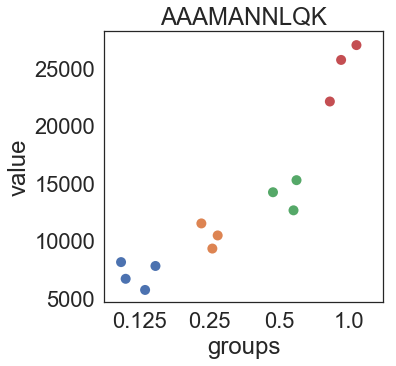

In [70]:
sns.set(font_scale=2)
sns.set_style('white')
sns.stripplot(data=tmp_df, x='groups', y='value', s=10, jitter=0.3)
plt.title(tmp_df.peptide.tolist()[0])

In [71]:
['0.125']*3+ ['0.25']*3+ ['0.5']*3 + ['1']*2

['0.125',
 '0.125',
 '0.125',
 '0.25',
 '0.25',
 '0.25',
 '0.5',
 '0.5',
 '0.5',
 '1',
 '1']

In [132]:
quant_long_norm

index            peptide                            variable     value  \
0          0       AAAEVAGQFVIK                 hela0125ug240k.mzML  0.443592   
1      50976       AAAEVAGQFVIK                   hela1ug240k3.mzML  1.000000   
2       4248       AAAEVAGQFVIK                hela0125ug240k2.mzML  0.315588   
3      29736       AAAEVAGQFVIK                   hela05ug240k.mzML  0.746218   
4      25488       AAAEVAGQFVIK                 hela025ug240k3.mzML  0.579477   
5      38232       AAAEVAGQFVIK                  hela05ug240k3.mzML  0.779078   
6      42480       AAAEVAGQFVIK                    hela1ug240k.mzML  0.607145   
7      12744       AAAEVAGQFVIK  hela0125ug240k_20220305180559.mzML  0.299417   
8       8496       AAAEVAGQFVIK                hela0125ug240k3.mzML  0.344102   
9      33984       AAAEVAGQFVIK                  hela05ug240k2.mzML  0.878619   
10     21240       AAAEVAGQFVIK                 hela025ug240k2.mzML  0.581709   
11     46728       AAAEVAGQFVIK                   hela1ug240k2.mzML  0.847489   
12     16992       AAAEVAGQFVIK                  hela025ug240k.mzML  0.496207   
13      8497         AAAMANNLQK                hela0125ug240k3.mzML  0.300507   
14     46729         AAAMANNLQK                   hela1ug240k2.mzML  0.818220   
15     25489         AAAMANNLQK                 hela025ug240k3.mzML  0.425206   
16     33985         AAAMANNLQK                  hela05ug240k2.mzML  0.525713   
17     29737         AAAMANNLQK                   hela05ug240k.mzML  0.467393   
18     21241         AAAMANNLQK                 hela025ug240k2.mzML  0.344133   
19     38233         AAAMANNLQK                  hela05ug240k3.mzML  0.564637   
20      4249         AAAMANNLQK                hela0125ug240k2.mzML  0.210757   
21         1         AAAMANNLQK                 hela0125ug240k.mzML  0.288026   
22     50977         AAAMANNLQK                   hela1ug240k3.mzML  0.952217   
23     42481         AAAMANNLQK                    hela1ug240k.mzML  1.000000   
24     12745         AAAMANNLQK  hela0125ug240k_20220305180559.mzML  0.246682   
25     16993         AAAMANNLQK                  hela025ug240k.mzML  0.386464   
26     16994      AAAPGVEDEPLLR                  hela025ug240k.mzML  0.522139   
27         2      AAAPGVEDEPLLR                 hela0125ug240k.mzML  0.520072   
28     33986      AAAPGVEDEPLLR                  hela05ug240k2.mzML  0.804334   
29      8498      AAAPGVEDEPLLR                hela0125ug240k3.mzML  0.461029   
...      ...                ...                                 ...       ...   
55194   4245  YYGGAEVVDEIELLCQR                 hela0125ug240k.mzML  0.581923   
55195  29733  YYGGAEVVDEIELLCQR                 hela025ug240k3.mzML  0.626290   
55196  16989  YYGGAEVVDEIELLCQR  hela0125ug240k_20220305180559.mzML  0.370038   
55197  12741  YYGGAEVVDEIELLCQR                hela0125ug240k3.mzML  0.478767   
55198  25486     YYTSASGDEMVSLK                 hela025ug240k2.mzML  0.334798   
55199  50974     YYTSASGDEMVSLK                   hela1ug240k2.mzML  1.000000   
55200  55222     YYTSASGDEMVSLK                   hela1ug240k3.mzML  0.831828   
55201  29734     YYTSASGDEMVSLK                 hela025ug240k3.mzML  0.423780   
55202  46726     YYTSASGDEMVSLK                    hela1ug240k.mzML  0.802345   
55203   8494     YYTSASGDEMVSLK                hela0125ug240k2.mzML  0.229860   
55204  42478     YYTSASGDEMVSLK                  hela05ug240k3.mzML  0.477412   
55205  21238     YYTSASGDEMVSLK                  hela025ug240k.mzML  0.351870   
55206  12742     YYTSASGDEMVSLK                hela0125ug240k3.mzML  0.248785   
55207  33982     YYTSASGDEMVSLK                   hela05ug240k.mzML  0.428097   
55208   4246     YYTSASGDEMVSLK                 hela0125ug240k.mzML  0.257120   
55209  38230     YYTSASGDEMVSLK                  hela05ug240k2.mzML  0.512993   
55210  16990     YYTSASGDEMVSLK  hela0125ug240k_20220305180559.mzML  0.234180   
55211  50975           YYVLNALK       

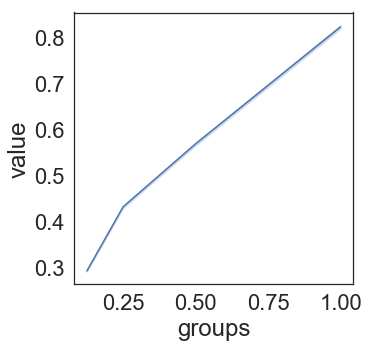

In [141]:
sns.lineplot(data=quant_long_norm, x="groups", y="value")

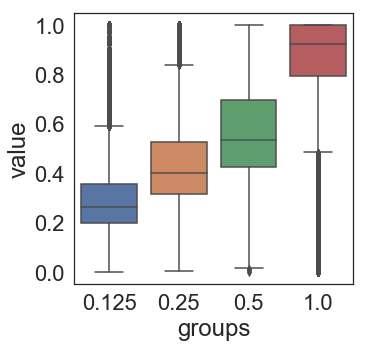

In [142]:
sns.boxplot(data=quant_long_norm, x="groups", y="value")

In [72]:
#quant_df.to_csv('../data/quant_df_long_240k.csv')

### Start here to read in the CSV!

### get the average of each group and then use that to compute the slope and r2 spearman rho

In [152]:
quant_df_wide =  quant_df
quant_df_wide.head()

hela0125ug240k.mzML  hela0125ug240k2.mzML  \
AAAEVAGQFVIK           12507.321594           8898.171814   
AAAMANNLQK              7769.772644           5685.349884   
AAAPGVEDEPLLR           1729.574203           1528.808701   
AAAVVGINSETIMK           549.691269            667.033203   
AAECNIVVTQPR           12398.835739          14023.640869   

                hela0125ug240k3.mzML  hela0125ug240k_20220305180559.mzML  \
AAAEVAGQFVIK             9702.148941                         8442.228271   
AAAMANNLQK               8106.460312                         6654.466354   
AAAPGVEDEPLLR            1533.218727                         2103.710037   
AAAVVGINSETIMK            761.603790                          391.744377   
AAECNIVVTQPR            14214.433899                        11902.944412   

                hela025ug240k.mzML  hela025ug240k2.mzML  hela025ug240k3.mzML  \
AAAEVAGQFVIK          13990.813812         16401.591583         16338.667480   
AAAMANNLQK            10425.215759          9283.290649         11470.307495   
AAAPGVEDEPLLR          1736.449799          2093.781143          1782.626053   
AAAVVGINSETIMK          772.161507          1270.453217          1530.063942   
AAECNIVVTQPR          14678.739929         21150.495331         22308.503677   

                hela05ug240k.mzML  hela05ug240k2.mzML  hela05ug240k3.mzML  \
AAAEVAGQFVIK         21040.008026        24773.139709        21966.532684   
AAAMANNLQK           12608.358856        14181.581390        15231.599670   
AAAPGVEDEPLLR         1828.751984         2674.929642         2124.993835   
AAAVVGINSETIMK        1207.654404         1231.845772         1140.267532   
AAECNIVVTQPR         22051.204025        29112.797394        28331.300598   

                hela1ug240k.mzML  hela1ug240k2.mzML  hela1ug240k3.mzML  \
AAAEVAGQFVIK        17118.776276       23895.409058       28195.535889   
AAAMANNLQK          26975.910767       22072.235657       25686.916443   
AAAPGVEDEPLLR        3325.646729        3027.792969        2993.599854   
AAAVVGINSETIMK       1669.419991        2257.567337        1879.867538   
AAECNIVVTQPR        59146.735962       52643.661438       66883.577393   

                       peptide  
AAAEVAGQFVIK      AAAEVAGQFVIK  
AAAMANNLQK          AAAMANNLQK  
AAAPGVEDEPLLR    AAAPGVEDEPLLR  
AAAVVGINSETIMK  AAAVVGINSETIMK  
AAECNIVVTQPR      AAECNIVVTQPR

In [153]:
ave_df_wide = pd.DataFrame(quant_df_wide.iloc[:,0:3].mean(axis=1), columns=['0.125'])

In [154]:
np.mean([25842.345154,21121.506226])

23481.92569

In [155]:
np.mean([27901.927826,23214.172607,27052.633820])

26056.244751000002

In [156]:
ave_df_wide['0.25'] = quant_df_wide.iloc[:,3:6].mean(axis=1)
ave_df_wide['0.5'] = quant_df_wide.iloc[:,6:9].mean(axis=1)
ave_df_wide['1'] = quant_df_wide.iloc[:,9:11].mean(axis=1)

ave_df_wide.head()

0.125          0.25           0.5             1
AAAEVAGQFVIK    10369.214116  12944.877889  20717.271739  19542.654480
AAAMANNLQK       7187.194280   8787.657588  12753.415914  21103.755219
AAAPGVEDEPLLR    1597.200544   1977.980326   2095.435893   2725.320282
AAAVVGINSETIMK    659.442754    811.453033   1323.188039   1404.843761
AAECNIVVTQPR    13545.636836  15910.726557  24490.835032  43739.018280

In [157]:
dfMax = ave_df_wide.max(axis=1)
norm_ave_df_wide = ave_df_wide.divide(dfMax, axis=0)

In [158]:
norm_ave_df_wide.head()

0.125      0.25       0.5         1
AAAEVAGQFVIK    0.500511  0.624835  1.000000  0.943303
AAAMANNLQK      0.340565  0.416403  0.604320  1.000000
AAAPGVEDEPLLR   0.586060  0.725779  0.768877  1.000000
AAAVVGINSETIMK  0.469406  0.577611  0.941876  1.000000
AAECNIVVTQPR    0.309692  0.363765  0.559931  1.000000

In [159]:
plt.plot([0.125,0.25,0.5,1],norm_ave_df_wide.mean())
plt.xlim(0,1)
plt.ylim(0,1)

(0, 1)

In [160]:
len(norm_ave_df_wide)

4248

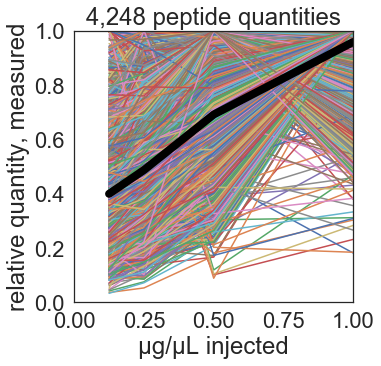

In [161]:
plt.rcParams['figure.figsize'] = 5,5
for i in range(0, len(norm_ave_df_wide)):
    plt.plot([0.125,0.25,0.5,1], norm_ave_df_wide.iloc[i])

plt.plot([0.125,0.25,0.5,1], norm_ave_df_wide.mean(), color='black', linewidth=8)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(u"\u03bcg/\u03bcL injected")
plt.ylabel('relative quantity, measured')
plt.title('4,248 peptide quantities')
plt.savefig('../plots/prelim240k_relative_quant_4248peptides_all_fragments.svg', bbox_inches='tight')

In [163]:
quant_long_norm

index            peptide                            variable     value  \
0          0       AAAEVAGQFVIK                 hela0125ug240k.mzML  0.443592   
1      50976       AAAEVAGQFVIK                   hela1ug240k3.mzML  1.000000   
2       4248       AAAEVAGQFVIK                hela0125ug240k2.mzML  0.315588   
3      29736       AAAEVAGQFVIK                   hela05ug240k.mzML  0.746218   
4      25488       AAAEVAGQFVIK                 hela025ug240k3.mzML  0.579477   
5      38232       AAAEVAGQFVIK                  hela05ug240k3.mzML  0.779078   
6      42480       AAAEVAGQFVIK                    hela1ug240k.mzML  0.607145   
7      12744       AAAEVAGQFVIK  hela0125ug240k_20220305180559.mzML  0.299417   
8       8496       AAAEVAGQFVIK                hela0125ug240k3.mzML  0.344102   
9      33984       AAAEVAGQFVIK                  hela05ug240k2.mzML  0.878619   
10     21240       AAAEVAGQFVIK                 hela025ug240k2.mzML  0.581709   
11     46728       AAAEVAGQFVIK                   hela1ug240k2.mzML  0.847489   
12     16992       AAAEVAGQFVIK                  hela025ug240k.mzML  0.496207   
13      8497         AAAMANNLQK                hela0125ug240k3.mzML  0.300507   
14     46729         AAAMANNLQK                   hela1ug240k2.mzML  0.818220   
15     25489         AAAMANNLQK                 hela025ug240k3.mzML  0.425206   
16     33985         AAAMANNLQK                  hela05ug240k2.mzML  0.525713   
17     29737         AAAMANNLQK                   hela05ug240k.mzML  0.467393   
18     21241         AAAMANNLQK                 hela025ug240k2.mzML  0.344133   
19     38233         AAAMANNLQK                  hela05ug240k3.mzML  0.564637   
20      4249         AAAMANNLQK                hela0125ug240k2.mzML  0.210757   
21         1         AAAMANNLQK                 hela0125ug240k.mzML  0.288026   
22     50977         AAAMANNLQK                   hela1ug240k3.mzML  0.952217   
23     42481         AAAMANNLQK                    hela1ug240k.mzML  1.000000   
24     12745         AAAMANNLQK  hela0125ug240k_20220305180559.mzML  0.246682   
25     16993         AAAMANNLQK                  hela025ug240k.mzML  0.386464   
26     16994      AAAPGVEDEPLLR                  hela025ug240k.mzML  0.522139   
27         2      AAAPGVEDEPLLR                 hela0125ug240k.mzML  0.520072   
28     33986      AAAPGVEDEPLLR                  hela05ug240k2.mzML  0.804334   
29      8498      AAAPGVEDEPLLR                hela0125ug240k3.mzML  0.461029   
...      ...                ...                                 ...       ...   
55194   4245  YYGGAEVVDEIELLCQR                 hela0125ug240k.mzML  0.581923   
55195  29733  YYGGAEVVDEIELLCQR                 hela025ug240k3.mzML  0.626290   
55196  16989  YYGGAEVVDEIELLCQR  hela0125ug240k_20220305180559.mzML  0.370038   
55197  12741  YYGGAEVVDEIELLCQR                hela0125ug240k3.mzML  0.478767   
55198  25486     YYTSASGDEMVSLK                 hela025ug240k2.mzML  0.334798   
55199  50974     YYTSASGDEMVSLK                   hela1ug240k2.mzML  1.000000   
55200  55222     YYTSASGDEMVSLK                   hela1ug240k3.mzML  0.831828   
55201  29734     YYTSASGDEMVSLK                 hela025ug240k3.mzML  0.423780   
55202  46726     YYTSASGDEMVSLK                    hela1ug240k.mzML  0.802345   
55203   8494     YYTSASGDEMVSLK                hela0125ug240k2.mzML  0.229860   
55204  42478     YYTSASGDEMVSLK                  hela05ug240k3.mzML  0.477412   
55205  21238     YYTSASGDEMVSLK                  hela025ug240k.mzML  0.351870   
55206  12742     YYTSASGDEMVSLK                hela0125ug240k3.mzML  0.248785   
55207  33982     YYTSASGDEMVSLK                   hela05ug240k.mzML  0.428097   
55208   4246     YYTSASGDEMVSLK                 hela0125ug240k.mzML  0.257120   
55209  38230     YYTSASGDEMVSLK                  hela05ug240k2.mzML  0.512993   
55210  16990     YYTSASGDEMVSLK  hela0125ug240k_20220305180559.mzML  0.234180   
55211  50975           YYVLNALK       

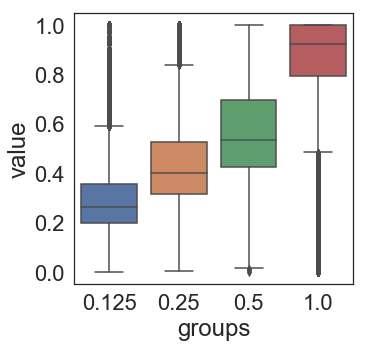

In [164]:
sns.boxplot(data = quant_long_norm, x='groups', y='value')

In [165]:
## now get the spearman and slope from each peptide

pearsonrs = []
pearsonps= []
spearmanrs = []
spearmanps = []
slopes = []


for i in range(0, len(ave_df_wide)):
    
    x = np.array([0.125, 0.25, 0.5, 1])
    y = norm_ave_df_wide.iloc[i]
    pr, pp = pearsonr(x, y)
    pearsonrs.append(pr)
    pearsonps.append(pp)
    sr, sp = spearmanr(x, y)  
    spearmanrs.append(sr)
    spearmanps.append(sp)
    result = linregress(x, y)
    slopes.append(result.slope)


In [166]:
regression_metrics = pd.DataFrame({'r':pearsonrs,'pvalp':pearsonps, 'rho':spearmanrs, 'pvals':spearmanps, 'slopes':slopes}, index=ave_df_wide.index)

In [167]:
regression_metrics.mean()

pvalp     0.099433
pvals     0.079606
r         0.855543
rho       0.885836
slopes    0.638417
dtype: float64

In [169]:
these_r_good = regression_metrics[(regression_metrics.pvals<0.05) & (regression_metrics.pvalp<0.05) & (regression_metrics.slopes>0) ].index
print(len(norm_ave_df_wide.loc[these_r_good]) )
norm_ave_df_wide.loc[these_r_good].shape

2985


(2985, 4)

In [170]:
norm_ave_df_wide.to_csv('../data/prelim240k_normalized_ave_quant_data.csv')

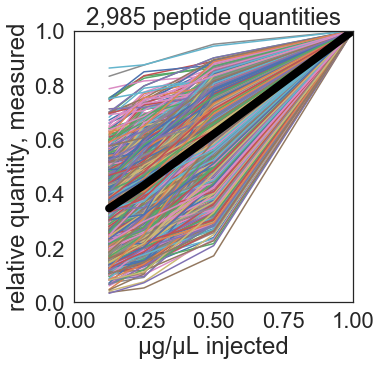

In [171]:
plt.rcParams['figure.figsize'] = 5,5
ss = norm_ave_df_wide.loc[these_r_good]
for i in range(0, len(ss)):
    plt.plot([0.125,0.25,0.5,1], ss.iloc[i])

plt.plot([0.125,0.25,0.5,1], ss.mean(), color='black', linewidth=8)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(u"\u03bcg/\u03bcL injected")
plt.ylabel('relative quantity, measured')
plt.title('2,985 peptide quantities')
plt.savefig('../plots/prelim240k_relquant_2985pep_corrfilter_all_fragments.svg', bbox_inches='tight')

In [172]:
quant_long_norm_good = quant_long_norm[quant_long_norm['peptide'].isin(these_r_good)]

In [173]:
quant_long_norm.shape

(55224, 5)

In [174]:
quant_long_norm_good.shape

(38805, 5)

### make boxplots

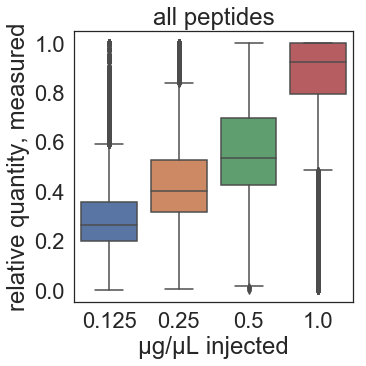

In [189]:
sns.boxplot(data=quant_long_norm, x="groups", y="value")
plt.xlabel(u"\u03bcg/\u03bcL injected")
plt.ylabel('relative quantity, measured')
plt.title('all peptides')
plt.savefig('../plots/240k_boxplot_all_peptides.svg', bbox_inches='tight')

In [176]:
quant_long_norm_good = quant_long_norm[quant_long_norm['peptide'].isin(these_r_good)]
print(len(quant_long_norm_good))

38805


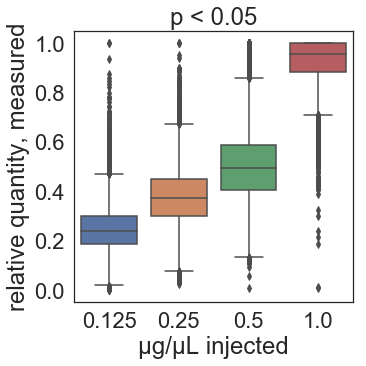

In [188]:
sns.boxplot(data=quant_long_norm_good, x="groups", y="value")
plt.xlabel(u"\u03bcg/\u03bcL injected")
plt.ylabel('relative quantity, measured')
plt.title('p < 0.05')
plt.savefig('../plots/240k_boxplot_2985_peptides.svg', bbox_inches='tight')

In [182]:
these_r_good = regression_metrics[(regression_metrics.pvals<0.01) & (regression_metrics.pvalp<0.01) & (regression_metrics.slopes>0) ].index
print(len(norm_ave_df_wide.loc[these_r_good]) )
norm_ave_df_wide.loc[these_r_good].shape

1815


(1815, 4)

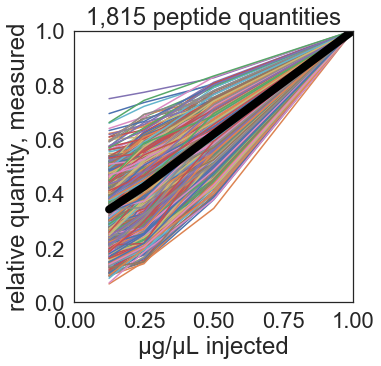

In [183]:
plt.rcParams['figure.figsize'] = 5,5
ss = norm_ave_df_wide.loc[these_r_good]
for i in range(0, len(ss)):
    plt.plot([0.125,0.25,0.5,1], ss.iloc[i])

plt.plot([0.125,0.25,0.5,1], ss.mean(), color='black', linewidth=8)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(u"\u03bcg/\u03bcL injected")
plt.ylabel('relative quantity, measured')
plt.title('1,815 peptide quantities')
plt.savefig('../plots/prelim240k_relquant_1815pep_corrfilter_all_fragments.svg', bbox_inches='tight')

In [185]:
quant_long_norm_good_p01 = quant_long_norm[quant_long_norm['peptide'].isin(these_r_good)]
print(len(quant_long_norm_good))

38805


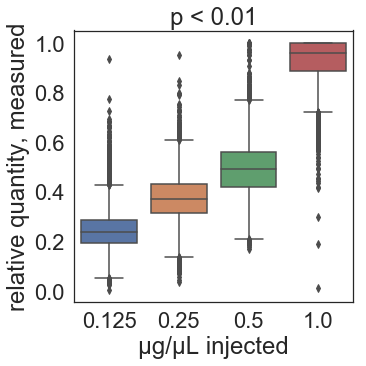

In [187]:
sns.boxplot(data=quant_long_norm_good_p01, x="groups", y="value")
plt.xlabel(u"\u03bcg/\u03bcL injected")
plt.ylabel('relative quantity, measured')
plt.title('p < 0.01')
plt.savefig('../plots/240k_boxplot_1815_peptides.svg', bbox_inches='tight')

In [88]:
print(sns.__version__)

0.11.2


In [94]:
quant_df

hela0125ug240k.mzML  hela0125ug240k2.mzML  \
AAAEVAGQFVIK           12507.321594           8898.171814   
AAAMANNLQK              7769.772644           5685.349884   
AAAPGVEDEPLLR           1729.574203           1528.808701   
AAAVVGINSETIMK           549.691269            667.033203   
AAECNIVVTQPR           12398.835739          14023.640869   

                hela0125ug240k3.mzML  hela0125ug240k_20220305180559.mzML  \
AAAEVAGQFVIK             9702.148941                         8442.228271   
AAAMANNLQK               8106.460312                         6654.466354   
AAAPGVEDEPLLR            1533.218727                         2103.710037   
AAAVVGINSETIMK            761.603790                          391.744377   
AAECNIVVTQPR            14214.433899                        11902.944412   

                hela025ug240k.mzML  hela025ug240k2.mzML  hela025ug240k3.mzML  \
AAAEVAGQFVIK          13990.813812         16401.591583         16338.667480   
AAAMANNLQK            10425.215759          9283.290649         11470.307495   
AAAPGVEDEPLLR          1736.449799          2093.781143          1782.626053   
AAAVVGINSETIMK          772.161507          1270.453217          1530.063942   
AAECNIVVTQPR          14678.739929         21150.495331         22308.503677   

                hela05ug240k.mzML  hela05ug240k2.mzML  hela05ug240k3.mzML  \
AAAEVAGQFVIK         21040.008026        24773.139709        21966.532684   
AAAMANNLQK           12608.358856        14181.581390        15231.599670   
AAAPGVEDEPLLR         1828.751984         2674.929642         2124.993835   
AAAVVGINSETIMK        1207.654404         1231.845772         1140.267532   
AAECNIVVTQPR         22051.204025        29112.797394        28331.300598   

                hela1ug240k.mzML  hela1ug240k2.mzML  hela1ug240k3.mzML  \
AAAEVAGQFVIK        17118.776276       23895.409058       28195.535889   
AAAMANNLQK          26975.910767       22072.235657       25686.916443   
AAAPGVEDEPLLR        3325.646729        3027.792969        2993.599854   
AAAVVGINSETIMK       1669.419991        2257.567337        1879.867538   
AAECNIVVTQPR        59146.735962       52643.661438       66883.577393   

                       peptide  
AAAEVAGQFVIK      AAAEVAGQFVIK  
AAAMANNLQK          AAAMANNLQK  
AAAPGVEDEPLLR    AAAPGVEDEPLLR  
AAAVVGINSETIMK  AAAVVGINSETIMK  
AAECNIVVTQPR      AAECNIVVTQPR

In [97]:
quant_long

peptide                            variable         value  \
0           AAAEVAGQFVIK                 hela0125ug240k.mzML  12507.321594   
50976       AAAEVAGQFVIK                   hela1ug240k3.mzML  28195.535889   
4248        AAAEVAGQFVIK                hela0125ug240k2.mzML   8898.171814   
29736       AAAEVAGQFVIK                   hela05ug240k.mzML  21040.008026   
25488       AAAEVAGQFVIK                 hela025ug240k3.mzML  16338.667480   
38232       AAAEVAGQFVIK                  hela05ug240k3.mzML  21966.532684   
42480       AAAEVAGQFVIK                    hela1ug240k.mzML  17118.776276   
12744       AAAEVAGQFVIK  hela0125ug240k_20220305180559.mzML   8442.228271   
8496        AAAEVAGQFVIK                hela0125ug240k3.mzML   9702.148941   
33984       AAAEVAGQFVIK                  hela05ug240k2.mzML  24773.139709   
21240       AAAEVAGQFVIK                 hela025ug240k2.mzML  16401.591583   
46728       AAAEVAGQFVIK                   hela1ug240k2.mzML  23895.409058   
16992       AAAEVAGQFVIK                  hela025ug240k.mzML  13990.813812   
8497          AAAMANNLQK                hela0125ug240k3.mzML   8106.460312   
46729         AAAMANNLQK                   hela1ug240k2.mzML  22072.235657   
25489         AAAMANNLQK                 hela025ug240k3.mzML  11470.307495   
33985         AAAMANNLQK                  hela05ug240k2.mzML  14181.581390   
29737         AAAMANNLQK                   hela05ug240k.mzML  12608.358856   
21241         AAAMANNLQK                 hela025ug240k2.mzML   9283.290649   
38233         AAAMANNLQK                  hela05ug240k3.mzML  15231.599670   
4249          AAAMANNLQK                hela0125ug240k2.mzML   5685.349884   
1             AAAMANNLQK                 hela0125ug240k.mzML   7769.772644   
50977         AAAMANNLQK                   hela1ug240k3.mzML  25686.916443   
42481         AAAMANNLQK                    hela1ug240k.mzML  26975.910767   
12745         AAAMANNLQK  hela0125ug240k_20220305180559.mzML   6654.466354   
16993         AAAMANNLQK                  hela025ug240k.mzML  10425.215759   
16994      AAAPGVEDEPLLR                  hela025ug240k.mzML   1736.449799   
2          AAAPGVEDEPLLR                 hela0125ug240k.mzML   1729.574203   
33986      AAAPGVEDEPLLR                  hela05ug240k2.mzML   2674.929642   
8498       AAAPGVEDEPLLR                hela0125ug240k3.mzML   1533.218727   
...                  ...                                 ...           ...   
4245   YYGGAEVVDEIELLCQR                 hela0125ug240k.mzML   4647.285408   
29733  YYGGAEVVDEIELLCQR                 hela025ug240k3.mzML   5001.602631   
16989  YYGGAEVVDEIELLCQR  hela0125ug240k_20220305180559.mzML   2955.153687   
12741  YYGGAEVVDEIELLCQR                hela0125ug240k3.mzML   3823.472649   
25486     YYTSASGDEMVSLK                 hela025ug240k2.mzML  22000.008362   
50974     YYTSASGDEMVSLK                   hela1ug240k2.mzML  65711.291504   
55222     YYTSASGDEMVSLK                   hela1ug240k3.mzML  54660.518494   
29734     YYTSASGDEMVSLK                 hela025ug240k3.mzML  27847.137054   
46726     YYTSASGDEMVSLK                    hela1ug240k.mzML  52723.158142   
8494      YYTSASGDEMVSLK                hela0125ug240k2.mzML  15104.370285   
42478     YYTSASGDEMVSLK                  hela05ug240k3.mzML  31371.336090   
21238     YYTSASGDEMVSLK                  hela025ug240k.mzML  23121.849274   
12742     YYTSASGDEMVSLK                hela0125ug240k3.mzML  16348.001511   
33982     YYTSASGDEMVSLK                   hela05ug240k.mzML  28130.822205   
4246      YYTSASGDEMVSLK                 hela0125ug240k.mzML  16895.679230   
38230     YYTSASGDEMVSLK                  hela05ug240k2.mzML  33709.411682   
16990     YYTSASGDEMVSLK  hela0125ug240k_20220305180559.mzML  15388.289459   
50975           YYVLNALK                   hela1ug240k2.mzML   8245.819977   
29735           YYVLNALK                 hela025ug240k3.mzML   4479.217194   
21239           YYVLNALK               

In [ ]:
quant_long

In [95]:
sns.lineplot(data=quant_long, x="groups", y="value")

In [190]:
ss.to_csv('../data/240k_normalized_ave_quant_wide_1815_best_peptides.csv')

In [191]:
regression_metrics.to_csv('../data/240k_regression_metrics_ave_data_all_peps.csv')

In [192]:
ave_df_wide.to_csv('../data/240k_ave_quant_wide.csv')

In [193]:
quant_df_wide.to_csv('../data/240k_quant_df_wide.csv')

In [194]:
np.mean([9108.143677, 9362.786316, 12448.442291])

10306.457428

# Now plot a couple good examples

In [211]:
regression_metrics[(regression_metrics.slopes>0.9) & (regression_metrics.pvalp<0.001)]

pvalp  pvals         r  rho    slopes
AVPLALALISVSNPR       0.000681    0.0  0.999319  1.0  0.907129
EYWMDPEGEMKPGR        0.000603    0.0  0.999397  1.0  0.906987
GHVFEESQVAGTPMFVVK    0.000531    0.0  0.999469  1.0  1.015256
IIGATDSSGELMFLMK      0.000721    0.0  0.999279  1.0  0.923963
ISGGSVVEMQGDEMTR      0.000664    0.0  0.999336  1.0  0.905329
LALDMEISAYR           0.000066    0.0  0.999934  1.0  0.951658
PNEGAIVEVALEGYYK      0.000340    0.0  0.999660  1.0  0.962327
PNMVTPGHACTQK         0.000424    0.0  0.999576  1.0  0.931277
SFTGNFVIDENILK        0.000996    0.0  0.999004  1.0  0.901630
SLLIPYLDNLVK          0.000608    0.0  0.999392  1.0  0.907713
SLQALGEVIEAELR        0.000848    0.0  0.999152  1.0  0.935468
TFVLEVMGR             0.000585    0.0  0.999415  1.0  0.932475
TGPNLHGLFGR           0.000350    0.0  0.999650  1.0  0.910442
VQLPPEIQLAQR          0.000575    0.0  0.999425  1.0  0.906133
YFHVVIAGPQDSPFEGGTFK  0.000114    0.0  0.999886  1.0  0.903597

In [196]:
tmp_df=quant_long[quant_long.peptide=="ALEHFTDLYDIK"]
tmp_df

peptide                            variable         value  groups
17153  ALEHFTDLYDIK                  hela025ug240k.mzML   5696.605209   0.250
25649  ALEHFTDLYDIK                 hela025ug240k3.mzML   9362.837631   0.250
12905  ALEHFTDLYDIK  hela0125ug240k_20220305180559.mzML   3714.140030   0.125
42641  ALEHFTDLYDIK                    hela1ug240k.mzML  30299.477386   1.000
21401  ALEHFTDLYDIK                 hela025ug240k2.mzML   4353.388557   0.250
8657   ALEHFTDLYDIK                hela0125ug240k3.mzML   2914.491074   0.125
34145  ALEHFTDLYDIK                  hela05ug240k2.mzML  13778.600830   0.500
29897  ALEHFTDLYDIK                   hela05ug240k.mzML   8099.545151   0.500
46889  ALEHFTDLYDIK                   hela1ug240k2.mzML  27336.862610   1.000
51137  ALEHFTDLYDIK                   hela1ug240k3.mzML  29066.425201   1.000
161    ALEHFTDLYDIK                 hela0125ug240k.mzML   2856.665726   0.125
38393  ALEHFTDLYDIK                  hela05ug240k3.mzML   9793.558716   0.500
4409   ALEHFTDLYDIK                hela0125ug240k2.mzML   3324.436035   0.125

In [197]:
from matplotlib.pyplot import scatter

def rand_jitter(arr):
    stdev = .02 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

In [198]:
tmp_df.groups.values

array([0.25 , 0.25 , 0.125, 1.   , 0.25 , 0.125, 0.5  , 0.5  , 1.   ,
       1.   , 0.125, 0.5  , 0.125])

In [201]:
### sort by value
tmp_df.sort_values('groups', inplace=True)
tmp_df

C:\Users\jmeyer\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


peptide                            variable         value  groups
12905  ALEHFTDLYDIK  hela0125ug240k_20220305180559.mzML   3714.140030   0.125
8657   ALEHFTDLYDIK                hela0125ug240k3.mzML   2914.491074   0.125
161    ALEHFTDLYDIK                 hela0125ug240k.mzML   2856.665726   0.125
4409   ALEHFTDLYDIK                hela0125ug240k2.mzML   3324.436035   0.125
17153  ALEHFTDLYDIK                  hela025ug240k.mzML   5696.605209   0.250
25649  ALEHFTDLYDIK                 hela025ug240k3.mzML   9362.837631   0.250
21401  ALEHFTDLYDIK                 hela025ug240k2.mzML   4353.388557   0.250
34145  ALEHFTDLYDIK                  hela05ug240k2.mzML  13778.600830   0.500
29897  ALEHFTDLYDIK                   hela05ug240k.mzML   8099.545151   0.500
38393  ALEHFTDLYDIK                  hela05ug240k3.mzML   9793.558716   0.500
42641  ALEHFTDLYDIK                    hela1ug240k.mzML  30299.477386   1.000
46889  ALEHFTDLYDIK                   hela1ug240k2.mzML  27336.862610   1.000
51137  ALEHFTDLYDIK                   hela1ug240k3.mzML  29066.425201   1.000

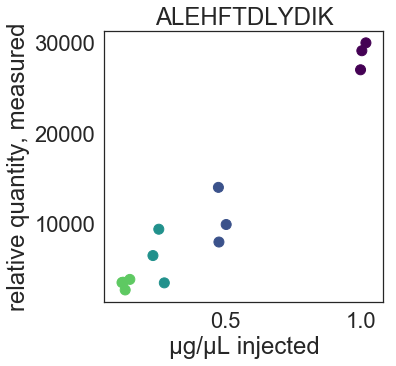

In [205]:
plt.rcParams['figure.figsize'] = 5,5
categories = np.array([0, 0, 0, 0, 1, 1, 1, 2, 2,2,3,3,3])

colormap = np.array(['#5ec962', '#21918c', '#3b528b', '#440154'])

jitter(tmp_df.groups.values, tmp_df.value, s=100, c = colormap[categories])

plt.xlabel(u"\u03bcg/\u03bcL injected")
plt.ylabel('relative quantity, measured')
plt.title('ALEHFTDLYDIK')
plt.savefig('../plots/240k_all_fragments_ALEHFTDLYDIK.svg', bbox_inches='tight')

In [210]:
tmp_df=quant_long[quant_long.peptide=="EYWMDPEGEMKPGR"]
tmp_df
### sort by value
tmp_df.sort_values('groups', inplace=True)

plt.rcParams['figure.figsize'] = 5,5
categories = np.array([0, 0, 0, 0, 1, 1, 1, 2, 2,2,3,3,3])

colormap = np.array(['#5ec962', '#21918c', '#3b528b', '#440154'])

jitter(tmp_df.groups.values, tmp_df.value, s=100, c = colormap[categories])

plt.xlabel(u"\u03bcg/\u03bcL injected")
plt.ylabel('relative quantity, measured')
plt.title('EYWMDPEGEMKPGR')
plt.savefig('../plots/240k_all_fragments_EYWMDPEGEMKPGR.svg', bbox_inches='tight')


C:\Users\jmeyer\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


C:\Users\jmeyer\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


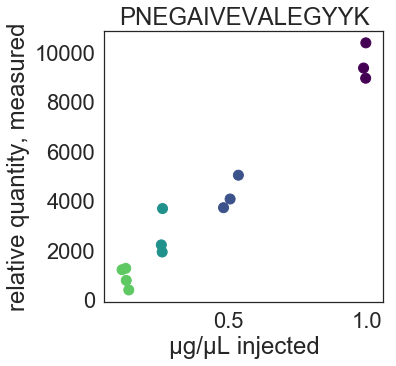

In [213]:
tmp_df=quant_long[quant_long.peptide=="PNEGAIVEVALEGYYK"]
tmp_df
### sort by value
tmp_df.sort_values('groups', inplace=True)

plt.rcParams['figure.figsize'] = 5,5
categories = np.array([0, 0, 0, 0, 1, 1, 1, 2, 2,2,3,3,3])

colormap = np.array(['#5ec962', '#21918c', '#3b528b', '#440154'])

jitter(tmp_df.groups.values, tmp_df.value, s=100, c = colormap[categories])

plt.xlabel(u"\u03bcg/\u03bcL injected")
plt.ylabel('relative quantity, measured')
plt.title('PNEGAIVEVALEGYYK')
plt.savefig('../plots/240k_all_fragments_PNEGAIVEVALEGYYK.svg', bbox_inches='tight')


In [164]:
fragments_quant.iloc[0,:]

hela0125ug240k.mzML                    82.316307
hela0125ug240k2.mzML                  183.174118
hela0125ug240k3.mzML                  134.235962
hela0125ug240k_20220305180559.mzML    127.968643
hela025ug240k.mzML                    271.910614
hela025ug240k2.mzML                     1.000000
hela025ug240k3.mzML                   263.794708
hela05ug240k.mzML                     225.355148
hela05ug240k2.mzML                    235.924866
hela05ug240k3.mzML                    317.357513
hela1ug240k.mzML                      596.091187
hela1ug240k2.mzML                     938.398315
hela1ug240k3.mzML                     872.885986
Name: 0, dtype: float64

In [444]:
these_r_good = regression_metrics[(regression_metrics.pvals<0.01) & (regression_metrics.pvalp<0.01) ].index
norm_ave_df_wide.loc[these_r_good]



0.125      0.25       0.5    1
AELELELGR                   0.214368  0.330014  0.540929  1.0
AHGGYSVFAGVGER              0.085560  0.208508  0.373085  1.0
AHQVVEDGYEFFAK              0.136963  0.308967  0.496897  1.0
ALEHFTDLYDIK                0.145091  0.329921  0.497775  1.0
AQIHDLVLVGGSTR              0.058774  0.186176  0.372159  1.0
AVGIWHCGSCMK                0.129622  0.298624  0.570404  1.0
AVTEQGHELSNEER              0.117215  0.315050  0.538491  1.0
DDVAPESGDTTVK               0.438663  0.533738  0.621643  1.0
DFNHINVELSLLGK              0.070644  0.155462  0.384795  1.0
DKLESEMEDAYHEHQANLLR        0.234294  0.353449  0.575740  1.0
DVFHMVVEVPR                 0.088205  0.304906  0.521209  1.0
EFTLEFSR                    0.278511  0.346350  0.575698  1.0
ELQHAALGGTATR               0.114094  0.269986  0.399111  1.0
ENVLIGDGAGFK                0.282219  0.315476  0.581471  1.0
EPPLSLTIHLTSPVVR            0.206947  0.315064  0.541334  1.0
FSHEEIAMATVTALR             0.121702  0.282996  0.518838  1.0
FSVSPVVR                    0.292030  0.364641  0.544299  1.0
GAFGKPQGTVAR                0.076334  0.224985  0.379481  1.0
GLCGAIHSSIAK                0.140008  0.260673  0.449076  1.0
HESQMDSVVK                  0.196729  0.295658  0.500396  1.0
HILILQNK                    0.185431  0.396011  0.520381  1.0
HLEINPDHSIIETLR             0.162252  0.357970  0.506968  1.0
HPDYAILAAR                  0.245329  0.353251  0.650534  1.0
HTVDDGLDIR                  0.246049  0.363574  0.500775  1.0
IDYGEYMDK                   0.332383  0.501098  0.594324  1.0
KTEVLMENFR                  0.106077  0.272560  0.413583  1.0
LCLNICVGESGDR               0.123418  0.147985  0.418463  1.0
LEDLEVIQHR                  0.117027  0.283155  0.427992  1.0
LFAYPDTHR                   0.156289  0.364113  0.558605  1.0
LLADPTGAFGK                 0.379512  0.533736  0.697111  1.0
LMNESLMLVTALNPHIGYDK        0.212093  0.365364  0.560629  1.0
LNDTIQLLVR                  0.229155  0.438616  0.587805  1.0
LTTDFNVIVEALSK              0.355082  0.367037  0.650602  1.0
NMSVHLSPCFR                 0.092014  0.245803  0.402998  1.0
PGGYGYGYGR                  0.192643  0.329990  0.451128  1.0
QMQVLHPAAR                  0.182026  0.343731  0.633642  1.0
QMVIDVLHPGK                 0.193510  0.377988  0.631669  1.0
QNRPIPQWIR                  0.126244  0.340180  0.522721  1.0
REPWLLPSQHNDIIR             0.081502  0.278851  0.410383  1.0
RPLIDQVVQTALSETQDPEEVSVTVK  0.147158  0.237000  0.462607  1.0
RVCEEIAIIPSK                0.205557  0.408458  0.555775  1.0
SLTNDWEDHLAVK               0.148715  0.360975  0.498683  1.0
SYCAEIAHNVSSK               0.143116  0.289922  0.500791  1.0
TDGCHAYLSK                  0.177908  0.327591  0.444447  1.0
TLNMTTSPEEK                 0.242523  0.426202  0.535827  1.0
TREEECHFYAGGQVYPGEASR       0.122885  0.316208  0.473654  1.0
VANVELYYR                   0.421212  0.579223  0.696845  1.0
VFGPGVER                    0.281465  0.454520  0.630047  1.0
VLIAAHGNSLR                 0.142786  0.306299  0.439748  1.0
VTVLFAGQHIAK                0.147017  0.240998  0.428276  1.0
VVASGPGLEHGK                0.170646  0.346142  0.483645  1.0
VYSLDDIR                    0.373750  0.461875  0.649425  1.0
YGEPGEVFINK                 0.109837  0.302069  0.430095  1.0
YLMEEDEDAYKK                0.119049  0.285034  0.422249  1.0

54


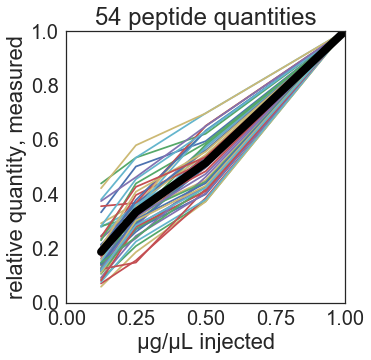

In [446]:
plt.rcParams['figure.figsize'] = 5,5
ss=norm_ave_df_wide.loc[these_r_good]
print(len(ss))
for i in range(0, len(ss)):
    plt.plot([0.125,0.25,0.5,1], ss.iloc[i])

plt.plot([0.125,0.25,0.5,1], ss.mean(), color='black', linewidth=8)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(u"\u03bcg/\u03bcL injected")
plt.ylabel('relative quantity, measured')
plt.title('54 peptide quantities')
plt.savefig('../plots/relative_quant_54peptides_all_fragments.svg', bbox_inches='tight')

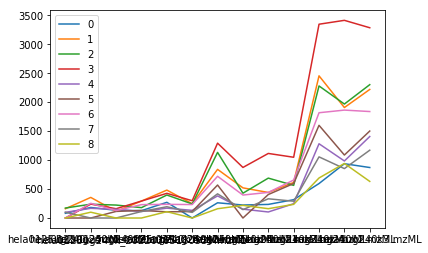

In [158]:
for i in fragments_quant.index:
    plt.plot(fragments_quant.loc[i])
    plt.legend(fragments_quant.index)


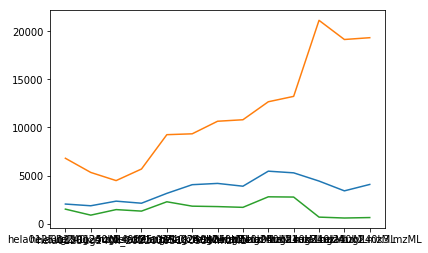

In [59]:
for pep in quant_df.columns:
    plt.plot(quant_df[pep])
    #plt.legend(fragments_quant.index)


In [159]:

predy = round(fl['lightmz'],ndigits = 3).tolist()
foundmzs = [libmzarray[y] for y in [libmzarray.index(x) for x in predy if x in libmzarray]]
foundints = [libintarray[y] for y in [libmzarray.index(x) for x in predy if x in libmzarray]]
keeplight = pd.DataFrame([foundmzs, foundints]).T.sort_values(by=1, ascending=False)[0][:3].tolist()
lightmzs = round(fl['lightmz'], ndigits=3).tolist()
fl = fl.loc[[lightmzs.index(x) for x in keeplight]]
fl['ordinal'] = [len(x) for x in fl['fragseq'].tolist()]


In [63]:
fl

Empty DataFrame
Columns: [fragseq, lightmz, ordinal]
Index: []

In [ ]:
# function doesn't care about the observed masses, just looks in spectral library
### change this to look at the most abundant mass in the observed spectra

def getQuantFragsFromLib(sequence, specname, libfileobj):
    '''
    PURPOSE: determine y-ion fragments to use for SILAC quantification
    
    INPUT: spectral library mgf object used with MSPLIT-DIA
    
    OUTPUT: pandas dataframe of the top 3 y-ion sequence fragments and their light and heavy yion fragments
    '''
    libmzarray = libfileobj.get_by_id(specname)['m/z array'].tolist()
    libintarray = libfileobj.get_by_id(specname)['intensity array'].tolist()
    hK=8.014199 ## mass of heavy lysine
    hR=10.00827 ## mass of heavy arg
    ### fix masses and get proton mass w/o electron
    customAAcomp = dict(mass.std_aa_comp)
    customAAcomp['C'] = mass.Composition({'H':8, 'C':5, 'S':1,'O':2, 'N': 2}) ## add carbamidomethyl to the modifications
    customAAcomp['m'] = mass.Composition({'H': 9, 'C': 5, 'S': 1, 'O': 2, 'N': 1}) ## add oxidized methionine
    protonmass = mass.calculate_mass(formula='H')-0.00054858 ## mass of hydrogen minus an electron
    # clean sequence to remove mod masses and change oxMet to 'm'
    sequence = re.sub('\+42.01057','', sequence)
    sequence = re.sub('\+57.0215','', sequence)
    sequence = re.sub('M\+15.9949','m', sequence)
    # clean sequence to remove mod masses and change oxMet to 'm'
    fraglist = []
    z=1
    for x in range(1, len(sequence)-1):
        fragseq = sequence[x:]
        lightfragmz = mass.calculate_mass(sequence=sequence[x:], ion_type='y', charge=1, aa_comp = customAAcomp)
        ## part to count the number of K and R residues
        nk = fragseq.count('K')
        nr = fragseq.count('R')
        heavyfragmz = lightfragmz + (hK/z)*nk + (hR/z)*nr
        fraglist.append([fragseq, lightfragmz, heavyfragmz])
    fl = pd.DataFrame(fraglist)
    fl.columns = ['fragseq', 'lightmz', 'heavymz']
    predy = round(fl['lightmz'],ndigits = 3).tolist()
    foundmzs = [libmzarray[y] for y in [libmzarray.index(x) for x in predy if x in libmzarray]]
    foundints = [libintarray[y] for y in [libmzarray.index(x) for x in predy if x in libmzarray]]
    keeplight = pd.DataFrame([foundmzs, foundints]).T.sort_values(by=1, ascending=False)[0][:3].tolist()
    lightmzs = round(fl['lightmz'], ndigits=3).tolist()
    fl = fl.loc[[lightmzs.index(x) for x in keeplight]]
    fl['ordinal'] = [len(x) for x in fl['fragseq'].tolist()]
    return(fl)



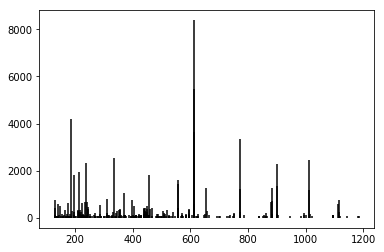

In [31]:
plt.vlines(tmp_1ug.get_by_index(1)['m/z array'],
           [0]*len(tmp_1ug.get_by_index(1)['m/z array']),
           tmp_1ug.get_by_index(1)['intensity array'])